<a href="https://colab.research.google.com/github/ahmedengu/feature_importance/blob/master/Stocks/Germany/Volkswagen/Volkswagen_1H_High.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from IPython.display import clear_output
import pandas as pd

if pd.__version__ != '0.25.0' or False:
  # install
  !apt-get install default-jre build-essential swig
  !pip  install h2o==3.24.0.5 yfinance==0.1.43
  !pip  install git+https://github.com/ahmedengu/findatapy.git pandas==0.25.0
  clear_output(wait=True)

  !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
  !tar -xzvf ta-lib-0.4.0-src.tar.gz
  %cd ta-lib
  !./configure --prefix=/usr
  clear_output(wait=True)
  !make
  clear_output(wait=True)
  !make install
  clear_output(wait=True)
  !pip install Ta-Lib==0.4.17
  clear_output(wait=True)
  print('RESTARTING')
  %cd /content
  
  # force restart
  import os
  os.kill(os.getpid(), 9)

In [0]:
# Experiment Config
import pandas as pd
from IPython.display import display
from IPython.core.debugger import set_trace

data_ticker = "VOW3DEEUR"
data_resample = '1H'
data_label = 'High'
data_label_name = 'y'
start_date = '1 Jan 2018'
finish_date = '1 Jan 2019'
is_duka = True
is_yahoo = False
kaggle_file = 'bitstamp' # default None
kaggle_folder = '1 Day/Stocks'

models_summary = {}
for metric in ['accuracy','F1','auc','logloss','mean_per_class_error','rmse','mse']:
  models_summary.update({metric:pd.DataFrame()})

# feature elimination config
model_selected_features = 50
PCA_k = 50
HCF_threshold = 0.90
LVF_threshold = 0.1
GLRM_k = 20
select_k = 50
select_percentile = 10
select_alpha = 0.1
select_rfe = 50

features_to_include = ['All', 'DLF', 'XGBF', 'RFE', 'Fwe'] # True for all , ['All','Fwe','RFE','Percentile','KBest','LVF','HCF','PCA','XGBF','GLMF','DLF','GLRM'] 
is_EDA = True
max_models_num = 10

# pandas options
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [4]:
# random seed
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)
import pandas as pd
import gc
import os

resample_how= {'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last',
                             'Volume': 'sum', 'Date': 'first'}

if is_duka:
  from findatapy.util import DataConstants

  DataConstants.market_thread_no.update({'dukascopy': 64})

  # Download dataset
  from findatapy.market import Market, MarketDataRequest, MarketDataGenerator

  market = Market(market_data_generator=MarketDataGenerator(log_every_day=30))

  md_request = MarketDataRequest(start_date=start_date, finish_date=finish_date,
                                       fields=['temp', 'ask', 'bid', 'askv', 'bidv'], vendor_fields=['temp', 'ask', 'bid', 'askv', 'bidv'],
                                       freq='tick', data_source='dukascopy',
                                       tickers=[data_ticker], vendor_tickers=[data_ticker])

  temp_dataset = market.fetch_market(md_request)
  full_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bid'].resample(data_resample).ohlc())
  full_dataset.columns = ['Open', 'High', 'Low', 'Close']
  temp_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bidv'].resample(data_resample).sum())
  temp_dataset.columns = ['Volume']
  full_dataset['Volume'] = temp_dataset['Volume']

  del temp_dataset, md_request, market, DataConstants, Market, MarketDataRequest, MarketDataGenerator

  gc.collect()

elif is_yahoo:
  import yfinance as yf
  from datetime import datetime

  full_dataset = yf.download(data_ticker, start=str(datetime.strptime(start_date, '%d %b %Y')).split(' ')[0], end=str(datetime.strptime(finish_date, '%d %b %Y')).split(' ')[0])
  full_dataset['Date']=full_dataset.index
  del yf,datetime

elif data_ticker == 'EURUSD':
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2014.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2015.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2016.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2017.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2018.zip
  !unzip -qq -o \*.zip
  full_dataset = pd.read_csv('DAT_ASCII_EURUSD_M1_2014.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';')
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2015.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2016.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2017.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2018.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset['Date'] = pd.to_datetime(full_dataset['Date'])
  full_dataset.index = full_dataset['Date']
  full_dataset = full_dataset.dropna()
  full_dataset = full_dataset.sort_index()
  full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]


    
elif data_ticker == 'APPLUSUSD':
  full_dataset=pd.read_csv('https://github.com/kyleconroy/apple-stock/raw/master/apple_stock_data.csv',index_col =0,parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > '2007-04-01']


elif data_ticker == 'COMI':
  full_dataset=pd.read_csv('https://static.mubasher.info/File.MubasherCharts/File.Historical_Stock_Charts_Dir/44507230b2b03e2da37352abf1a659545b44.csv',index_col =0,names =['Open', 'High', 'Low', 'Close','Volume'],parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Volume'] = full_dataset['Volume'] * full_dataset['Close'] 
  full_dataset = full_dataset.drop_duplicates()
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]
  
elif kaggle_file is not None:
  if not os.path.isfile('kaggle.json'):
    from google.colab import files
    files.upload()
    
    import time
    time.sleep(10)
    !ls
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !ls ~/.kaggle

    !chmod 600 /root/.kaggle/kaggle.json
    del files
    
  !kaggle datasets download $data_ticker
  !unzip -qq -o \*.zip
  !unzip -qq -o \*.zip

  if data_ticker == 'mczielinski/bitcoin-historical-data':
    
    full_dataset = pd.read_csv([file for file in os.listdir() if kaggle_file in file][0])
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Volume_(Currency)','Weighted_Price']
    full_dataset.index=pd.to_datetime(full_dataset['Date'], unit='s')

    resample_how.update({'Volume_(Currency)': 'sum', 'Weighted_Price': 'last'})

    full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()[1:-1]
    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]
  
  elif data_ticker == 'borismarjanovic/daily-and-intraday-stock-price-data':
    
    full_dataset = pd.read_csv(kaggle_folder + '/' + [file for file in os.listdir(kaggle_folder) if kaggle_file in file][0])
    if 'Time' in full_dataset.columns:
      full_dataset['Date'] = pd.to_datetime(full_dataset['Date'] + ' ' + full_dataset['Time'])
      full_dataset = full_dataset.drop('Time',axis=1)
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt']
    full_dataset.index=pd.to_datetime(full_dataset['Date'])

    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]

  
gc.collect()
full_dataset = full_dataset.dropna()

full_dataset = full_dataset.drop('Date',axis=1, errors='ignore')
full_dataset = full_dataset.sort_index()
full_dataset = full_dataset[-100000:]
display(full_dataset)
display(full_dataset.describe())
full_dataset.to_pickle('full_dataset')
del full_dataset, set_random_seed, seed
gc.collect()

2019-08-28 17:54:04,301 - findatapy.market.datavendorweb - INFO - Request Dukascopy data
2019-08-28 17:54:04,305 - findatapy.market.datavendorweb - INFO - About to download from Dukascopy... for VOW3DEEUR
2019-08-28 17:57:12,647 - findatapy.market.datavendorweb - INFO - Downloading... 2018-01-30 00:00:00
2019-08-28 18:03:20,438 - findatapy.market.datavendorweb - INFO - Downloading... 2018-03-30 00:00:00
2019-08-28 18:06:36,518 - findatapy.market.datavendorweb - INFO - Downloading... 2018-04-30 00:00:00
2019-08-28 18:09:48,016 - findatapy.market.datavendorweb - INFO - Downloading... 2018-05-30 00:00:00
2019-08-28 18:13:03,289 - findatapy.market.datavendorweb - INFO - Downloading... 2018-06-30 00:00:00
2019-08-28 18:16:15,668 - findatapy.market.datavendorweb - INFO - Downloading... 2018-07-30 00:00:00
2019-08-28 18:19:33,671 - findatapy.market.datavendorweb - INFO - Downloading... 2018-08-30 00:00:00
2019-08-28 18:22:47,605 - findatapy.market.datavendorweb - INFO - Downloading... 2018-09

/usr/local/lib/python3.6/dist-packages/findatapy/market/ioengine.py:264: FutureWarning: to_msgpack is deprecated and will be removed in a future version.
It is recommended to use pyarrow for on-the-wire transmission of pandas objects.
  r.set(fname, data_frame.to_msgpack(compress='blosc'))


2019-08-28 18:32:05,460 - findatapy.market.ioengine - WARNING - Couldn't push MarketDataRequest_445__abstract_curve_key-None__category-None__category_key-backtest_default-cat_dukascopy_tick_NYC_VOW3DEEUR__cut-NYC__data_source-dukascopy__environment-backtest__expiry_date-NaT__fields-temp_ask_bid_askv_bidv__finish_date-2019-01-01 00:00:00__freq-tick__freq_mult-1__gran_freq-None__resample-None__resample_how-last__start_date-2018-01-01 00:00:00__tickers-VOW3DEEUR__trade_side-trade__vendor_fields-temp_ask_bid_askv_bidv__vendor_tickers-VOW3DEEUR to Redis: Error 111 connecting to 127.0.0.1:6379. Connection refused.


Open     High      Low    Close     Volume
Date                                                              
2018-01-02 08:00:00  1.66738  1.66888  1.62217  1.62257  71.142685
2018-01-02 09:00:00  1.62257  1.63068  1.61447  1.61838  63.012165
2018-01-02 10:00:00  1.61837  1.63138  1.61747  1.62878  36.951492
2018-01-02 11:00:00  1.62898  1.63798  1.62837  1.63798  29.827173
2018-01-02 12:00:00  1.63797  1.64118  1.63648  1.63938  31.003201
...                      ...      ...      ...      ...        ...
2018-12-28 08:00:00  1.38038  1.39758  1.37858  1.39718  79.009018
2018-12-28 09:00:00  1.39717  1.40038  1.39377  1.39797  64.468407
2018-12-28 10:00:00  1.39778  1.39898  1.39157  1.39178  53.988564
2018-12-28 11:00:00  1.39198  1.39598  1.38578  1.38758  50.878040
2018-12-28 12:00:00  1.38757  1.39358  1.38497  1.38957  34.976040

[2247 rows x 5 columns]

Open         High          Low        Close       Volume
count  2247.000000  2247.000000  2247.000000  2247.000000  2247.000000
mean      1.563244     1.569113     1.556884     1.563035    53.179581
std       0.131461     0.131387     0.131394     0.131446    43.538792
min       1.322280     1.348480     1.320080     1.331170     2.519245
25%       1.457875     1.462730     1.451520     1.457775    17.812695
50%       1.533570     1.538980     1.526370     1.533380    41.276947
75%       1.662070     1.669925     1.654770     1.661475    77.755890
max       1.913870     1.924170     1.906170     1.913970   269.136322

25

In [5]:
# OHLC EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('full_dataset')))
  del pp

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


In [6]:
# features
from talib._ta_lib import *
import talib
import numpy as np
import uuid
import os


features_dataset = pd.read_pickle('full_dataset').sort_index()


periods = np.resize([2, 3, 3, 2], len(features_dataset['Close'])).astype(float)
timeperiods = [8, 12, 14, 20, 24, 30]
matypes = range(9)
nbdevs = [2, 3, 4, 5]

# date features
features_dataset['day'] = features_dataset.index.day
features_dataset['dayofweek'] = features_dataset.index.dayofweek
features_dataset['dayofyear'] = features_dataset.index.dayofyear
features_dataset['days_in_month'] = features_dataset.index.days_in_month
features_dataset['hour'] = features_dataset.index.hour
features_dataset['is_month_end'] = pd.factorize(features_dataset.index.is_month_end)[0]
features_dataset['is_month_start'] = pd.factorize(features_dataset.index.is_month_start)[0]
features_dataset['is_quarter_end'] = pd.factorize(features_dataset.index.is_quarter_end)[0]
features_dataset['is_quarter_start'] = pd.factorize(features_dataset.index.is_quarter_start)[0]
features_dataset['minute'] = features_dataset.index.minute
features_dataset['month'] = features_dataset.index.month
features_dataset['quarter'] = features_dataset.index.quarter
features_dataset['second'] = features_dataset.index.second
features_dataset['week'] = features_dataset.index.week
features_dataset['weekday'] = features_dataset.index.weekday
features_dataset['weekday_name'] = pd.factorize(features_dataset.index.weekday_name)[0]
features_dataset['weekofyear'] = features_dataset.index.weekofyear

# Overlap Studies
features_dataset['HT_TRENDLINE'] = HT_TRENDLINE(features_dataset['Close'])
features_dataset['mama'], features_dataset['fama'] = MAMA(features_dataset['Close'])
features_dataset['SAREXT'] = SAREXT(features_dataset['High'], features_dataset['Low'], startvalue=-4e37,
                                    offsetonreverse=-4e37, accelerationinitlong=-4e37,
                                    accelerationlong=-4e37, accelerationmaxlong=-4e37, accelerationinitshort=-4e37,
                                    accelerationshort=-4e37, accelerationmaxshort=-4e37)

for timeperiod in timeperiods:
    features_dataset['DEMA_' + str(timeperiod)] = DEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['EMA_' + str(timeperiod)] = EMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['KAMA_' + str(timeperiod)] = KAMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPOINT_' + str(timeperiod)] = MIDPOINT(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPRICE_' + str(timeperiod)] = MIDPRICE(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['SAR_' + str(timeperiod / 100)] = SAR(features_dataset['High'], features_dataset['Low'],
                                                           acceleration=timeperiod / 100,
                                                           maximum=timeperiod / 100)
    features_dataset['SMA_' + str(timeperiod)] = SMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TEMA_' + str(timeperiod)] = TEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIMA_' + str(timeperiod)] = TRIMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WMA_' + str(timeperiod)] = WMA(features_dataset['Close'], timeperiod=timeperiod)

    for matype in matypes:
        features_dataset['MA_' + str(timeperiod) + '_' + str(matype)] = MA(features_dataset['Close'],
                                                                           timeperiod=timeperiod, matype=matype)
        features_dataset['MAVP_' + str(timeperiod) + '_' + str(matype)] = MAVP(features_dataset['Close'], periods,
                                                                               minperiod=2,
                                                                               maxperiod=timeperiod, matype=matype)
        features_dataset['T3_' + str(timeperiod) + '_' + str(matype)] = T3(features_dataset['Close'],
                                                                           timeperiod=timeperiod,
                                                                           vfactor=matype / 10)

        for nbdev in nbdevs:
            features_dataset['BBANDS_upperband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_middleband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_lowerband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)] = BBANDS(
                features_dataset['Close'], timeperiod=timeperiod, nbdevup=nbdev, nbdevdn=nbdev, matype=matype)

            
gc.collect()
# Momentum Indicators
features_dataset['BOP'] = BOP(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                              features_dataset['Close'])

for timeperiod in timeperiods:
    features_dataset['ADX_' + str(timeperiod)] = ADX(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ADXR_' + str(timeperiod)] = ADXR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['aroondown_' + str(timeperiod)], features_dataset['aroonup_' + str(timeperiod)] = AROON(
        features_dataset['High'],
        features_dataset['Low'],
        timeperiod=timeperiod)
    features_dataset['AROONOSC_' + str(timeperiod)] = AROONOSC(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['CCI_' + str(timeperiod)] = CCI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['CMO_' + str(timeperiod)] = CMO(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['DX_' + str(timeperiod)] = DX(features_dataset['High'], features_dataset['Low'],
                                                   features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MACDFIX_' + str(timeperiod)], features_dataset['MACDFIX_signal_' + str(timeperiod)], features_dataset[
        'MACDFIX_hist_' + str(timeperiod)] = MACDFIX(features_dataset['Close'], signalperiod=timeperiod)
    features_dataset['MFI_' + str(timeperiod)] = MFI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], features_dataset['Volume'],
                                                     timeperiod=timeperiod)
    features_dataset['MINUS_DI_' + str(timeperiod)] = MINUS_DI(features_dataset['High'], features_dataset['Low'],
                                                               features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINUS_DM_' + str(timeperiod)] = MINUS_DM(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['MOM_' + str(timeperiod)] = MOM(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DI_' + str(timeperiod)] = PLUS_DI(features_dataset['High'], features_dataset['Low'],
                                                             features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DM_' + str(timeperiod)] = PLUS_DM(features_dataset['High'], features_dataset['Low'],
                                                             timeperiod=timeperiod)
    features_dataset['ROC_' + str(timeperiod)] = ROC(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCP_' + str(timeperiod)] = ROCP(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR_' + str(timeperiod)] = ROCR(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR100_' + str(timeperiod)] = ROCR100(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['RSI_' + str(timeperiod)] = RSI(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIX_' + str(timeperiod)] = TRIX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WILLR_' + str(timeperiod)] = WILLR(features_dataset['High'], features_dataset['Low'],
                                                         features_dataset['Close'], timeperiod=timeperiod)

    
gc.collect()
features_dataset['APO'] = APO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['MACD'], features_dataset['MACD_signal'], features_dataset['MACD_hist'] = MACD(
    features_dataset['Close'], fastperiod=12,
    slowperiod=26,
    signalperiod=9)
features_dataset['MACDEXT'], features_dataset['MACDEXT_signal'], features_dataset['MACDEXT_hist'] = MACDEXT(
    features_dataset['Close'],
    fastperiod=12,
    fastmatype=0,
    slowperiod=26,
    slowmatype=0,
    signalperiod=9,
    signalmatype=0)

features_dataset['PPO'] = PPO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['STOCH_slowk'], features_dataset['STOCH_slowd'] = STOCH(features_dataset['High'],
                                                                         features_dataset['Low'],
                                                                         features_dataset['Close'], fastk_period=5,
                                                                         slowk_period=3, slowk_matype=0,
                                                                         slowd_period=3, slowd_matype=0)
features_dataset['STOCHF_fastk'], features_dataset['STOCHF_fastd'] = STOCHF(features_dataset['High'],
                                                                            features_dataset['Low'],
                                                                            features_dataset['Close'], fastk_period=5,
                                                                            fastd_period=3, fastd_matype=0)
features_dataset['STOCHRSI_fastk'], features_dataset['STOCHRSI_fastd'] = STOCHRSI(features_dataset['Close'],
                                                                                  timeperiod=14,
                                                                                  fastk_period=5, fastd_period=3,
                                                                                  fastd_matype=0)
features_dataset['ULTOSC'] = ULTOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                    timeperiod1=7, timeperiod2=14, timeperiod3=28)

# Volume Indicators
features_dataset['AD'] = AD(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                            features_dataset['Volume'])
features_dataset['ADOSC'] = ADOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                  features_dataset['Volume'], fastperiod=3, slowperiod=10)
features_dataset['OBV'] = OBV(features_dataset['Close'], features_dataset['Volume'])

gc.collect()
# Volatility Indicators
for timeperiod in timeperiods:
    features_dataset['ATR_' + str(timeperiod)] = ATR(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['NATR_' + str(timeperiod)] = NATR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)

features_dataset['TRANGE'] = TRANGE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

# Price Transform
features_dataset['AVGPRICE'] = AVGPRICE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                        features_dataset['Close'])
features_dataset['MEDPRICE'] = MEDPRICE(features_dataset['High'], features_dataset['Low'])
features_dataset['TYPPRICE'] = TYPPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])
features_dataset['WCLPRICE'] = WCLPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

gc.collect()
# Cycle Indicators
features_dataset['HT_DCPERIOD'] = HT_DCPERIOD(features_dataset['Close'])
features_dataset['HT_DCPHASE'] = HT_DCPHASE(features_dataset['Close'])
features_dataset['HT_PHASOR_inphase'], features_dataset['HT_PHASOR_quadrature'] = HT_PHASOR(features_dataset['Close'])
features_dataset['HT_SINE_sine'], features_dataset['HT_SINE_leadsine'] = HT_SINE(features_dataset['Close'])
features_dataset['HT_TRENDMODE'] = HT_TRENDMODE(features_dataset['Close'])

# Pattern Recognition
features_dataset['CDL2CROWS'] = CDL2CROWS(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDL3BLACKCROWS'] = CDL3BLACKCROWS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3INSIDE'] = CDL3INSIDE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDL3LINESTRIKE'] = CDL3LINESTRIKE(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3OUTSIDE'] = CDL3OUTSIDE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3STARSINSOUTH'] = CDL3STARSINSOUTH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3WHITESOLDIERS'] = CDL3WHITESOLDIERS(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLABANDONEDBABY'] = CDLABANDONEDBABY(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'],
                                                        penetration=0)
features_dataset['CDLADVANCEBLOCK'] = CDLADVANCEBLOCK(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBELTHOLD'] = CDLBELTHOLD(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBREAKAWAY'] = CDLBREAKAWAY(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCLOSINGMARUBOZU'] = CDLCLOSINGMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCONCEALBABYSWALL'] = CDLCONCEALBABYSWALL(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCOUNTERATTACK'] = CDLCOUNTERATTACK(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDARKCLOUDCOVER'] = CDLDARKCLOUDCOVER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'],
                                                          penetration=0)
features_dataset['CDLDOJI'] = CDLDOJI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                      features_dataset['Close'])
features_dataset['CDLDOJISTAR'] = CDLDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDRAGONFLYDOJI'] = CDLDRAGONFLYDOJI(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLENGULFING'] = CDLENGULFING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLEVENINGDOJISTAR'] = CDLEVENINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLEVENINGSTAR'] = CDLEVENINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLGAPSIDESIDEWHITE'] = CDLGAPSIDESIDEWHITE(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLGRAVESTONEDOJI'] = CDLGRAVESTONEDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHAMMER'] = CDLHAMMER(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHANGINGMAN'] = CDLHANGINGMAN(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHARAMI'] = CDLHARAMI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHARAMICROSS'] = CDLHARAMICROSS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIGHWAVE'] = CDLHIGHWAVE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIKKAKE'] = CDLHIKKAKE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLHIKKAKEMOD'] = CDLHIKKAKEMOD(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHOMINGPIGEON'] = CDLHOMINGPIGEON(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLIDENTICAL3CROWS'] = CDLIDENTICAL3CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLINNECK'] = CDLINNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLINVERTEDHAMMER'] = CDLINVERTEDHAMMER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLKICKING'] = CDLKICKING(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLKICKINGBYLENGTH'] = CDLKICKINGBYLENGTH(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLADDERBOTTOM'] = CDLLADDERBOTTOM(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLEGGEDDOJI'] = CDLLONGLEGGEDDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLINE'] = CDLLONGLINE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMARUBOZU'] = CDLMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATCHINGLOW'] = CDLMATCHINGLOW(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATHOLD'] = CDLMATHOLD(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'], penetration=0)
features_dataset['CDLMORNINGDOJISTAR'] = CDLMORNINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLMORNINGSTAR'] = CDLMORNINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLONNECK'] = CDLONNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLPIERCING'] = CDLPIERCING(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRICKSHAWMAN'] = CDLRICKSHAWMAN(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRISEFALL3METHODS'] = CDLRISEFALL3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSEPARATINGLINES'] = CDLSEPARATINGLINES(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHOOTINGSTAR'] = CDLSHOOTINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHORTLINE'] = CDLSHORTLINE(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSPINNINGTOP'] = CDLSPINNINGTOP(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTALLEDPATTERN'] = CDLSTALLEDPATTERN(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTICKSANDWICH'] = CDLSTICKSANDWICH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTAKURI'] = CDLTAKURI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLTASUKIGAP'] = CDLTASUKIGAP(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTHRUSTING'] = CDLTHRUSTING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUNIQUE3RIVER'] = CDLUNIQUE3RIVER(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUPSIDEGAP2CROWS'] = CDLUPSIDEGAP2CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLXSIDEGAP3METHODS'] = CDLXSIDEGAP3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
gc.collect()

# Statistic Functions
for timeperiod in timeperiods:
    features_dataset['BETA_' + str(timeperiod)] = BETA(features_dataset['High'], features_dataset['Low'],
                                                       timeperiod=timeperiod)
    features_dataset['CORREL_' + str(timeperiod)] = CORREL(features_dataset['High'], features_dataset['Low'],
                                                           timeperiod=timeperiod)
    features_dataset['LINEARREG_' + str(timeperiod)] = LINEARREG(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['LINEARREG_ANGLE_' + str(timeperiod)] = LINEARREG_ANGLE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['LINEARREG_INTERCEPT_' + str(timeperiod)] = LINEARREG_INTERCEPT(features_dataset['Close'],
                                                                                     timeperiod=timeperiod)
    features_dataset['LINEARREG_SLOPE_' + str(timeperiod)] = LINEARREG_SLOPE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['STDDEV_' + str(timeperiod)] = STDDEV(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)
    features_dataset['TSF_' + str(timeperiod)] = TSF(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['VAR_' + str(timeperiod)] = VAR(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)

    
gc.collect()
# Math Transform
features_dataset['ACOS'] = ACOS(features_dataset['Close'])
features_dataset['ASIN'] = ASIN(features_dataset['Close'])
features_dataset['ATAN'] = ATAN(features_dataset['Close'])
features_dataset['CEIL'] = CEIL(features_dataset['Close'])
features_dataset['COS'] = COS(features_dataset['Close'])
features_dataset['COSH'] = COSH(features_dataset['Close'])
features_dataset['EXP'] = EXP(features_dataset['Close'])
features_dataset['FLOOR'] = FLOOR(features_dataset['Close'])
features_dataset['LN'] = LN(features_dataset['Close'])
features_dataset['LOG10'] = LOG10(features_dataset['Close'])
features_dataset['SIN'] = SIN(features_dataset['Close'])
features_dataset['SINH'] = SINH(features_dataset['Close'])
features_dataset['SQRT'] = SQRT(features_dataset['Close'])
features_dataset['TAN'] = TAN(features_dataset['Close'])
features_dataset['TANH'] = TANH(features_dataset['Close'])

gc.collect()
# Math Operator
features_dataset['ADD'] = ADD(features_dataset['High'], features_dataset['Low'])
features_dataset['DIV'] = DIV(features_dataset['High'], features_dataset['Low'])
features_dataset['MULT'] = MULT(features_dataset['High'], features_dataset['Low'])
features_dataset['SUB'] = SUB(features_dataset['High'], features_dataset['Low'])

for timeperiod in timeperiods:
    features_dataset['MAX_' + str(timeperiod)] = MAX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIN_' + str(timeperiod)] = MIN(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINMAX_min_' + str(timeperiod)], features_dataset['MINMAX_max_' + str(timeperiod)] = MINMAX(
        features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['SUM_' + str(timeperiod)] = SUM(features_dataset['Close'], timeperiod=timeperiod)
    
gc.collect()


features_dataset = features_dataset.drop(features_dataset.std()[(features_dataset.std() == 0)].index, axis=1)
features_dataset = features_dataset[50:].replace([np.inf, -np.inf], np.nan).dropna(axis=1)
features_dataset.to_pickle('features_dataset')
display(features_dataset)
display(features_dataset.describe())

for name in dir():
  if any( n in name for n in talib.get_functions()):
    del globals()[name]

del periods, timeperiods, matypes, nbdevs, features_dataset, talib
gc.collect()

Open     High      Low    Close      Volume  day  dayofweek  dayofyear  days_in_month  hour  is_month_end  is_month_start  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             
2018-01-09 13:00:00  1.80527  1.81547  1.80517  1.81317   83.974800    9          1          9             31    13             0               0                 0      1        1     2        1             0           2  1.803703  1.785866  1.782470  1.805385  1.800282  1.793736    1.801425    1.798720  1.783970  1.797586  1.806680  1.795174  1.800239  1.797586  1.805537  1.791372                1.812725                 1.797586                1.782447                1.820295                 1.797586                1.774877                1.827865                 1.797586                1.767308                1.835434                 1.797586                1.759738  1.800282  1.806637  1.793018                1.815421                 1.800282                1.785143                1.822991                 1.800282                1.777573                1.830560                 1.800282                1.770003                1.838130                 1.800282   
2018-01-09 14:00:00  1.81348  1.81427  1.80208  1.80368  106.084930    9          1          9             31    14             0               0                 0      1        1     2        1             0           2  1.803702  1.786312  1.783790  1.805593  1.801037  1.794047    1.801425    1.798720  1.786490  1.798511  1.806176  1.797587  1.801593  1.798511  1.808425  1.792507                1.814115                 1.798511                1.782907                1.821917                 1.798511                1.775105                1.829719                 1.798511                1.767303                1.837521                 1.798511                1.759501  1.801037  1.805620  1.794044                1.816641                 1.801037                1.785433                1.824443                 1.801037                1.777631                1.832245                 1.801037                1.769829                1.840047                 1.801037   
2018-01-09 15:00:00  1.80368  1.80527  1.79738  1.80398  126.204201    9          1          9             31   

Open         High         Low        Close       Volume          day    dayofweek    dayofyear  days_in_month         hour  is_month_end  is_month_start  is_quarter_start        month      quarter         week      weekday  weekday_name   weekofyear         mama         fama       SAREXT       DEMA_8        EMA_8       KAMA_8   MIDPOINT_8   MIDPRICE_8     SAR_0.08        SMA_8       TEMA_8      TRIMA_8        WMA_8       MA_8_0     MAVP_8_0       T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5       MA_8_1     MAVP_8_1       T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  \
count  2197.000000  2197.000000  2197.00000  2197.000000  2197.000000  2197.000000  2197.000000  2197.000000    2197.000000  2197.000000   2197.000000     2197.000000       2197.000000  2197.000000  2197.000000  2197.000000  2197.000000   2197.000000  2197.000000  2197.000000  2197.000000  2197.000000  2197.000000  2197.000000  2197.000000  2197.000000  2197.000000  2197.000000  2197.000000  2197.000000  2197.000000  2197.000000  2197.000000  2197.000000  2197.000000             2197.000000              2197.000000             2197.000000             2197.000000              2197.000000             2197.000000             2197.000000              2197.000000             2197.000000             2197.000000              2197.000000             2197.000000  2197.000000  2197.000000  2197.000000             2197.000000              2197.000000             2197.000000             2197.000000              2197.000000             2197.000000             2197.000000              2197.000000   
mean      1.559302     1.565140     1.55291     1.559052    52.852215    15.978152     2.033682   184.259445      30.415567    11.378243      0.032317        0.024124          0.004096     6.559399     2.522076    26.889395     2.033682      1.989531    26.889395     1.559927     1.561266    -0.030207     1.559063     1.559701     1.560099     1.559600     1.559262     1.560256     1.559701     1.559045     1.559700     1.559486     1.559701     1.559131     1.560957                1.579222                 1.559701                1.540180                1.588983                 1.559701                1.530419                1.598743                 1.559701                1.520659                1.608504                 1.559701                1.510898     1.559701     1.559167     1.560778                1.579222                 1.559701                1.540179                1.588982                 1.559701                1.530419                1.598743                 1.559701   
std       0.129987     0.129883     0.12987     0.129920    43.566139     8.546427     1.407356   101.452749       0.857196     2.620735      0.176880        0.153468          0.063887     3.340668     1.100211    14.493013     1.407356      1.399447    14.493013     0.129368     0.128663     1.564768     0.130099     0.129358     0.129204     0.129636     0.129356     0.130615     0.129591     0.130049     0.129702     0.129617     0.129591     0.129867     0.129076                0.129770                 0.129591                0.130453                0.130251                 0.129591                0.131269                0.130988                 0.129591                0.132337                0.131977                 0.129591                0.133649     0.129358     0.129770     0.129146                0.129543                 0.129358                0.130216                0.130027                 0.129358                0.131032                0.130768                 0.129358   
min       

36

In [7]:
# features EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('features_dataset')))
  del pp

Output hidden; open in https://colab.research.google.com to view.

In [8]:
# label and scale
import numpy as np
from sklearn.preprocessing import minmax_scale
import os
import pandas as pd

features_dataset = pd.read_pickle('features_dataset')
label_df = features_dataset[[data_label]][:-1]
label_df[data_label_name] = pd.DataFrame(features_dataset[data_label][1:].values / features_dataset[data_label][:-1].values,
                             index=label_df.index).clip(0,1).astype(int)

scaled_df = features_dataset
scaled_df = pd.DataFrame(minmax_scale(scaled_df, axis=0, feature_range=(0, 1)), columns=scaled_df.columns,
                         index=scaled_df.index)
categorical_columns = features_dataset.select_dtypes(exclude=['float64', 'float32', 'float16', 'float_']).columns

scaled_df[categorical_columns] = features_dataset[categorical_columns]
scaled_df = scaled_df[:-1]
scaled_df[data_label_name] = label_df[data_label_name]

display(scaled_df)
scaled_df.to_pickle('scaled_df') 

label_df[-50:].to_pickle('predict_df')
del features_dataset, categorical_columns, scaled_df, label_df, minmax_scale
gc.collect()

Open      High       Low     Close    Volume  day  dayofweek  dayofyear  days_in_month  hour  is_month_end  is_month_start  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               
2018-01-09 13:00:00  0.816427  0.811183  0.827672  0.827042  0.305515    9          1          9             31    13             0               0                 0      1        1     2        1             0           2  0.823783  0.816715  0.971561  0.817670  0.830173  0.820345    0.829658    0.820905  0.767915  0.819748  0.817220  0.809701  0.821119  0.819748  0.814560  0.833883                0.802841                 0.819748                0.840776                0.787841                 0.819748                0.855716                0.772980                 0.819748                0.869360                0.757390                 0.819748                0.872940  0.830173  0.824394  0.833358                0.804378                 0.830173                0.848695                0.788218                 0.830173                0.863589                0.771777                 0.830173                0.870706                0.756250                 0.830173   
2018-01-09 14:00:00  0.830305  0.809099  0.822399  0.810758  0.388444    9          1          9             31    14             0               0                 0      1        1     2        1             0           2  0.823780  0.817570  0.971907  0.818041  0.831569  0.820933    0.829658    0.820905  0.772087  0.821437  0.816332  0.814073  0.823580  0.821437  0.819649  0.836069                0.805288                 0.821437                0.841594                0.790620                 0.821437                0.856102                0.776074                 0.821437                0.869352                0.760774                 0.821437                0.872575  0.831569  0.822595  0.835320                0.806528                 0.831569                0.849227                0.790706                 0.831569                0.863691                0.774582                 0.831569                0.870417                0.759353                 0.831569   
2018-01-09 15:00:00  0.813739  0.793465  0.814380  0.811273  0.463905    9          1          9         

52

In [9]:
# load data into h2o
import h2o
import pandas as pd
from h2o.automl import H2OAutoML
import uuid
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
import gc
import numpy as np

def load_h2o():
  global train_hf, index_splits
  try:
    h2o.cluster().shutdown()
    time.sleep(5)
  except:
    pass

  h2o.init(min_mem_size="9g",nthreads=-1)
  h2o.remove_all()
  train_hf = h2o.H2OFrame(pd.read_pickle('scaled_df'))
  
  gc.collect()
  train_hf[data_label_name] = train_hf[data_label_name].ascharacter().asfactor()
  index_splits = [int(len(train_hf)*0.7),int(len(train_hf)*0.9)]
  gc.collect()


try:
  load_h2o()
except:
  pass

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


--------------------------  ---------------------------------------------------
H2O cluster uptime:         6 hours 9 mins
H2O cluster timezone:       Etc/UTC
H2O data parsing timezone:  UTC
H2O cluster version:        3.24.0.5
H2O cluster version age:    2 months and 9 days
H2O cluster name:           H2O_from_python_unknownUser_zmi1s6
H2O cluster total nodes:    1
H2O cluster free memory:    8.98 Gb
H2O cluster total cores:    2
H2O cluster allowed cores:  2
H2O cluster status:         locked, healthy
H2O connection url:         http://localhost:54321
H2O connection proxy:
H2O internal security:      False
H2O API Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, Core V4
Python version:             3.6.8 final
--------------------------  ---------------------------------------------------

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [0]:
# define the model
%matplotlib inline

def model_train(feature_name='All', model_algo = None,features_list=None,training_frame=None, 
                nfolds=0,max_models=None):
  
  global train_hf, models_summary, features_to_include, max_models_num
  if features_to_include is not True and feature_name not in features_to_include:
    return []
  
  gc.collect()
  model_algo = [model_algo] if isinstance(model_algo,str) else model_algo
  for _ in range(3):
    try:
      aml = H2OAutoML(seed=1, nfolds=nfolds, max_models=(max_models or max_models_num),
                      include_algos=model_algo,project_name=str(uuid.uuid4()))
      t_hf = (training_frame or train_hf)

      aml.train(x=(features_list or list(t_hf.columns[:-1])), y=data_label_name, training_frame=t_hf[:index_splits[0],:], validation_frame=t_hf[index_splits[0]:index_splits[1],:], leaderboard_frame=t_hf[index_splits[1]:,:])
      if aml.leader is None:
        return None
      break
    except KeyboardInterrupt:
      return None
    except Exception as e:
      print(e)
      load_h2o()
      
  
  important_features = None
  try:
    display(aml.leaderboard.as_data_frame())
    important_features = aml.leader.varimp(use_pandas=True)
    display(important_features)
    important_features = list(important_features['variable'].values)
    aml.leader.varimp_plot()
    display(aml.leader)
    model_performance = aml.leader.model_performance(test_data=t_hf[index_splits[1]:,:])
    for k in models_summary:
      result = getattr(model_performance, k)()
      result = result[0][1] if isinstance(result,list) else result
      models_summary[k] = models_summary[k].append(pd.DataFrame({(model_algo[0] if model_algo is not None else 'All'):[result]},index=[feature_name]))
      display((k,result))
  except Exception as e:
    print(e)
  
  try:
    start_idx = max(-index_splits[1],-20)
    predicted = aml.leader.predict(t_hf[start_idx:,:])
    predicted = predicted.as_data_frame()[['predict']]
    predict_df = pd.read_pickle('predict_df')[start_idx:]
    predicted.index = predict_df.index
    predicted[data_label] = predict_df[data_label]

    up_mask = predicted['predict'] == 1
    down_mask = predicted['predict'] == 0

    plt.plot(predicted[data_label], color='tab:blue', label='Actual')
    plt.scatter(predicted.index[up_mask], predicted[data_label][up_mask], marker=mpl.markers.CARETUPBASE, color='tab:green', s=100, label='Up')
    plt.scatter(predicted.index[down_mask], predicted[data_label][down_mask],marker=mpl.markers.CARETDOWNBASE, color='tab:red', s=100, label='Down')
    plt.xticks(rotation = '60')
    
    plt.legend(loc='upper right')
    plt.show()
  except Exception as e:
    print(e)
  
  try:
    display(model_performance)
    model_performance.plot()
  except Exception as e:
    print(e)

  try:
    aml.leader.std_coef_plot()
  except Exception as e:
    print(e)
  
  try:
    aml.leader.plot()
  except Exception as e:
    print(e)
  
  import json
  from PIL import Image
  try:
    model_path = aml.leader.download_mojo(get_genmodel_jar=True)
    h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
    gc.collect()

    try:
      !wget -c https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip && unzip -n h2o-3.24.0.5.zip 

      !java -Xmx6g -cp h2o-3.24.0.5/h2o.jar hex.genmodel.tools.PrintMojo --tree 0 -i $model_path -o model.gv --levels 3 -f 9
      !dot -Tpng model.gv -o model.png

      display(Image.open('model.png'))
    except Exception as e:
      pass

    try:
      !unzip -o -qq $model_path

      with open('experimental/modelDetails.json') as f:
          display(json.load(f)['parameters'])
    except:
      pass
  
  except Exception as e:
    print(e)

  try:
    del aml, predicted, Image, json, model_performance
  except Exception as e:
    print(e)

  h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
  gc.collect()

  return important_features

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190828_184202_mod...  0.777309  0.567992              0.327210  0.439939  0.193546
1  DeepLearning_grid_1_AutoML_20190828_184202_mod...  0.774578  0.607825              0.298163  0.452010  0.204313
2  DeepLearning_grid_1_AutoML_20190828_184202_mod...  0.758110  0.591127              0.286660  0.452738  0.204972
3  DeepLearning_grid_1_AutoML_20190828_184202_mod...  0.739242  0.628118              0.270771  0.469952  0.220854
4  DeepLearning_grid_1_AutoML_20190828_184202_mod...  0.736387  0.623333              0.289970  0.470974  0.221817
5  DeepLearning_grid_1_AutoML_20190828_184202_mod...  0.735518  0.610595              0.293694  0.463672  0.214992
6  DeepLearning_grid_1_AutoML_20190828_184202_mod...  0.710775  0.766340              0.361966  0.500083  0.250083
7  DeepLearning_grid_1_AutoML_20190828_184202_mod...  0.692072  1.636016              0.397385  0.558746  0.312197
8              DeepLearning_1_AutoML_20190828_184202  0.661950  0.973271              0.344422  0.585400  0.342694
9  DeepLearning_grid_1_AutoML_20190828_184202_mod...  0.647219  0.685050              0.421715  0.496758  0.246769

variable  relative_importance  scaled_importance  percentage
0                         BOP             1.000000           1.000000    0.006666
1                      TRANGE             0.489351           0.489351    0.003262
2                         SUB             0.468326           0.468326    0.003122
3                         DIV             0.467527           0.467527    0.003116
4                        hour             0.438524           0.438524    0.002923
...                       ...                  ...                ...         ...
1028                   T3_8_0             0.115409           0.115409    0.000769
1029                   SUM_12             0.115041           0.115041    0.000767
1030  BBANDS_upperband_12_2_3             0.110250           0.110250    0.000735
1031      CDLXSIDEGAP3METHODS             0.109193           0.109193    0.000728
1032             CDLTASUKIGAP             0.102337           0.102337    0.000682

[1033 rows x 4 columns]

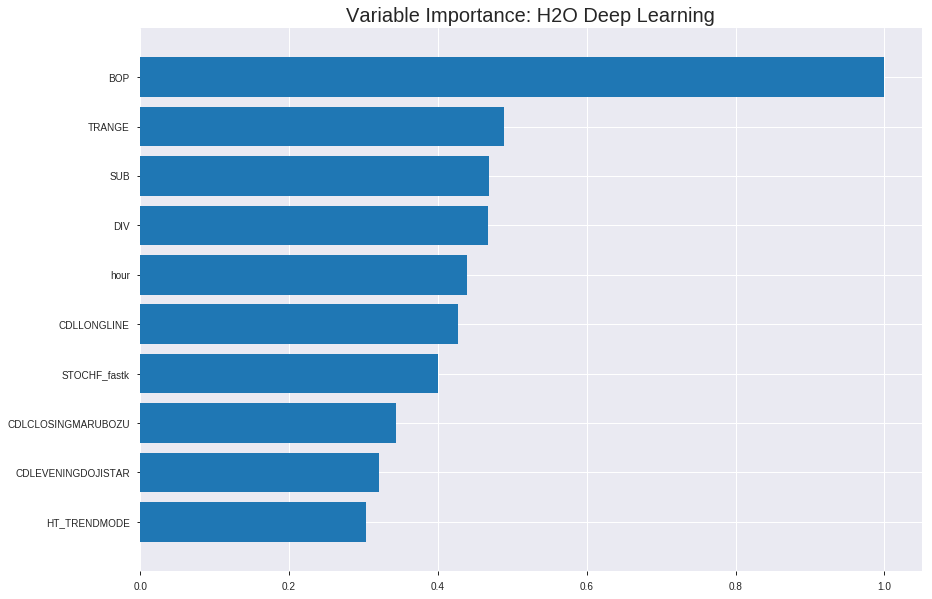

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190828_184202_model_2


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.2303484852879597
RMSE: 0.4799463358417894
LogLoss: 0.6643103319607084
Mean Per-Class Error: 0.3109998940247025
AUC: 0.7484197715719556
pr_auc: 0.678842916286064
Gini: 0.4968395431439112
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5553245335719162: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      435  408   0.484    (408.0/843.0)
1      99   595   0.1427   (99.0/694.0)
Total  534  1003  0.3299   (507.0/1537.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.555325     0.701237  214
max f2                       0.415549     0.822402  270
max f0point5                 0.745561     0.648806  120
max accuracy                 0.745561     0.680547  120
max precision                0.983372     1         0
max recall                   0.0544198    1         387
max specificity              0.983372     1         0
max absolute_mcc             0.555325     0.390215  214
max min_per_class_accuracy   0.689185     0.670225  151
max mean_per_class_accuracy  0.613307     0.689     188

Gains/Lift Table: Avg response rate: 45.15 %, avg score: 61.28 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104099                   0.96287            1.66102   1.66102            0.75             0.969892  0.75                        0.969892            0.0172911       0.0172911                  66.1023   66.1023
    2        0.0201692                   0.950659           2.06705   1.85749            0.933333         0.957224  0.83871                     0.963762            0.0201729       0.037464                   106.705   85.7488
    3        0.0305791                   0.943618           1.5226    1.74349            0.6875           0.946868  0.787234                    0.958011            0.0158501       0.0533141                  52.2604   74.3485
    4        0.0403383                   0.933213           2.2147    1.85749            1                0.938468  0.83871                     0.953283            0.0216138       0.074928                   121.47    85.7488
    5        0.0500976                   0.926793           1.9194    1.86955            0.866667         0.930372  0.844156                    0.94882             0.018732        0.0936599                  91.9404   86.955
    6        0.100195                    0.897697           1.66821   1.76888            0.753247         0.911531  0.798701                    0.930175            0.0835735       0.177233                   66.8214   76.8882
    7        0.150293                    0.870134           1.46688   1.66821            0.662338         0.884253  0.753247                    0.914868            0.073487        0.25072                    46.6878   66.8214
    8        0.20039                     0.846189           1.5244    1.63226            0.688312         0.85782   0.737013                    0.900606            0.0763689       0.327089                   52.4402   63.2261
    9        0.299935                    0.795007           1.24486   1.50369            0.562092         0.821737  0.678959                    0.87443             0.123919        0.451009                   24.4863   50.3688
    10       0.40013                     0.7413             1.35183   1.46566            0.61039          0.769762  0.661789                    0.848221            0.135447        0.586455                   35.1828   46.5662
    11       0.500325                    0.677629           1.03544   1.37951            0.467532         0.710012  0.622887                    0.820543            0.103746        0.690202                   3.54429   37.9506
    12       0.59987                     0.597073           1.14354   1.34035            0.51634          0.636646  0.605206                    0.790027            0.113833        0.804035                   14.3537   34.0348
    13       0.700065                    0.507007           0.819726  1.26584            0.37013          0.55449   0.571561                    0.756316            0.0821326       0.886167                   -18.0274  26.5835
    14       0.79961                     0.38006            0.622431  1.18574            0.281046         0.443375  0.535395                    0.717358            0.0619597       0.948127                   -37.7569  18.5737
    15       0.899805                    0.185969           0.302004  1.08733            0.136364         0.283431  0.490962                    0.669039            0.0302594       0.978386                   -69.7996  8.73316
    16       1                           4.79402e-05        0.215717  1                  0.0974026        0.107725  0.451529                    0.612798          



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.2112151960608451
RMSE: 0.45958154451723265
LogLoss: 0.6108718471084559
Mean Per-Class Error: 0.3033362598770851
AUC: 0.7410426857310088
pr_auc: 0.6805954478949088
Gini: 0.4820853714620177
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3999698358260771: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      122  116  0.4874   (116.0/238.0)
1      28   173  0.1393   (28.0/201.0)
Total  150  289  0.328    (144.0/439.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.39997      0.706122  255
max f2                       0.0711704    0.829208  370
max f0point5                 0.53109      0.659631  204
max accuracy                 0.53109      0.692483  204
max precision                0.979851     1         0
max recall                   0.0711704    1         370
max specificity              0.979851     1         0
max absolute_mcc             0.53109      0.392786  204
max min_per_class_accuracy   0.574301     0.676617  184
max mean_per_class_accuracy  0.53109      0.696664  204

Gains/Lift Table: Avg response rate: 45.79 %, avg score: 51.79 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113895                   0.93969            2.18408   2.18408            1                0.96141    1                           0.96141             0.0248756       0.0248756                  118.408   118.408
    2        0.0205011                   0.922817           2.18408   2.18408            1                0.930874   1                           0.947838            0.0199005       0.0447761                  118.408   118.408
    3        0.0318907                   0.907792           1.31045   1.87207            0.6              0.914983   0.857143                    0.936104            0.0149254       0.0597015                  31.0448   87.2068
    4        0.0410023                   0.895349           2.18408   1.9414             1                0.903335   0.888889                    0.928822            0.0199005       0.079602                   118.408   94.1404
    5        0.0501139                   0.882305           1.63806   1.88625            0.75             0.889039   0.863636                    0.921589            0.0149254       0.0945274                  63.806    88.6251
    6        0.100228                    0.846407           1.29059   1.58842            0.590909         0.865266   0.727273                    0.893427            0.0646766       0.159204                   29.0592   58.8422
    7        0.150342                    0.827482           1.48915   1.55533            0.681818         0.83488    0.712121                    0.873912            0.0746269       0.233831                   48.9145   55.5329
    8        0.200456                    0.792627           1.6877    1.58842            0.772727         0.809241   0.727273                    0.857744            0.0845771       0.318408                   68.7698   58.8422
    9        0.300683                    0.726112           1.24095   1.4726             0.568182         0.754715   0.674242                    0.823401            0.124378        0.442786                   24.0954   47.2599
    10       0.400911                    0.633378           1.34023   1.43951            0.613636         0.680364   0.659091                    0.787642            0.134328        0.577114                   34.0231   43.9507
    11       0.501139                    0.553782           1.24095   1.3998             0.568182         0.595058   0.640909                    0.749125            0.124378        0.701493                   24.0954   39.9796
    12       0.599089                    0.457193           0.965058  1.32872            0.44186          0.510606   0.608365                    0.710128            0.0945274       0.79602                    -3.49416  32.8718
    13       0.699317                    0.344054           0.794211  1.25211            0.363636         0.401585   0.57329                     0.665907            0.079602        0.875622                   -20.5789  25.2111
    14       0.799544                    0.237678           0.645296  1.17604            0.295455         0.294994   0.538462                    0.61941             0.0646766       0.940299                   -35.4704  17.6043
    15       0.899772                    0.118665           0.297829  1.07822            0.136364         0.1764     0.493671                    0.570062            0.0298507       0.970149                   -70.2171  7.82165
    16       1                           0.00117824         0.297829  1                  0.136364         0.0499203  0.457859                   


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 18:42:56  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-28 18:42:59  54.130 sec        442 obs/sec       0.642811  1             988        0.577928         3.25243             -0.348677      0.663488        0.418279           1.79944          0.422902                         0.584721           3.02867               -0.377378        0.686536          0.591311             2.18408            0.373576
    2019-08-28 18:43:09  1 min  4.138 sec  440 obs/sec       3.2648    5             5018       0.495484         0.801381            0.00866594     0.744523        0.684638           1.93786          0.327912                         0.584302           1.42064               -0.375405        0.673607          0.602336             1.74726            0.357631
    2019-08-28 18:43:18  1 min 13.783 sec  448 obs/sec       5.90111   9             9070       0.452583         0.598882            0.172901       0.748533        0.661272           1.5226           0.353286                         0.47449            0.644848              0.0929933        0.698305          0.610258             1.74726            0.364465
    2019-08-28 18:43:28  1 min 23.109 sec  457 obs/sec       8.54327   13            13131      0.460858         0.618421            0.142382       0.737648        0.670386           1.79944          0.362394                         0.491885           0.710009              0.0252727        0.676554          0.607593             2.18408            0.343964
    2019-08-28 18:43:37  1 min 32.041 sec  466 obs/sec       11.1757   17            17177      0.465808         0.629104            0.123859       0.751983        0.692539           1.79944          0.334418                         0.467238           0.62641               0.120505         0.70744           0.619483             1.74726            0.350797
    2019-08-28 18:43:46  1 min 40.991 sec  474 obs/sec       13.853    21            21292      0.445624         0.595938            0.198142       0.769982        0.700161           1.66102          0.304489                         0.479664           0.700036              0.0731049        0.722982          0.672625             2.18408            0.366743
    2019-08-28 18:43:54  1 min 49.474 sec  481 obs/sec       16.4671   25            25310      0.479946         0.66431             0.0698649      0.74842         0.678843           1.66102          0.329863                         0.459582           0.610872              0.149095         0.741043          0.680595             2.18408            0.328018
    2019-08-28 18:44:04  1 min 59.526 sec  489 obs/sec       19.6994   30            30278      0.464041         0.645757            0.130492       0.747344        0.685372           1.79944          0.343526                         0.471597           0.644768              0.10402          0.737238          0.673172             2.18408            0.33713
    2019-08-28 18:44:05 

Variable Importances: 


variable                 relative_importance    scaled_importance    percentage
-----------------------  ---------------------  -------------------  ---------------------
BOP                      1.0                    1.0                  0.006665539205047155
TRANGE                   0.4893505871295929     0.4893505871295929   0.0032617855235251452
SUB                      0.46832555532455444    0.46832555532455444  0.003121642349741298
DIV                      0.46752744913101196    0.46752744913101196  0.0031163225416184497
hour                     0.4385242164134979     0.4385242164134979   0.0029230003568667534
---                      ---                    ---                  ---
T3_8_0                   0.11540891230106354    0.11540891230106354  0.0007692626295545879
SUM_12                   0.1150413528084755     0.1150413528084755   0.000766812647346555
BBANDS_upperband_12_2_3  0.11025010049343109    0.11025010049343109  0.0007348763671993536
CDLXSIDEGAP3METHODS      0.10919255018234253    0.10919255018234253  0.000727827224139483
CDLTASUKIGAP             0.10233652591705322    0.10233652591705322  0.0006821281256084425


See the whole table with table.as_data_frame()


('accuracy', 0.7272727272727273)

('F1', 0.7259259259259259)

('auc', 0.7773088381330685)

('logloss', 0.5679916904911106)

('mean_per_class_error', 0.2720953326713009)

('rmse', 0.43993907058867765)

('mse', 0.19354638583042952)

deeplearning prediction progress: |███████████████████████████████████████| 100%


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


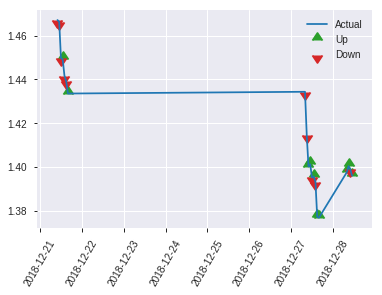


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.19354638583042952
RMSE: 0.43993907058867765
LogLoss: 0.5679916904911106
Mean Per-Class Error: 0.2720953326713009
AUC: 0.7773088381330685
pr_auc: 0.7306071974966806
Gini: 0.554617676266137
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3249888994614204: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      48   66   0.5789   (66.0/114.0)
1      8    98   0.0755   (8.0/106.0)
Total  56   164  0.3364   (74.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.324989     0.725926  163
max f2                       0.116814     0.851064  186
max f0point5                 0.660907     0.722749  78
max accuracy                 0.554624     0.727273  107
max precision                0.958572     1         0
max recall                   0.0507434    1         210
max specificity              0.958572     1         0
max absolute_mcc             0.545091     0.455583  111
max min_per_class_accuracy   0.554624     0.726415  107
max mean_per_class_accuracy  0.545091     0.727905  111

Gains/Lift Table: Avg response rate: 48.18 %, avg score: 50.49 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136364                   0.913436           2.07547   2.07547            1                0.94019    1                           0.94019             0.0283019       0.0283019                  107.547   107.547
    2        0.0227273                   0.906358           2.07547   2.07547            1                0.9108     1                           0.928434            0.0188679       0.0471698                  107.547   107.547
    3        0.0318182                   0.892636           2.07547   2.07547            1                0.899921   1                           0.920287            0.0188679       0.0660377                  107.547   107.547
    4        0.0409091                   0.882126           1.03774   1.84486            0.5              0.88573    0.888889                    0.912608            0.00943396      0.0754717                  3.77358   84.4864
    5        0.05                        0.878471           1.03774   1.69811            0.5              0.881003   0.818182                    0.906862            0.00943396      0.0849057                  3.77358   69.8113
    6        0.1                         0.838876           1.69811   1.69811            0.818182         0.857089   0.818182                    0.881975            0.0849057       0.169811                   69.8113   69.8113
    7        0.15                        0.789841           1.50943   1.63522            0.727273         0.815945   0.787879                    0.859965            0.0754717       0.245283                   50.9434   63.522
    8        0.2                         0.748134           1.50943   1.60377            0.727273         0.771272   0.772727                    0.837792            0.0754717       0.320755                   50.9434   60.3774
    9        0.3                         0.693466           1.60377   1.60377            0.772727         0.717713   0.772727                    0.797766            0.160377        0.481132                   60.3774   60.3774
    10       0.4                         0.648045           1.41509   1.5566             0.681818         0.671058   0.75                        0.766089            0.141509        0.622642                   41.5094   55.6604
    11       0.5                         0.549692           1.03774   1.45283            0.5              0.601449   0.7                         0.733161            0.103774        0.726415                   3.77358   45.283
    12       0.6                         0.464155           0.754717  1.33648            0.363636         0.506221   0.643939                    0.695337            0.0754717       0.801887                   -24.5283  33.6478
    13       0.7                         0.370619           0.754717  1.25337            0.363636         0.416768   0.603896                    0.655542            0.0754717       0.877358                   -24.5283  25.3369
    14       0.8                         0.21333            0.754717  1.19104            0.363636         0.293752   0.573864                    0.610318            0.0754717       0.95283                    -24.5283  19.1038
    15       0.9                         0.0780525          0.283019  1.09015            0.136364         0.120415   0.525253                    0.555884            0.0283019       0.981132                   -71.6981  9.01468
    16       1                           0.00520355         0.188679  1                  0.0909091        0.0459285  0.481818                    0

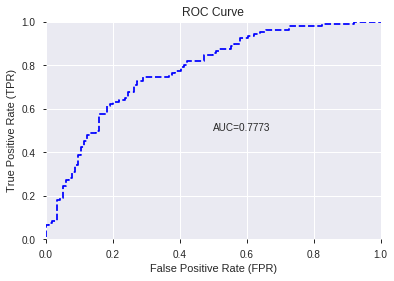

This function is available for GLM models only


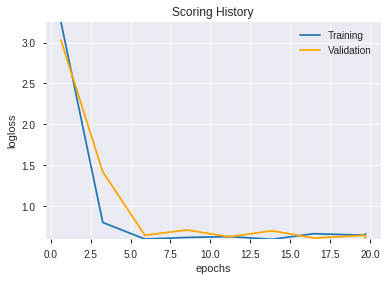

--2019-08-28 19:07:38--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.165.187
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.165.187|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


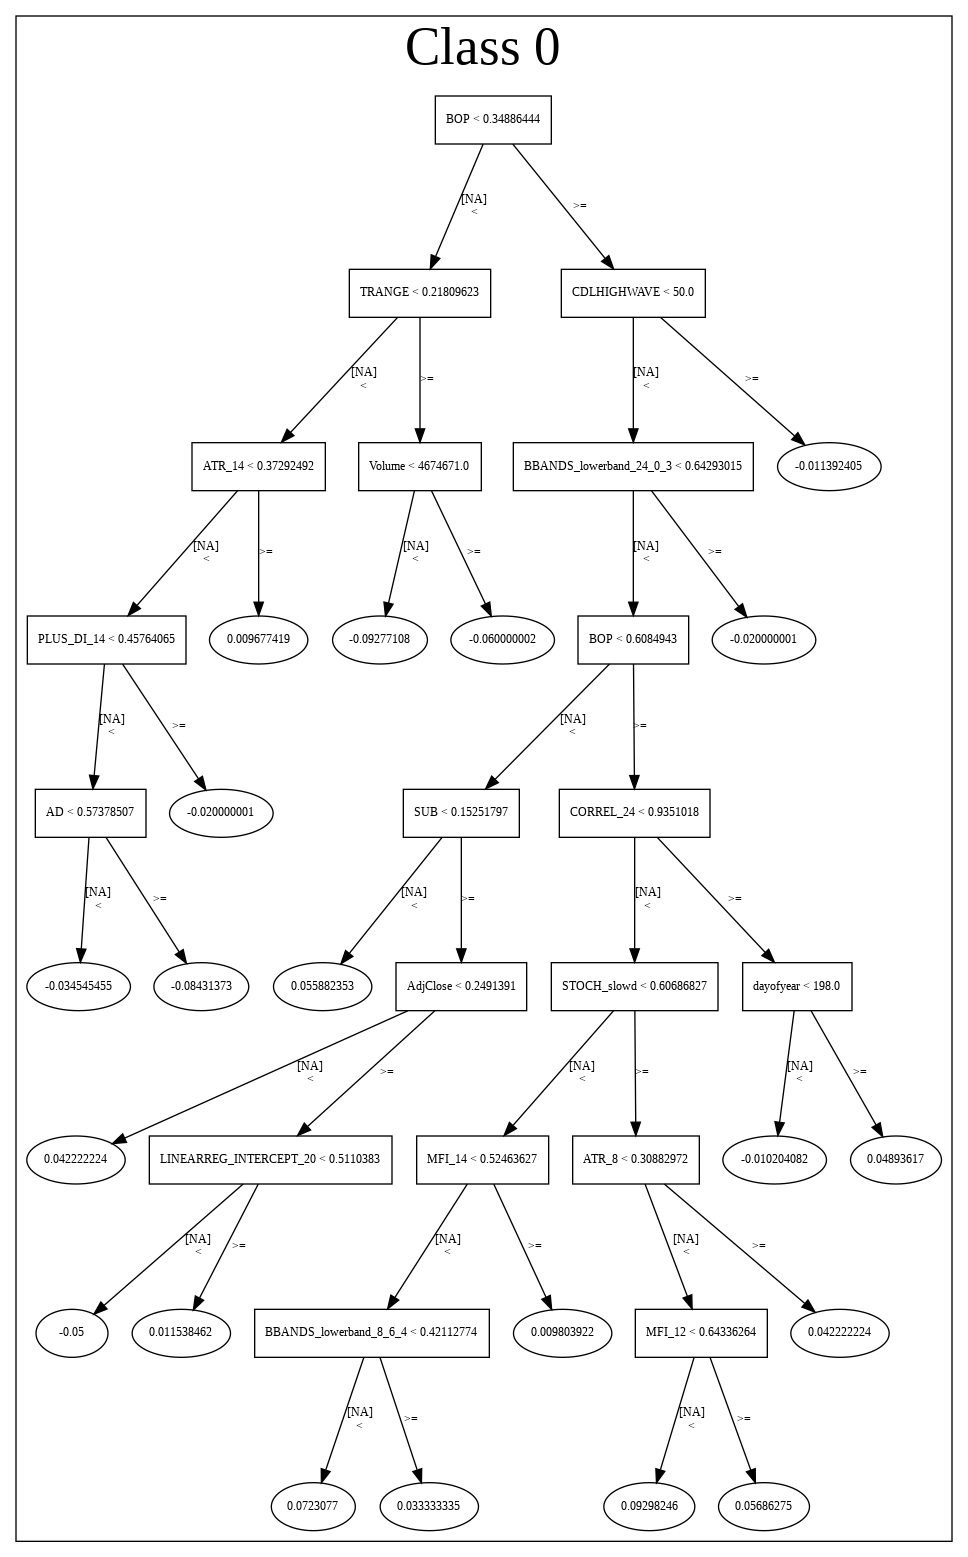

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190828_184202_model_2',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190828_184202_model_2',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_2_sid_8978',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl

In [11]:
# DeepLearning
features_list = model_train(feature_name='All',model_algo="DeepLearning")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190828_190835_model_8  0.775157  0.568710              0.270440  0.441821  0.195206
1  DeepLearning_grid_1_AutoML_20190828_190835_model_6  0.772675  0.605186              0.278219  0.445371  0.198355
2  DeepLearning_grid_1_AutoML_20190828_190835_model_9  0.762910  0.586808              0.307266  0.447510  0.200265
3  DeepLearning_grid_1_AutoML_20190828_190835_model_7  0.759599  0.609727              0.291377  0.454868  0.206905
4  DeepLearning_grid_1_AutoML_20190828_190835_model_5  0.756786  0.608284              0.278881  0.459617  0.211247
5  DeepLearning_grid_1_AutoML_20190828_190835_model_4  0.747766  0.794814              0.356256  0.484796  0.235027
6  DeepLearning_grid_1_AutoML_20190828_190835_model_3  0.735270  0.658691              0.328203  0.469608  0.220531
7  DeepLearning_grid_1_AutoML_20190828_190835_model_2  0.720953  0.682486              0.337637  0.480724  0.231095
8  DeepLearning_grid_1_AutoML_20190828_190835_model_1  0.719629  0.796144              0.356918  0.497425  0.247431
9               DeepLearning_1_AutoML_20190828_190835  0.691162  0.663112              0.391675  0.481280  0.231630

variable  relative_importance  scaled_importance  percentage
0                   BOP             1.000000           1.000000    0.040199
1                   SUB             0.624046           0.624046    0.025086
2                TRANGE             0.601097           0.601097    0.024163
3                   DIV             0.571967           0.571967    0.022992
4    CDLCLOSINGMARUBOZU             0.557768           0.557768    0.022421
5           CDLLONGLINE             0.544770           0.544770    0.021899
6          STOCHF_fastk             0.542080           0.542080    0.021791
7                   day             0.529144           0.529144    0.021271
8        CDLSPINNINGTOP             0.524056           0.524056    0.021066
9             aroonup_8             0.519266           0.519266    0.020874
10                CCI_8             0.518402           0.518402    0.020839
11                 hour             0.512457           0.512457    0.020600
12         CDLENGULFING             0.510450           0.510450    0.020519
13         weekday_name             0.497318           0.497318    0.019991
14             CORREL_8             0.496479           0.496479    0.019958
15           aroonup_12             0.494366           0.494366    0.019873
16            CDLHAMMER             0.489359           0.489359    0.019672
17            CDLTAKURI             0.487625           0.487625    0.019602
18              CDLDOJI             0.486316           0.486316    0.019549
19       CDLEVENINGSTAR             0.485038           0.485038    0.019498
20         HT_TRENDMODE             0.484754           0.484754    0.019486
21         aroondown_20             0.481874           0.481874    0.019371
22     CDLDRAGONFLYDOJI             0.481671           0.481671    0.019362
23  CDLGAPSIDESIDEWHITE             0.480015           0.480015    0.019296
24            PLUS_DM_8             0.478748           0.478748    0.019245
25            dayofweek             0.478285           0.478285    0.019226
26       STOCHRSI_fastd             0.477886           0.477886    0.019210
27       STOCHRSI_fastk             0.474230           0.474230    0.019063
28           PLUS_DI_24             0.472728           0.472728    0.019003
29                DX_30             0.470683           0.470683    0.018921
30               Volume             0.469714           0.469714    0.018882
31             WILLR_20             0.468805           0.468805    0.018845
32              weekday             0.466393           0.466393    0.018748
33         CDLSHORTLINE             0.466263           0.466263    0.018743
34           aroonup_24             0.465052           0.465052    0.018694
35   CDLEVENINGDOJISTAR             0.463482           0.463482    0.018631
36    CDL3WHITESOLDIERS             0.461554           0.461554    0.018554
37                DX_20             0.459401           0.459401    0.018467
38        CDLHIKKAKEMOD             0.458810           0.458810    0.018443
39              WILLR_8             0.458593           0.458593    0.018435
40               SAREXT             0.457416           0.457416    0.018387
41               ULTOSC             0.457303           0.457303    0.018383
42          HT_DCPERIOD             0.457171           0.457171    0.018378
43             WILLR_24             0.451749           0.451749    0.018160
44           aroonup_20             0.449173           0.449173    0.018056
45                  TAN             0.447558           0.447558    0.017991
46    CDLSTALLEDPATTERN             0.444614           0.444614    0.017873
47  CDLRISEFALL3METHODS             0.438930           0.438930    0.017644
48                DX_24             0.431177           0.431177    0.017333
49          CDLBELTHOLD             0.430492           0.430492    0.017305

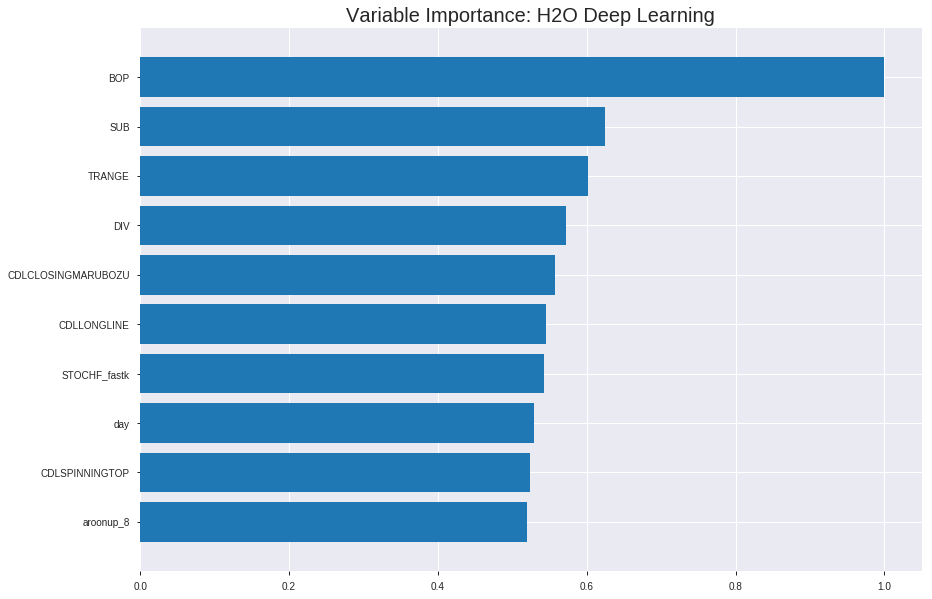

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190828_190835_model_8


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.18799745865426834
RMSE: 0.4335867371752373
LogLoss: 0.5501310321690853
Mean Per-Class Error: 0.2782543817366958
AUC: 0.7957642357300844
pr_auc: 0.7423894262813293
Gini: 0.5915284714601687
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.49611481829608195: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      454  389  0.4614   (389.0/843.0)
1      84   610  0.121    (84.0/694.0)
Total  538  999  0.3077   (473.0/1537.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.496115     0.720614  221
max f2                       0.352157     0.843206  281
max f0point5                 0.592847     0.699221  159
max accuracy                 0.588491     0.721535  162
max precision                0.955959     1         0
max recall                   0.032146     1         388
max specificity              0.955959     1         0
max absolute_mcc             0.542524     0.442079  192
max min_per_class_accuracy   0.550836     0.704626  185
max mean_per_class_accuracy  0.542524     0.721746  192

Gains/Lift Table: Avg response rate: 45.15 %, avg score: 51.45 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104099                   0.922425           2.2147     2.2147             1                0.935389   1                           0.935389            0.0230548       0.0230548                  121.47    121.47
    2        0.0201692                   0.90221            1.9194     2.07181            0.866667         0.910976   0.935484                    0.923577            0.018732        0.0417867                  91.9404   107.181
    3        0.0305791                   0.885298           1.79944    1.97909            0.8125           0.893152   0.893617                    0.913219            0.018732        0.0605187                  79.9442   97.9091
    4        0.0403383                   0.871675           1.9194     1.96465            0.866667         0.878556   0.887097                    0.904833            0.018732        0.0792507                  91.9404   96.4651
    5        0.0500976                   0.860222           1.9194     1.95584            0.866667         0.865866   0.883117                    0.897242            0.018732        0.0979827                  91.9404   95.5837
    6        0.100195                    0.810041           1.72574    1.84079            0.779221         0.833696   0.831169                    0.865469            0.0864553       0.184438                   72.5738   84.0787
    7        0.150293                    0.770606           1.78326    1.82161            0.805195         0.790874   0.822511                    0.840604            0.0893372       0.273775                   78.3263   82.1613
    8        0.20039                     0.722587           1.72574    1.79764            0.779221         0.746087   0.811688                    0.816975            0.0864553       0.360231                   72.5738   79.7644
    9        0.299935                    0.635492           1.33171    1.64301            0.601307         0.675002   0.741866                    0.769856            0.132565        0.492795                   33.1713   64.3008
    10       0.40013                     0.584913           1.40935    1.5845             0.636364         0.610207   0.715447                    0.729879            0.14121         0.634006                   40.9353   58.4499
    11       0.500325                    0.545555           0.977918   1.46303            0.441558         0.561501   0.660598                    0.696159            0.0979827       0.731988                   -2.20817  46.3025
    12       0.59987                     0.521245           0.940885   1.37638            0.424837         0.535657   0.621475                    0.669525            0.0936599       0.825648                   -5.91155  37.6379
    13       0.700065                    0.458959           0.848488   1.30083            0.383117         0.494337   0.587361                    0.644452            0.0850144       0.910663                   -15.1512  30.0826
    14       0.79961                     0.290198           0.607956   1.21457            0.27451          0.386226   0.548413                    0.612305            0.0605187       0.971182                   -39.2044  21.457
    15       0.899805                    0.105939           0.215717   1.10335            0.0974026        0.190737   0.498192                    0.565362            0.0216138       0.992795                   -78.4283  10.3345
    16       1                           0.000517786        0.0719058  1                  0.0324675        0.0576554  0.451529   



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.2033560353004933
RMSE: 0.4509501472452285
LogLoss: 0.5898454587624464
Mean Per-Class Error: 0.2990718675529913
AUC: 0.7569714452945357
pr_auc: 0.6902518508626749
Gini: 0.5139428905890715
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4989663605012245: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      134  104  0.437    (104.0/238.0)
1      36   165  0.1791   (36.0/201.0)
Total  170  269  0.3189   (140.0/439.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.498966     0.702128  241
max f2                       0.110487     0.835443  346
max f0point5                 0.586286     0.690449  154
max accuracy                 0.586286     0.708428  154
max precision                0.937633     1         0
max recall                   0.0480348    1         373
max specificity              0.937633     1         0
max absolute_mcc             0.586286     0.410015  154
max min_per_class_accuracy   0.545577     0.689076  197
max mean_per_class_accuracy  0.581084     0.700928  159

Gains/Lift Table: Avg response rate: 45.79 %, avg score: 49.58 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113895                   0.904166           1.74726   1.74726            0.8              0.917854   0.8                         0.917854            0.0199005       0.0199005                  74.7264   74.7264
    2        0.0205011                   0.888912           2.18408   1.9414             1                0.897769   0.888889                    0.908927            0.0199005       0.039801                   118.408   94.1404
    3        0.0318907                   0.875278           1.74726   1.87207            0.8              0.881096   0.857143                    0.898987            0.0199005       0.0597015                  74.7264   87.2068
    4        0.0410023                   0.859468           1.09204   1.69873            0.5              0.868674   0.777778                    0.892251            0.00995025      0.0696517                  9.20398   69.8729
    5        0.0501139                   0.845751           1.63806   1.6877             0.75             0.851966   0.772727                    0.884926            0.0149254       0.0845771                  63.806    68.7698
    6        0.100228                    0.787228           1.6877    1.6877             0.772727         0.819573   0.772727                    0.85225             0.0845771       0.169154                   68.7698   68.7698
    7        0.150342                    0.738559           1.48915   1.62151            0.681818         0.764449   0.742424                    0.822983            0.0746269       0.243781                   48.9145   62.1514
    8        0.200456                    0.690607           1.48915   1.58842            0.681818         0.716334   0.727273                    0.79632             0.0746269       0.318408                   48.9145   58.8422
    9        0.300683                    0.634293           1.73734   1.63806            0.795455         0.663487   0.75                        0.752043            0.174129        0.492537                   73.7336   63.806
    10       0.400911                    0.577081           1.24095   1.53878            0.568182         0.602729   0.704545                    0.714714            0.124378        0.616915                   24.0954   53.8783
    11       0.501139                    0.543298           0.794211  1.38987            0.363636         0.558004   0.636364                    0.683372            0.079602        0.696517                   -20.5789  38.9869
    12       0.599089                    0.510255           1.11744   1.34533            0.511628         0.529205   0.61597                     0.658166            0.109453        0.80597                    11.7436   34.5327
    13       0.699317                    0.425269           0.694934  1.25211            0.318182         0.46693    0.57329                     0.630758            0.0696517       0.875622                   -30.5066  25.2111
    14       0.799544                    0.257994           0.54602   1.1636             0.25             0.344505   0.532764                    0.594874            0.0547264       0.930348                   -45.398   16.3598
    15       0.899772                    0.0871768          0.54602   1.0948             0.25             0.161431   0.501266                    0.546592            0.0547264       0.985075                   -45.398   9.48045
    16       1                           0.00349089         0.148915  1                  0.0681818        0.0401123  0.457859                    


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 19:13:07  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-28 19:13:09  51.297 sec        658 obs/sec       0.629798  1             968        0.479822         0.664004            0.0703478      0.765571        0.70107            1.93786          0.287573                         0.496539           0.705931              0.0067399        0.754442          0.690268             1.31045            0.364465
    2019-08-28 19:13:18  1 min  0.310 sec  1017 obs/sec      6.37345   10            9796       0.433587         0.550131            0.240876       0.795764        0.742389           2.2147           0.307742                         0.45095            0.589845              0.180756         0.756971          0.690252             1.74726            0.318907
    2019-08-28 19:13:27  1 min  9.539 sec  1146 obs/sec      13.4483   21            20670      0.429359         0.540341            0.255606       0.812354        0.760926           2.2147           0.292778                         0.464052           0.632335              0.132461         0.731333          0.674211             2.18408            0.364465
    2019-08-28 19:13:36  1 min 18.070 sec  1225 obs/sec      20.5036   32            31514      0.414219         0.508682            0.307179       0.823569        0.773628           2.07628          0.27326                          0.46057            0.633018              0.14543          0.738754          0.66527              0.873632           0.353075
    2019-08-28 19:13:45  1 min 26.904 sec  1284 obs/sec      28.1835   44            43318      0.399244         0.473314            0.356369       0.843904        0.795324           2.07628          0.238777                         0.460684           0.647178              0.145006         0.752927          0.695375             1.74726            0.309795
    2019-08-28 19:13:53  1 min 35.453 sec  1332 obs/sec      35.9232   56            55214      0.404915         0.490897            0.337952       0.864283        0.823502           2.2147           0.235524                         0.461541           0.61684               0.141823         0.737019          0.66739              1.74726            0.339408
    2019-08-28 19:14:02  1 min 44.232 sec  1377 obs/sec      44.272    69            68046      0.376742         0.423319            0.426877       0.873642        0.833119           2.2147           0.237476                         0.471994           0.806336              0.102512         0.749875          0.675686             1.31045            0.312073
    2019-08-28 19:14:03  1 min 45.100 sec  1376 obs/sec      44.272    69            68046      0.433587         0.550131            0.240876       0.795764        0.742389           2.2147           0.307742                         0.45095            0.589845              0.180756         0.756971          0.690252             1.74726            0.318907

Variable Importances: 


variable             relative_importance    scaled_importance    percentage
-------------------  ---------------------  -------------------  --------------------
BOP                  1.0                    1.0                  0.040198540423853735
SUB                  0.6240458488464355     0.6240458488464355   0.025085732281191556
TRANGE               0.6010971069335938     0.6010971069335938   0.024163226351731598
DIV                  0.5719669461250305     0.5719669461250305   0.022992236404915208
CDLCLOSINGMARUBOZU   0.5577681660652161     0.5577681660652161   0.02242146617071135
---                  ---                    ---                  ---
TAN                  0.4475577175617218     0.4475577175617218   0.017991167001412584
CDLSTALLEDPATTERN    0.4446144998073578     0.4446144998073578   0.01787285394353758
CDLRISEFALL3METHODS  0.43892961740493774    0.43892961740493774  0.017644329968479044
DX_24                0.43117666244506836    0.43117666244506836  0.017332672495120417
CDLBELTHOLD          0.43049222230911255    0.43049222230911255  0.01730515900064749


See the whole table with table.as_data_frame()


('accuracy', 0.7272727272727273)

('F1', 0.7368421052631579)

('auc', 0.7751572327044025)

('logloss', 0.5687102242993737)

('mean_per_class_error', 0.270440251572327)

('rmse', 0.4418212153533709)

('mse', 0.19520598633632974)

deeplearning prediction progress: |███████████████████████████████████████| 100%


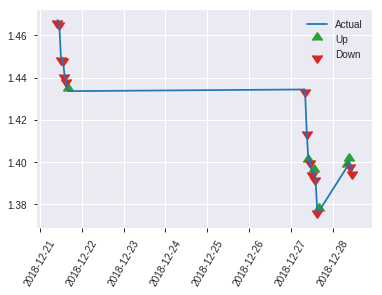


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.19520598633632974
RMSE: 0.4418212153533709
LogLoss: 0.5687102242993737
Mean Per-Class Error: 0.270440251572327
AUC: 0.7751572327044025
pr_auc: 0.7530267821348526
Gini: 0.550314465408805
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5318452932845145: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      76   38   0.3333   (38.0/114.0)
1      22   84   0.2075   (22.0/106.0)
Total  98   122  0.2727   (60.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.531845     0.736842  121
max f2                       0.141702     0.85124   180
max f0point5                 0.531845     0.707071  121
max accuracy                 0.531845     0.727273  121
max precision                0.92475      1         0
max recall                   0.0549785    1         206
max specificity              0.92475      1         0
max absolute_mcc             0.531845     0.461571  121
max min_per_class_accuracy   0.54766      0.688679  107
max mean_per_class_accuracy  0.531845     0.72956   121

Gains/Lift Table: Avg response rate: 48.18 %, avg score: 49.33 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136364                   0.909392           2.07547   2.07547            1                0.916356   1                           0.916356            0.0283019       0.0283019                  107.547   107.547
    2        0.0227273                   0.895617           2.07547   2.07547            1                0.899408   1                           0.909577            0.0188679       0.0471698                  107.547   107.547
    3        0.0318182                   0.875542           2.07547   2.07547            1                0.88426    1                           0.902343            0.0188679       0.0660377                  107.547   107.547
    4        0.0409091                   0.856877           2.07547   2.07547            1                0.87428    1                           0.896107            0.0188679       0.0849057                  107.547   107.547
    5        0.05                        0.847007           2.07547   2.07547            1                0.850557   1                           0.887825            0.0188679       0.103774                   107.547   107.547
    6        0.1                         0.797952           1.69811   1.88679            0.818182         0.821912   0.909091                    0.854869            0.0849057       0.188679                   69.8113   88.6792
    7        0.15                        0.756345           1.50943   1.76101            0.727273         0.777268   0.848485                    0.829002            0.0754717       0.264151                   50.9434   76.1006
    8        0.2                         0.707826           1.13208   1.60377            0.545455         0.732881   0.772727                    0.804971            0.0566038       0.320755                   13.2075   60.3774
    9        0.3                         0.61864            1.41509   1.54088            0.681818         0.664156   0.742424                    0.758033            0.141509        0.462264                   41.5094   54.0881
    10       0.4                         0.572574           1.41509   1.50943            0.681818         0.595649   0.727273                    0.717437            0.141509        0.603774                   41.5094   50.9434
    11       0.5                         0.546018           0.943396  1.39623            0.454545         0.558478   0.672727                    0.685645            0.0943396       0.698113                   -5.66038  39.6226
    12       0.6                         0.504576           1.13208   1.3522             0.545455         0.528907   0.651515                    0.659522            0.113208        0.811321                   13.2075   35.2201
    13       0.7                         0.430001           0.566038  1.23989            0.272727         0.476807   0.597403                    0.63342             0.0566038       0.867925                   -43.3962  23.9892
    14       0.8                         0.203652           0.849057  1.19104            0.409091         0.33523    0.573864                    0.596146            0.0849057       0.95283                    -15.0943  19.1038
    15       0.9                         0.0694267          0.283019  1.09015            0.136364         0.122632   0.525253                    0.543533            0.0283019       0.981132                   -71.6981  9.01468
    16       1                           0.00487053         0.188679  1                  0.0909091        0.0414548  0.481818                   

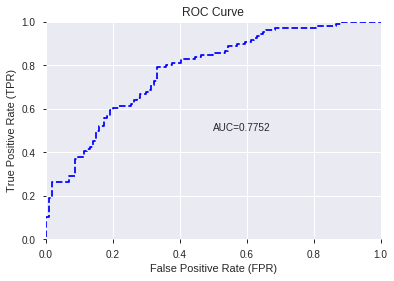

This function is available for GLM models only


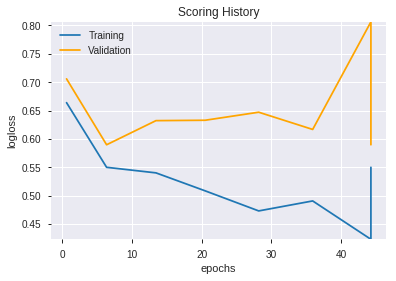

--2019-08-28 19:15:09--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.144.187
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.144.187|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


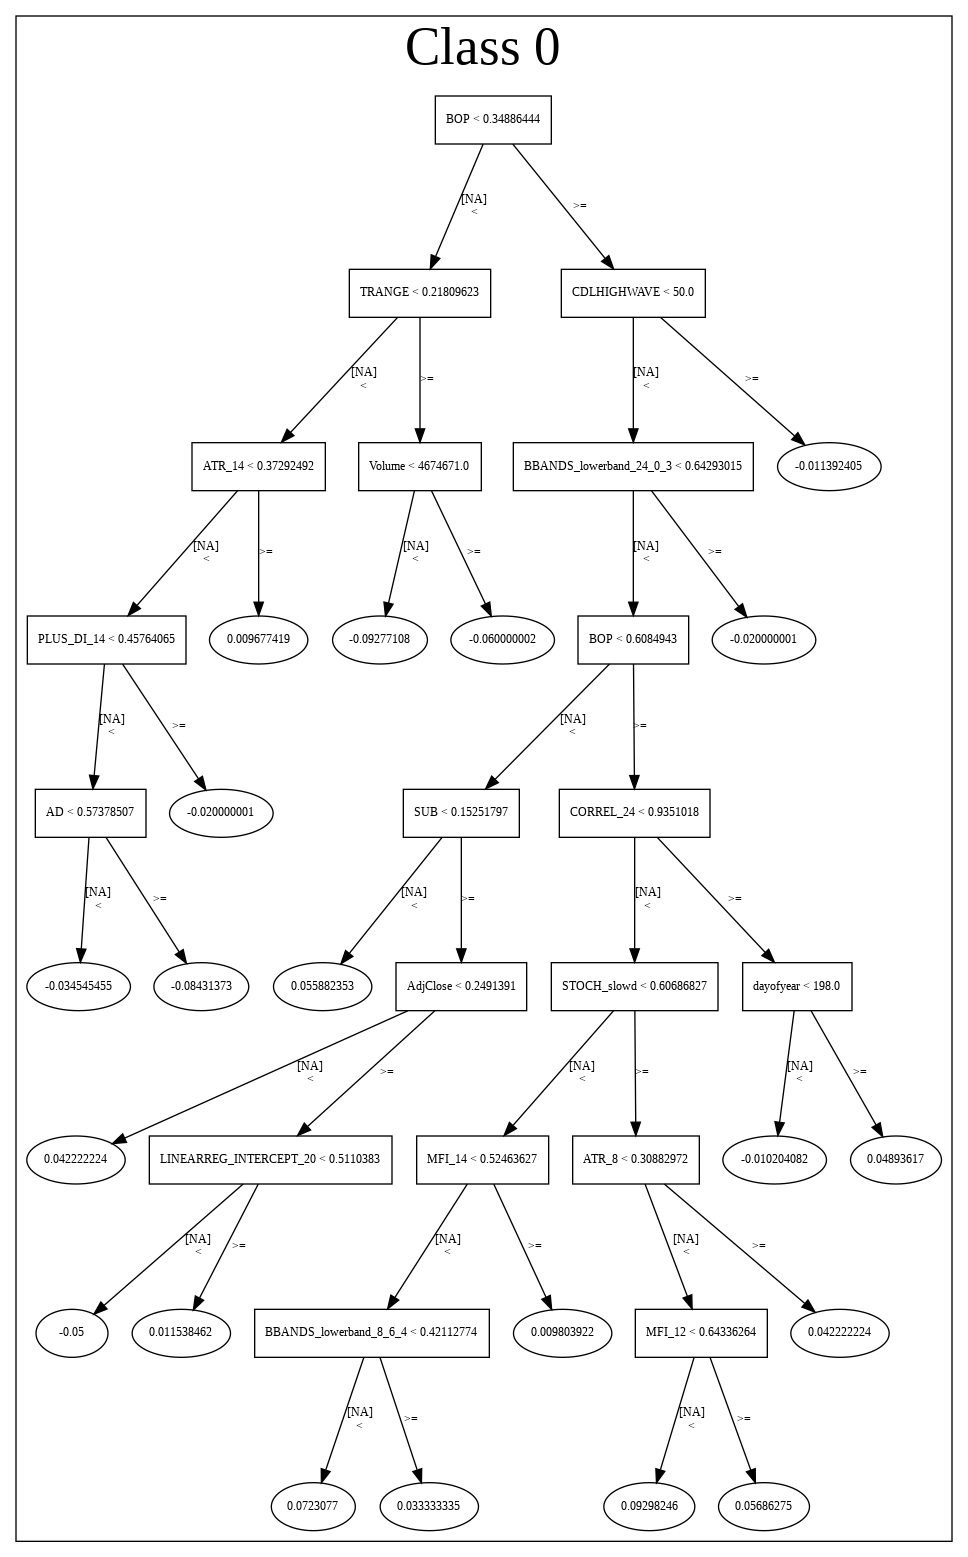

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190828_190835_model_8',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190828_190835_model_8',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_10_sid_8978',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['BOP',
 'SUB',
 'TRANGE',
 'DIV',
 'CDLCLOSINGMARUBOZU',
 'CDLLONGLINE',
 'STOCHF_fastk',
 'day',
 'CDLSPINNINGTOP',
 'aroonup_8',
 'CCI_8',
 'hour',
 'CDLENGULFING',
 'weekday_name',
 'CORREL_8',
 'aroonup_12',
 'CDLHAMMER',
 'CDLTAKURI',
 'CDLDOJI',
 'CDLEVENINGSTAR',
 'HT_TRENDMODE',
 'aroondown_20',
 'CDLDRAGONFLYDOJI',
 'CDLGAPSIDESIDEWHITE',
 'PLUS_DM_8',
 'dayofweek',
 'STOCHRSI_fastd',
 'STOCHRSI_fastk',
 'PLUS_DI_24',
 'DX_30',
 'Volume',
 'WILLR_20',
 'weekday',
 'CDLSHORTLINE',
 'aroonup_24',
 'CDLEVENINGDOJISTAR',
 'CDL3WHITESOLDIERS',
 'DX_20',
 'CDLHIKKAKEMOD',
 'WILLR_8',
 'SAREXT',
 'ULTOSC',
 'HT_DCPERIOD',
 'WILLR_24',
 'aroonup_20',
 'TAN',
 'CDLSTALLEDPATTERN',
 'CDLRISEFALL3METHODS',
 'DX_24',
 'CDLBELTHOLD']

In [12]:
# DeepLearning with top DeepLearning features
model_train(feature_name='DLF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse      mse
0  GLM_grid_1_AutoML_20190828_191606_model_1  0.780122  0.569868              0.282274  0.439352  0.19303

variable  relative_importance  scaled_importance  percentage
0                 DX_24             1.347425           1.000000    0.108304
1             CDLTAKURI             1.111440           0.824862    0.089336
2                   SUB             1.066510           0.791517    0.085725
3                   BOP             0.942235           0.699285    0.075736
4      CDLDRAGONFLYDOJI             0.924953           0.686460    0.074347
5                 DX_20             0.771344           0.572458    0.062000
6                 DX_30             0.631486           0.468661    0.050758
7              WILLR_24             0.538712           0.399808    0.043301
8          STOCHF_fastk             0.529617           0.393058    0.042570
9                   DIV             0.491002           0.364400    0.039466
10    CDL3WHITESOLDIERS             0.319666           0.237242    0.025694
11                CCI_8             0.312430           0.231872    0.025113
12              WILLR_8             0.311217           0.230971    0.025015
13           aroonup_12             0.192440           0.142821    0.015468
14  CDLGAPSIDESIDEWHITE             0.181893           0.134993    0.014620
15  CDLRISEFALL3METHODS             0.174610           0.129588    0.014035
16               ULTOSC             0.167935           0.124634    0.013498
17           aroonup_24             0.159805           0.118601    0.012845
18           PLUS_DI_24             0.152386           0.113094    0.012249
19                 hour             0.149530           0.110974    0.012019
20         aroondown_20             0.146391           0.108645    0.011767
21            aroonup_8             0.129920           0.096421    0.010443
22            CDLHAMMER             0.128705           0.095519    0.010345
23          CDLBELTHOLD             0.126667           0.094007    0.010181
24             CORREL_8             0.122588           0.090979    0.009853
25   CDLEVENINGDOJISTAR             0.122090           0.090610    0.009813
26       STOCHRSI_fastk             0.121412           0.090106    0.009759
27       CDLEVENINGSTAR             0.114091           0.084674    0.009171
28         CDLSHORTLINE             0.111568           0.082801    0.008968
29         HT_TRENDMODE             0.106750           0.079225    0.008580
30             WILLR_20             0.080388           0.059661    0.006462
31   CDLCLOSINGMARUBOZU             0.077428           0.057463    0.006224
32         CDLENGULFING             0.065705           0.048763    0.005281
33               Volume             0.063777           0.047333    0.005126
34                  day             0.054744           0.040629    0.004400
35         weekday_name             0.053544           0.039738    0.004304
36        CDLHIKKAKEMOD             0.048352           0.035885    0.003887
37               SAREXT             0.045324           0.033638    0.003643
38            PLUS_DM_8             0.040275           0.029890    0.003237
39       CDLSPINNINGTOP             0.034135           0.025333    0.002744
40    CDLSTALLEDPATTERN             0.027643           0.020515    0.002222
41                  TAN             0.026082           0.019357    0.002096
42          HT_DCPERIOD             0.024582           0.018244    0.001976
43              CDLDOJI             0.023644           0.017547    0.001900
44            dayofweek             0.018069           0.013410    0.001452
45               TRANGE             0.016723           0.012411    0.001344
46              weekday             0.014492           0.010756    0.001165
47       STOCHRSI_fastd             0.010328           0.007665    0.000830
48          CDLLONGLINE             0.006147           0.004562    0.000494
49           aroonup_20             0.002902           0.002154    0.000233

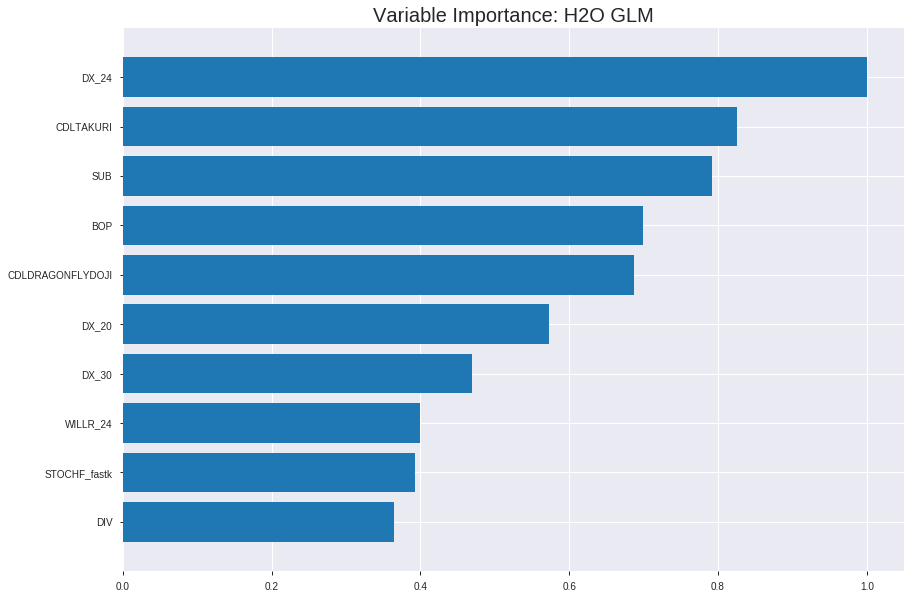

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190828_191606_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.18556845281975196
RMSE: 0.43077656948788656
LogLoss: 0.546991658842633
Null degrees of freedom: 1536
Residual degrees of freedom: 1486
Null deviance: 2116.267351263065
Residual deviance: 1681.4523592822538
AIC: 1783.4523592822538
AUC: 0.7906722936131081
pr_auc: 0.7194535438953699
Gini: 0.5813445872262162
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.28199674815935694: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      404  439   0.5208   (439.0/843.0)
1      62   632   0.0893   (62.0/694.0)
Total  466  1071  0.326    (501.0/1537.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.281997     0.716147  280
max f2                       0.156959     0.838456  333
max f0point5                 0.491206     0.693567  187
max accuracy                 0.491206     0.723487  187
max precision                0.999832     1         0
max recall                   0.03615      1         388
max specificity              0.999832     1         0
max absolute_mcc             0.449502     0.445233  208
max min_per_class_accuracy   0.470224     0.717675  198
max mean_per_class_accuracy  0.449502     0.723649  208

Gains/Lift Table: Avg response rate: 45.15 %, avg score: 45.15 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104099                   0.910808           1.93786    1.93786            0.875            0.944483   0.875                       0.944483            0.0201729       0.0201729                  93.786    93.786
    2        0.0201692                   0.887403           1.47646    1.7146             0.666667         0.899267   0.774194                    0.922605            0.0144092       0.0345821                  47.6465   71.4604
    3        0.0305791                   0.871863           1.66102    1.69636            0.75             0.879067   0.765957                    0.907783            0.0172911       0.0518732                  66.1023   69.6364
    4        0.0403383                   0.860088           2.06705    1.78605            0.933333         0.866137   0.806452                    0.897708            0.0201729       0.0720461                  106.705   78.6046
    5        0.0500976                   0.846081           2.06705    1.84079            0.933333         0.852917   0.831169                    0.888982            0.0201729       0.092219                   106.705   84.0787
    6        0.100195                    0.79573            1.78326    1.81203            0.805195         0.818798   0.818182                    0.85389             0.0893372       0.181556                   78.3263   81.2025
    7        0.150293                    0.744007           1.72574    1.78326            0.779221         0.769272   0.805195                    0.825684            0.0864553       0.268012                   72.5738   78.3263
    8        0.20039                     0.701678           1.55316    1.72574            0.701299         0.721978   0.779221                    0.799757            0.0778098       0.345821                   55.3164   72.5738
    9        0.299935                    0.624083           1.49094    1.64781            0.673203         0.661538   0.744035                    0.753884            0.148415        0.494236                   49.094    64.7812
    10       0.40013                     0.547053           1.2943     1.55929            0.584416         0.581726   0.704065                    0.710775            0.129683        0.623919                   29.4304   55.9291
    11       0.500325                    0.452402           1.17925    1.48318            0.532468         0.498253   0.669701                    0.668215            0.118156        0.742075                   17.9254   48.3185
    12       0.59987                     0.355634           0.839558   1.37638            0.379085         0.406495   0.621475                    0.624784            0.0835735       0.825648                   -16.0442  37.6379
    13       0.700065                    0.277286           0.862869   1.30288            0.38961          0.31716    0.58829                     0.580756            0.0864553       0.912104                   -13.7131  30.2884
    14       0.79961                     0.194171           0.50663    1.20376            0.228758         0.23604    0.543531                    0.537842            0.0504323       0.962536                   -49.337   20.3757
    15       0.899805                    0.112618           0.287623   1.10174            0.12987          0.14849    0.497469                    0.494487            0.0288184       0.991354                   -71.2377  10.1744
    16       1                           6.87975e-05        0.0862869  1                  0.038961         0.0657483  0.451529  



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.20029775239883393
RMSE: 0.44754636899301725
LogLoss: 0.5803743037361818
Null degrees of freedom: 438
Residual degrees of freedom: 388
Null deviance: 605.5320386942669
Residual deviance: 509.5686386803677
AIC: 611.5686386803677
AUC: 0.7554768175927087
pr_auc: 0.6953459404732828
Gini: 0.5109536351854174
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2846651236600519: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      113  125  0.5252   (125.0/238.0)
1      28   173  0.1393   (28.0/201.0)
Total  141  298  0.3485   (153.0/439.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.284665     0.693387  272
max f2                       0.161155     0.834746  339
max f0point5                 0.473717     0.665072  190
max accuracy                 0.473717     0.694761  190
max precision                0.991431     1         0
max recall                   0.102826     1         362
max specificity              0.991431     1         0
max absolute_mcc             0.432323     0.388712  212
max min_per_class_accuracy   0.473717     0.691542  190
max mean_per_class_accuracy  0.456657     0.69473   201

Gains/Lift Table: Avg response rate: 45.79 %, avg score: 44.57 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113895                   0.858636           1.74726    1.74726            0.8              0.913861   0.8                         0.913861            0.0199005       0.0199005                  74.7264   74.7264
    2        0.0205011                   0.844617           1.63806    1.69873            0.75             0.849258   0.777778                    0.885148            0.0149254       0.0348259                  63.806    69.8729
    3        0.0318907                   0.827166           1.74726    1.71606            0.8              0.834061   0.785714                    0.866903            0.0199005       0.0547264                  74.7264   71.6063
    4        0.0410023                   0.812753           2.18408    1.82007            1                0.820002   0.833333                    0.85648             0.0199005       0.0746269                  118.408   82.0066
    5        0.0501139                   0.801358           1.63806    1.78697            0.75             0.809313   0.818182                    0.847904            0.0149254       0.0895522                  63.806    78.6974
    6        0.100228                    0.758085           1.58842    1.6877             0.727273         0.78041    0.772727                    0.814157            0.079602        0.169154                   58.8422   68.7698
    7        0.150342                    0.725351           1.58842    1.65461            0.727273         0.744054   0.757576                    0.79079             0.079602        0.248756                   58.8422   65.4606
    8        0.200456                    0.687695           1.58842    1.63806            0.727273         0.707502   0.75                        0.769968            0.079602        0.328358                   58.8422   63.806
    9        0.300683                    0.611151           1.38987    1.55533            0.636364         0.650234   0.712121                    0.730057            0.139303        0.467662                   38.9869   55.5329
    10       0.400911                    0.524684           1.19132    1.46433            0.545455         0.580526   0.670455                    0.692674            0.119403        0.587065                   19.1316   46.4326
    11       0.501139                    0.463243           1.19132    1.40972            0.545455         0.493164   0.645455                    0.652772            0.119403        0.706468                   19.1316   40.9724
    12       0.599089                    0.367914           0.863473   1.32041            0.395349         0.41286    0.604563                    0.613547            0.0845771       0.791045                   -13.6527  32.0413
    13       0.699317                    0.266076           0.794211   1.245              0.363636         0.319005   0.570033                    0.571332            0.079602        0.870647                   -20.5789  24.4997
    14       0.799544                    0.199507           0.744573   1.18227            0.340909         0.231982   0.541311                    0.528793            0.0746269       0.945274                   -25.5427  18.2265
    15       0.899772                    0.111637           0.446744   1.10033            0.204545         0.160588   0.503797                    0.487777            0.0447761       0.99005                    -55.3256  10.0334
    16       1                           0.00017574         0.0992763  1                  0.0454545        0.0675667  0.457859  


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------  -----------  --------  ------------  ------------------  ------------------
     2019-08-28 19:16:06  0.000 sec   2            .2E2      51            1.3580199763650125  1.3628286456206826
     2019-08-28 19:16:06  0.008 sec   4            .13E2     51            1.3479627808625525  1.3540850118198777
     2019-08-28 19:16:06  0.015 sec   6            .78E1     51            1.3336015486950712  1.3416768701251234
     2019-08-28 19:16:06  0.022 sec   8            .48E1     51            1.3142290681565039  1.3250880206907363
     2019-08-28 19:16:06  0.030 sec   10           .3E1      51            1.2898571681581144  1.304495902705659
---  ---                  ---         ---          ---       ---           ---                 ---
     2019-08-28 19:16:06  0.191 sec   48           .14E-3    51            1.0941985074848952  1.1618348937614484
     2019-08-28 19:16:06  0.196 sec   49           .84E-4    51            1.0940967751630488  1.1613578694088966
     2019-08-28 19:16:06  0.202 sec   50           .52E-4    51            1.0940359174011542  1.161049281524119
     2019-08-28 19:16:06  0.208 sec   51           .32E-4    51            1.0940020283316327  1.1608681035308346
     2019-08-28 19:16:06  0.213 sec   52           .2E-4     51            1.093983317685266   1.1607486074723639


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7227272727272728)

('F1', 0.7364016736401673)

('auc', 0.7801224760013241)

('logloss', 0.5698676437658208)

('mean_per_class_error', 0.2801224760013241)

('rmse', 0.4393519309392769)

('mse', 0.1930301192200711)

glm prediction progress: |████████████████████████████████████████████████| 100%


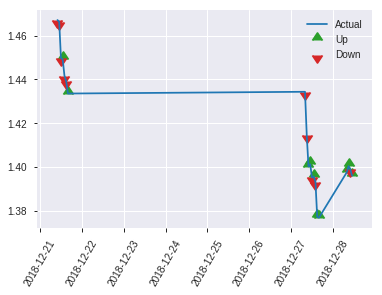


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.1930301192200711
RMSE: 0.4393519309392769
LogLoss: 0.5698676437658208
Null degrees of freedom: 219
Residual degrees of freedom: 169
Null deviance: 305.5060851051157
Residual deviance: 250.74176325696115
AIC: 352.7417632569611
AUC: 0.7801224760013241
pr_auc: 0.7287351535540179
Gini: 0.5602449520026482
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3545312389570052: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      69   45   0.3947   (45.0/114.0)
1      18   88   0.1698   (18.0/106.0)
Total  87   133  0.2864   (63.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.354531     0.736402  132
max f2                       0.108088     0.842697  198
max f0point5                 0.574134     0.732558  80
max accuracy                 0.574134     0.722727  80
max precision                0.91986      1         0
max recall                   0.0576821    1         210
max specificity              0.91986      1         0
max absolute_mcc             0.574134     0.452152  80
max min_per_class_accuracy   0.473261     0.684211  108
max mean_per_class_accuracy  0.528218     0.719878  90

Gains/Lift Table: Avg response rate: 48.18 %, avg score: 44.41 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136364                   0.892597           1.38365   1.38365            0.666667         0.91043    0.666667                    0.91043             0.0188679       0.0188679                  38.3648   38.3648
    2        0.0227273                   0.867512           2.07547   1.66038            1                0.87793    0.8                         0.89743             0.0188679       0.0377358                  107.547   66.0377
    3        0.0318182                   0.845726           2.07547   1.77898            1                0.8575     0.857143                    0.886021            0.0188679       0.0566038                  107.547   77.8976
    4        0.0409091                   0.836263           1.03774   1.61426            0.5              0.837448   0.777778                    0.875227            0.00943396      0.0660377                  3.77358   61.4256
    5        0.05                        0.82131            2.07547   1.69811            1                0.83011    0.818182                    0.867024            0.0188679       0.0849057                  107.547   69.8113
    6        0.1                         0.760495           1.69811   1.69811            0.818182         0.78988    0.818182                    0.828452            0.0849057       0.169811                   69.8113   69.8113
    7        0.15                        0.725819           1.69811   1.69811            0.818182         0.743406   0.818182                    0.800103            0.0849057       0.254717                   69.8113   69.8113
    8        0.2                         0.676973           1.69811   1.69811            0.818182         0.701345   0.818182                    0.775414            0.0849057       0.339623                   69.8113   69.8113
    9        0.3                         0.619007           1.50943   1.63522            0.727273         0.646748   0.787879                    0.732525            0.150943        0.490566                   50.9434   63.522
    10       0.4                         0.541597           1.32075   1.5566             0.636364         0.583907   0.75                        0.695371            0.132075        0.622642                   32.0755   55.6604
    11       0.5                         0.471039           0.754717  1.39623            0.363636         0.504721   0.672727                    0.657241            0.0754717       0.698113                   -24.5283  39.6226
    12       0.6                         0.356891           1.22642   1.36792            0.590909         0.414927   0.659091                    0.616855            0.122642        0.820755                   22.6415   36.7925
    13       0.7                         0.250583           0.566038  1.25337            0.272727         0.305872   0.603896                    0.572429            0.0566038       0.877358                   -43.3962  25.3369
    14       0.8                         0.194206           0.660377  1.17925            0.318182         0.221301   0.568182                    0.528538            0.0660377       0.943396                   -33.9623  17.9245
    15       0.9                         0.118959           0.377358  1.09015            0.181818         0.155088   0.525253                    0.487044            0.0377358       0.981132                   -62.2642  9.01468
    16       1                           0.00925335         0.188679  1                  0.0909091        0.0578666  0.481818                    

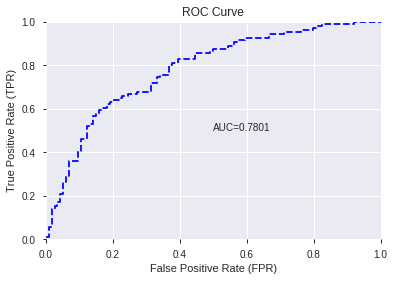

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


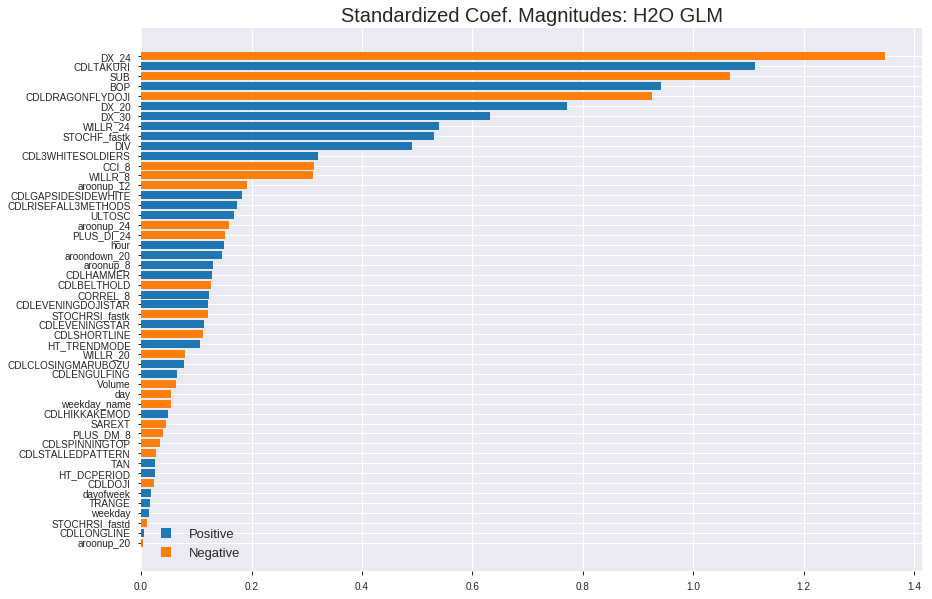

'log_likelihood'
--2019-08-28 19:16:16--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.162.187
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.162.187|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


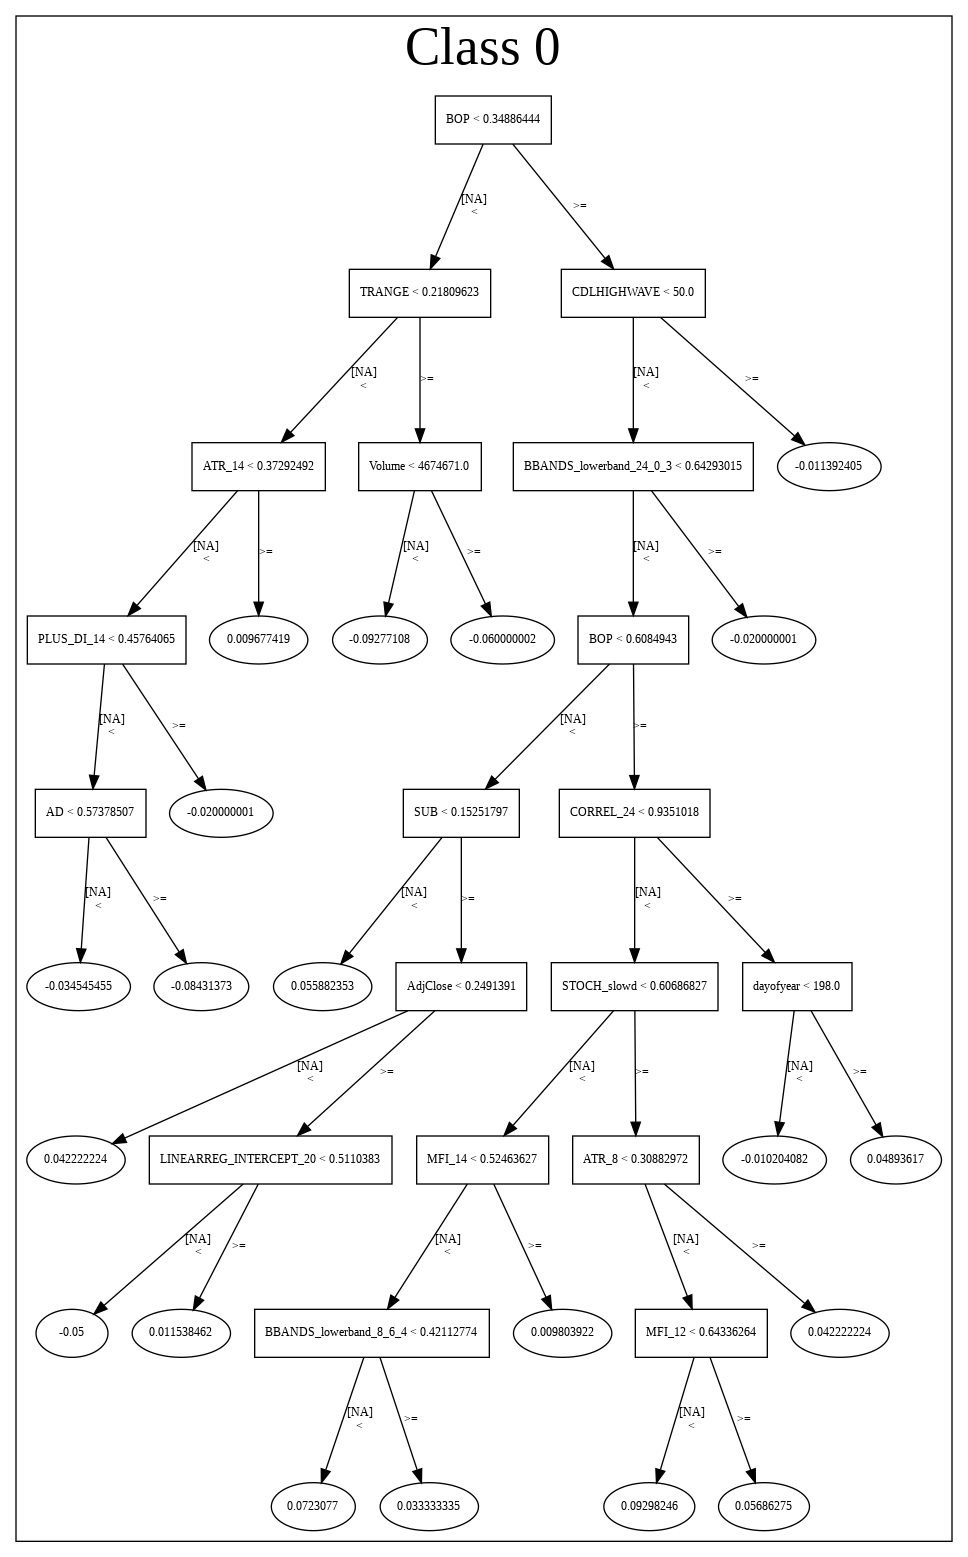

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190828_191606_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190828_191606_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_18_sid_8978',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_18_s

['DX_24',
 'CDLTAKURI',
 'SUB',
 'BOP',
 'CDLDRAGONFLYDOJI',
 'DX_20',
 'DX_30',
 'WILLR_24',
 'STOCHF_fastk',
 'DIV',
 'CDL3WHITESOLDIERS',
 'CCI_8',
 'WILLR_8',
 'aroonup_12',
 'CDLGAPSIDESIDEWHITE',
 'CDLRISEFALL3METHODS',
 'ULTOSC',
 'aroonup_24',
 'PLUS_DI_24',
 'hour',
 'aroondown_20',
 'aroonup_8',
 'CDLHAMMER',
 'CDLBELTHOLD',
 'CORREL_8',
 'CDLEVENINGDOJISTAR',
 'STOCHRSI_fastk',
 'CDLEVENINGSTAR',
 'CDLSHORTLINE',
 'HT_TRENDMODE',
 'WILLR_20',
 'CDLCLOSINGMARUBOZU',
 'CDLENGULFING',
 'Volume',
 'day',
 'weekday_name',
 'CDLHIKKAKEMOD',
 'SAREXT',
 'PLUS_DM_8',
 'CDLSPINNINGTOP',
 'CDLSTALLEDPATTERN',
 'TAN',
 'HT_DCPERIOD',
 'CDLDOJI',
 'dayofweek',
 'TRANGE',
 'weekday',
 'STOCHRSI_fastd',
 'CDLLONGLINE',
 'aroonup_20']

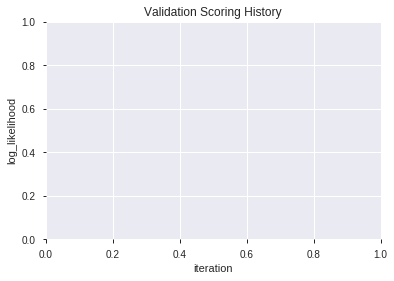

In [13]:
# GLM with top DeepLearning features
model_train(feature_name='DLF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190828_191713_model_3  0.775819  0.569132              0.271516  0.440521  0.194059
1               XGBoost_3_AutoML_20190828_191713  0.766468  0.574038              0.279626  0.442239  0.195575
2  XGBoost_grid_1_AutoML_20190828_191713_model_5  0.765889  0.593448              0.276895  0.449757  0.202281
3  XGBoost_grid_1_AutoML_20190828_191713_model_2  0.759930  0.575720              0.274909  0.442731  0.196011
4  XGBoost_grid_1_AutoML_20190828_191713_model_1  0.759682  0.578936              0.284674  0.444931  0.197964
5  XGBoost_grid_1_AutoML_20190828_191713_model_7  0.757531  0.587910              0.282274  0.449518  0.202066
6               XGBoost_1_AutoML_20190828_191713  0.756786  0.592177              0.268123  0.450832  0.203249
7  XGBoost_grid_1_AutoML_20190828_191713_model_6  0.751159  0.586136              0.276564  0.447628  0.200371
8               XGBoost_2_AutoML_20190828_191713  0.749586  0.592656              0.309666  0.451075  0.203469
9  XGBoost_grid_1_AutoML_20190828_191713_model_4  0.747352  0.586868              0.275902  0.449304  0.201874

variable  relative_importance  scaled_importance  percentage
0                  BOP          1506.687134           1.000000    0.255890
1         STOCHF_fastk           395.276825           0.262348    0.067132
2                  SUB           356.576996           0.236663    0.060560
3               TRANGE           356.245148           0.236443    0.060503
4              WILLR_8           310.441742           0.206043    0.052724
5                  DIV           302.624664           0.200854    0.051397
6               Volume           178.039154           0.118166    0.030237
7           PLUS_DI_24           164.401932           0.109115    0.027921
8                  TAN           162.157944           0.107625    0.027540
9                CCI_8           162.059021           0.107560    0.027523
10            CORREL_8           154.162125           0.102319    0.026182
11           PLUS_DM_8           149.522934           0.099240    0.025394
12      STOCHRSI_fastk           133.048431           0.088305    0.022596
13         HT_DCPERIOD           127.326004           0.084507    0.021625
14                hour           123.230469           0.081789    0.020929
15              SAREXT           106.268021           0.070531    0.018048
16               DX_30            96.681496           0.064168    0.016420
17      STOCHRSI_fastd            88.019760           0.058419    0.014949
18        aroondown_20            80.629890           0.053515    0.013694
19              ULTOSC            73.423653           0.048732    0.012470
20            WILLR_20            70.561920           0.046832    0.011984
21  CDLCLOSINGMARUBOZU            70.067245           0.046504    0.011900
22               DX_20            68.690842           0.045591    0.011666
23               DX_24            68.606270           0.045535    0.011652
24           dayofweek            59.678238           0.039609    0.010136
25           aroonup_8            51.142540           0.033944    0.008686
26                 day            48.355171           0.032094    0.008212
27          aroonup_24            47.232635           0.031349    0.008022
28          aroonup_12            46.761158           0.031036    0.007942
29          aroonup_20            44.902222           0.029802    0.007626
30        weekday_name            41.053993           0.027248    0.006972
31            WILLR_24            38.573471           0.025602    0.006551
32         CDLLONGLINE            33.346157           0.022132    0.005663
33         CDLBELTHOLD            30.817249           0.020454    0.005234
34           CDLTAKURI            30.485399           0.020233    0.005178
35             weekday            23.991043           0.015923    0.004075
36           CDLHAMMER            20.467529           0.013584    0.003476
37        CDLSHORTLINE            19.204617           0.012746    0.003262
38        CDLENGULFING            17.050014           0.011316    0.002896
39    CDLDRAGONFLYDOJI            11.876527           0.007883    0.002017
40      CDLSPINNINGTOP             9.494846           0.006302    0.001613
41        HT_TRENDMODE             8.844502           0.005870    0.001502

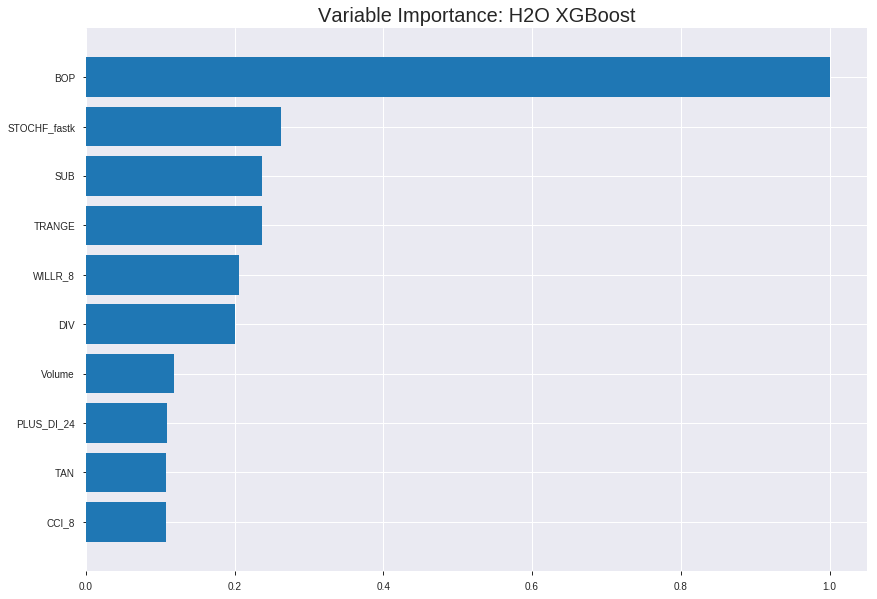

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190828_191713_model_3


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.14584248546293244
RMSE: 0.3818932906754614
LogLoss: 0.45860213361031693
Mean Per-Class Error: 0.17542672150033667
AUC: 0.9020771158310003
pr_auc: 0.8823189444438456
Gini: 0.8041542316620005
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.49804720282554626: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      705  138  0.1637   (138.0/843.0)
1      130  564  0.1873   (130.0/694.0)
Total  835  702  0.1744   (268.0/1537.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.498047     0.808023  186
max f2                       0.320802     0.871429  273
max f0point5                 0.547232     0.82107   158
max accuracy                 0.505582     0.826285  181
max precision                0.905997     1         0
max recall                   0.174089     1         338
max specificity              0.905997     1         0
max absolute_mcc             0.501525     0.64923   184
max min_per_class_accuracy   0.493808     0.820878  189
max mean_per_class_accuracy  0.501525     0.824573  184

Gains/Lift Table: Avg response rate: 45.15 %, avg score: 45.41 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104099                   0.878936           2.2147     2.2147             1                0.887127   1                           0.887127            0.0230548       0.0230548                  121.47    121.47
    2        0.0201692                   0.855197           2.2147     2.2147             1                0.86697    1                           0.877374            0.0216138       0.0446686                  121.47    121.47
    3        0.0305791                   0.842225           2.2147     2.2147             1                0.848063   1                           0.867396            0.0230548       0.0677233                  121.47    121.47
    4        0.0403383                   0.827503           2.2147     2.2147             1                0.836893   1                           0.860016            0.0216138       0.0893372                  121.47    121.47
    5        0.0500976                   0.808716           2.2147     2.2147             1                0.818202   1                           0.851871            0.0216138       0.110951                   121.47    121.47
    6        0.100195                    0.748002           2.12841    2.17155            0.961039         0.774565   0.980519                    0.813218            0.106628        0.217579                   112.841   117.155
    7        0.150293                    0.704299           2.01336    2.11882            0.909091         0.72245    0.95671                     0.782962            0.100865        0.318444                   101.336   111.882
    8        0.20039                     0.658814           1.9846     2.08527            0.896104         0.681509   0.941558                    0.757599            0.0994236       0.417867                   98.4599   108.527
    9        0.299935                    0.592702           1.78044    1.9841             0.803922         0.624766   0.895879                    0.713513            0.177233        0.595101                   78.0443   98.41
    10       0.40013                     0.531934           1.4525     1.85098            0.655844         0.562147   0.835772                    0.67561             0.145533        0.740634                   45.2496   85.0983
    11       0.500325                    0.475942           1.02106    1.68478            0.461039         0.502516   0.760728                    0.640946            0.102305        0.842939                   2.10618   68.4783
    12       0.59987                     0.407238           0.709282   1.5229             0.320261         0.440968   0.687636                    0.607761            0.0706052       0.913545                   -29.0718  52.2905
    13       0.700065                    0.317637           0.532103   1.3811             0.24026          0.368079   0.623606                    0.573457            0.0533141       0.966859                   -46.7897  38.1098
    14       0.79961                     0.211842           0.303978   1.24701            0.137255         0.260605   0.563059                    0.53451             0.0302594       0.997118                   -69.6022  24.7006
    15       0.899805                    0.135415           0.0287623  1.11135            0.012987         0.171022   0.501808                    0.494035            0.00288184      1                          -97.1238  11.1352
    16       1                           0.0497763          0          1                  0                0.0956732  0.451529        



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.19522499376179814
RMSE: 0.4418427251430062
LogLoss: 0.5704160757484282
Mean Per-Class Error: 0.28587106484384806
AUC: 0.7639742464149839
pr_auc: 0.6994484086918468
Gini: 0.5279484928299678
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3166210949420929: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      121  117  0.4916   (117.0/238.0)
1      19   182  0.0945   (19.0/201.0)
Total  140  299  0.3098   (136.0/439.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.316621     0.728     271
max f2                       0.204356     0.836947  317
max f0point5                 0.517245     0.67861   164
max accuracy                 0.435645     0.708428  214
max precision                0.888982     1         0
max recall                   0.0713886    1         396
max specificity              0.888982     1         0
max absolute_mcc             0.316621     0.442443  271
max min_per_class_accuracy   0.473549     0.697479  193
max mean_per_class_accuracy  0.396988     0.714129  238

Gains/Lift Table: Avg response rate: 45.79 %, avg score: 43.30 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113895                   0.859721           2.18408   2.18408            1                0.87784    1                           0.87784             0.0248756       0.0248756                  118.408   118.408
    2        0.0205011                   0.838238           2.18408   2.18408            1                0.846308   1                           0.863826            0.0199005       0.0447761                  118.408   118.408
    3        0.0318907                   0.821535           2.18408   2.18408            1                0.832503   1                           0.852639            0.0248756       0.0696517                  118.408   118.408
    4        0.0410023                   0.805858           1.63806   2.06274            0.75             0.812015   0.944444                    0.843612            0.0149254       0.0845771                  63.806    106.274
    5        0.0501139                   0.790405           1.09204   1.88625            0.5              0.80261    0.863636                    0.836157            0.00995025      0.0945274                  9.20398   88.6251
    6        0.100228                    0.698176           1.48915   1.6877             0.681818         0.742609   0.772727                    0.789383            0.0746269       0.169154                   48.9145   68.7698
    7        0.150342                    0.657283           1.38987   1.58842            0.636364         0.677806   0.727273                    0.752191            0.0696517       0.238806                   38.9869   58.8422
    8        0.200456                    0.610618           1.38987   1.53878            0.636364         0.631929   0.704545                    0.722125            0.0696517       0.308458                   38.9869   53.8783
    9        0.300683                    0.566621           1.38987   1.48915            0.636364         0.584433   0.681818                    0.676228            0.139303        0.447761                   38.9869   48.9145
    10       0.400911                    0.522734           1.53878   1.50155            0.704545         0.546524   0.6875                      0.643802            0.154229        0.60199                    53.8783   50.1555
    11       0.501139                    0.464337           1.14168   1.42958            0.522727         0.49357    0.654545                    0.613755            0.114428        0.716418                   14.1678   42.9579
    12       0.599089                    0.397169           1.16823   1.38685            0.534884         0.428327   0.634981                    0.583438            0.114428        0.830846                   16.8229   38.6849
    13       0.699317                    0.28607            0.794211  1.30191            0.363636         0.344263   0.596091                    0.549159            0.079602        0.910448                   -20.5789  30.1911
    14       0.799544                    0.198684           0.496382  1.20093            0.227273         0.243216   0.549858                    0.510807            0.0497512       0.960199                   -50.3618  20.0933
    15       0.899772                    0.119094           0.248191  1.0948             0.113636         0.153173   0.501266                    0.470969            0.0248756       0.985075                   -75.1809  9.48045
    16       1                           0.0539536          0.148915  1                  0.0681818        0.0916665  0.457859                   


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 19:17:19  2.141 sec   0                  0.5              0.693147            0.5             0                  1                0.548471                         0.5                0.693147              0.5               0                    1                  0.542141
    2019-08-28 19:17:19  2.253 sec   5                  0.470882         0.636146            0.830931        0.789533           2.2147           0.272609                         0.476855           0.647522              0.76087           0.703454             2.18408            0.312073
    2019-08-28 19:17:19  2.337 sec   10                 0.449766         0.595333            0.845656        0.814466           2.2147           0.254392                         0.462884           0.619751              0.765333          0.708867             2.18408            0.307517
    2019-08-28 19:17:19  2.407 sec   15                 0.455255         0.603952            0.789348        0.762708           2.2147           0.319453                         0.477291           0.64654               0.64338           0.626888             2.18408            0.421412
    2019-08-28 19:17:19  2.471 sec   20                 0.469399         0.630453            0.703017        0.711686           2.2147           0.412492                         0.474771           0.641123              0.685585          0.641624             2.18408            0.425968
    2019-08-28 19:17:20  2.547 sec   25                 0.464455         0.619418            0.712052        0.713755           2.2147           0.411191                         0.448588           0.588073              0.763838          0.699699             2.18408            0.314351
    2019-08-28 19:17:20  2.623 sec   30                 0.461136         0.611733            0.715742        0.720185           2.2147           0.411191                         0.497028           0.686755              0.526987          0.733888             2.18408            0.537585
    2019-08-28 19:17:20  2.688 sec   35                 0.460086         0.609341            0.716529        0.732493           2.2147           0.404034                         0.496828           0.686275              0.527071          0.733909             2.18408            0.53303
    2019-08-28 19:17:20  2.763 sec   40                 0.456973         0.601531            0.72192         0.730036           2.2147           0.398829                         0.49674            0.686046              0.52705           0.733903             2.18408            0.535308
    2019-08-28 19:17:20  2.836 sec   45                 0.439585         0.566552            0.780788        0.780079           2.2147           0.359141                         0.496658           0.685853              0.527071          0.733909             2.18408            0.53303
    2019-08-28 19:17:20  2.917 sec   50                 0.381893         0.458602            0.902077        0.882319           2.2147           0.174366                         0.441843           0.570416              0.763974          0.699448             2.18408            0.309795

Variable Importances: 


variable          relative_importance    scaled_importance     percentage
----------------  ---------------------  --------------------  ---------------------
BOP               1506.6871337890625     1.0                   0.255889986790194
STOCHF_fastk      395.2768249511719      0.2623483111302064    0.06713230586953821
SUB               356.5769958496094      0.23666293277017553   0.06055967474028878
TRANGE            356.2451477050781      0.23644268256886353   0.060503314919184516
WILLR_8           310.4417419433594      0.2060426049850516    0.05272423946784201
---               ---                    ---                   ---
CDLSHORTLINE      19.20461654663086      0.012746253761611747  0.0032616387066832903
CDLENGULFING      17.05001449584961      0.011316227578695595  0.0028957093256272446
CDLDRAGONFLYDOJI  11.876526832580566     0.007882543473184851  0.0020170639452264014
CDLSPINNINGTOP    9.49484634399414       0.006301803560315945  0.0016125684298036445
HT_TRENDMODE      8.844502449035645      0.00587016524578213   0.001502116507199445


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7272727272727273)

('F1', 0.7550200803212852)

('auc', 0.775819265143992)

('logloss', 0.5691320821240119)

('mean_per_class_error', 0.26845415425355834)

('rmse', 0.4405209955271637)

('mse', 0.19405874750024338)

xgboost prediction progress: |████████████████████████████████████████████| 100%


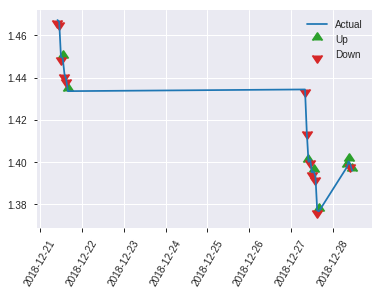


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.19405874750024338
RMSE: 0.4405209955271637
LogLoss: 0.5691320821240119
Mean Per-Class Error: 0.26845415425355834
AUC: 0.775819265143992
pr_auc: 0.7320341234305592
Gini: 0.551638530287984
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3580063581466675: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      65   49   0.4298   (49.0/114.0)
1      12   94   0.1132   (12.0/106.0)
Total  77   143  0.2773   (61.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.358006     0.75502   142
max f2                       0.145794     0.845649  184
max f0point5                 0.558712     0.704225  79
max accuracy                 0.395521     0.727273  131
max precision                0.883805     1         0
max recall                   0.0982663    1         207
max specificity              0.883805     1         0
max absolute_mcc             0.358006     0.478716  142
max min_per_class_accuracy   0.480508     0.684211  108
max mean_per_class_accuracy  0.391945     0.731546  133

Gains/Lift Table: Avg response rate: 48.18 %, avg score: 44.36 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136364                   0.865175           2.07547   2.07547            1                0.872492   1                           0.872492            0.0283019       0.0283019                  107.547   107.547
    2        0.0227273                   0.861224           2.07547   2.07547            1                0.862921   1                           0.868664            0.0188679       0.0471698                  107.547   107.547
    3        0.0318182                   0.852925           2.07547   2.07547            1                0.858117   1                           0.86565             0.0188679       0.0660377                  107.547   107.547
    4        0.0409091                   0.841057           1.03774   1.84486            0.5              0.848771   0.888889                    0.861899            0.00943396      0.0754717                  3.77358   84.4864
    5        0.05                        0.826866           2.07547   1.88679            1                0.834128   0.909091                    0.85685             0.0188679       0.0943396                  107.547   88.6792
    6        0.1                         0.734734           1.50943   1.69811            0.727273         0.771295   0.818182                    0.814073            0.0754717       0.169811                   50.9434   69.8113
    7        0.15                        0.673284           1.32075   1.57233            0.636364         0.709441   0.757576                    0.779195            0.0660377       0.235849                   32.0755   57.2327
    8        0.2                         0.651275           1.50943   1.5566             0.727273         0.663471   0.75                        0.750264            0.0754717       0.311321                   50.9434   55.6604
    9        0.3                         0.576981           1.69811   1.60377            0.818182         0.603849   0.772727                    0.701459            0.169811        0.481132                   69.8113   60.3774
    10       0.4                         0.543912           1.03774   1.46226            0.5              0.56054    0.704545                    0.666229            0.103774        0.584906                   3.77358   46.2264
    11       0.5                         0.476442           1.13208   1.39623            0.545455         0.522296   0.672727                    0.637443            0.113208        0.698113                   13.2075   39.6226
    12       0.6                         0.394611           1.41509   1.39937            0.681818         0.435501   0.674242                    0.603786            0.141509        0.839623                   41.5094   39.9371
    13       0.7                         0.293618           0.566038  1.28032            0.272727         0.351729   0.616883                    0.567778            0.0566038       0.896226                   -43.3962  28.0323
    14       0.8                         0.167528           0.566038  1.19104            0.272727         0.233701   0.573864                    0.526018            0.0566038       0.95283                    -43.3962  19.1038
    15       0.9                         0.111674           0.283019  1.09015            0.136364         0.137059   0.525253                    0.4828              0.0283019       0.981132                   -71.6981  9.01468
    16       1                           0.0607568          0.188679  1                  0.0909091        0.0904788  0.481818                   

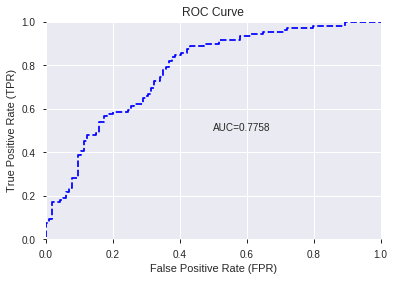

This function is available for GLM models only


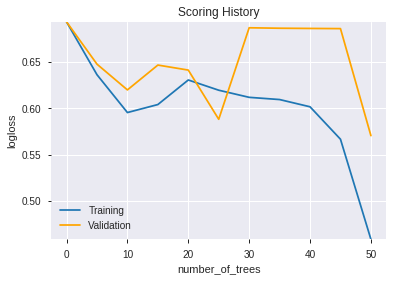

--2019-08-28 19:17:37--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.184.171
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.184.171|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at he

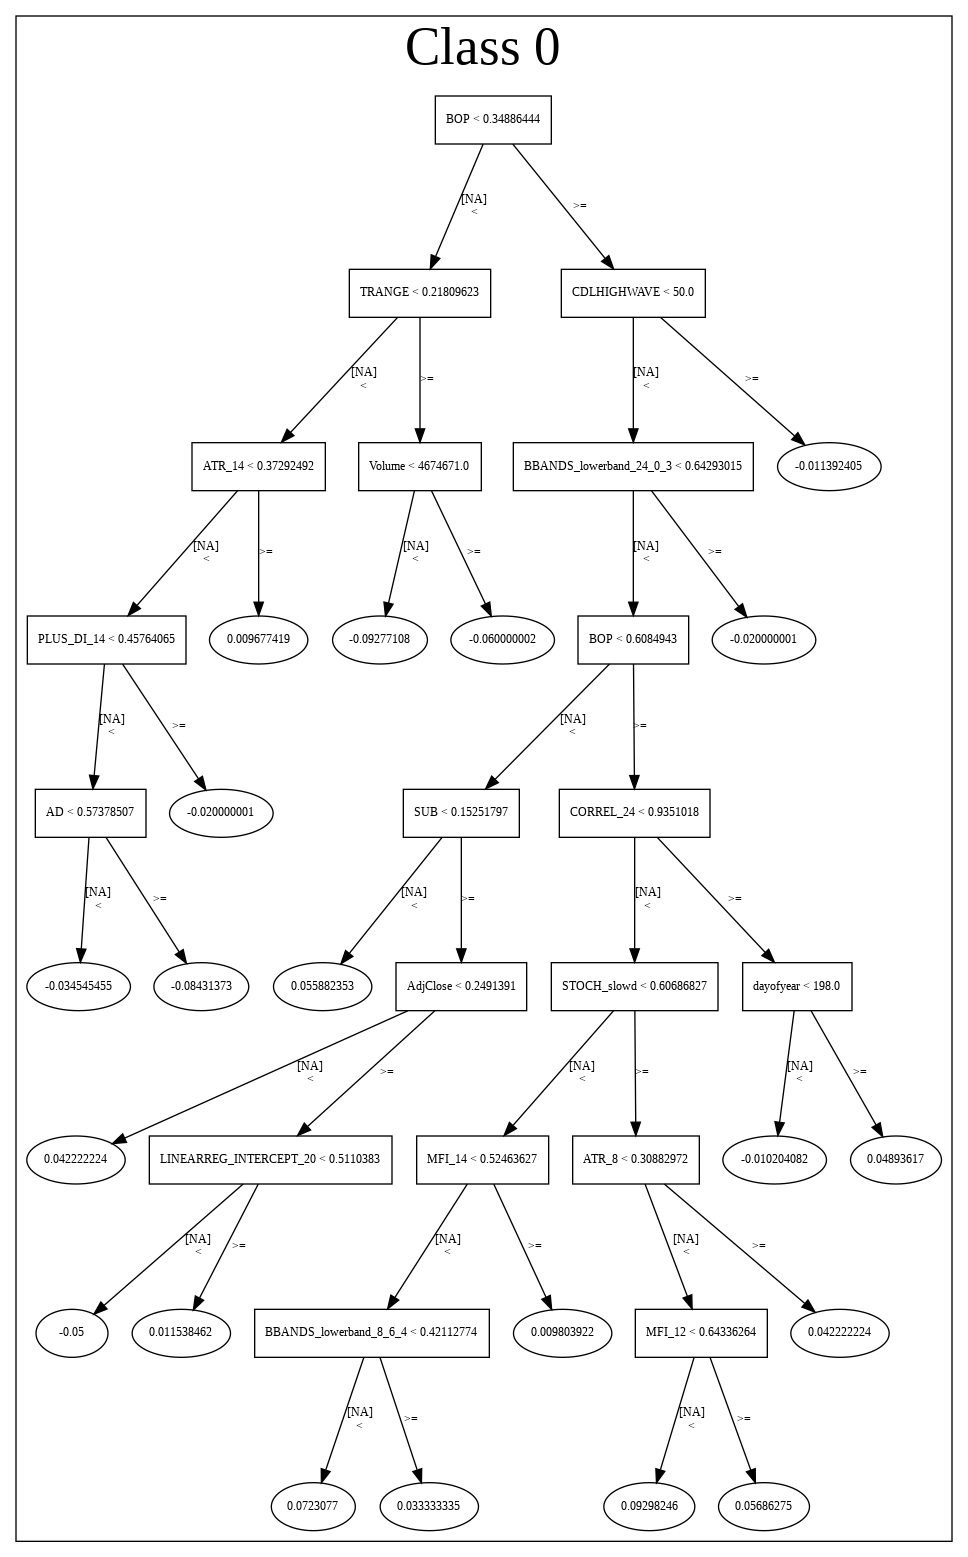

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190828_191713_model_3',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190828_191713_model_3',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_26_sid_8978',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['BOP',
 'STOCHF_fastk',
 'SUB',
 'TRANGE',
 'WILLR_8',
 'DIV',
 'Volume',
 'PLUS_DI_24',
 'TAN',
 'CCI_8',
 'CORREL_8',
 'PLUS_DM_8',
 'STOCHRSI_fastk',
 'HT_DCPERIOD',
 'hour',
 'SAREXT',
 'DX_30',
 'STOCHRSI_fastd',
 'aroondown_20',
 'ULTOSC',
 'WILLR_20',
 'CDLCLOSINGMARUBOZU',
 'DX_20',
 'DX_24',
 'dayofweek',
 'aroonup_8',
 'day',
 'aroonup_24',
 'aroonup_12',
 'aroonup_20',
 'weekday_name',
 'WILLR_24',
 'CDLLONGLINE',
 'CDLBELTHOLD',
 'CDLTAKURI',
 'weekday',
 'CDLHAMMER',
 'CDLSHORTLINE',
 'CDLENGULFING',
 'CDLDRAGONFLYDOJI',
 'CDLSPINNINGTOP',
 'HT_TRENDMODE']

In [14]:
# XGBoost with top DeepLearning features
model_train(feature_name='DLF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190828_191834_model_1  0.782853  0.578563               0.26233  0.445771  0.198712

variable  relative_importance  scaled_importance    percentage
0                          BOP             0.402548           1.000000  3.788904e-02
1                 STOCHF_fastk             0.161332           0.400777  1.518506e-02
2           CDLCLOSINGMARUBOZU             0.151795           0.377085  1.428740e-02
3                          DIV             0.151252           0.375736  1.423628e-02
4                          SUB             0.150439           0.373718  1.415980e-02
...                        ...                  ...                ...           ...
1028  BBANDS_middleband_12_6_3             0.000011           0.000026  9.905914e-07
1029                    CCI_14             0.000009           0.000023  8.574400e-07
1030   BBANDS_lowerband_30_5_2             0.000008           0.000020  7.482414e-07
1031  BBANDS_middleband_12_6_2             0.000007           0.000016  6.195193e-07
1032  BBANDS_middleband_20_2_3             0.000005           0.000013  4.931413e-07

[1033 rows x 4 columns]

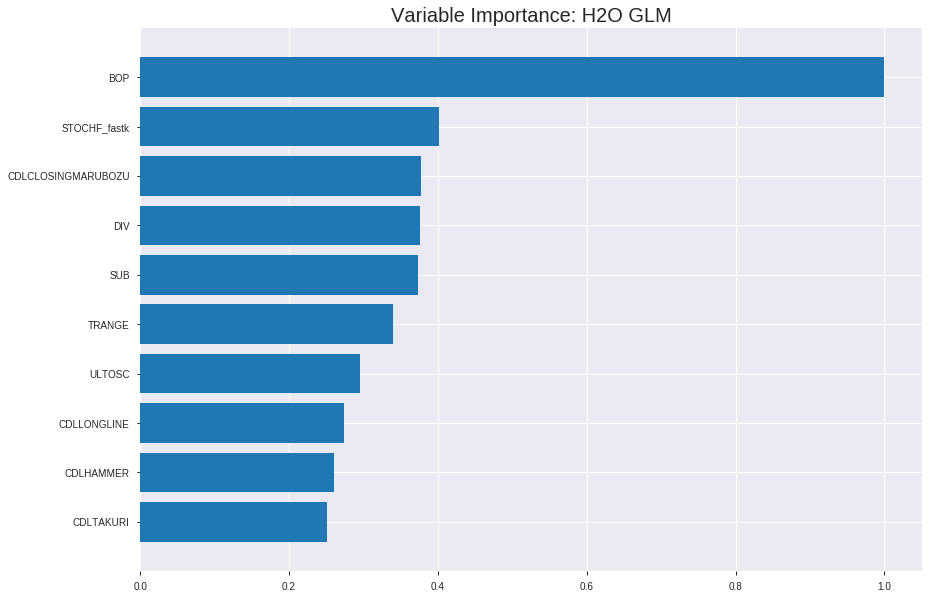

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190828_191834_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.18029125441828336
RMSE: 0.4246071765977153
LogLoss: 0.5378317343228121
Null degrees of freedom: 1536
Residual degrees of freedom: 503
Null deviance: 2116.267351263065
Residual deviance: 1653.2947513083243
AIC: 3721.2947513083245
AUC: 0.8074514308374442
pr_auc: 0.7441633698794002
Gini: 0.6149028616748884
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.41160235461642536: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      556  287  0.3405   (287.0/843.0)
1      122  572  0.1758   (122.0/694.0)
Total  678  859  0.2661   (409.0/1537.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.411602     0.736639  222
max f2                       0.200184     0.833128  320
max f0point5                 0.553468     0.724461  149
max accuracy                 0.453221     0.741705  200
max precision                0.924376     1         0
max recall                   0.0783265    1         378
max specificity              0.924376     1         0
max absolute_mcc             0.427128     0.487748  215
max min_per_class_accuracy   0.470479     0.735469  192
max mean_per_class_accuracy  0.448968     0.744921  202

Gains/Lift Table: Avg response rate: 45.15 %, avg score: 45.15 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104099                   0.86586            2.2147     2.2147             1                0.891067   1                           0.891067            0.0230548       0.0230548                  121.47    121.47
    2        0.0201692                   0.849941           1.77176    2.00037            0.8              0.857188   0.903226                    0.874674            0.0172911       0.0403458                  77.1758   100.037
    3        0.0305791                   0.831184           1.38419    1.79061            0.625            0.840149   0.808511                    0.862921            0.0144092       0.054755                   38.4186   79.0606
    4        0.0403383                   0.816741           1.9194     1.82177            0.866667         0.825275   0.822581                    0.853813            0.018732        0.073487                   91.9404   82.1767
    5        0.0500976                   0.803779           1.77176    1.81203            0.8              0.808934   0.818182                    0.84507             0.0172911       0.0907781                  77.1758   81.2025
    6        0.100195                    0.754722           1.69698    1.7545             0.766234         0.780188   0.792208                    0.812629            0.0850144       0.175793                   69.6976   75.4501
    7        0.150293                    0.707733           1.95584    1.82161            0.883117         0.728934   0.822511                    0.78473             0.0979827       0.273775                   95.5837   82.1613
    8        0.20039                     0.670036           1.66821    1.78326            0.753247         0.685942   0.805195                    0.760033            0.0835735       0.357349                   66.8214   78.3263
    9        0.299935                    0.596452           1.50542    1.69105            0.679739         0.633267   0.763557                    0.717961            0.149856        0.507205                   50.5415   69.1049
    10       0.40013                     0.524714           1.36621    1.60971            0.616883         0.559847   0.726829                    0.678368            0.136888        0.644092                   36.6209   60.9707
    11       0.500325                    0.455062           1.2224     1.53214            0.551948         0.490405   0.691808                    0.640727            0.122478        0.766571                   22.2398   53.2144
    12       0.59987                     0.382464           0.854034   1.41962            0.385621         0.418324   0.640998                    0.60382             0.0850144       0.851585                   -14.5966  41.9616
    13       0.700065                    0.310882           0.661533   1.31112            0.298701         0.346198   0.592007                    0.566949            0.0662824       0.917867                   -33.8467  31.1117
    14       0.79961                     0.226388           0.390829   1.19655            0.176471         0.273352   0.540277                    0.530398            0.0389049       0.956772                   -60.9171  19.6549
    15       0.899805                    0.145793           0.345148   1.10174            0.155844         0.18269    0.497469                    0.49168             0.0345821       0.991354                   -65.4852  10.1744
    16       1                           0.00171461         0.0862869  1                  0.038961         0.0909489  0.451529  



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.20267342485333578
RMSE: 0.45019265304237893
LogLoss: 0.5882722593592482
Null degrees of freedom: 438
Residual degrees of freedom: -595
Null deviance: 605.5320386942669
Residual deviance: 516.50304371742
AIC: 2584.50304371742
AUC: 0.7498536728124086
pr_auc: 0.6992197715248206
Gini: 0.4997073456248171
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.26890616850137794: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      96   142  0.5966   (142.0/238.0)
1      18   183  0.0896   (18.0/201.0)
Total  114  325  0.3645   (160.0/439.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.268906     0.695817  295
max f2                       0.0952071    0.82716   373
max f0point5                 0.539551     0.680958  136
max accuracy                 0.539551     0.697039  136
max precision                0.747973     0.954545  21
max recall                   0.0952071    1         373
max specificity              0.852201     0.995798  0
max absolute_mcc             0.463573     0.391023  187
max min_per_class_accuracy   0.463573     0.681592  187
max mean_per_class_accuracy  0.463573     0.695838  187

Gains/Lift Table: Avg response rate: 45.79 %, avg score: 42.70 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113895                   0.811891           1.74726   1.74726            0.8              0.829716   0.8                         0.829716            0.0199005       0.0199005                  74.7264   74.7264
    2        0.0205011                   0.800038           2.18408   1.9414             1                0.805148   0.888889                    0.818797            0.0199005       0.039801                   118.408   94.1404
    3        0.0318907                   0.772182           2.18408   2.02807            1                0.785193   0.928571                    0.806796            0.0248756       0.0646766                  118.408   102.807
    4        0.0410023                   0.752386           2.18408   2.06274            1                0.760843   0.944444                    0.796584            0.0199005       0.0845771                  118.408   106.274
    5        0.0501139                   0.74706            2.18408   2.0848             1                0.749249   0.954545                    0.787978            0.0199005       0.104478                   118.408   108.48
    6        0.100228                    0.692741           1.58842   1.83661            0.727273         0.721869   0.840909                    0.754923            0.079602        0.18408                    58.8422   83.6612
    7        0.150342                    0.655662           1.38987   1.6877             0.636364         0.673053   0.772727                    0.727633            0.0696517       0.253731                   38.9869   68.7698
    8        0.200456                    0.626787           1.19132   1.5636             0.545455         0.642639   0.715909                    0.706385            0.0597015       0.313433                   19.1316   56.3602
    9        0.300683                    0.563725           1.6877    1.60497            0.772727         0.597487   0.734848                    0.670085            0.169154        0.482587                   68.7698   60.4968
    10       0.400911                    0.504995           1.0424    1.46433            0.477273         0.533479   0.670455                    0.635934            0.104478        0.587065                   4.24016   46.4326
    11       0.501139                    0.437811           1.19132   1.40972            0.545455         0.47336    0.645455                    0.603419            0.119403        0.706468                   19.1316   40.9724
    12       0.599089                    0.360626           0.761888  1.3038             0.348837         0.396527   0.596958                    0.569592            0.0746269       0.781095                   -23.8112  30.3804
    13       0.699317                    0.301045           0.893487  1.245              0.409091         0.330195   0.570033                    0.535281            0.0895522       0.870647                   -10.6513  24.4997
    14       0.799544                    0.229721           0.645296  1.16982            0.295455         0.265402   0.535613                    0.50145             0.0646766       0.935323                   -35.4704  16.982
    15       0.899772                    0.124462           0.446744  1.08928            0.204545         0.183887   0.498734                    0.466076            0.0447761       0.9801                     -55.3256  8.92751
    16       1                           0.00914484         0.198553  1                  0.0909091        0.0758848  0.457859                    0


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------  -----------  --------  ------------  ------------------  ------------------
     2019-08-28 19:18:37  0.000 sec   2            .2E2      1020          1.349423746535884   1.3544440779205276
     2019-08-28 19:18:39  1.899 sec   4            .15E2     1032          1.341461843313528   1.348205317469778
     2019-08-28 19:18:40  3.813 sec   6            .11E2     1032          1.331617002699425   1.3405163009143435
     2019-08-28 19:18:42  5.730 sec   8            .78E1     1032          1.3197781129683237  1.3314108225518166
     2019-08-28 19:18:44  7.644 sec   10           .57E1     1032          1.3058547793502127  1.3207949548199263
---  ---                  ---         ---          ---       ---           ---                 ---
     2019-08-28 19:19:13  36.748 sec  40           .48E-1    1034          1.0660578257371598  1.177189974103743
     2019-08-28 19:19:15  38.680 sec  42           .35E-1    1034          1.0571519151603086  1.1791414283620731
     2019-08-28 19:19:17  40.615 sec  44           .26E-1    1034          1.0488482016827054  1.1824671319789035
     2019-08-28 19:19:19  42.541 sec  46           .19E-1    1034          1.0410523487475694  1.1873496577097877
     2019-08-28 19:19:21  44.488 sec  48           .14E-1    1034          1.033707953858376   1.1937872075335854


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7363636363636363)

('F1', 0.7387387387387387)

('auc', 0.7828533598146309)

('logloss', 0.5785633150534011)

('mean_per_class_error', 0.2623303541873552)

('rmse', 0.4457707979321157)

('mse', 0.19871160428903514)

glm prediction progress: |████████████████████████████████████████████████| 100%


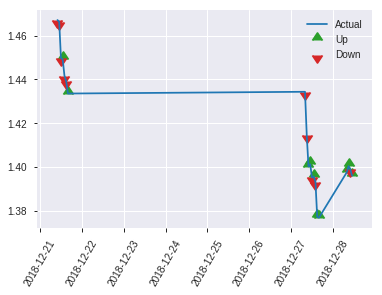


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.19871160428903514
RMSE: 0.4457707979321157
LogLoss: 0.5785633150534011
Null degrees of freedom: 219
Residual degrees of freedom: -814
Null deviance: 305.5060851051157
Residual deviance: 254.56785862349648
AIC: 2322.5678586234962
AUC: 0.7828533598146309
pr_auc: 0.740356655402401
Gini: 0.5657067196292618
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4183788373634326: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      80   34   0.2982   (34.0/114.0)
1      24   82   0.2264   (24.0/106.0)
Total  104  116  0.2636   (58.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.418379     0.738739  115
max f2                       0.112482     0.854839  195
max f0point5                 0.470492     0.723404  90
max accuracy                 0.425652     0.736364  111
max precision                0.898356     1         0
max recall                   0.112482     1         195
max specificity              0.898356     1         0
max absolute_mcc             0.418379     0.475733  115
max min_per_class_accuracy   0.429157     0.719298  108
max mean_per_class_accuracy  0.418379     0.73767   115

Gains/Lift Table: Avg response rate: 48.18 %, avg score: 40.27 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136364                   0.800753           2.07547   2.07547            1                0.85221   1                           0.85221             0.0283019       0.0283019                  107.547   107.547
    2        0.0227273                   0.770011           1.03774   1.66038            0.5              0.781997  0.8                         0.824125            0.00943396      0.0377358                  3.77358   66.0377
    3        0.0318182                   0.751473           2.07547   1.77898            1                0.763592  0.857143                    0.80683             0.0188679       0.0566038                  107.547   77.8976
    4        0.0409091                   0.737404           2.07547   1.84486            1                0.742012  0.888889                    0.792426            0.0188679       0.0754717                  107.547   84.4864
    5        0.05                        0.71806            2.07547   1.88679            1                0.736063  0.909091                    0.782178            0.0188679       0.0943396                  107.547   88.6792
    6        0.1                         0.667086           1.50943   1.69811            0.727273         0.68597   0.818182                    0.734074            0.0754717       0.169811                   50.9434   69.8113
    7        0.15                        0.616762           1.50943   1.63522            0.727273         0.637461  0.787879                    0.70187             0.0754717       0.245283                   50.9434   63.522
    8        0.2                         0.598343           1.69811   1.65094            0.818182         0.60522   0.795455                    0.677707            0.0849057       0.330189                   69.8113   65.0943
    9        0.3                         0.550628           1.50943   1.60377            0.727273         0.573725  0.772727                    0.643046            0.150943        0.481132                   50.9434   60.3774
    10       0.4                         0.471735           1.41509   1.5566             0.681818         0.502402  0.75                        0.607885            0.141509        0.622642                   41.5094   55.6604
    11       0.5                         0.426438           1.13208   1.4717             0.545455         0.449572  0.709091                    0.576223            0.113208        0.735849                   13.2075   47.1698
    12       0.6                         0.361202           0.660377  1.33648            0.318182         0.3993    0.643939                    0.546736            0.0660377       0.801887                   -33.9623  33.6478
    13       0.7                         0.272289           0.754717  1.25337            0.363636         0.313481  0.603896                    0.513413            0.0754717       0.877358                   -24.5283  25.3369
    14       0.8                         0.173183           0.566038  1.16745            0.272727         0.227898  0.5625                      0.477724            0.0566038       0.933962                   -43.3962  16.7453
    15       0.9                         0.109733           0.660377  1.11111            0.318182         0.137854  0.535354                    0.439961            0.0660377       1                          -33.9623  11.1111
    16       1                           0.0167031          0         1                  0                0.067149  0.481818                    0.402679          

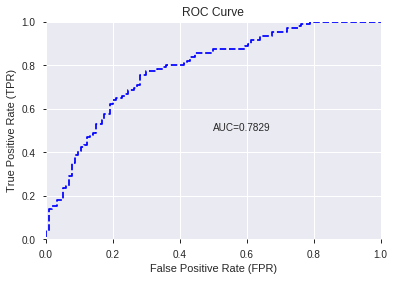

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


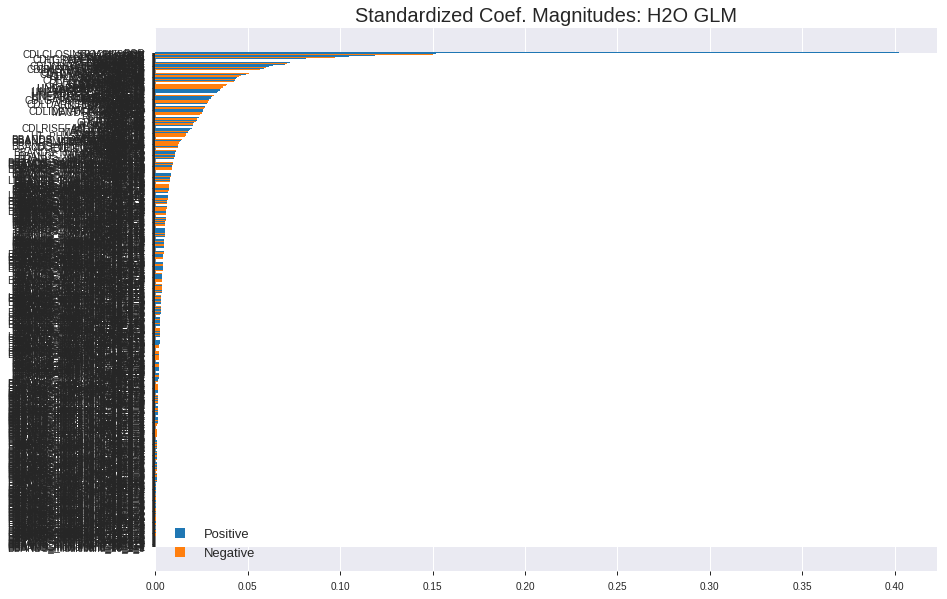

'log_likelihood'
--2019-08-28 19:19:51--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.206.235
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.206.235|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


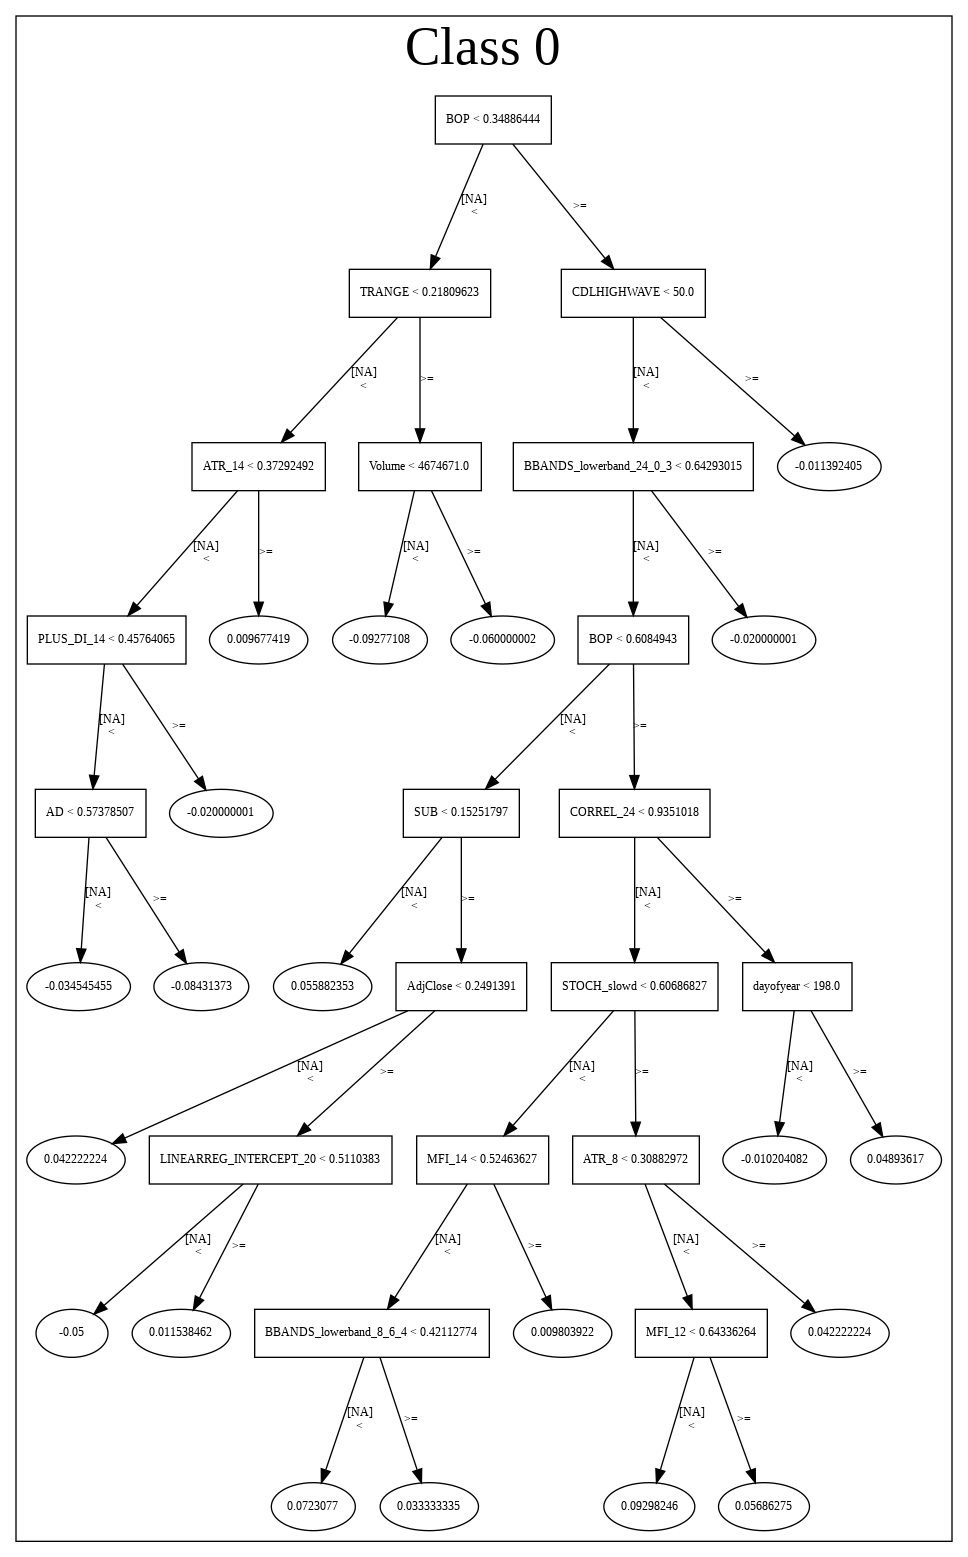

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190828_191834_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190828_191834_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_34_sid_8978',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_34_s

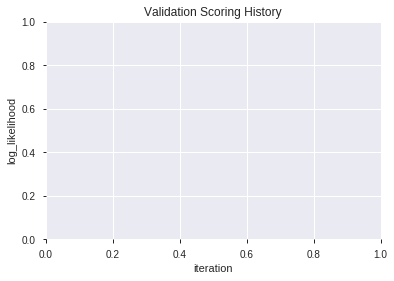

In [15]:
# GLM
glm_features = model_train(feature_name='All',model_algo="GLM")

In [16]:
# DeepLearning with top GLM features
model_train(feature_name='GLMF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

[]

In [17]:
# GLM with top GLM features
model_train(feature_name='GLMF',model_algo="GLM",features_list = features_list[:model_selected_features])

[]

In [18]:
# XGBoost with top GLM features
model_train(feature_name='GLMF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

[]

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               XGBoost_2_AutoML_20190828_192047  0.769199  0.580773              0.284674  0.445233  0.198232
1               XGBoost_3_AutoML_20190828_192047  0.768951  0.570660              0.287736  0.441177  0.194637
2  XGBoost_grid_1_AutoML_20190828_192047_model_5  0.765723  0.593312              0.280950  0.447894  0.200609
3  XGBoost_grid_1_AutoML_20190828_192047_model_6  0.762330  0.575798              0.268454  0.443243  0.196464
4  XGBoost_grid_1_AutoML_20190828_192047_model_1  0.762248  0.578381              0.301556  0.444802  0.197849
5  XGBoost_grid_1_AutoML_20190828_192047_model_2  0.758772  0.577913              0.260013  0.445097  0.198111
6  XGBoost_grid_1_AutoML_20190828_192047_model_3  0.756041  0.589787              0.263737  0.448049  0.200748
7               XGBoost_1_AutoML_20190828_192047  0.752565  0.586900              0.276233  0.449923  0.202431
8  XGBoost_grid_1_AutoML_20190828_192047_model_4  0.745945  0.585935              0.284674  0.448795  0.201417
9  XGBoost_grid_1_AutoML_20190828_192047_model_7  0.734690  0.611280              0.330602  0.461168  0.212676

variable  relative_importance  scaled_importance  percentage
0                        BOP          1562.983032           1.000000    0.210417
1                        DIV           302.871155           0.193778    0.040774
2               STOCHF_fastk           295.992523           0.189377    0.039848
3                        SUB           246.279617           0.157570    0.033156
4             STOCHRSI_fastk           220.778839           0.141255    0.029722
..                       ...                  ...                ...         ...
257  BBANDS_lowerband_30_0_4             1.585764           0.001015    0.000213
258                   CCI_30             1.418852           0.000908    0.000191
259                   MOM_14             1.359146           0.000870    0.000183
260   BBANDS_lowerband_8_0_3             1.167173           0.000747    0.000157
261               AROONOSC_8             1.018772           0.000652    0.000137

[262 rows x 4 columns]

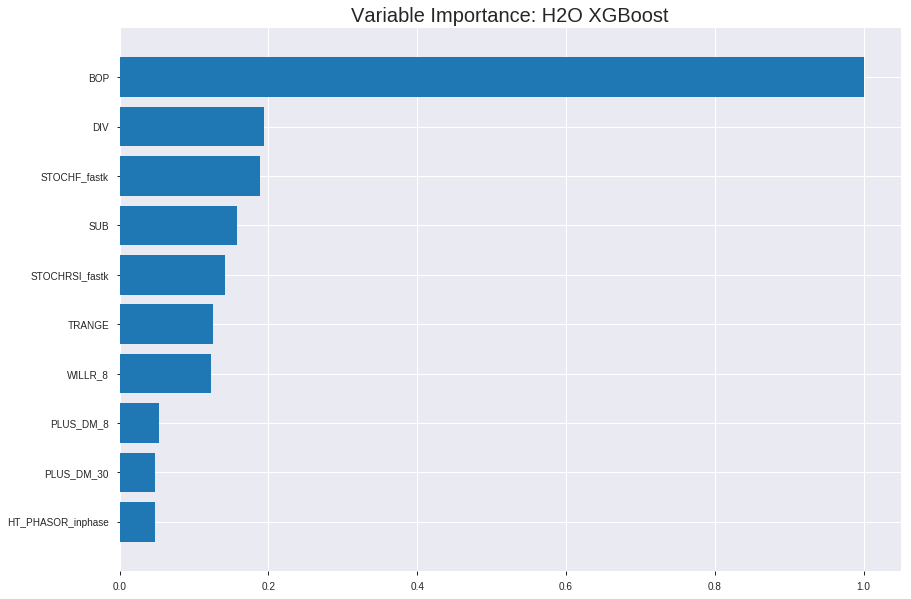

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_2_AutoML_20190828_192047


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.12888327083084616
RMSE: 0.3590031627031246
LogLoss: 0.42118279308740736
Mean Per-Class Error: 0.13933016774864027
AUC: 0.9304203800752766
pr_auc: 0.9183051628243311
Gini: 0.8608407601505532
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5128783881664276: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      751  92   0.1091   (92.0/843.0)
1      118  576  0.17     (118.0/694.0)
Total  869  668  0.1366   (210.0/1537.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.512878     0.845815  171
max f2                       0.354718     0.88479   250
max f0point5                 0.555172     0.872168  153
max accuracy                 0.533757     0.865322  162
max precision                0.918602     1         0
max recall                   0.155077     1         344
max specificity              0.918602     1         0
max absolute_mcc             0.533757     0.728032  162
max min_per_class_accuracy   0.482322     0.85172   184
max mean_per_class_accuracy  0.533757     0.86067   162

Gains/Lift Table: Avg response rate: 45.15 %, avg score: 45.28 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104099                   0.869035           2.2147     2.2147             1                0.886045   1                           0.886045            0.0230548       0.0230548                  121.47    121.47
    2        0.0201692                   0.845882           2.2147     2.2147             1                0.85704    1                           0.872011            0.0216138       0.0446686                  121.47    121.47
    3        0.0305791                   0.834757           2.2147     2.2147             1                0.839375   1                           0.860901            0.0230548       0.0677233                  121.47    121.47
    4        0.0403383                   0.819341           2.2147     2.2147             1                0.82672    1                           0.852631            0.0216138       0.0893372                  121.47    121.47
    5        0.0500976                   0.805288           2.06705    2.18594            0.933333         0.811925   0.987013                    0.844701            0.0201729       0.10951                    106.705   118.594
    6        0.100195                    0.769501           2.18594    2.18594            0.987013         0.788045   0.987013                    0.816373            0.10951         0.21902                    118.594   118.594
    7        0.150293                    0.726211           2.09965    2.15717            0.948052         0.748637   0.974026                    0.793794            0.105187        0.324207                   109.965   115.717
    8        0.20039                     0.698097           2.09965    2.14279            0.948052         0.711866   0.967532                    0.773312            0.105187        0.429395                   109.965   114.279
    9        0.299935                    0.622398           1.9831     2.08979            0.895425         0.661303   0.943601                    0.736138            0.197406        0.626801                   98.3095   108.979
    10       0.40013                     0.546576           1.63945    1.97702            0.74026          0.584955   0.892683                    0.698281            0.164265        0.791066                   63.9451   97.7023
    11       0.500325                    0.455037           0.891631   1.75966            0.402597         0.499233   0.794538                    0.658419            0.0893372       0.880403                   -10.8369  75.9662
    12       0.59987                     0.374752           0.550056   1.55894            0.248366         0.415339   0.703905                    0.618082            0.054755        0.935159                   -44.9944  55.8936
    13       0.700065                    0.287653           0.359529   1.38727            0.162338         0.331627   0.626394                    0.577084            0.0360231       0.971182                   -64.0471  38.7273
    14       0.79961                     0.190566           0.246077   1.2452             0.111111         0.239692   0.562246                    0.535081            0.0244957       0.995677                   -75.3923  24.5204
    15       0.899805                    0.12147            0.0431435  1.11135            0.0194805        0.155932   0.501808                    0.492862            0.00432277      1                          -95.6857  11.1352
    16       1                           0.0377609          0          1                  0                0.0926551  0.451529     



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.1978896103932268
RMSE: 0.4448478508357962
LogLoss: 0.5775337003191152
Mean Per-Class Error: 0.27846063798653786
AUC: 0.7622810318157114
pr_auc: 0.6757130643531855
Gini: 0.5245620636314228
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4256969690322876: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      154  84   0.3529   (84.0/238.0)
1      41   160  0.204    (41.0/201.0)
Total  195  244  0.2847   (125.0/439.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.425697     0.719101  222
max f2                       0.222232     0.83913   316
max f0point5                 0.480114     0.688299  185
max accuracy                 0.462001     0.71754   196
max precision                0.83925      1         0
max recall                   0.098607     1         384
max specificity              0.83925      1         0
max absolute_mcc             0.425697     0.444278  222
max min_per_class_accuracy   0.467939     0.706468  191
max mean_per_class_accuracy  0.425697     0.721539  222

Gains/Lift Table: Avg response rate: 45.79 %, avg score: 43.55 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113895                   0.799918           1.74726    1.74726            0.8              0.815719  0.8                         0.815719            0.0199005       0.0199005                  74.7264   74.7264
    2        0.0205011                   0.782423           1.63806    1.69873            0.75             0.792336  0.777778                    0.805326            0.0149254       0.0348259                  63.806    69.8729
    3        0.0318907                   0.775614           1.74726    1.71606            0.8              0.778789  0.785714                    0.795849            0.0199005       0.0547264                  74.7264   71.6063
    4        0.0410023                   0.767204           1.09204    1.57739            0.5              0.770412  0.722222                    0.790196            0.00995025      0.0646766                  9.20398   57.7391
    5        0.0501139                   0.75602            1.63806    1.58842            0.75             0.763639  0.727273                    0.785368            0.0149254       0.079602                   63.806    58.8422
    6        0.100228                    0.696384           1.58842    1.58842            0.727273         0.733531  0.727273                    0.759449            0.079602        0.159204                   58.8422   58.8422
    7        0.150342                    0.672177           1.48915    1.55533            0.681818         0.685606  0.712121                    0.734835            0.0746269       0.233831                   48.9145   55.5329
    8        0.200456                    0.635526           1.38987    1.51396            0.636364         0.654789  0.693182                    0.714823            0.0696517       0.303483                   38.9869   51.3964
    9        0.300683                    0.569221           1.53878    1.52224            0.704545         0.601912  0.69697                     0.677186            0.154229        0.457711                   53.8783   52.2237
    10       0.400911                    0.517891           1.38987    1.48915            0.636364         0.547262  0.681818                    0.644705            0.139303        0.597015                   38.9869   48.9145
    11       0.501139                    0.458707           1.38987    1.46929            0.636364         0.486371  0.672727                    0.613038            0.139303        0.736318                   38.9869   46.929
    12       0.599089                    0.380243           0.761888   1.35363            0.348837         0.422633  0.619772                    0.581907            0.0746269       0.810945                   -23.8112  35.3631
    13       0.699317                    0.29044            0.843849   1.28057            0.386364         0.335655  0.586319                    0.546614            0.0845771       0.895522                   -15.6151  28.0568
    14       0.799544                    0.210561           0.645296   1.20093            0.295455         0.250092  0.549858                    0.509443            0.0646766       0.960199                   -35.4704  20.0933
    15       0.899772                    0.138201           0.297829   1.10033            0.136364         0.17555   0.503797                    0.47225             0.0298507       0.99005                    -70.2171  10.0334
    16       1                           0.0608586          0.0992763  1                  0.0454545        0.105513  0.457859                    


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 19:20:53  0.005 sec   0                  0.5              0.693147            0.5             0                  1                0.548471                         0.5                0.693147              0.5               0                    1                  0.542141
    2019-08-28 19:20:53  0.727 sec   5                  0.473687         0.641579            0.833702        0.780376           2.12611          0.260898                         0.480599           0.654841              0.754735          0.704435             2.18408            0.341686
    2019-08-28 19:20:54  1.219 sec   10                 0.453429         0.602718            0.863365        0.828286           2.2147           0.21015                          0.468436           0.630712              0.76133           0.702294             2.18408            0.346241
    2019-08-28 19:20:55  1.772 sec   15                 0.436759         0.570857            0.87516         0.841349           2.2147           0.204945                         0.460349           0.614205              0.763013          0.69464              1.74726            0.316629
    2019-08-28 19:20:55  2.264 sec   20                 0.422811         0.543935            0.881012        0.852191           2.2147           0.193884                         0.453749           0.600219              0.765103          0.699694             2.18408            0.332574
    2019-08-28 19:20:55  2.760 sec   25                 0.411984         0.522694            0.886985        0.861411           2.2147           0.197788                         0.451244           0.594159              0.762145          0.695533             2.18408            0.300683
    2019-08-28 19:20:56  3.277 sec   30                 0.402739         0.504344            0.891938        0.871186           2.2147           0.195836                         0.448148           0.586915              0.764173          0.696463             2.18408            0.287016
    2019-08-28 19:20:57  3.837 sec   35                 0.394391         0.487681            0.89713         0.879253           2.2147           0.180872                         0.447275           0.584139              0.761403          0.689699             2.18408            0.346241
    2019-08-28 19:20:57  4.367 sec   40                 0.387378         0.473774            0.901793        0.883637           2.2147           0.186077                         0.445958           0.580952              0.762584          0.689394             2.18408            0.287016
    2019-08-28 19:20:58  4.896 sec   45                 0.380919         0.46148             0.90776         0.888471           2.2147           0.162004                         0.444947           0.578332              0.763755          0.696589             2.18408            0.341686
    2019-08-28 19:20:58  5.377 sec   50                 0.375733         0.451437            0.912816        0.896103           2.2147           0.160052                         0.444295           0.57662               0.763859          0.692559             2.18408            0.284738
    2019-08-28 19:20:59  5.892 sec   55                 0.370134         0.44098             0.918389        0.902693           2.2147           0.151594                         0.445677           0.579214              0.75902           0

Variable Importances: 


variable                 relative_importance    scaled_importance      percentage
-----------------------  ---------------------  ---------------------  ----------------------
BOP                      1562.9830322265625     1.0                    0.21041732202046878
DIV                      302.87115478515625     0.1937776345234524     0.040774170923885994
STOCHF_fastk             295.9925231933594      0.18937667082137186    0.039848131927384914
SUB                      246.2796173095703      0.1575702437145017     0.03315550871251805
STOCHRSI_fastk           220.77883911132812     0.14125478943735909    0.0297224545159743
---                      ---                    ---                    ---
BBANDS_lowerband_30_0_4  1.585763931274414      0.0010145752695826767  0.000213484211213782
CCI_30                   1.4188518524169922     0.0009077845524629613  0.00019101359450080606
MOM_14                   1.3591461181640625     0.0008695846916699267  0.00018297568209118102
BBANDS_lowerband_8_0_3   1.1671733856201172     0.0007467601129088453  0.00015713126314998213
AROONOSC_8               1.0187721252441406     0.0006518126583836543  0.00013715267403613122


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7181818181818181)

('F1', 0.746031746031746)

('auc', 0.7691989407480966)

('logloss', 0.5807726722254171)

('mean_per_class_error', 0.2818603111552467)

('rmse', 0.44523264579130306)

('mse', 0.19823210887832393)

xgboost prediction progress: |████████████████████████████████████████████| 100%


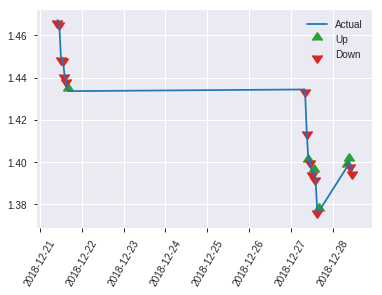


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.19823210887832393
RMSE: 0.44523264579130306
LogLoss: 0.5807726722254171
Mean Per-Class Error: 0.2818603111552467
AUC: 0.7691989407480966
pr_auc: 0.6805580917653398
Gini: 0.5383978814961932
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.35108503699302673: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      62   52   0.4561   (52.0/114.0)
1      12   94   0.1132   (12.0/106.0)
Total  74   146  0.2909   (64.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.351085     0.746032  145
max f2                       0.116754     0.848     200
max f0point5                 0.523625     0.718884  89
max accuracy                 0.523625     0.718182  89
max precision                0.868313     1         0
max recall                   0.116754     1         200
max specificity              0.868313     1         0
max absolute_mcc             0.351085     0.455449  145
max min_per_class_accuracy   0.491608     0.716981  107
max mean_per_class_accuracy  0.491608     0.71814   107

Gains/Lift Table: Avg response rate: 48.18 %, avg score: 44.50 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136364                   0.827483           1.38365    1.38365            0.666667         0.847921   0.666667                    0.847921            0.0188679       0.0188679                  38.3648   38.3648
    2        0.0227273                   0.819988           1.03774    1.24528            0.5              0.822438   0.6                         0.837728            0.00943396      0.0283019                  3.77358   24.5283
    3        0.0318182                   0.816299           0          0.889488           0                0.81829    0.428571                    0.832174            0               0.0283019                  -100      -11.0512
    4        0.0409091                   0.802452           1.03774    0.922432           0.5              0.809885   0.444444                    0.827221            0.00943396      0.0377358                  3.77358   -7.75681
    5        0.05                        0.78762            2.07547    1.13208            1                0.802021   0.545455                    0.822639            0.0188679       0.0566038                  107.547   13.2075
    6        0.1                         0.733369           1.69811    1.41509            0.818182         0.756707   0.681818                    0.789673            0.0849057       0.141509                   69.8113   41.5094
    7        0.15                        0.699998           1.50943    1.44654            0.727273         0.717702   0.69697                     0.765683            0.0754717       0.216981                   50.9434   44.6541
    8        0.2                         0.647825           1.69811    1.50943            0.818182         0.671713   0.727273                    0.74219             0.0849057       0.301887                   69.8113   50.9434
    9        0.3                         0.582308           1.79245    1.60377            0.863636         0.611506   0.772727                    0.698629            0.179245        0.481132                   79.2453   60.3774
    10       0.4                         0.525846           1.32075    1.53302            0.636364         0.54959    0.738636                    0.661369            0.132075        0.613208                   32.0755   53.3019
    11       0.5                         0.490487           1.03774    1.43396            0.5              0.509236   0.690909                    0.630942            0.103774        0.716981                   3.77358   43.3962
    12       0.6                         0.397027           0.943396   1.3522             0.454545         0.439864   0.651515                    0.599096            0.0943396       0.811321                   -5.66038  35.2201
    13       0.7                         0.31403            0.943396   1.2938             0.454545         0.356682   0.623377                    0.564465            0.0943396       0.90566                    -5.66038  29.3801
    14       0.8                         0.198623           0.377358   1.17925            0.181818         0.252404   0.568182                    0.525458            0.0377358       0.943396                   -62.2642  17.9245
    15       0.9                         0.119573           0.471698   1.10063            0.227273         0.147579   0.530303                    0.483471            0.0471698       0.990566                   -52.8302  10.0629
    16       1                           0.0724437          0.0943396  1                  0.0454545        0.0988309  0.48181

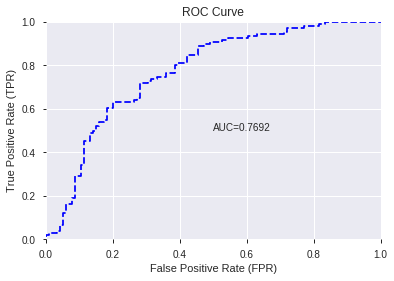

This function is available for GLM models only


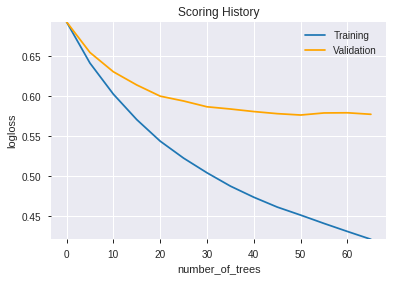

--2019-08-28 19:21:55--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.207.203
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.207.203|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip


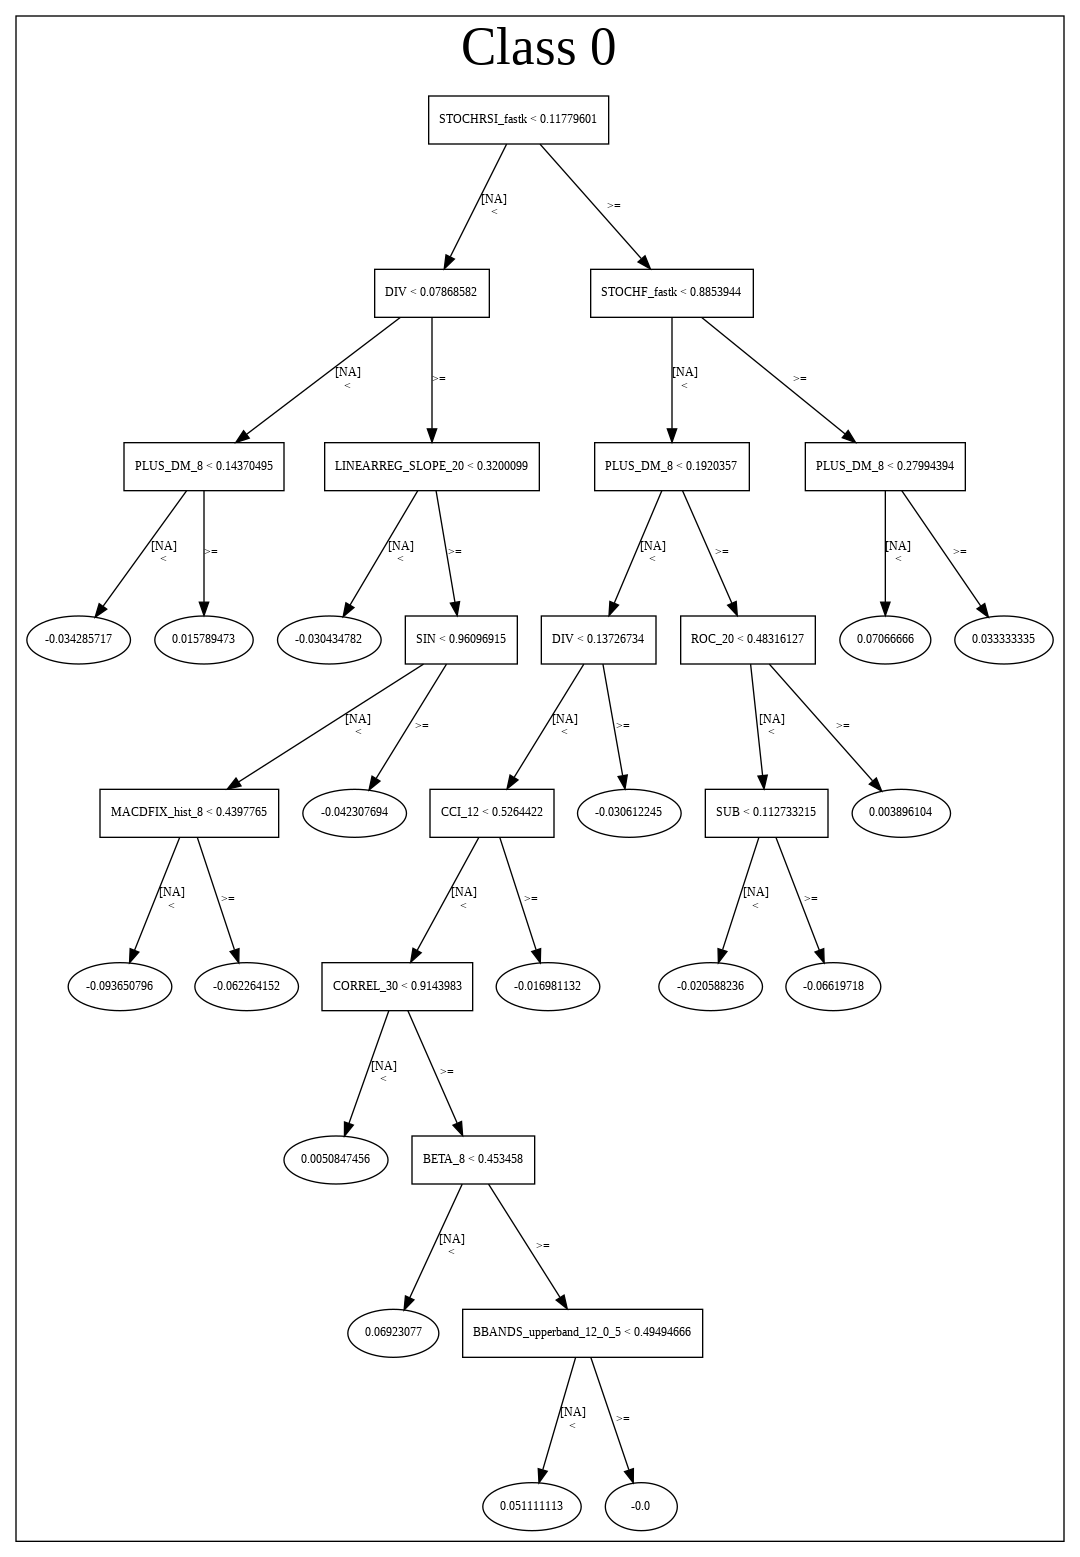

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_2_AutoML_20190828_192047',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_2_AutoML_20190828_192047',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_42_sid_8978',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_42_sid_8978',
   'type

In [19]:
# XGBoost
xgb_features = model_train(feature_name='All',model_algo="XGBoost")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190828_192251_model_6  0.780371  0.584754              0.290715  0.441649  0.195054
1  DeepLearning_grid_1_AutoML_20190828_192251_model_9  0.771433  0.572382              0.290384  0.442158  0.195503
2  DeepLearning_grid_1_AutoML_20190828_192251_model_5  0.769282  0.580409              0.302549  0.443764  0.196926
3  DeepLearning_grid_1_AutoML_20190828_192251_model_3  0.746442  0.670032              0.331264  0.472372  0.223135
4  DeepLearning_grid_1_AutoML_20190828_192251_model_2  0.742469  0.671075              0.315045  0.477652  0.228152
5  DeepLearning_grid_1_AutoML_20190828_192251_model_8  0.739821  0.589010              0.339043  0.451597  0.203940
6  DeepLearning_grid_1_AutoML_20190828_192251_model_7  0.738994  0.676139              0.326216  0.469772  0.220685
7  DeepLearning_grid_1_AutoML_20190828_192251_model_4  0.726746  0.837985              0.332589  0.508479  0.258551
8  DeepLearning_grid_1_AutoML_20190828_192251_model_1  0.715740  0.906327              0.361966  0.506995  0.257044
9               DeepLearning_1_AutoML_20190828_192251  0.684790  0.703660              0.374462  0.498178  0.248182

variable  relative_importance  scaled_importance  percentage
0                   BOP             1.000000           1.000000    0.028769
1    CDLCLOSINGMARUBOZU             0.788095           0.788095    0.022673
2                   DIV             0.779701           0.779701    0.022431
3                   SUB             0.766002           0.766002    0.022037
4                TRANGE             0.759864           0.759864    0.021861
5           CDLLONGLINE             0.746824           0.746824    0.021486
6             CDLTAKURI             0.726817           0.726817    0.020910
7          CDLENGULFING             0.721725           0.721725    0.020763
8             dayofweek             0.717602           0.717602    0.020645
9   CDLGAPSIDESIDEWHITE             0.711335           0.711335    0.020465
10     CDLDRAGONFLYDOJI             0.711135           0.711135    0.020459
11                  TAN             0.709711           0.709711    0.020418
12                  day             0.704953           0.704953    0.020281
13         STOCHF_fastk             0.702851           0.702851    0.020220
14    CDLSTALLEDPATTERN             0.702780           0.702780    0.020218
15                 hour             0.697349           0.697349    0.020062
16       CDLEVENINGSTAR             0.696535           0.696535    0.020039
17            CDLHAMMER             0.695339           0.695339    0.020004
18              weekday             0.691902           0.691902    0.019905
19  CDLRISEFALL3METHODS             0.691135           0.691135    0.019883
20    CDL3WHITESOLDIERS             0.691085           0.691085    0.019882
21               Volume             0.688347           0.688347    0.019803
22         CDLSHORTLINE             0.684663           0.684663    0.019697
23           aroonup_12             0.684569           0.684569    0.019695
24        CDLHIKKAKEMOD             0.683605           0.683605    0.019667
25             WILLR_24             0.681857           0.681857    0.019617
26   CDLEVENINGDOJISTAR             0.681637           0.681637    0.019610
27            PLUS_DM_8             0.680762           0.680762    0.019585
28             CORREL_8             0.679849           0.679849    0.019559
29               ULTOSC             0.678895           0.678895    0.019531
30           PLUS_DI_24             0.677370           0.677370    0.019487
31                CCI_8             0.677104           0.677104    0.019480
32              WILLR_8             0.676712           0.676712    0.019468
33             WILLR_20             0.675353           0.675353    0.019429
34       STOCHRSI_fastk             0.675199           0.675199    0.019425
35       STOCHRSI_fastd             0.671923           0.671923    0.019331
36          CDLBELTHOLD             0.671701           0.671701    0.019324
37            aroonup_8             0.667798           0.667798    0.019212
38         weekday_name             0.667001           0.667001    0.019189
39                DX_30             0.661214           0.661214    0.019023
40              CDLDOJI             0.660373           0.660373    0.018998
41               SAREXT             0.658381           0.658381    0.018941
42       CDLSPINNINGTOP             0.657030           0.657030    0.018902
43           aroonup_24             0.656776           0.656776    0.018895
44                DX_24             0.651657           0.651657    0.018748
45                DX_20             0.642381           0.642381    0.018481
46         aroondown_20             0.642003           0.642003    0.018470
47           aroonup_20             0.639418           0.639418    0.018396
48          HT_DCPERIOD             0.638330           0.638330    0.018364
49         HT_TRENDMODE             0.634700           0.634700    0.018260

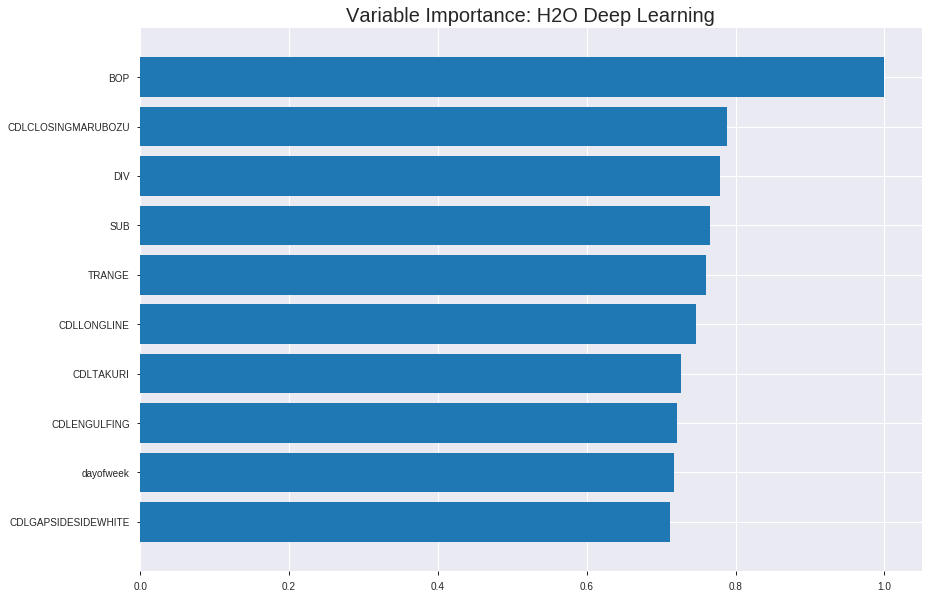

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190828_192251_model_6


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.18553261942283442
RMSE: 0.4307349758527097
LogLoss: 0.5465313760680743
Mean Per-Class Error: 0.2757613983269578
AUC: 0.7933250946085921
pr_auc: 0.7348954429922242
Gini: 0.5866501892171843
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.39298947289451847: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      437  406   0.4816   (406.0/843.0)
1      81   613   0.1167   (81.0/694.0)
Total  518  1019  0.3169   (487.0/1537.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.392989     0.715703  248
max f2                       0.190941     0.835203  323
max f0point5                 0.603824     0.70453   143
max accuracy                 0.564451     0.728042  162
max precision                0.959158     1         0
max recall                   0.0144688    1         391
max specificity              0.959158     1         0
max absolute_mcc             0.561385     0.449465  164
max min_per_class_accuracy   0.533788     0.721234  180
max mean_per_class_accuracy  0.53014      0.724239  182

Gains/Lift Table: Avg response rate: 45.15 %, avg score: 47.35 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104099                   0.915791           2.07628   2.07628            0.9375           0.932578   0.9375                      0.932578            0.0216138       0.0216138                  107.628   107.628
    2        0.0201692                   0.890946           1.9194    2.00037            0.866667         0.903287   0.903226                    0.918405            0.018732        0.0403458                  91.9404   100.037
    3        0.0305791                   0.857876           1.79944   1.93197            0.8125           0.872409   0.87234                     0.902747            0.018732        0.0590778                  79.9442   93.197
    4        0.0403383                   0.843047           1.9194    1.92893            0.866667         0.85077    0.870968                    0.890172            0.018732        0.0778098                  91.9404   92.893
    5        0.0500976                   0.827461           1.77176   1.89831            0.8              0.83468    0.857143                    0.879362            0.0172911       0.0951009                  77.1758   89.8312
    6        0.100195                    0.77731            1.7545    1.82641            0.792208         0.797858   0.824675                    0.83861             0.0878963       0.182997                   75.4501   82.6406
    7        0.150293                    0.736616           1.58193   1.74491            0.714286         0.757329   0.787879                    0.811516            0.0792507       0.262248                   58.1927   74.4913
    8        0.20039                     0.708973           1.61069   1.71136            0.727273         0.7208     0.772727                    0.788837            0.0806916       0.342939                   61.0689   71.1357
    9        0.299935                    0.652955           1.57779   1.66703            0.712418         0.68153    0.752711                    0.753223            0.157061        0.5                        57.7791   66.7028
    10       0.40013                     0.587269           1.35183   1.5881             0.61039          0.619205   0.717073                    0.719664            0.135447        0.635447                   35.1828   58.81
    11       0.500325                    0.520444           1.04982   1.4803             0.474026         0.55213    0.668401                    0.686114            0.105187        0.740634                   4.98241   48.0305
    12       0.59987                     0.444885           0.897459  1.38359            0.405229         0.486849   0.624729                    0.653047            0.0893372       0.829971                   -10.2541  38.3585
    13       0.700065                    0.353314           0.704676  1.28642            0.318182         0.400689   0.580855                    0.616929            0.0706052       0.900576                   -29.5324  28.6418
    14       0.79961                     0.191744           0.622431  1.20376            0.281046         0.278784   0.543531                    0.574833            0.0619597       0.962536                   -37.7569  20.3757
    15       0.899805                    0.0572641          0.273242  1.10014            0.123377         0.11448    0.496746                    0.523572            0.0273775       0.989914                   -72.6758  10.0143
    16       1                           0.0001759          0.100668  1                  0.0454545        0.0238971  0.451529                    0.4



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.20517700538019662
RMSE: 0.45296468447352123
LogLoss: 0.6074884939689069
Mean Per-Class Error: 0.2970337388686818
AUC: 0.7521112922781052
pr_auc: 0.6790146213964531
Gini: 0.5042225845562105
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4209413975822195: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      129  109  0.458    (109.0/238.0)
1      35   166  0.1741   (35.0/201.0)
Total  164  275  0.328    (144.0/439.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.420941     0.697479  247
max f2                       0.0164428    0.82648   377
max f0point5                 0.614576     0.674157  134
max accuracy                 0.499783     0.699317  205
max precision                0.939144     1         0
max recall                   0.0164428    1         377
max specificity              0.939144     1         0
max absolute_mcc             0.499783     0.405044  205
max min_per_class_accuracy   0.530388     0.686567  187
max mean_per_class_accuracy  0.499783     0.702966  205

Gains/Lift Table: Avg response rate: 45.79 %, avg score: 46.27 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113895                   0.893657           0.873632  0.873632           0.4              0.926545   0.4                         0.926545            0.00995025      0.00995025                 -12.6368  -12.6368
    2        0.0205011                   0.849954           2.18408   1.45605            1                0.870632   0.666667                    0.901695            0.0199005       0.0298507                  118.408   45.6053
    3        0.0318907                   0.832528           2.18408   1.71606            1                0.838492   0.785714                    0.879122            0.0248756       0.0547264                  118.408   71.6063
    4        0.0410023                   0.826208           2.18408   1.82007            1                0.828881   0.833333                    0.867958            0.0199005       0.0746269                  118.408   82.0066
    5        0.0501139                   0.812123           1.63806   1.78697            0.75             0.82111    0.818182                    0.85944             0.0149254       0.0895522                  63.806    78.6974
    6        0.100228                    0.74968            1.38987   1.58842            0.636364         0.777772   0.727273                    0.818606            0.0696517       0.159204                   38.9869   58.8422
    7        0.150342                    0.72485            1.6877    1.62151            0.772727         0.737999   0.742424                    0.791737            0.0845771       0.243781                   68.7698   62.1514
    8        0.200456                    0.70125            1.6877    1.63806            0.772727         0.712524   0.75                        0.771934            0.0845771       0.328358                   68.7698   63.806
    9        0.300683                    0.638196           1.48915   1.58842            0.681818         0.6715     0.727273                    0.738456            0.149254        0.477612                   48.9145   58.8422
    10       0.400911                    0.576211           1.19132   1.48915            0.545455         0.608718   0.681818                    0.706021            0.119403        0.597015                   19.1316   48.9145
    11       0.501139                    0.519791           1.09204   1.40972            0.5              0.549912   0.645455                    0.674799            0.109453        0.706468                   9.20398   40.9724
    12       0.599089                    0.434842           0.914266  1.32872            0.418605         0.479133   0.608365                    0.642808            0.0895522       0.79602                    -8.57341  32.8718
    13       0.699317                    0.334728           0.645296  1.23077            0.295455         0.393088   0.563518                    0.607018            0.0646766       0.860697                   -35.4704  23.0768
    14       0.799544                    0.186305           0.744573  1.16982            0.340909         0.264377   0.535613                    0.564066            0.0746269       0.935323                   -25.5427  16.982
    15       0.899772                    0.0351371          0.397105  1.08375            0.181818         0.103497   0.496203                    0.512762            0.039801        0.975124                   -60.2895  8.37458
    16       1                           0.000346901        0.248191  1                  0.113636         0.0132308  0.457859                    


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 19:26:55  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-28 19:26:57  2 min  5.685 sec  905 obs/sec       1         1             1537       0.527401         1.03273             -0.123162      0.758745        0.648273           1.79944          0.33637                          0.552379           1.13065               -0.229221        0.70282           0.624177             1.31045            0.412301
    2019-08-28 19:27:02  2 min 11.255 sec  1614 obs/sec      7         7             10759      0.430735         0.546531            0.250829       0.793325        0.734895           2.07628          0.316851                         0.452965           0.607488              0.17342          0.752111          0.679015             0.873632           0.328018
    2019-08-28 19:27:08  2 min 17.384 sec  2243 obs/sec      18        18            27666      0.418207         0.519634            0.293775       0.815741        0.765951           2.07628          0.277163                         0.464488           0.686283              0.130828         0.737771          0.669587             1.74726            0.318907
    2019-08-28 19:27:13  2 min 22.603 sec  2516 obs/sec      28        28            43036      0.406407         0.493948            0.333066       0.835981        0.790694           2.07628          0.25244                          0.462133           0.660445              0.139622         0.744774          0.67556              1.74726            0.312073
    2019-08-28 19:27:19  2 min 27.707 sec  2685 obs/sec      38        38            58406      0.39787          0.474701            0.360791       0.84857         0.806885           2.2147           0.243982                         0.464756           0.697355              0.129827         0.735921          0.675752             1.74726            0.309795
    2019-08-28 19:27:24  2 min 32.730 sec  2803 obs/sec      48        48            73776      0.389097         0.455158            0.388669       0.859451        0.823988           2.2147           0.234223                         0.464857           0.720313              0.129448         0.740896          0.675982             1.74726            0.298405
    2019-08-28 19:27:29  2 min 38.125 sec  2903 obs/sec      59        59            90683      0.378059         0.434209            0.422861       0.876257        0.843705           2.2147           0.217957                         0.467845           0.718084              0.118222         0.73706           0.67643              1.74726            0.307517
    2019-08-28 19:27:29  2 min 38.613 sec  2901 obs/sec      59        59            90683      0.430735         0.546531            0.250829       0.793325        0.734895           2.07628          0.316851                         0.452965           0.607488              0.17342          0.752111          0.679015             0.873632           0.328018

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  --------------------
BOP                 1.0                    1.0                  0.028769236740095204
CDLCLOSINGMARUBOZU  0.7880945801734924     0.7880945801734924   0.022672879550597144
DIV                 0.7797012329101562     0.7797012329101562   0.022431409356136394
SUB                 0.7660019397735596     0.7660019397735596   0.022037291148717685
TRANGE              0.7598641514778137     0.7598641514778137   0.021860711664176784
---                 ---                    ---                  ---
DX_20               0.6423813104629517     0.6423813104629517   0.01848081999812125
aroondown_20        0.6420032382011414     0.6420032382011414   0.01846994314771637
aroonup_20          0.6394179463386536     0.6394179463386536   0.018395566274082217
HT_DCPERIOD         0.6383299827575684     0.6383299827575684   0.018364266392253373
HT_TRENDMODE        0.6346995234489441     0.6346995234489441   0.01825982084892828


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7227272727272728)

('F1', 0.7325102880658436)

('auc', 0.7803707381661702)

('logloss', 0.5847544983117691)

('mean_per_class_error', 0.28177755710029795)

('rmse', 0.4416486234136638)

('mse', 0.19505350656318424)

deeplearning prediction progress: |███████████████████████████████████████| 100%


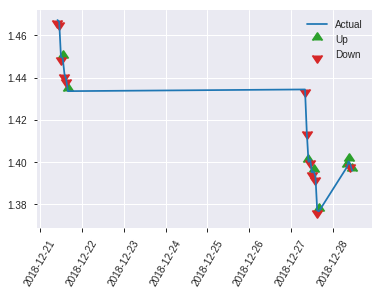


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.19505350656318424
RMSE: 0.4416486234136638
LogLoss: 0.5847544983117691
Mean Per-Class Error: 0.28177755710029795
AUC: 0.7803707381661702
pr_auc: 0.7647084007836774
Gini: 0.5607414763323404
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4301585076518523: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      66   48   0.4211   (48.0/114.0)
1      17   89   0.1604   (17.0/106.0)
Total  83   137  0.2955   (65.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.430159     0.73251   136
max f2                       0.117418     0.845771  178
max f0point5                 0.600265     0.734597  78
max accuracy                 0.600265     0.722727  78
max precision                0.908848     1         0
max recall                   0.0148034    1         207
max specificity              0.908848     1         0
max absolute_mcc             0.600265     0.453892  78
max min_per_class_accuracy   0.528596     0.692982  108
max mean_per_class_accuracy  0.598015     0.718222  80

Gains/Lift Table: Avg response rate: 48.18 %, avg score: 45.40 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136364                   0.902837           2.07547   2.07547            1                0.906758   1                           0.906758            0.0283019       0.0283019                  107.547   107.547
    2        0.0227273                   0.884474           2.07547   2.07547            1                0.896683   1                           0.902728            0.0188679       0.0471698                  107.547   107.547
    3        0.0318182                   0.859896           2.07547   2.07547            1                0.872331   1                           0.894043            0.0188679       0.0660377                  107.547   107.547
    4        0.0409091                   0.826579           2.07547   2.07547            1                0.840548   1                           0.882155            0.0188679       0.0849057                  107.547   107.547
    5        0.05                        0.805473           2.07547   2.07547            1                0.823725   1                           0.871532            0.0188679       0.103774                   107.547   107.547
    6        0.1                         0.74434            1.69811   1.88679            0.818182         0.77252    0.909091                    0.822026            0.0849057       0.188679                   69.8113   88.6792
    7        0.15                        0.704175           1.50943   1.76101            0.727273         0.731328   0.848485                    0.791793            0.0754717       0.264151                   50.9434   76.1006
    8        0.2                         0.669016           1.50943   1.69811            0.727273         0.684009   0.818182                    0.764847            0.0754717       0.339623                   50.9434   69.8113
    9        0.3                         0.62643            1.50943   1.63522            0.727273         0.650218   0.787879                    0.726637            0.150943        0.490566                   50.9434   63.522
    10       0.4                         0.584253           1.32075   1.5566             0.636364         0.603963   0.75                        0.695969            0.132075        0.622642                   32.0755   55.6604
    11       0.5                         0.527834           0.849057  1.41509            0.409091         0.557731   0.681818                    0.668321            0.0849057       0.707547                   -15.0943  41.5094
    12       0.6                         0.452867           1.03774   1.3522             0.5              0.496012   0.651515                    0.639603            0.103774        0.811321                   3.77358   35.2201
    13       0.7                         0.327913           0.471698  1.22642            0.227273         0.38667    0.590909                    0.60347             0.0471698       0.858491                   -52.8302  22.6415
    14       0.8                         0.1219             0.943396  1.19104            0.454545         0.23655    0.573864                    0.557605            0.0943396       0.95283                    -5.66038  19.1038
    15       0.9                         0.0283353          0.188679  1.07966            0.0909091        0.0668112  0.520202                    0.503072            0.0188679       0.971698                   -81.1321  7.96646
    16       1                           0.000852049        0.283019  1                  0.136364         0.0123413  0.481818                    

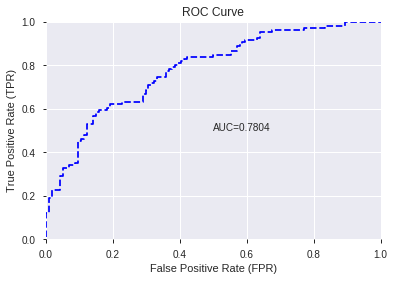

This function is available for GLM models only


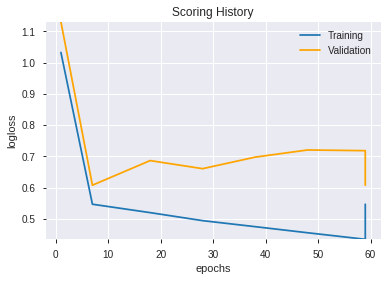

--2019-08-28 19:30:04--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.217.37.140
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.217.37.140|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


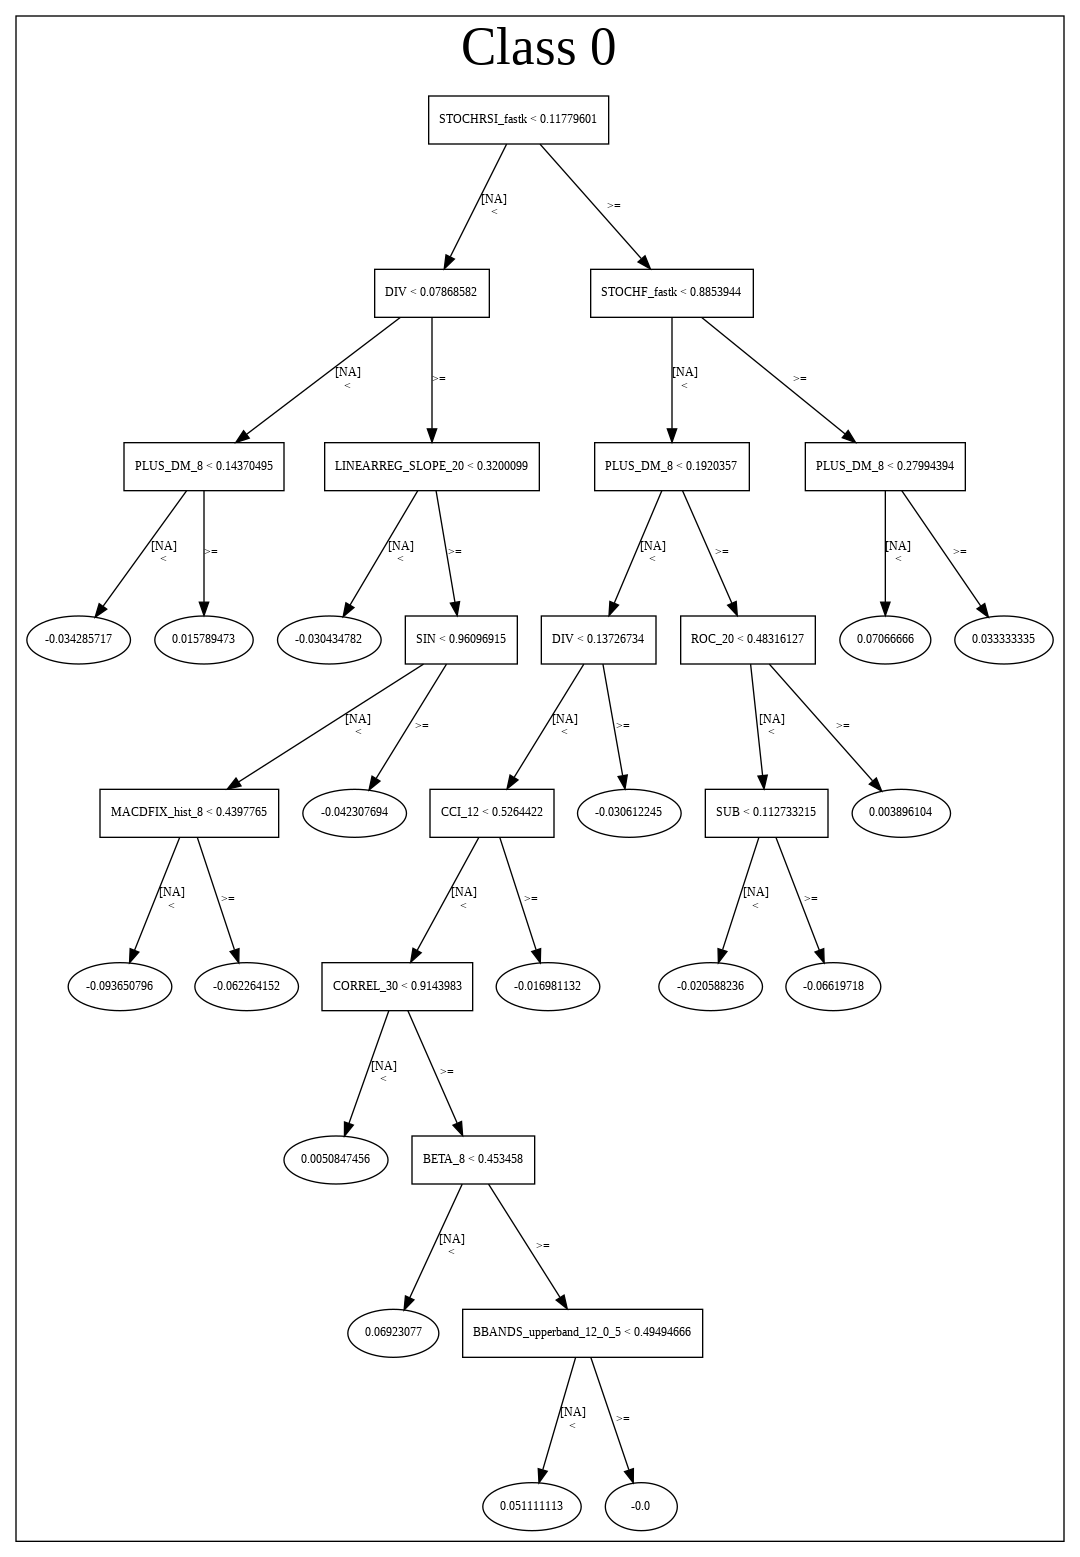

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190828_192251_model_6',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190828_192251_model_6',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_50_sid_8978',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['BOP',
 'CDLCLOSINGMARUBOZU',
 'DIV',
 'SUB',
 'TRANGE',
 'CDLLONGLINE',
 'CDLTAKURI',
 'CDLENGULFING',
 'dayofweek',
 'CDLGAPSIDESIDEWHITE',
 'CDLDRAGONFLYDOJI',
 'TAN',
 'day',
 'STOCHF_fastk',
 'CDLSTALLEDPATTERN',
 'hour',
 'CDLEVENINGSTAR',
 'CDLHAMMER',
 'weekday',
 'CDLRISEFALL3METHODS',
 'CDL3WHITESOLDIERS',
 'Volume',
 'CDLSHORTLINE',
 'aroonup_12',
 'CDLHIKKAKEMOD',
 'WILLR_24',
 'CDLEVENINGDOJISTAR',
 'PLUS_DM_8',
 'CORREL_8',
 'ULTOSC',
 'PLUS_DI_24',
 'CCI_8',
 'WILLR_8',
 'WILLR_20',
 'STOCHRSI_fastk',
 'STOCHRSI_fastd',
 'CDLBELTHOLD',
 'aroonup_8',
 'weekday_name',
 'DX_30',
 'CDLDOJI',
 'SAREXT',
 'CDLSPINNINGTOP',
 'aroonup_24',
 'DX_24',
 'DX_20',
 'aroondown_20',
 'aroonup_20',
 'HT_DCPERIOD',
 'HT_TRENDMODE']

In [20]:
# DeepLearning with top XGBoost features
model_train(feature_name='XGBF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse      mse
0  GLM_grid_1_AutoML_20190828_193101_model_1  0.780122  0.569868              0.282274  0.439352  0.19303

variable  relative_importance  scaled_importance  percentage
0                 DX_24             1.347425           1.000000    0.108304
1             CDLTAKURI             1.111440           0.824862    0.089336
2                   SUB             1.066510           0.791517    0.085725
3                   BOP             0.942235           0.699285    0.075736
4      CDLDRAGONFLYDOJI             0.924953           0.686460    0.074347
5                 DX_20             0.771344           0.572458    0.062000
6                 DX_30             0.631486           0.468661    0.050758
7              WILLR_24             0.538712           0.399808    0.043301
8          STOCHF_fastk             0.529617           0.393058    0.042570
9                   DIV             0.491002           0.364400    0.039466
10    CDL3WHITESOLDIERS             0.319666           0.237242    0.025694
11                CCI_8             0.312430           0.231872    0.025113
12              WILLR_8             0.311217           0.230971    0.025015
13           aroonup_12             0.192440           0.142821    0.015468
14  CDLGAPSIDESIDEWHITE             0.181893           0.134993    0.014620
15  CDLRISEFALL3METHODS             0.174610           0.129588    0.014035
16               ULTOSC             0.167935           0.124634    0.013498
17           aroonup_24             0.159805           0.118601    0.012845
18           PLUS_DI_24             0.152386           0.113094    0.012249
19                 hour             0.149530           0.110974    0.012019
20         aroondown_20             0.146391           0.108645    0.011767
21            aroonup_8             0.129920           0.096421    0.010443
22            CDLHAMMER             0.128705           0.095519    0.010345
23          CDLBELTHOLD             0.126667           0.094007    0.010181
24             CORREL_8             0.122588           0.090979    0.009853
25   CDLEVENINGDOJISTAR             0.122090           0.090610    0.009813
26       STOCHRSI_fastk             0.121412           0.090106    0.009759
27       CDLEVENINGSTAR             0.114091           0.084674    0.009171
28         CDLSHORTLINE             0.111568           0.082801    0.008968
29         HT_TRENDMODE             0.106750           0.079225    0.008580
30             WILLR_20             0.080388           0.059661    0.006462
31   CDLCLOSINGMARUBOZU             0.077428           0.057463    0.006224
32         CDLENGULFING             0.065705           0.048763    0.005281
33               Volume             0.063777           0.047333    0.005126
34                  day             0.054744           0.040629    0.004400
35         weekday_name             0.053544           0.039738    0.004304
36        CDLHIKKAKEMOD             0.048352           0.035885    0.003887
37               SAREXT             0.045324           0.033638    0.003643
38            PLUS_DM_8             0.040275           0.029890    0.003237
39       CDLSPINNINGTOP             0.034135           0.025333    0.002744
40    CDLSTALLEDPATTERN             0.027643           0.020515    0.002222
41                  TAN             0.026082           0.019357    0.002096
42          HT_DCPERIOD             0.024582           0.018244    0.001976
43              CDLDOJI             0.023644           0.017547    0.001900
44            dayofweek             0.018069           0.013410    0.001452
45               TRANGE             0.016723           0.012411    0.001344
46              weekday             0.014492           0.010756    0.001165
47       STOCHRSI_fastd             0.010328           0.007665    0.000830
48          CDLLONGLINE             0.006147           0.004562    0.000494
49           aroonup_20             0.002902           0.002154    0.000233

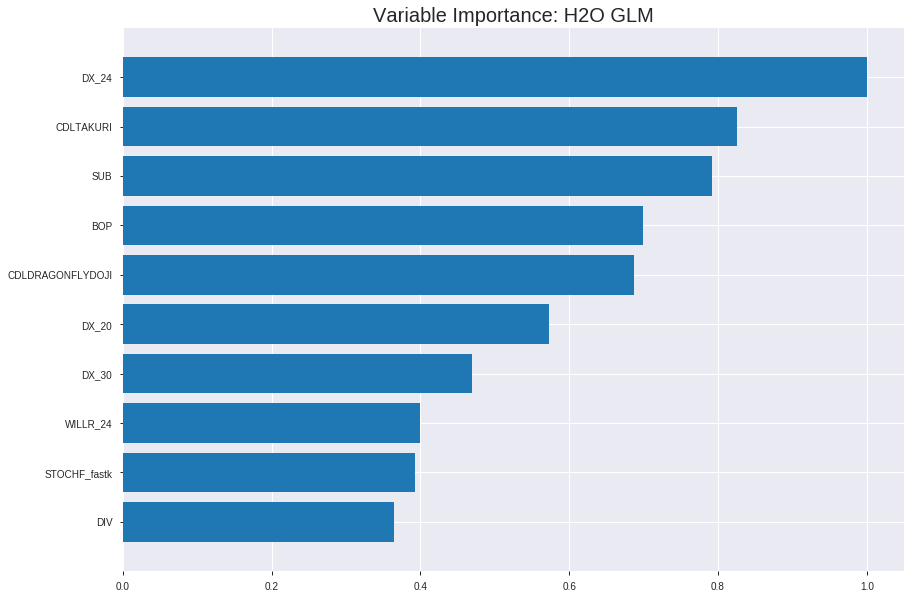

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190828_193101_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.18556845281975196
RMSE: 0.43077656948788656
LogLoss: 0.546991658842633
Null degrees of freedom: 1536
Residual degrees of freedom: 1486
Null deviance: 2116.267351263065
Residual deviance: 1681.4523592822538
AIC: 1783.4523592822538
AUC: 0.7906722936131081
pr_auc: 0.7194535438953699
Gini: 0.5813445872262162
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.28199674815935694: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      404  439   0.5208   (439.0/843.0)
1      62   632   0.0893   (62.0/694.0)
Total  466  1071  0.326    (501.0/1537.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.281997     0.716147  280
max f2                       0.156959     0.838456  333
max f0point5                 0.491206     0.693567  187
max accuracy                 0.491206     0.723487  187
max precision                0.999832     1         0
max recall                   0.03615      1         388
max specificity              0.999832     1         0
max absolute_mcc             0.449502     0.445233  208
max min_per_class_accuracy   0.470224     0.717675  198
max mean_per_class_accuracy  0.449502     0.723649  208

Gains/Lift Table: Avg response rate: 45.15 %, avg score: 45.15 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104099                   0.910808           1.93786    1.93786            0.875            0.944483   0.875                       0.944483            0.0201729       0.0201729                  93.786    93.786
    2        0.0201692                   0.887403           1.47646    1.7146             0.666667         0.899267   0.774194                    0.922605            0.0144092       0.0345821                  47.6465   71.4604
    3        0.0305791                   0.871863           1.66102    1.69636            0.75             0.879067   0.765957                    0.907783            0.0172911       0.0518732                  66.1023   69.6364
    4        0.0403383                   0.860088           2.06705    1.78605            0.933333         0.866137   0.806452                    0.897708            0.0201729       0.0720461                  106.705   78.6046
    5        0.0500976                   0.846081           2.06705    1.84079            0.933333         0.852917   0.831169                    0.888982            0.0201729       0.092219                   106.705   84.0787
    6        0.100195                    0.79573            1.78326    1.81203            0.805195         0.818798   0.818182                    0.85389             0.0893372       0.181556                   78.3263   81.2025
    7        0.150293                    0.744007           1.72574    1.78326            0.779221         0.769272   0.805195                    0.825684            0.0864553       0.268012                   72.5738   78.3263
    8        0.20039                     0.701678           1.55316    1.72574            0.701299         0.721978   0.779221                    0.799757            0.0778098       0.345821                   55.3164   72.5738
    9        0.299935                    0.624083           1.49094    1.64781            0.673203         0.661538   0.744035                    0.753884            0.148415        0.494236                   49.094    64.7812
    10       0.40013                     0.547053           1.2943     1.55929            0.584416         0.581726   0.704065                    0.710775            0.129683        0.623919                   29.4304   55.9291
    11       0.500325                    0.452402           1.17925    1.48318            0.532468         0.498253   0.669701                    0.668215            0.118156        0.742075                   17.9254   48.3185
    12       0.59987                     0.355634           0.839558   1.37638            0.379085         0.406495   0.621475                    0.624784            0.0835735       0.825648                   -16.0442  37.6379
    13       0.700065                    0.277286           0.862869   1.30288            0.38961          0.31716    0.58829                     0.580756            0.0864553       0.912104                   -13.7131  30.2884
    14       0.79961                     0.194171           0.50663    1.20376            0.228758         0.23604    0.543531                    0.537842            0.0504323       0.962536                   -49.337   20.3757
    15       0.899805                    0.112618           0.287623   1.10174            0.12987          0.14849    0.497469                    0.494487            0.0288184       0.991354                   -71.2377  10.1744
    16       1                           6.87975e-05        0.0862869  1                  0.038961         0.0657483  0.451529  



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.20029775239883393
RMSE: 0.44754636899301725
LogLoss: 0.5803743037361818
Null degrees of freedom: 438
Residual degrees of freedom: 388
Null deviance: 605.5320386942669
Residual deviance: 509.5686386803677
AIC: 611.5686386803677
AUC: 0.7554768175927087
pr_auc: 0.6953459404732828
Gini: 0.5109536351854174
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2846651236600519: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      113  125  0.5252   (125.0/238.0)
1      28   173  0.1393   (28.0/201.0)
Total  141  298  0.3485   (153.0/439.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.284665     0.693387  272
max f2                       0.161155     0.834746  339
max f0point5                 0.473717     0.665072  190
max accuracy                 0.473717     0.694761  190
max precision                0.991431     1         0
max recall                   0.102826     1         362
max specificity              0.991431     1         0
max absolute_mcc             0.432323     0.388712  212
max min_per_class_accuracy   0.473717     0.691542  190
max mean_per_class_accuracy  0.456657     0.69473   201

Gains/Lift Table: Avg response rate: 45.79 %, avg score: 44.57 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113895                   0.858636           1.74726    1.74726            0.8              0.913861   0.8                         0.913861            0.0199005       0.0199005                  74.7264   74.7264
    2        0.0205011                   0.844617           1.63806    1.69873            0.75             0.849258   0.777778                    0.885148            0.0149254       0.0348259                  63.806    69.8729
    3        0.0318907                   0.827166           1.74726    1.71606            0.8              0.834061   0.785714                    0.866903            0.0199005       0.0547264                  74.7264   71.6063
    4        0.0410023                   0.812753           2.18408    1.82007            1                0.820002   0.833333                    0.85648             0.0199005       0.0746269                  118.408   82.0066
    5        0.0501139                   0.801358           1.63806    1.78697            0.75             0.809313   0.818182                    0.847904            0.0149254       0.0895522                  63.806    78.6974
    6        0.100228                    0.758085           1.58842    1.6877             0.727273         0.78041    0.772727                    0.814157            0.079602        0.169154                   58.8422   68.7698
    7        0.150342                    0.725351           1.58842    1.65461            0.727273         0.744054   0.757576                    0.79079             0.079602        0.248756                   58.8422   65.4606
    8        0.200456                    0.687695           1.58842    1.63806            0.727273         0.707502   0.75                        0.769968            0.079602        0.328358                   58.8422   63.806
    9        0.300683                    0.611151           1.38987    1.55533            0.636364         0.650234   0.712121                    0.730057            0.139303        0.467662                   38.9869   55.5329
    10       0.400911                    0.524684           1.19132    1.46433            0.545455         0.580526   0.670455                    0.692674            0.119403        0.587065                   19.1316   46.4326
    11       0.501139                    0.463243           1.19132    1.40972            0.545455         0.493164   0.645455                    0.652772            0.119403        0.706468                   19.1316   40.9724
    12       0.599089                    0.367914           0.863473   1.32041            0.395349         0.41286    0.604563                    0.613547            0.0845771       0.791045                   -13.6527  32.0413
    13       0.699317                    0.266076           0.794211   1.245              0.363636         0.319005   0.570033                    0.571332            0.079602        0.870647                   -20.5789  24.4997
    14       0.799544                    0.199507           0.744573   1.18227            0.340909         0.231982   0.541311                    0.528793            0.0746269       0.945274                   -25.5427  18.2265
    15       0.899772                    0.111637           0.446744   1.10033            0.204545         0.160588   0.503797                    0.487777            0.0447761       0.99005                    -55.3256  10.0334
    16       1                           0.00017574         0.0992763  1                  0.0454545        0.0675667  0.457859  


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------  -----------  --------  ------------  ------------------  ------------------
     2019-08-28 19:31:01  0.000 sec   2            .2E2      51            1.3580199763650125  1.3628286456206826
     2019-08-28 19:31:01  0.008 sec   4            .13E2     51            1.3479627808625525  1.3540850118198777
     2019-08-28 19:31:01  0.015 sec   6            .78E1     51            1.3336015486950712  1.3416768701251234
     2019-08-28 19:31:01  0.022 sec   8            .48E1     51            1.3142290681565039  1.3250880206907363
     2019-08-28 19:31:01  0.030 sec   10           .3E1      51            1.2898571681581144  1.304495902705659
---  ---                  ---         ---          ---       ---           ---                 ---
     2019-08-28 19:31:01  0.186 sec   48           .14E-3    51            1.0941985074848952  1.1618348937614484
     2019-08-28 19:31:01  0.191 sec   49           .84E-4    51            1.0940967751630488  1.1613578694088966
     2019-08-28 19:31:01  0.196 sec   50           .52E-4    51            1.0940359174011542  1.161049281524119
     2019-08-28 19:31:01  0.200 sec   51           .32E-4    51            1.0940020283316327  1.1608681035308346
     2019-08-28 19:31:01  0.205 sec   52           .2E-4     51            1.093983317685266   1.1607486074723639


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7227272727272728)

('F1', 0.7364016736401673)

('auc', 0.7801224760013241)

('logloss', 0.5698676437658208)

('mean_per_class_error', 0.2801224760013241)

('rmse', 0.4393519309392769)

('mse', 0.1930301192200711)

glm prediction progress: |████████████████████████████████████████████████| 100%


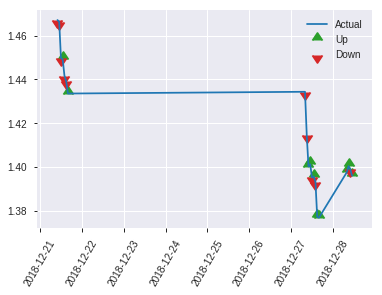


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.1930301192200711
RMSE: 0.4393519309392769
LogLoss: 0.5698676437658208
Null degrees of freedom: 219
Residual degrees of freedom: 169
Null deviance: 305.5060851051157
Residual deviance: 250.74176325696115
AIC: 352.7417632569611
AUC: 0.7801224760013241
pr_auc: 0.7287351535540179
Gini: 0.5602449520026482
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3545312389570052: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      69   45   0.3947   (45.0/114.0)
1      18   88   0.1698   (18.0/106.0)
Total  87   133  0.2864   (63.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.354531     0.736402  132
max f2                       0.108088     0.842697  198
max f0point5                 0.574134     0.732558  80
max accuracy                 0.574134     0.722727  80
max precision                0.91986      1         0
max recall                   0.0576821    1         210
max specificity              0.91986      1         0
max absolute_mcc             0.574134     0.452152  80
max min_per_class_accuracy   0.473261     0.684211  108
max mean_per_class_accuracy  0.528218     0.719878  90

Gains/Lift Table: Avg response rate: 48.18 %, avg score: 44.41 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136364                   0.892597           1.38365   1.38365            0.666667         0.91043    0.666667                    0.91043             0.0188679       0.0188679                  38.3648   38.3648
    2        0.0227273                   0.867512           2.07547   1.66038            1                0.87793    0.8                         0.89743             0.0188679       0.0377358                  107.547   66.0377
    3        0.0318182                   0.845726           2.07547   1.77898            1                0.8575     0.857143                    0.886021            0.0188679       0.0566038                  107.547   77.8976
    4        0.0409091                   0.836263           1.03774   1.61426            0.5              0.837448   0.777778                    0.875227            0.00943396      0.0660377                  3.77358   61.4256
    5        0.05                        0.82131            2.07547   1.69811            1                0.83011    0.818182                    0.867024            0.0188679       0.0849057                  107.547   69.8113
    6        0.1                         0.760495           1.69811   1.69811            0.818182         0.78988    0.818182                    0.828452            0.0849057       0.169811                   69.8113   69.8113
    7        0.15                        0.725819           1.69811   1.69811            0.818182         0.743406   0.818182                    0.800103            0.0849057       0.254717                   69.8113   69.8113
    8        0.2                         0.676973           1.69811   1.69811            0.818182         0.701345   0.818182                    0.775414            0.0849057       0.339623                   69.8113   69.8113
    9        0.3                         0.619007           1.50943   1.63522            0.727273         0.646748   0.787879                    0.732525            0.150943        0.490566                   50.9434   63.522
    10       0.4                         0.541597           1.32075   1.5566             0.636364         0.583907   0.75                        0.695371            0.132075        0.622642                   32.0755   55.6604
    11       0.5                         0.471039           0.754717  1.39623            0.363636         0.504721   0.672727                    0.657241            0.0754717       0.698113                   -24.5283  39.6226
    12       0.6                         0.356891           1.22642   1.36792            0.590909         0.414927   0.659091                    0.616855            0.122642        0.820755                   22.6415   36.7925
    13       0.7                         0.250583           0.566038  1.25337            0.272727         0.305872   0.603896                    0.572429            0.0566038       0.877358                   -43.3962  25.3369
    14       0.8                         0.194206           0.660377  1.17925            0.318182         0.221301   0.568182                    0.528538            0.0660377       0.943396                   -33.9623  17.9245
    15       0.9                         0.118959           0.377358  1.09015            0.181818         0.155088   0.525253                    0.487044            0.0377358       0.981132                   -62.2642  9.01468
    16       1                           0.00925335         0.188679  1                  0.0909091        0.0578666  0.481818                    

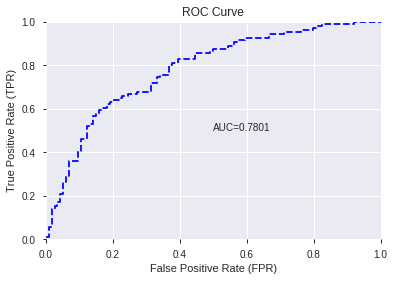

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


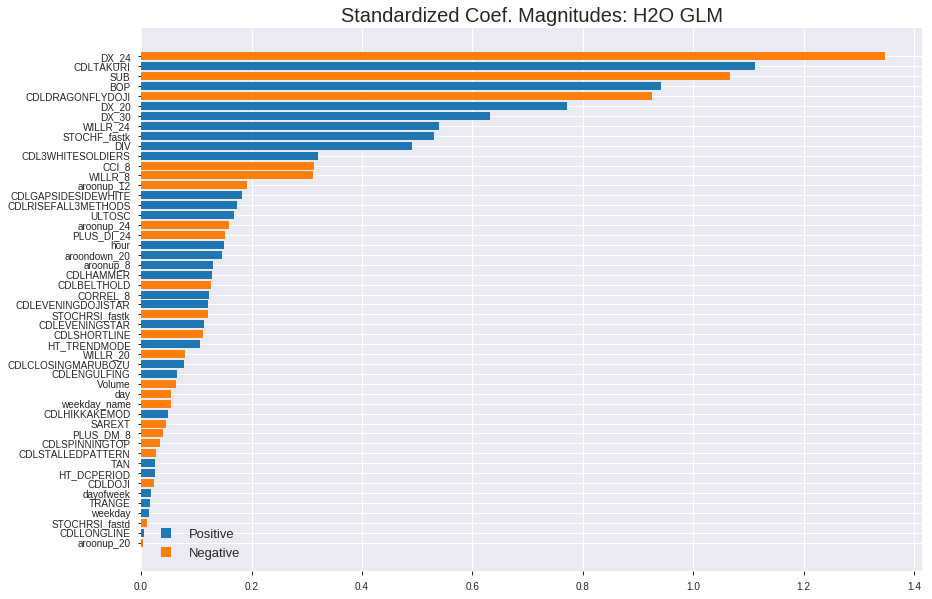

'log_likelihood'
--2019-08-28 19:31:11--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.113.211
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.113.211|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


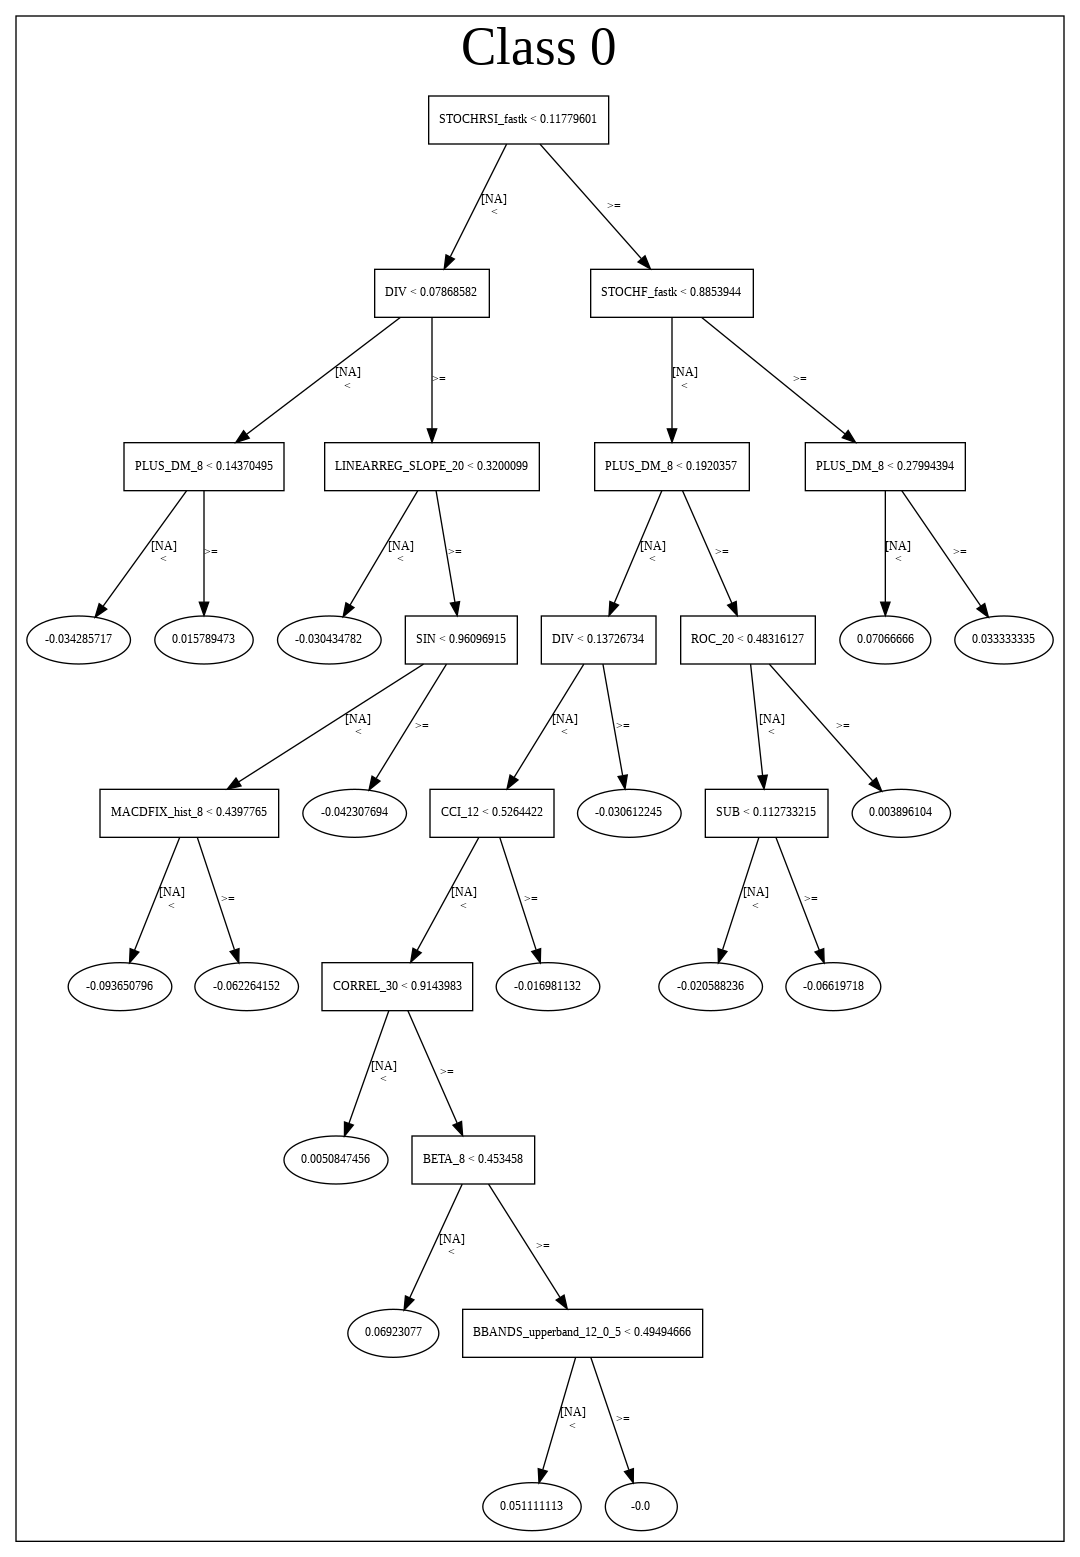

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190828_193101_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190828_193101_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_58_sid_8978',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_58_s

['DX_24',
 'CDLTAKURI',
 'SUB',
 'BOP',
 'CDLDRAGONFLYDOJI',
 'DX_20',
 'DX_30',
 'WILLR_24',
 'STOCHF_fastk',
 'DIV',
 'CDL3WHITESOLDIERS',
 'CCI_8',
 'WILLR_8',
 'aroonup_12',
 'CDLGAPSIDESIDEWHITE',
 'CDLRISEFALL3METHODS',
 'ULTOSC',
 'aroonup_24',
 'PLUS_DI_24',
 'hour',
 'aroondown_20',
 'aroonup_8',
 'CDLHAMMER',
 'CDLBELTHOLD',
 'CORREL_8',
 'CDLEVENINGDOJISTAR',
 'STOCHRSI_fastk',
 'CDLEVENINGSTAR',
 'CDLSHORTLINE',
 'HT_TRENDMODE',
 'WILLR_20',
 'CDLCLOSINGMARUBOZU',
 'CDLENGULFING',
 'Volume',
 'day',
 'weekday_name',
 'CDLHIKKAKEMOD',
 'SAREXT',
 'PLUS_DM_8',
 'CDLSPINNINGTOP',
 'CDLSTALLEDPATTERN',
 'TAN',
 'HT_DCPERIOD',
 'CDLDOJI',
 'dayofweek',
 'TRANGE',
 'weekday',
 'STOCHRSI_fastd',
 'CDLLONGLINE',
 'aroonup_20']

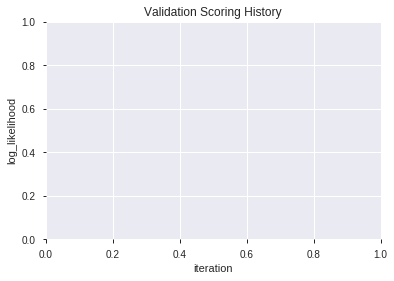

In [21]:
# GLM with top XGBoost features
model_train(feature_name='XGBF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190828_193207_model_5  0.769116  0.580351              0.259351  0.444791  0.197839
1               XGBoost_3_AutoML_20190828_193207  0.766468  0.574038              0.279626  0.442239  0.195575
2  XGBoost_grid_1_AutoML_20190828_193207_model_3  0.764730  0.576133              0.280619  0.443465  0.196661
3  XGBoost_grid_1_AutoML_20190828_193207_model_2  0.759930  0.575720              0.274909  0.442731  0.196011
4  XGBoost_grid_1_AutoML_20190828_193207_model_1  0.759682  0.578936              0.284674  0.444931  0.197964
5  XGBoost_grid_1_AutoML_20190828_193207_model_7  0.757531  0.587910              0.282274  0.449518  0.202066
6               XGBoost_1_AutoML_20190828_193207  0.756786  0.592177              0.268123  0.450832  0.203249
7  XGBoost_grid_1_AutoML_20190828_193207_model_6  0.751159  0.586136              0.276564  0.447628  0.200371
8               XGBoost_2_AutoML_20190828_193207  0.749586  0.592656              0.309666  0.451075  0.203469
9  XGBoost_grid_1_AutoML_20190828_193207_model_4  0.748345  0.583048              0.271185  0.447572  0.200321

variable  relative_importance  scaled_importance  percentage
0                  BOP          2256.226074           1.000000    0.109409
1               Volume          1109.620361           0.491804    0.053808
2               TRANGE           915.581177           0.405802    0.044398
3         STOCHF_fastk           898.861328           0.398392    0.043588
4            PLUS_DM_8           874.302307           0.387507    0.042397
5                  DIV           755.535767           0.334867    0.036637
6              WILLR_8           751.807495           0.333215    0.036457
7                CCI_8           744.744202           0.330084    0.036114
8                 hour           740.460754           0.328186    0.035906
9               SAREXT           721.660767           0.319853    0.034995
10               DX_20           710.905518           0.315086    0.034473
11            CORREL_8           708.892578           0.314194    0.034376
12          PLUS_DI_24           683.319092           0.302859    0.033136
13                 TAN           644.565369           0.285683    0.031256
14              ULTOSC           623.512817           0.276352    0.030235
15                 SUB           592.803406           0.262741    0.028746
16            WILLR_20           585.097290           0.259326    0.028373
17                 day           576.454163           0.255495    0.027953
18               DX_30           555.512146           0.246213    0.026938
19      STOCHRSI_fastd           535.215454           0.237217    0.025954
20         HT_DCPERIOD           527.556030           0.233822    0.025582
21               DX_24           440.276398           0.195138    0.021350
22            WILLR_24           428.283783           0.189823    0.020768
23        aroondown_20           371.134613           0.164494    0.017997
24      STOCHRSI_fastk           362.832550           0.160814    0.017594
25          aroonup_12           354.131378           0.156957    0.017173
26          aroonup_20           330.638275           0.146545    0.016033
27           dayofweek           326.156403           0.144558    0.015816
28          aroonup_24           319.644958           0.141672    0.015500
29           aroonup_8           271.538879           0.120351    0.013167
30        weekday_name           155.477982           0.068911    0.007539
31             weekday           109.888069           0.048704    0.005329
32         CDLLONGLINE            88.993454           0.039444    0.004315
33      CDLSPINNINGTOP            84.757080           0.037566    0.004110
34           CDLHAMMER            82.075089           0.036377    0.003980
35        CDLENGULFING            77.968620           0.034557    0.003781
36             CDLDOJI            63.598217           0.028188    0.003084
37        CDLSHORTLINE            56.008774           0.024824    0.002716
38         CDLBELTHOLD            47.702263           0.021143    0.002313
39    CDLDRAGONFLYDOJI            34.519169           0.015300    0.001674
40        HT_TRENDMODE            34.058441           0.015095    0.001652
41  CDLCLOSINGMARUBOZU            33.990311           0.015065    0.001648
42           CDLTAKURI            33.672405           0.014924    0.001633
43   CDLSTALLEDPATTERN             1.959301           0.000868    0.000095

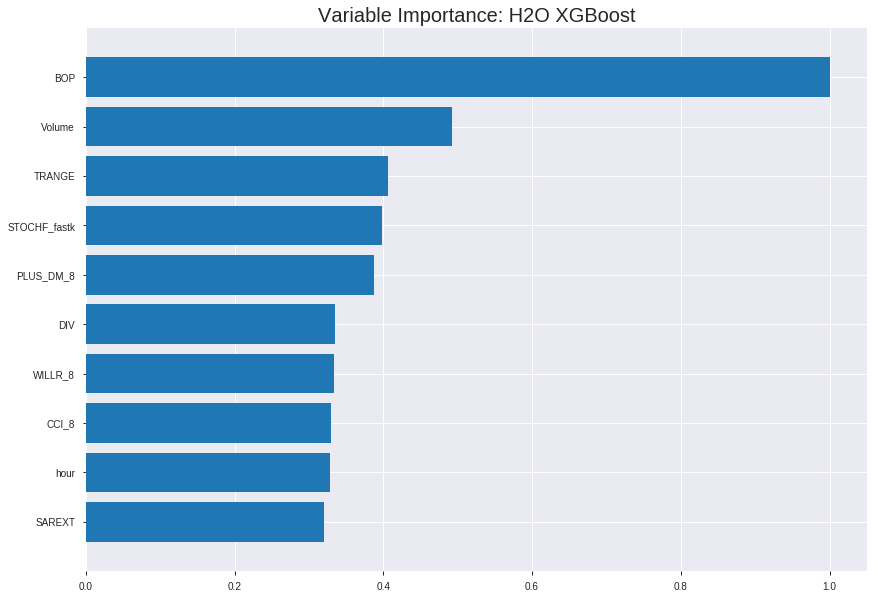

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190828_193207_model_5


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.1555507086130727
RMSE: 0.39439917420434933
LogLoss: 0.471571622057726
Mean Per-Class Error: 0.27876631079478054
AUC: 0.839792698643858
pr_auc: 0.8802801439514847
Gini: 0.6795853972877159
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.48959997296333313: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      373  470   0.5575   (470.0/843.0)
1      0    694   0        (0.0/694.0)
Total  373  1164  0.3058   (470.0/1537.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.4896       0.74704   185
max f2                       0.4896       0.880711  185
max f0point5                 0.562911     0.789054  182
max accuracy                 0.562911     0.741705  182
max precision                0.945098     1         0
max recall                   0.4896       1         185
max specificity              0.945098     1         0
max absolute_mcc             0.562911     0.539388  182
max min_per_class_accuracy   0.5          0.442467  184
max mean_per_class_accuracy  0.4896       0.721234  185

Gains/Lift Table: Avg response rate: 45.15 %, avg score: 47.75 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104099                   0.916965           2.2147    2.2147             1                0.932693   1                           0.932693            0.0230548       0.0230548                  121.47    121.47
    2        0.0201692                   0.904787           2.2147    2.2147             1                0.911983   1                           0.922672            0.0216138       0.0446686                  121.47    121.47
    3        0.0305791                   0.889734           2.2147    2.2147             1                0.896877   1                           0.913891            0.0230548       0.0677233                  121.47    121.47
    4        0.0403383                   0.879905           2.2147    2.2147             1                0.885281   1                           0.906969            0.0216138       0.0893372                  121.47    121.47
    5        0.0500976                   0.872086           2.2147    2.2147             1                0.87551    1                           0.900841            0.0216138       0.110951                   121.47    121.47
    6        0.100195                    0.824974           2.2147    2.2147             1                0.848157   1                           0.874499            0.110951        0.221902                   121.47    121.47
    7        0.150293                    0.774523           2.2147    2.2147             1                0.803548   1                           0.850849            0.110951        0.332853                   121.47    121.47
    8        0.756669                    0.5                1.09784   1.31968            0.495708         0.515039   0.595873                    0.581739            0.665706        0.998559                   9.78436   31.9678
    9        0.79961                     0.222148           0.033556  1.25061            0.0151515        0.289559   0.564687                    0.566048            0.00144092      1                          -96.6444  25.061
    10       0.899805                    0.116673           0         1.11135            0                0.168297   0.501808                    0.521758            0               1                          -100      11.1352
    11       1                           0.0435454          0         1                  0                0.0803605  0.451529                    0.477532            0               1                          -100      0



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.22745498726334565
RMSE: 0.47692241220490533
LogLoss: 0.6433157033367383
Mean Per-Class Error: 0.38815376897027465
AUC: 0.6334503950834065
pr_auc: 0.6043295056657974
Gini: 0.266900790166813
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.268034428358078: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      64   174  0.7311   (174.0/238.0)
1      11   190  0.0547   (11.0/201.0)
Total  75   364  0.4214   (185.0/439.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.268034     0.672566  128
max f2                       0.175957     0.81864   151
max f0point5                 0.309664     0.576565  117
max accuracy                 0.529545     0.596811  65
max precision                0.928578     1         0
max recall                   0.0681826    1         199
max specificity              0.928578     1         0
max absolute_mcc             0.268034     0.283522  128
max min_per_class_accuracy   0.5          0.365546  73
max mean_per_class_accuracy  0.309664     0.611846  117

Gains/Lift Table: Avg response rate: 45.79 %, avg score: 45.14 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113895                   0.856393           2.18408   2.18408            1                0.902607  1                           0.902607            0.0248756       0.0248756                  118.408   118.408
    2        0.0205011                   0.820327           1.63806   1.9414             0.75             0.833587  0.888889                    0.871931            0.0149254       0.039801                   63.806    94.1404
    3        0.0318907                   0.798722           0.873632  1.56006            0.4              0.810663  0.714286                    0.85005             0.00995025      0.0497512                  -12.6368  56.0057
    4        0.0410023                   0.765661           2.18408   1.69873            1                0.776551  0.777778                    0.833717            0.0199005       0.0696517                  118.408   69.8729
    5        0.0501139                   0.700348           1.09204   1.58842            0.5              0.742764  0.727273                    0.81718             0.00995025      0.079602                   9.20398   58.8422
    6        0.100228                    0.599217           1.38987   1.48915            0.636364         0.660193  0.681818                    0.738686            0.0696517       0.149254                   38.9869   48.9145
    7        0.150342                    0.523382           1.48915   1.48915            0.681818         0.563831  0.681818                    0.680401            0.0746269       0.223881                   48.9145   48.9145
    8        0.703872                    0.5                1.01564   1.11678            0.465021         0.500288  0.511327                    0.538759            0.562189        0.78607                    1.5642    11.6779
    9        0.799544                    0.314381           1.35205   1.14493            0.619048         0.411554  0.524217                    0.523538            0.129353        0.915423                   35.2049   14.4931
    10       0.899772                    0.151085           0.54602   1.07822            0.25             0.228312  0.493671                    0.490652            0.0547264       0.970149                   -45.398   7.82165
    11       1                           0.0526804          0.297829  1                  0.136364         0.09921   0.457859                    0.451418            0.0298507       1                          -70.2171  0


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 19:32:16  4.258 sec   0                  0.5              0.693147            0.5             0                  1                0.548471                         0.5                0.693147              0.5               0                    1                  0.542141
    2019-08-28 19:32:16  4.579 sec   5                  0.437163         0.574155            0.976485        0.969587           2.2147           0.0728692                        0.480297           0.654117              0.711965          0.636329             1.74726            0.323462
    2019-08-28 19:32:16  4.861 sec   10                 0.384332         0.482654            0.995809        0.993892           2.2147           0.0312297                        0.466663           0.626914              0.734667          0.649359             1.31045            0.330296
    2019-08-28 19:32:17  5.138 sec   15                 0.341249         0.412473            0.998265        0.996513           2.2147           0.0201692                        0.457142           0.607195              0.745715          0.6679               2.18408            0.318907
    2019-08-28 19:32:17  5.431 sec   20                 0.306766         0.358777            0.999211        0.997618           2.2147           0.0130124                        0.451676           0.594945              0.752143          0.680947             2.18408            0.298405
    2019-08-28 19:32:17  5.706 sec   25                 0.277586         0.314784            0.999497        0.997957           2.2147           0.00910865                       0.447402           0.585405              0.760191          0.688668             2.18408            0.305239
    2019-08-28 19:32:18  6.007 sec   30                 0.251952         0.277779            0.999822        0.998348           2.2147           0.00650618                       0.447316           0.584263              0.757881          0.686602             2.18408            0.296128
    2019-08-28 19:32:18  6.326 sec   35                 0.373456         0.442992            0.900162        0.916991           2.2147           0.243331                         0.495821           0.684136              0.527112          0.733919             2.18408            0.530752
    2019-08-28 19:32:18  6.649 sec   40                 0.4055           0.496901            0.829002        0.876155           2.2147           0.322056                         0.495683           0.683712              0.52312           0.68062              2.18408            0.530752
    2019-08-28 19:32:19  6.949 sec   45                 0.397337         0.479475            0.840594        0.88096            2.2147           0.305791                         0.495661           0.683597              0.523099          0.680614             2.18408            0.53303
    2019-08-28 19:32:19  7.261 sec   50                 0.394399         0.471572            0.839793        0.88028            2.2147           0.305791                         0.476922           0.643316              0.63345           0.60433              2.18408            0.421412

Variable Importances: 


variable            relative_importance    scaled_importance     percentage
------------------  ---------------------  --------------------  ---------------------
BOP                 2256.22607421875       1.0                   0.10940900899041611
Volume              1109.620361328125      0.49180371329249295   0.053807756889138386
TRANGE              915.5811767578125      0.4058020546876471    0.04439840064965011
STOCHF_fastk        898.861328125          0.3983915168768021    0.04358762105167955
PLUS_DM_8           874.3023071289062      0.38750651679781056   0.04239670398017649
---                 ---                    ---                   ---
CDLDRAGONFLYDOJI    34.519168853759766     0.015299516856134425  0.001673904977261834
HT_TRENDMODE        34.058441162109375     0.015095314051763446  0.0016515633508025415
CDLCLOSINGMARUBOZU  33.99031066894531      0.015065117391090756  0.0016482595640835225
CDLTAKURI           33.67240524291992      0.014924215985128825  0.0016328436808918712
CDLSTALLEDPATTERN   1.9593009948730469     0.000868397461256839  9.501050564590401e-05


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7363636363636363)

('F1', 0.7583333333333333)

('auc', 0.769116186693148)

('logloss', 0.5803508377356069)

('mean_per_class_error', 0.2593512082092022)

('rmse', 0.44479060628741796)

('mse', 0.19783868344152883)

xgboost prediction progress: |████████████████████████████████████████████| 100%


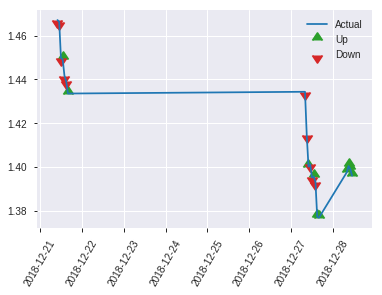


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.19783868344152883
RMSE: 0.44479060628741796
LogLoss: 0.5803508377356069
Mean Per-Class Error: 0.2593512082092022
AUC: 0.769116186693148
pr_auc: 0.7151151388511457
Gini: 0.5382323733862959
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3305070698261261: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      71   43   0.3772   (43.0/114.0)
1      15   91   0.1415   (15.0/106.0)
Total  86   134  0.2636   (58.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.330507     0.758333  133
max f2                       0.117585     0.845771  178
max f0point5                 0.343217     0.709779  131
max accuracy                 0.343217     0.736364  131
max precision                0.850203     0.933333  14
max recall                   0.067275     1         210
max specificity              0.917633     0.991228  0
max absolute_mcc             0.330507     0.492853  133
max min_per_class_accuracy   0.445149     0.701754  108
max mean_per_class_accuracy  0.330507     0.740649  133

Gains/Lift Table: Avg response rate: 48.18 %, avg score: 44.40 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136364                   0.905183           1.38365   1.38365            0.666667         0.909581   0.666667                    0.909581            0.0188679       0.0188679                  38.3648   38.3648
    2        0.0227273                   0.892344           2.07547   1.66038            1                0.901028   0.8                         0.90616             0.0188679       0.0377358                  107.547   66.0377
    3        0.0318182                   0.881501           2.07547   1.77898            1                0.88297    0.857143                    0.899534            0.0188679       0.0566038                  107.547   77.8976
    4        0.0409091                   0.873623           2.07547   1.84486            1                0.87919    0.888889                    0.895013            0.0188679       0.0754717                  107.547   84.4864
    5        0.05                        0.866826           2.07547   1.88679            1                0.870464   0.909091                    0.89055             0.0188679       0.0943396                  107.547   88.6792
    6        0.1                         0.808491           1.32075   1.60377            0.636364         0.837721   0.772727                    0.864135            0.0660377       0.160377                   32.0755   60.3774
    7        0.15                        0.773039           1.69811   1.63522            0.818182         0.792463   0.787879                    0.840244            0.0849057       0.245283                   69.8113   63.522
    8        0.2                         0.729159           1.69811   1.65094            0.818182         0.747518   0.795455                    0.817063            0.0849057       0.330189                   69.8113   65.0943
    9        0.3                         0.64406            1.13208   1.47799            0.545455         0.683763   0.712121                    0.77263             0.113208        0.443396                   13.2075   47.7987
    10       0.4                         0.540832           1.22642   1.41509            0.590909         0.592733   0.681818                    0.727655            0.122642        0.566038                   22.6415   41.5094
    11       0.5                         0.441091           1.50943   1.43396            0.727273         0.493103   0.690909                    0.680745            0.150943        0.716981                   50.9434   43.3962
    12       0.6                         0.340603           1.32075   1.41509            0.636364         0.403451   0.681818                    0.634529            0.132075        0.849057                   32.0755   41.5094
    13       0.7                         0.236561           0.566038  1.2938             0.272727         0.290041   0.623377                    0.585317            0.0566038       0.90566                    -43.3962  29.3801
    14       0.8                         0.122299           0.471698  1.19104            0.227273         0.17318    0.573864                    0.5338              0.0471698       0.95283                    -52.8302  19.1038
    15       0.9                         0.0846172          0.188679  1.07966            0.0909091        0.100616   0.520202                    0.485668            0.0188679       0.971698                   -81.1321  7.96646
    16       1                           0.0451982          0.283019  1                  0.136364         0.0686917  0.481818                    

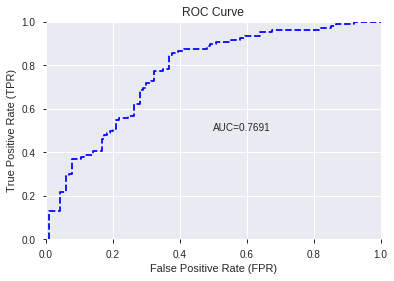

This function is available for GLM models only


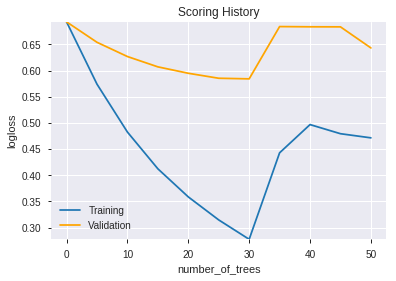

--2019-08-28 19:32:30--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.86.83
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.86.83|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.ge

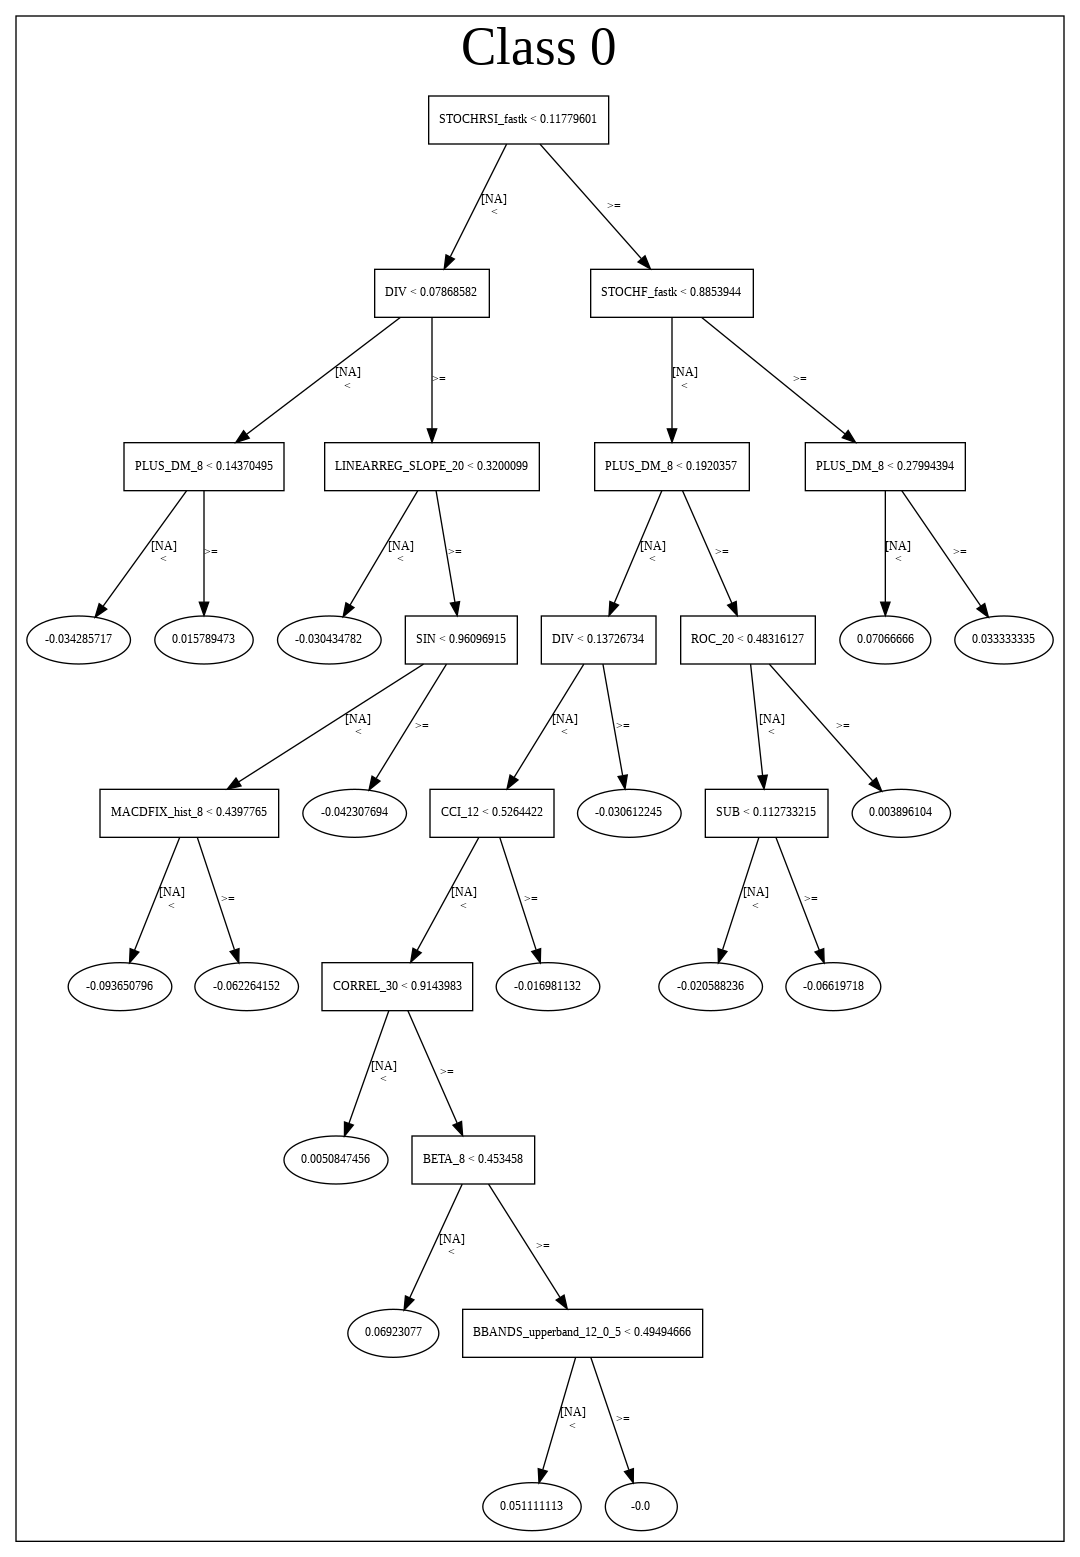

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190828_193207_model_5',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190828_193207_model_5',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_66_sid_8978',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['BOP',
 'Volume',
 'TRANGE',
 'STOCHF_fastk',
 'PLUS_DM_8',
 'DIV',
 'WILLR_8',
 'CCI_8',
 'hour',
 'SAREXT',
 'DX_20',
 'CORREL_8',
 'PLUS_DI_24',
 'TAN',
 'ULTOSC',
 'SUB',
 'WILLR_20',
 'day',
 'DX_30',
 'STOCHRSI_fastd',
 'HT_DCPERIOD',
 'DX_24',
 'WILLR_24',
 'aroondown_20',
 'STOCHRSI_fastk',
 'aroonup_12',
 'aroonup_20',
 'dayofweek',
 'aroonup_24',
 'aroonup_8',
 'weekday_name',
 'weekday',
 'CDLLONGLINE',
 'CDLSPINNINGTOP',
 'CDLHAMMER',
 'CDLENGULFING',
 'CDLDOJI',
 'CDLSHORTLINE',
 'CDLBELTHOLD',
 'CDLDRAGONFLYDOJI',
 'HT_TRENDMODE',
 'CDLCLOSINGMARUBOZU',
 'CDLTAKURI',
 'CDLSTALLEDPATTERN']

In [22]:
# XGBoost with top XGBoost features
model_train(feature_name='XGBF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

In [0]:
# PCA
try:
  del xgb_features,glm_features,dl_features
except:
  pass
gc.collect()

if features_to_include is True or 'PCA' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.pca import H2OPrincipalComponentAnalysisEstimator
      h2o_model = H2OPrincipalComponentAnalysisEstimator(seed=1, k=PCA_k, pca_method="GramSVD", max_iterations=10000)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OPrincipalComponentAnalysisEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [24]:
# DeepLearning with PCA
model_train(feature_name='PCA',model_algo="DeepLearning",training_frame=training_frame)

[]

In [25]:
# GLM with PCA
model_train(feature_name='PCA',model_algo="GLM",training_frame=training_frame)

[]

In [26]:
# XGBoost with PCA
model_train(feature_name='PCA',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# Generalized Low Rank
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'GLRM' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.glrm import H2OGeneralizedLowRankEstimator

      h2o_model = H2OGeneralizedLowRankEstimator(seed=1, k=GLRM_k)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OGeneralizedLowRankEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [28]:
# DeepLearning with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="DeepLearning",training_frame=training_frame)

[]

In [29]:
# GLM with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="GLM",training_frame=training_frame)

[]

In [30]:
# XGBoost with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# High Correlation Filter 
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'HCF' in features_to_include:
  corr_matrix = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).corr().abs()

  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

  features_list = [column for column in upper.columns if not any(upper[column] > HCF_threshold)]

  del corr_matrix, upper
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [32]:
# DeepLearning with low correlation features
model_train(feature_name='HCF',model_algo="DeepLearning",features_list=features_list)

[]

In [33]:
# GLM with low correlation features
model_train(feature_name='HCF',model_algo="GLM",features_list=features_list)

[]

In [34]:
# XGBoost with low correlation features
model_train(feature_name='HCF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
#	Low Variance Filter  
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'LVF' in features_to_include:
  df_variance = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).var()
  features_list = [column for column in df_variance.index if df_variance[column]  > LVF_threshold]

  del df_variance
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [36]:
# DeepLearning with Low Variance features  
model_train(feature_name='LVF',model_algo="DeepLearning",features_list=features_list)

[]

In [37]:
# GLM with Low Variance features  
model_train(feature_name='LVF',model_algo="GLM",features_list=features_list)

[]

In [38]:
# XGBoost with Low Variance features  
model_train(feature_name='LVF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select k best features
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'KBest' in features_to_include:
  from sklearn.feature_selection import SelectKBest
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectKBest(score_func=f_classif, k=select_k).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectKBest, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [40]:
# DeepLearning with Select k best features 
model_train(feature_name='KBest',model_algo="DeepLearning",features_list=features_list)

[]

In [41]:
# GLM with Select k best features
model_train(feature_name='KBest',model_algo="GLM",features_list=features_list)

[]

In [42]:
# XGBoost with Select k best features
model_train(feature_name='KBest',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select Percentile
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Percentile' in features_to_include:
  from sklearn.feature_selection import SelectPercentile
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectPercentile(score_func=f_classif, percentile=select_percentile).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectPercentile, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [44]:
# DeepLearning with Select Percentile features  
model_train(feature_name='Percentile',model_algo="DeepLearning",features_list=features_list)

[]

In [45]:
# GLM with Select Percentile features  
model_train(feature_name='Percentile',model_algo="GLM",features_list=features_list)

[]

In [46]:
# XGBoost with Select Percentile features  
model_train(feature_name='Percentile',model_algo="XGBoost",features_list=features_list)

[]

In [47]:
# Select Family-wise error
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Fwe' in features_to_include:
  from sklearn.feature_selection import SelectFwe
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectFwe(score_func=f_classif, alpha=select_alpha).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectFwe, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [12] are constant.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:721: RuntimeWarning: invalid value encountered in less
  return (self.pvalues_ < self.alpha / len(self.pvalues_))


32

['hour',
 'BOP',
 'CCI_8',
 'CMO_8',
 'RSI_8',
 'WILLR_8',
 'CCI_12',
 'CMO_12',
 'RSI_12',
 'WILLR_12',
 'CCI_14',
 'WILLR_14',
 'WILLR_20',
 'WILLR_24',
 'STOCH_slowk',
 'STOCHF_fastk',
 'STOCHF_fastd',
 'STOCHRSI_fastk',
 'STOCHRSI_fastd',
 'ULTOSC',
 'ADOSC',
 'TRANGE',
 'CDLBELTHOLD',
 'CDLCLOSINGMARUBOZU',
 'CDLDRAGONFLYDOJI',
 'CDLENGULFING',
 'CDLLONGLINE',
 'CDLMARUBOZU',
 'CDLSHORTLINE',
 'CDLTAKURI',
 'DIV',
 'SUB']

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190828_193329_model_3  0.773585  0.574103              0.296508  0.441851  0.195232
1  DeepLearning_grid_1_AutoML_20190828_193329_model_9  0.772178  0.570773              0.291377  0.441975  0.195342
2  DeepLearning_grid_1_AutoML_20190828_193329_model_2  0.769033  0.585238              0.280288  0.448344  0.201012
3  DeepLearning_grid_1_AutoML_20190828_193329_model_1  0.768537  0.698309              0.314052  0.469531  0.220459
4  DeepLearning_grid_1_AutoML_20190828_193329_model_8  0.767792  0.567052              0.278219  0.440717  0.194232
5  DeepLearning_grid_1_AutoML_20190828_193329_model_5  0.762082  0.576041              0.273502  0.444161  0.197279
6  DeepLearning_grid_1_AutoML_20190828_193329_model_7  0.761668  0.613871              0.285998  0.451143  0.203530
7  DeepLearning_grid_1_AutoML_20190828_193329_model_6  0.758275  0.593478              0.285005  0.444761  0.197812
8               DeepLearning_1_AutoML_20190828_193329  0.754138  0.607838              0.299156  0.453927  0.206050
9  DeepLearning_grid_1_AutoML_20190828_193329_model_4  0.748510  0.650646              0.282605  0.461976  0.213422

variable  relative_importance  scaled_importance  percentage
0            CDLTAKURI             1.000000           1.000000    0.054578
1     CDLDRAGONFLYDOJI             0.960419           0.960419    0.052418
2   CDLCLOSINGMARUBOZU             0.826854           0.826854    0.045128
3                  SUB             0.784373           0.784373    0.042810
4                  BOP             0.768267           0.768267    0.041931
5                  DIV             0.761948           0.761948    0.041586
6               TRANGE             0.707418           0.707418    0.038610
7          CDLLONGLINE             0.635762           0.635762    0.034699
8          CDLMARUBOZU             0.630323           0.630323    0.034402
9                 hour             0.578465           0.578465    0.031572
10        CDLSHORTLINE             0.566931           0.566931    0.030942
11        CDLENGULFING             0.545682           0.545682    0.029783
12      STOCHRSI_fastk             0.540957           0.540957    0.029525
13        STOCHF_fastk             0.538234           0.538234    0.029376
14      STOCHRSI_fastd             0.536829           0.536829    0.029299
15               CCI_8             0.524272           0.524272    0.028614
16         CDLBELTHOLD             0.516417           0.516417    0.028185
17               ADOSC             0.508355           0.508355    0.027745
18        STOCHF_fastd             0.501828           0.501828    0.027389
19              CMO_12             0.491159           0.491159    0.026807
20              ULTOSC             0.488604           0.488604    0.026667
21         STOCH_slowk             0.481426           0.481426    0.026276
22            WILLR_20             0.479827           0.479827    0.026188
23              CCI_14             0.469526           0.469526    0.025626
24            WILLR_24             0.466021           0.466021    0.025435
25            WILLR_12             0.454231           0.454231    0.024791
26             WILLR_8             0.450801           0.450801    0.024604
27            WILLR_14             0.449931           0.449931    0.024557
28              RSI_12             0.430709           0.430709    0.023507
29              CCI_12             0.417945           0.417945    0.022811
30               CMO_8             0.414830           0.414830    0.022641
31               RSI_8             0.393891           0.393891    0.021498

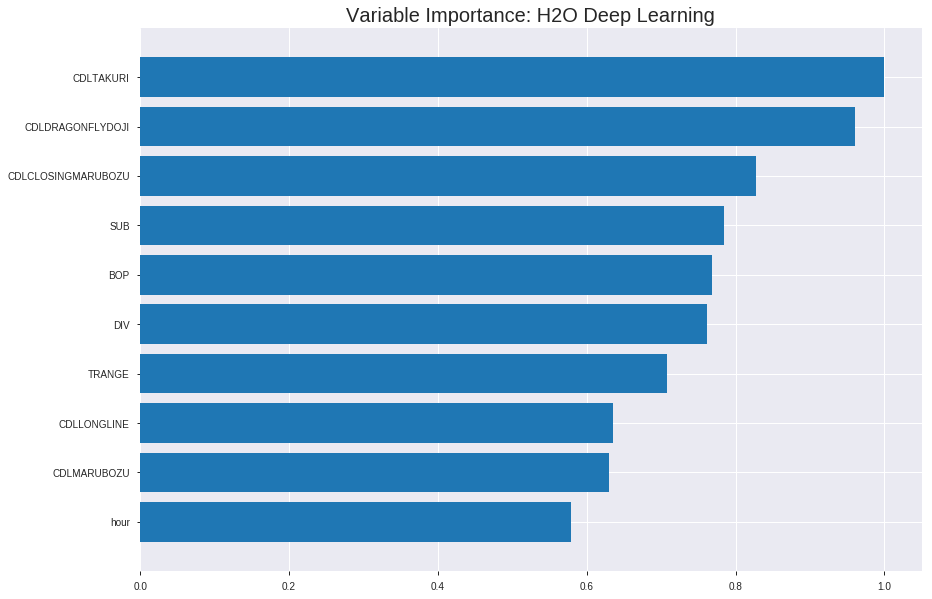

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190828_193329_model_3


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.19094667323609932
RMSE: 0.4369744537568522
LogLoss: 0.5956530257828311
Mean Per-Class Error: 0.28562992058689796
AUC: 0.7804405495673815
pr_auc: 0.7178976134547554
Gini: 0.560881099134763
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3762736795556204: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      479  364  0.4318   (364.0/843.0)
1      100  594  0.1441   (100.0/694.0)
Total  579  958  0.3019   (464.0/1537.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.376274     0.719128  253
max f2                       0.171958     0.831452  326
max f0point5                 0.47655      0.674727  211
max accuracy                 0.47655      0.711126  211
max precision                0.998935     1         0
max recall                   0.000261617  1         399
max specificity              0.998935     1         0
max absolute_mcc             0.376274     0.435569  253
max min_per_class_accuracy   0.499791     0.701729  199
max mean_per_class_accuracy  0.47655      0.71437   211

Gains/Lift Table: Avg response rate: 45.15 %, avg score: 45.30 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score       cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104099                   0.995749           2.07628   2.07628            0.9375           0.997504    0.9375                      0.997504            0.0216138       0.0216138                  107.628   107.628
    2        0.0201692                   0.991019           1.47646   1.78605            0.666667         0.994523    0.806452                    0.996062            0.0144092       0.0360231                  47.6465   78.6046
    3        0.0305791                   0.974916           2.07628   1.88485            0.9375           0.98393     0.851064                    0.991932            0.0216138       0.0576369                  107.628   88.4849
    4        0.0403383                   0.962467           1.9194    1.89321            0.866667         0.967378    0.854839                    0.985991            0.018732        0.0763689                  91.9404   89.3209
    5        0.0500976                   0.949184           1.9194    1.89831            0.866667         0.954924    0.857143                    0.979939            0.018732        0.0951009                  91.9404   89.8312
    6        0.100195                    0.815482           1.78326   1.84079            0.805195         0.875632    0.831169                    0.927786            0.0893372       0.184438                   78.3263   84.0787
    7        0.150293                    0.751088           1.69698   1.79285            0.766234         0.783755    0.809524                    0.879776            0.0850144       0.269452                   69.6976   79.285
    8        0.20039                     0.700181           1.7545    1.78326            0.792208         0.725547    0.805195                    0.841218            0.0878963       0.357349                   75.4501   78.3263
    9        0.299935                    0.610015           1.25934   1.60938            0.568627         0.655698    0.726681                    0.779647            0.12536         0.482709                   25.9338   60.9379
    10       0.40013                     0.547174           1.25116   1.51968            0.564935         0.577806    0.686179                    0.729104            0.12536         0.608069                   25.116    51.9679
    11       0.500325                    0.486005           1.19364   1.45439            0.538961         0.5174      0.656697                    0.686709            0.119597        0.727666                   19.3636   45.4385
    12       0.59987                     0.399418           1.04221   1.38599            0.470588         0.443077    0.625813                    0.646279            0.103746        0.831412                   4.22105   38.5987
    13       0.700065                    0.290609           0.704676  1.28848            0.318182         0.345824    0.581784                    0.603277            0.0706052       0.902017                   -29.5324  28.8476
    14       0.79961                     0.145771           0.53558   1.19475            0.24183          0.22225     0.539463                    0.555843            0.0533141       0.955331                   -46.442   19.4747
    15       0.899805                    0.0280718          0.287623  1.09374            0.12987          0.0767097   0.493854                    0.50249             0.0288184       0.98415                    -71.2377  9.3737
    16       1                           2.96575e-06        0.158193  1                  0.0714286        0.00815736  0.451529   



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.20859309176808735
RMSE: 0.45671992705386455
LogLoss: 0.6478499789154436
Mean Per-Class Error: 0.2909507086416656
AUC: 0.7500209038839417
pr_auc: 0.6829163681180389
Gini: 0.5000418077678834
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3948951848176905: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      143  95   0.3992   (95.0/238.0)
1      41   160  0.204    (41.0/201.0)
Total  184  255  0.3098   (136.0/439.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.394895     0.701754  235
max f2                       0.0346097    0.834732  362
max f0point5                 0.472775     0.678605  200
max accuracy                 0.472775     0.708428  200
max precision                0.996073     1         0
max recall                   5.81854e-05  1         399
max specificity              0.996073     1         0
max absolute_mcc             0.472775     0.416699  200
max min_per_class_accuracy   0.477372     0.705882  197
max mean_per_class_accuracy  0.472775     0.709049  200

Gains/Lift Table: Avg response rate: 45.79 %, avg score: 43.54 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113895                   0.994629           1.31045    1.31045            0.6              0.995335   0.6                         0.995335            0.0149254       0.0149254                  31.0448   31.0448
    2        0.0205011                   0.978992           1.63806    1.45605            0.75             0.988548   0.666667                    0.992319            0.0149254       0.0298507                  63.806    45.6053
    3        0.0318907                   0.956648           2.18408    1.71606            1                0.968794   0.785714                    0.983917            0.0248756       0.0547264                  118.408   71.6063
    4        0.0410023                   0.896627           1.63806    1.69873            0.75             0.936868   0.777778                    0.973462            0.0149254       0.0696517                  63.806    69.8729
    5        0.0501139                   0.869869           1.63806    1.6877             0.75             0.882187   0.772727                    0.956866            0.0149254       0.0845771                  63.806    68.7698
    6        0.100228                    0.769065           1.6877     1.6877             0.772727         0.826841   0.772727                    0.891854            0.0845771       0.169154                   68.7698   68.7698
    7        0.150342                    0.721152           1.88625    1.75388            0.863636         0.739819   0.80303                     0.841175            0.0945274       0.263682                   88.6251   75.3882
    8        0.200456                    0.685557           1.58842    1.71252            0.727273         0.704852   0.784091                    0.807095            0.079602        0.343284                   58.8422   71.2517
    9        0.300683                    0.613524           1.29059    1.57188            0.590909         0.648116   0.719697                    0.754102            0.129353        0.472637                   29.0592   57.1875
    10       0.400911                    0.529547           1.19132    1.47674            0.545455         0.566674   0.676136                    0.707245            0.119403        0.59204                    19.1316   47.6736
    11       0.501139                    0.457496           1.34023    1.44943            0.613636         0.496898   0.663636                    0.665176            0.134328        0.726368                   34.0231   44.9435
    12       0.599089                    0.370539           0.761888   1.33702            0.348837         0.4233     0.612167                    0.625629            0.0746269       0.800995                   -23.8112  33.7022
    13       0.699317                    0.277117           0.645296   1.23788            0.295455         0.328605   0.566775                    0.583059            0.0646766       0.865672                   -35.4704  23.7882
    14       0.799544                    0.130513           0.496382   1.14493            0.227273         0.203429   0.524217                    0.53547             0.0497512       0.915423                   -50.3618  14.4931
    15       0.899772                    0.0233794          0.744573   1.10033            0.340909         0.0665879  0.503797                    0.48324             0.0746269       0.99005                    -25.5427  10.0334
    16       1                           3.38223e-06        0.0992763  1                  0.0454545        0.0057323  0.457859 


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 19:34:36  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-28 19:34:38  1 min  7.356 sec  8501 obs/sec      10        1             15370      0.454654         0.67219             0.165316       0.76846         0.689739           1.93786          0.3162                           0.468689           0.728126              0.115038         0.751181          0.674921             1.31045            0.305239
    2019-08-28 19:34:44  1 min 13.322 sec  9959 obs/sec      50        5             76850      0.436974         0.595653            0.228967       0.780441        0.717898           2.07628          0.301887                         0.45672            0.64785               0.159658         0.750021          0.682916             1.31045            0.309795
    2019-08-28 19:34:50  1 min 19.346 sec  11226 obs/sec     100       10            153700     0.434073         0.58576             0.239173       0.786226        0.727204           1.93786          0.307742                         0.459912           0.660438              0.14787          0.742454          0.669738             1.31045            0.316629
    2019-08-28 19:34:55  1 min 24.511 sec  11473 obs/sec     140       14            215180     0.428268         0.574794            0.259386       0.797432        0.740896           1.93786          0.286923                         0.459341           0.666482              0.149986         0.745704          0.675502             1.31045            0.305239
    2019-08-28 19:35:00  1 min 29.925 sec  12107 obs/sec     190       19            292030     0.424817         0.566172            0.271273       0.804605        0.740365           1.93786          0.281718                         0.461414           0.673672              0.142297         0.743206          0.668909             1.31045            0.316629
    2019-08-28 19:35:06  1 min 35.418 sec  12995 obs/sec     250       25            384250     0.417628         0.556259            0.295728       0.81818         0.758503           1.93786          0.274561                         0.465441           0.694245              0.12726          0.739893          0.666276             1.31045            0.302961
    2019-08-28 19:35:11  1 min 40.592 sec  13735 obs/sec     310       31            476470     0.409679         0.544662            0.322284       0.833076        0.759481           1.93786          0.237476                         0.467864           0.732524              0.11815          0.735744          0.659454             1.31045            0.298405
    2019-08-28 19:35:11  1 min 40.644 sec  13732 obs/sec     310       31            476470     0.436974         0.595653            0.228967       0.780441        0.717898           2.07628          0.301887                         0.45672            0.64785               0.159658         0.750021          0.682916             1.31045            0.309795

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  --------------------
CDLTAKURI           1.0                    1.0                  0.05457849326231124
CDLDRAGONFLYDOJI    0.9604192972183228     0.9604192972183228   0.052418238142223926
CDLCLOSINGMARUBOZU  0.8268543481826782     0.8268543481826782   0.04512846447120106
SUB                 0.7843730449676514     0.7843730449676514   0.042809898949905514
BOP                 0.7682670950889587     0.7682670950889587   0.041930860472968165
---                 ---                    ---                  ---
WILLR_14            0.4499306380748749     0.4499306380748749   0.02455653629867696
RSI_12              0.4307086169719696     0.4307086169719696   0.023507427349424036
CCI_12              0.41794466972351074    0.41794466972351074  0.02281079034052353
CMO_8               0.41482973098754883    0.41482973098754883  0.02264078167771032
RSI_8               0.393891304731369      0.393891304731369    0.02149799392136401


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7181818181818181)

('F1', 0.7452471482889734)

('auc', 0.7735849056603773)

('logloss', 0.5741027823556538)

('mean_per_class_error', 0.2825223435948362)

('rmse', 0.4418509473125907)

('mse', 0.1952322596410338)

deeplearning prediction progress: |███████████████████████████████████████| 100%


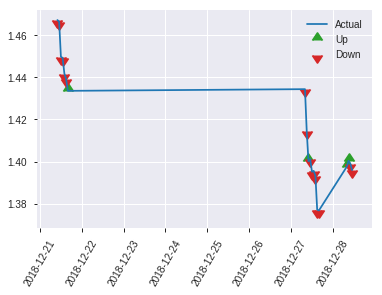


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.1952322596410338
RMSE: 0.4418509473125907
LogLoss: 0.5741027823556538
Mean Per-Class Error: 0.2825223435948362
AUC: 0.7735849056603773
pr_auc: 0.7376648941511661
Gini: 0.5471698113207546
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.26227240250005435: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      55   59   0.5175   (59.0/114.0)
1      8    98   0.0755   (8.0/106.0)
Total  63   157  0.3045   (67.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.262272     0.745247  156
max f2                       0.0236751    0.854839  195
max f0point5                 0.488856     0.710117  101
max accuracy                 0.488856     0.718182  101
max precision                0.996738     1         0
max recall                   0.0236751    1         195
max specificity              0.996738     1         0
max absolute_mcc             0.262272     0.449845  156
max min_per_class_accuracy   0.472664     0.707547  107
max mean_per_class_accuracy  0.478507     0.717478  103

Gains/Lift Table: Avg response rate: 48.18 %, avg score: 43.94 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score       cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136364                   0.99102            2.07547   2.07547            1                0.994153    1                           0.994153            0.0283019       0.0283019                  107.547   107.547
    2        0.0227273                   0.974473           2.07547   2.07547            1                0.982708    1                           0.989575            0.0188679       0.0471698                  107.547   107.547
    3        0.0318182                   0.957024           2.07547   2.07547            1                0.966666    1                           0.98303             0.0188679       0.0660377                  107.547   107.547
    4        0.0409091                   0.949268           2.07547   2.07547            1                0.95027     1                           0.97575             0.0188679       0.0849057                  107.547   107.547
    5        0.05                        0.92414            2.07547   2.07547            1                0.940526    1                           0.969345            0.0188679       0.103774                   107.547   107.547
    6        0.1                         0.802059           1.50943   1.79245            0.727273         0.839302    0.863636                    0.904324            0.0754717       0.179245                   50.9434   79.2453
    7        0.15                        0.745319           1.32075   1.63522            0.636364         0.771185    0.787879                    0.859944            0.0660377       0.245283                   32.0755   63.522
    8        0.2                         0.683113           1.32075   1.5566             0.636364         0.709962    0.75                        0.822448            0.0660377       0.311321                   32.0755   55.6604
    9        0.3                         0.624318           1.22642   1.44654            0.590909         0.651579    0.69697                     0.765492            0.122642        0.433962                   22.6415   44.6541
    10       0.4                         0.538542           1.69811   1.50943            0.818182         0.588616    0.727273                    0.721273            0.169811        0.603774                   69.8113   50.9434
    11       0.5                         0.457803           1.03774   1.41509            0.5              0.500025    0.681818                    0.677023            0.103774        0.707547                   3.77358   41.5094
    12       0.6                         0.379054           0.943396  1.33648            0.454545         0.427122    0.643939                    0.635373            0.0943396       0.801887                   -5.66038  33.6478
    13       0.7                         0.273337           1.03774   1.2938             0.5              0.326683    0.623377                    0.591274            0.103774        0.90566                    3.77358   29.3801
    14       0.8                         0.11537            0.471698  1.19104            0.227273         0.209512    0.573864                    0.543554            0.0471698       0.95283                    -52.8302  19.1038
    15       0.9                         0.0192159          0.471698  1.11111            0.227273         0.0423581   0.535354                    0.487866            0.0471698       1                          -52.8302  11.1111
    16       1                           4.93736e-06        0         1                  0                0.00342889  0.481818  

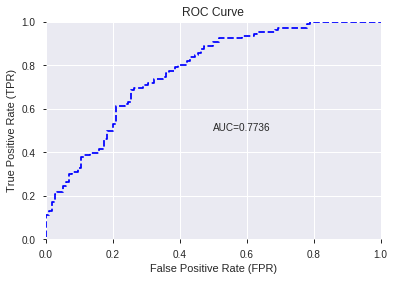

This function is available for GLM models only


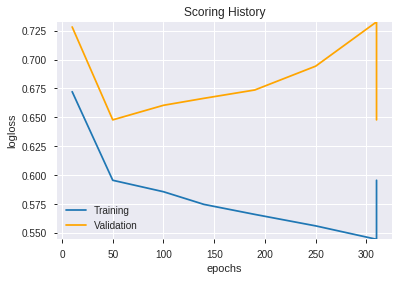

--2019-08-28 19:40:38--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.178.43
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.178.43|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


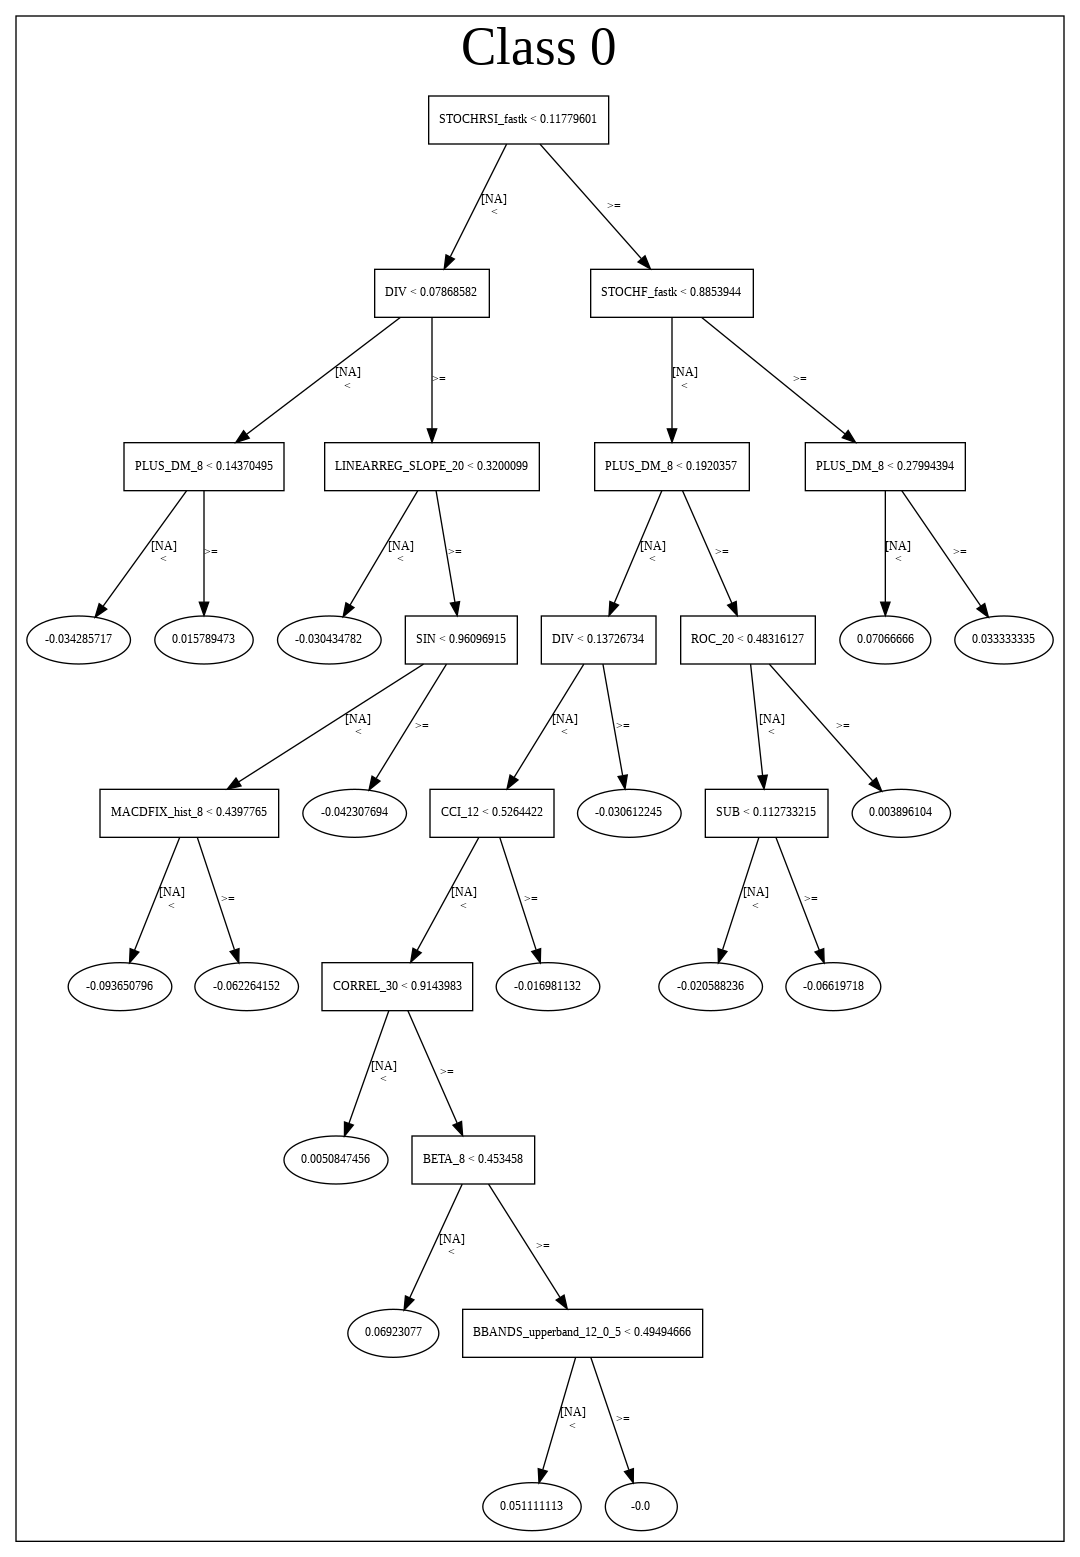

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190828_193329_model_3',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190828_193329_model_3',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_74_sid_8978',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['CDLTAKURI',
 'CDLDRAGONFLYDOJI',
 'CDLCLOSINGMARUBOZU',
 'SUB',
 'BOP',
 'DIV',
 'TRANGE',
 'CDLLONGLINE',
 'CDLMARUBOZU',
 'hour',
 'CDLSHORTLINE',
 'CDLENGULFING',
 'STOCHRSI_fastk',
 'STOCHF_fastk',
 'STOCHRSI_fastd',
 'CCI_8',
 'CDLBELTHOLD',
 'ADOSC',
 'STOCHF_fastd',
 'CMO_12',
 'ULTOSC',
 'STOCH_slowk',
 'WILLR_20',
 'CCI_14',
 'WILLR_24',
 'WILLR_12',
 'WILLR_8',
 'WILLR_14',
 'RSI_12',
 'CCI_12',
 'CMO_8',
 'RSI_8']

In [48]:
# DeepLearning with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc  logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190828_194134_model_1  0.762248  0.58162              0.298825  0.446958  0.199771

variable  relative_importance  scaled_importance  percentage
0                  BOP             0.763723           1.000000    0.140565
1         STOCHF_fastk             0.574664           0.752450    0.105768
2                  SUB             0.305516           0.400034    0.056231
3               ULTOSC             0.296512           0.388245    0.054574
4            CDLTAKURI             0.274590           0.359541    0.050539
5                CCI_8             0.266611           0.349094    0.049070
6   CDLCLOSINGMARUBOZU             0.219960           0.288011    0.040484
7          CDLMARUBOZU             0.206962           0.270990    0.038092
8          STOCH_slowk             0.192124           0.251562    0.035361
9         STOCHF_fastd             0.191571           0.250838    0.035259
10              CCI_12             0.181820           0.238071    0.033465
11              CMO_12             0.180658           0.236550    0.033251
12              RSI_12             0.179247           0.234701    0.032991
13      STOCHRSI_fastd             0.179050           0.234443    0.032955
14      STOCHRSI_fastk             0.154377           0.202138    0.028414
15                 DIV             0.141843           0.185725    0.026107
16            WILLR_24             0.127777           0.167308    0.023518
17                hour             0.119293           0.156199    0.021956
18              CCI_14             0.113374           0.148449    0.020867
19              TRANGE             0.111736           0.146305    0.020565
20            WILLR_12             0.087162           0.114128    0.016042
21            WILLR_14             0.084905           0.111172    0.015627
22    CDLDRAGONFLYDOJI             0.076358           0.099982    0.014054
23        CDLENGULFING             0.065890           0.086275    0.012127
24             WILLR_8             0.065884           0.086267    0.012126
25               ADOSC             0.058859           0.077068    0.010833
26        CDLSHORTLINE             0.054858           0.071829    0.010097
27         CDLLONGLINE             0.050612           0.066270    0.009315
28               CMO_8             0.042521           0.055676    0.007826
29               RSI_8             0.039079           0.051169    0.007193
30            WILLR_20             0.018348           0.024024    0.003377
31         CDLBELTHOLD             0.007343           0.009614    0.001351

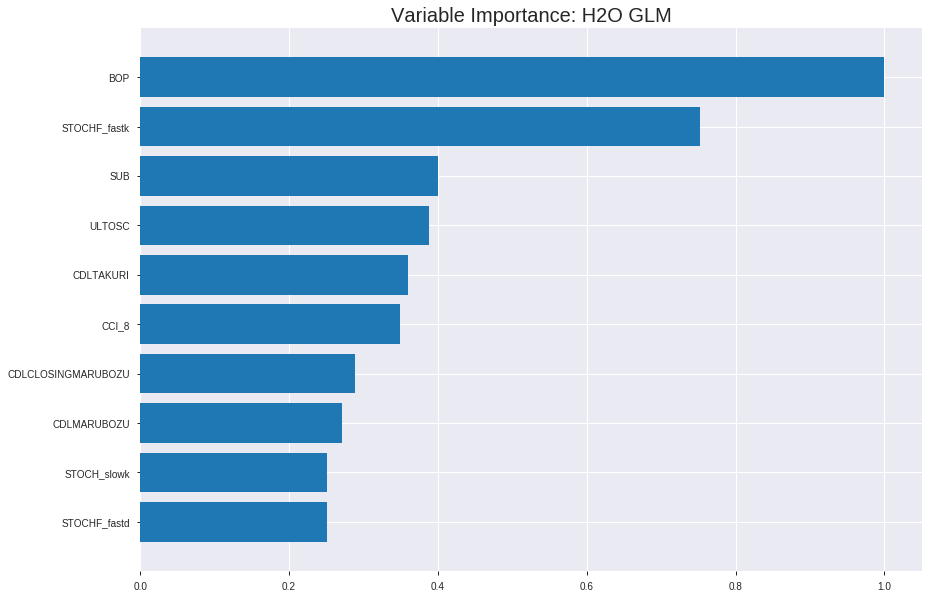

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190828_194134_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.18844481246050596
RMSE: 0.4341023064445822
LogLoss: 0.5540592724863354
Null degrees of freedom: 1536
Residual degrees of freedom: 1504
Null deviance: 2116.267351263065
Residual deviance: 1703.178203622995
AIC: 1769.178203622995
AUC: 0.7837368941033294
pr_auc: 0.7102277346959145
Gini: 0.5674737882066587
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.29337795928081134: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      397  446   0.5291   (446.0/843.0)
1      58   636   0.0836   (58.0/694.0)
Total  455  1082  0.3279   (504.0/1537.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.293378     0.716216  274
max f2                       0.198974     0.836648  317
max f0point5                 0.480527     0.683473  190
max accuracy                 0.480527     0.71568   190
max precision                0.930233     1         0
max recall                   0.0713399    1         373
max specificity              0.930233     1         0
max absolute_mcc             0.451551     0.434705  206
max min_per_class_accuracy   0.472954     0.713256  194
max mean_per_class_accuracy  0.451551     0.718311  206

Gains/Lift Table: Avg response rate: 45.15 %, avg score: 45.15 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104099                   0.886351           1.79944    1.79944            0.8125           0.900192   0.8125                      0.900192            0.018732        0.018732                   79.9442   79.9442
    2        0.0201692                   0.865519           1.9194     1.85749            0.866667         0.876034   0.83871                     0.888502            0.018732        0.037464                   91.9404   85.7488
    3        0.0305791                   0.851313           1.79944    1.83773            0.8125           0.859161   0.829787                    0.878514            0.018732        0.056196                   79.9442   83.7728
    4        0.0403383                   0.840257           1.47646    1.75033            0.666667         0.847357   0.790323                    0.870976            0.0144092       0.0706052                  47.6465   75.0325
    5        0.0500976                   0.82103            1.62411    1.72574            0.733333         0.831103   0.779221                    0.863209            0.0158501       0.0864553                  62.4111   72.5738
    6        0.100195                    0.770862           1.81203    1.76888            0.818182         0.79681    0.798701                    0.830009            0.0907781       0.177233                   81.2025   76.8882
    7        0.150293                    0.723472           1.55316    1.69698            0.701299         0.746805   0.766234                    0.802275            0.0778098       0.255043                   55.3164   69.6976
    8        0.20039                     0.683937           1.7545     1.71136            0.792208         0.702604   0.772727                    0.777357            0.0878963       0.342939                   75.4501   71.1357
    9        0.299935                    0.607248           1.38961    1.60457            0.627451         0.645412   0.724512                    0.733566            0.138329        0.481268                   38.9614   60.4575
    10       0.40013                     0.53232            1.32307    1.53408            0.597403         0.57104    0.692683                    0.692868            0.132565        0.613833                   32.3066   53.4083
    11       0.500325                    0.458528           1.20802    1.46879            0.545455         0.494551   0.663199                    0.653153            0.121037        0.73487                    20.8017   46.8785
    12       0.59987                     0.380552           0.911934   1.37638            0.411765         0.420645   0.621475                    0.61457             0.0907781       0.825648                   -8.80658  37.6379
    13       0.700065                    0.294232           0.848488   1.30083            0.383117         0.338068   0.587361                    0.574996            0.0850144       0.910663                   -15.1512  30.0826
    14       0.79961                     0.205082           0.53558    1.20556            0.24183          0.248789   0.544345                    0.534386            0.0533141       0.963977                   -46.442   20.5559
    15       0.899805                    0.122262           0.287623   1.10335            0.12987          0.16752    0.498192                    0.493535            0.0288184       0.992795                   -71.2377  10.3345
    16       1                           0.00148335         0.0719058  1                  0.0324675        0.0742925  0.451529 



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.2004921515979253
RMSE: 0.44776349962667267
LogLoss: 0.5841214604808133
Null degrees of freedom: 438
Residual degrees of freedom: 406
Null deviance: 605.5320386942669
Residual deviance: 512.8586423021541
AIC: 578.8586423021541
AUC: 0.7572850035536602
pr_auc: 0.7031785939235621
Gini: 0.5145700071073205
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3208733343576938: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      133  105  0.4412   (105.0/238.0)
1      31   170  0.1542   (31.0/201.0)
Total  164  275  0.3098   (136.0/439.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.320873     0.714286  250
max f2                       0.082816     0.825083  372
max f0point5                 0.478009     0.671958  171
max accuracy                 0.478009     0.697039  171
max precision                0.908241     1         0
max recall                   0.068404     1         378
max specificity              0.908241     1         0
max absolute_mcc             0.333347     0.416986  245
max min_per_class_accuracy   0.432202     0.672269  197
max mean_per_class_accuracy  0.35261      0.705893  234

Gains/Lift Table: Avg response rate: 45.79 %, avg score: 41.69 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113895                   0.834268           2.18408   2.18408            1                0.873191   1                           0.873191            0.0248756       0.0248756                  118.408   118.408
    2        0.0205011                   0.799591           1.63806   1.9414             0.75             0.817254   0.888889                    0.84833             0.0149254       0.039801                   63.806    94.1404
    3        0.0318907                   0.784579           1.74726   1.87207            0.8              0.790913   0.857143                    0.827824            0.0199005       0.0597015                  74.7264   87.2068
    4        0.0410023                   0.774388           2.18408   1.9414             1                0.780189   0.888889                    0.817238            0.0199005       0.079602                   118.408   94.1404
    5        0.0501139                   0.767926           1.63806   1.88625            0.75             0.770791   0.863636                    0.808793            0.0149254       0.0945274                  63.806    88.6251
    6        0.100228                    0.722537           1.48915   1.6877             0.681818         0.747768   0.772727                    0.778281            0.0746269       0.169154                   48.9145   68.7698
    7        0.150342                    0.684346           1.78697   1.72079            0.818182         0.700892   0.787879                    0.752484            0.0895522       0.258706                   78.6974   72.079
    8        0.200456                    0.649197           1.58842   1.6877             0.727273         0.668247   0.772727                    0.731425            0.079602        0.338308                   58.8422   68.7698
    9        0.300683                    0.55265            1.34023   1.57188            0.613636         0.603087   0.719697                    0.688646            0.134328        0.472637                   34.0231   57.1875
    10       0.400911                    0.487477           1.14168   1.46433            0.522727         0.520411   0.670455                    0.646587            0.114428        0.587065                   14.1678   46.4326
    11       0.501139                    0.422497           1.14168   1.3998             0.522727         0.455824   0.640909                    0.608434            0.114428        0.701493                   14.1678   39.9796
    12       0.599089                    0.347026           1.16823   1.36194            0.534884         0.383452   0.623574                    0.57165             0.114428        0.81592                    16.8229   36.1936
    13       0.699317                    0.257046           0.645296  1.25923            0.295455         0.298494   0.576547                    0.532501            0.0646766       0.880597                   -35.4704  25.9225
    14       0.799544                    0.19924            0.496382  1.1636             0.227273         0.226842   0.532764                    0.494184            0.0497512       0.930348                   -50.3618  16.3598
    15       0.899772                    0.104498           0.496382  1.08928            0.227273         0.15508    0.498734                    0.456411            0.0497512       0.9801                     -50.3618  8.92751
    16       1                           0.0077826          0.198553  1                  0.0909091        0.0622942  0.457859                    


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------  -----------  --------  ------------  ------------------  ------------------
     2019-08-28 19:41:35  0.000 sec   2            .2E2      33            1.356284820566959   1.359644683182832
     2019-08-28 19:41:35  0.005 sec   4            .13E2     33            1.3461812669858588  1.350120690316059
     2019-08-28 19:41:35  0.011 sec   6            .78E1     33            1.3324702496505283  1.3373510987471269
     2019-08-28 19:41:35  0.017 sec   8            .48E1     33            1.314857598095271   1.3212272259403386
     2019-08-28 19:41:35  0.021 sec   10           .3E1      33            1.2933418106553713  1.3019521988099112
---  ---                  ---         ---          ---       ---           ---                 ---
     2019-08-28 19:41:35  0.097 sec   38           .38E-2    33            1.1059171658017395  1.16832868119982
     2019-08-28 19:41:35  0.102 sec   40           .24E-2    33            1.1043594925690743  1.1685551900967894
     2019-08-28 19:41:35  0.107 sec   42           .15E-2    33            1.1033165313949904  1.1686931757413517
     2019-08-28 19:41:35  0.112 sec   44           .91E-3    33            1.102667556081108   1.1687801637967117
     2019-08-28 19:41:35  0.115 sec   45           .57E-3    33            1.1022730424033578  1.1687818012149889


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7136363636363636)

('F1', 0.7309236947791165)

('auc', 0.7622476001324064)

('logloss', 0.5816199492907919)

('mean_per_class_error', 0.28525322740814296)

('rmse', 0.44695777434759476)

('mse', 0.19977125204975546)

glm prediction progress: |████████████████████████████████████████████████| 100%


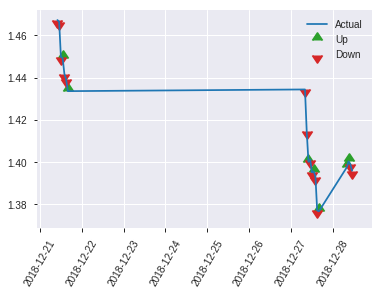


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.19977125204975546
RMSE: 0.44695777434759476
LogLoss: 0.5816199492907919
Null degrees of freedom: 219
Residual degrees of freedom: 187
Null deviance: 305.5060851051157
Residual deviance: 255.9127776879484
AIC: 321.9127776879484
AUC: 0.7622476001324064
pr_auc: 0.7170695505555467
Gini: 0.5244952002648129
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.29697032273742086: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      62   52   0.4561   (52.0/114.0)
1      15   91   0.1415   (15.0/106.0)
Total  77   143  0.3045   (67.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.29697      0.730924  142
max f2                       0.0854652    0.843949  203
max f0point5                 0.43039      0.69788   114
max accuracy                 0.43039      0.713636  114
max precision                0.86451      1         0
max recall                   0.0854652    1         203
max specificity              0.86451      1         0
max absolute_mcc             0.43039      0.429654  114
max min_per_class_accuracy   0.458322     0.692982  108
max mean_per_class_accuracy  0.43039      0.714747  114

Gains/Lift Table: Avg response rate: 48.18 %, avg score: 42.32 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136364                   0.851948           2.07547   2.07547            1                0.859948   1                           0.859948            0.0283019       0.0283019                  107.547   107.547
    2        0.0227273                   0.829352           2.07547   2.07547            1                0.836741   1                           0.850665            0.0188679       0.0471698                  107.547   107.547
    3        0.0318182                   0.813962           2.07547   2.07547            1                0.823189   1                           0.842815            0.0188679       0.0660377                  107.547   107.547
    4        0.0409091                   0.794737           2.07547   2.07547            1                0.805713   1                           0.83457             0.0188679       0.0849057                  107.547   107.547
    5        0.05                        0.779458           1.03774   1.88679            0.5              0.786929   0.909091                    0.825908            0.00943396      0.0943396                  3.77358   88.6792
    6        0.1                         0.726831           1.13208   1.50943            0.545455         0.748141   0.727273                    0.787025            0.0566038       0.150943                   13.2075   50.9434
    7        0.15                        0.691751           1.69811   1.57233            0.818182         0.711203   0.757576                    0.761751            0.0849057       0.235849                   69.8113   57.2327
    8        0.2                         0.667377           1.88679   1.65094            0.909091         0.681772   0.795455                    0.741756            0.0943396       0.330189                   88.6792   65.0943
    9        0.3                         0.577287           1.22642   1.50943            0.590909         0.622049   0.727273                    0.701854            0.122642        0.45283                    22.6415   50.9434
    10       0.4                         0.527103           1.22642   1.43868            0.590909         0.545383   0.693182                    0.662736            0.122642        0.575472                   22.6415   43.8679
    11       0.5                         0.446089           1.22642   1.39623            0.590909         0.49051    0.672727                    0.628291            0.122642        0.698113                   22.6415   39.6226
    12       0.6                         0.331023           1.13208   1.3522             0.545455         0.403163   0.651515                    0.59077             0.113208        0.811321                   13.2075   35.2201
    13       0.7                         0.251412           0.754717  1.26685            0.363636         0.29276    0.61039                     0.548197            0.0754717       0.886792                   -24.5283  26.6846
    14       0.8                         0.163326           0.566038  1.17925            0.272727         0.210061   0.568182                    0.50593             0.0566038       0.943396                   -43.3962  17.9245
    15       0.9                         0.0969153          0.283019  1.07966            0.136364         0.127812   0.520202                    0.463917            0.0283019       0.971698                   -71.6981  7.96646
    16       1                           0.0149034          0.283019  1                  0.136364         0.0568156  0.481818                   

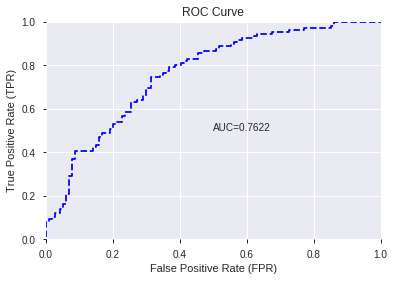

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


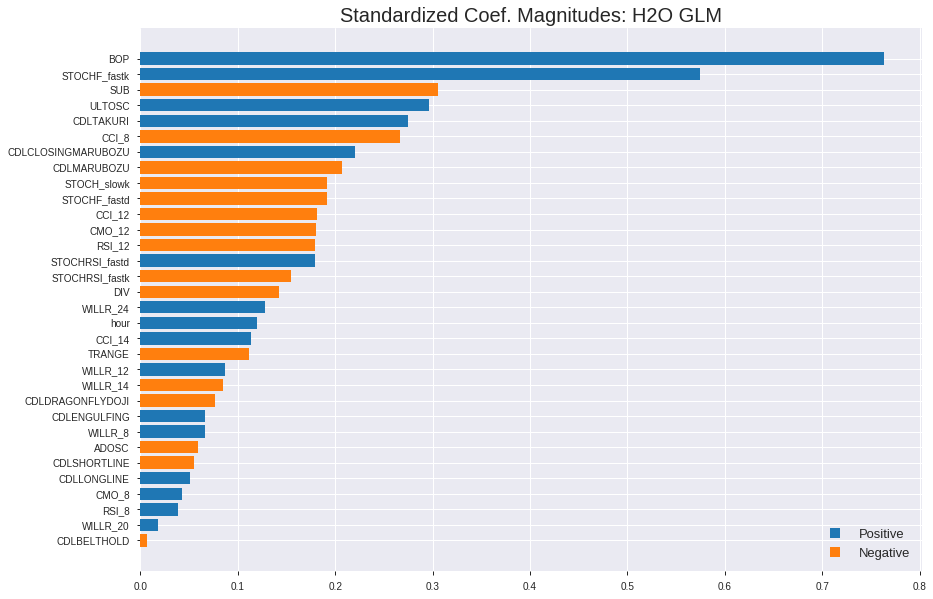

'log_likelihood'
--2019-08-28 19:41:45--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.132.139
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.132.139|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


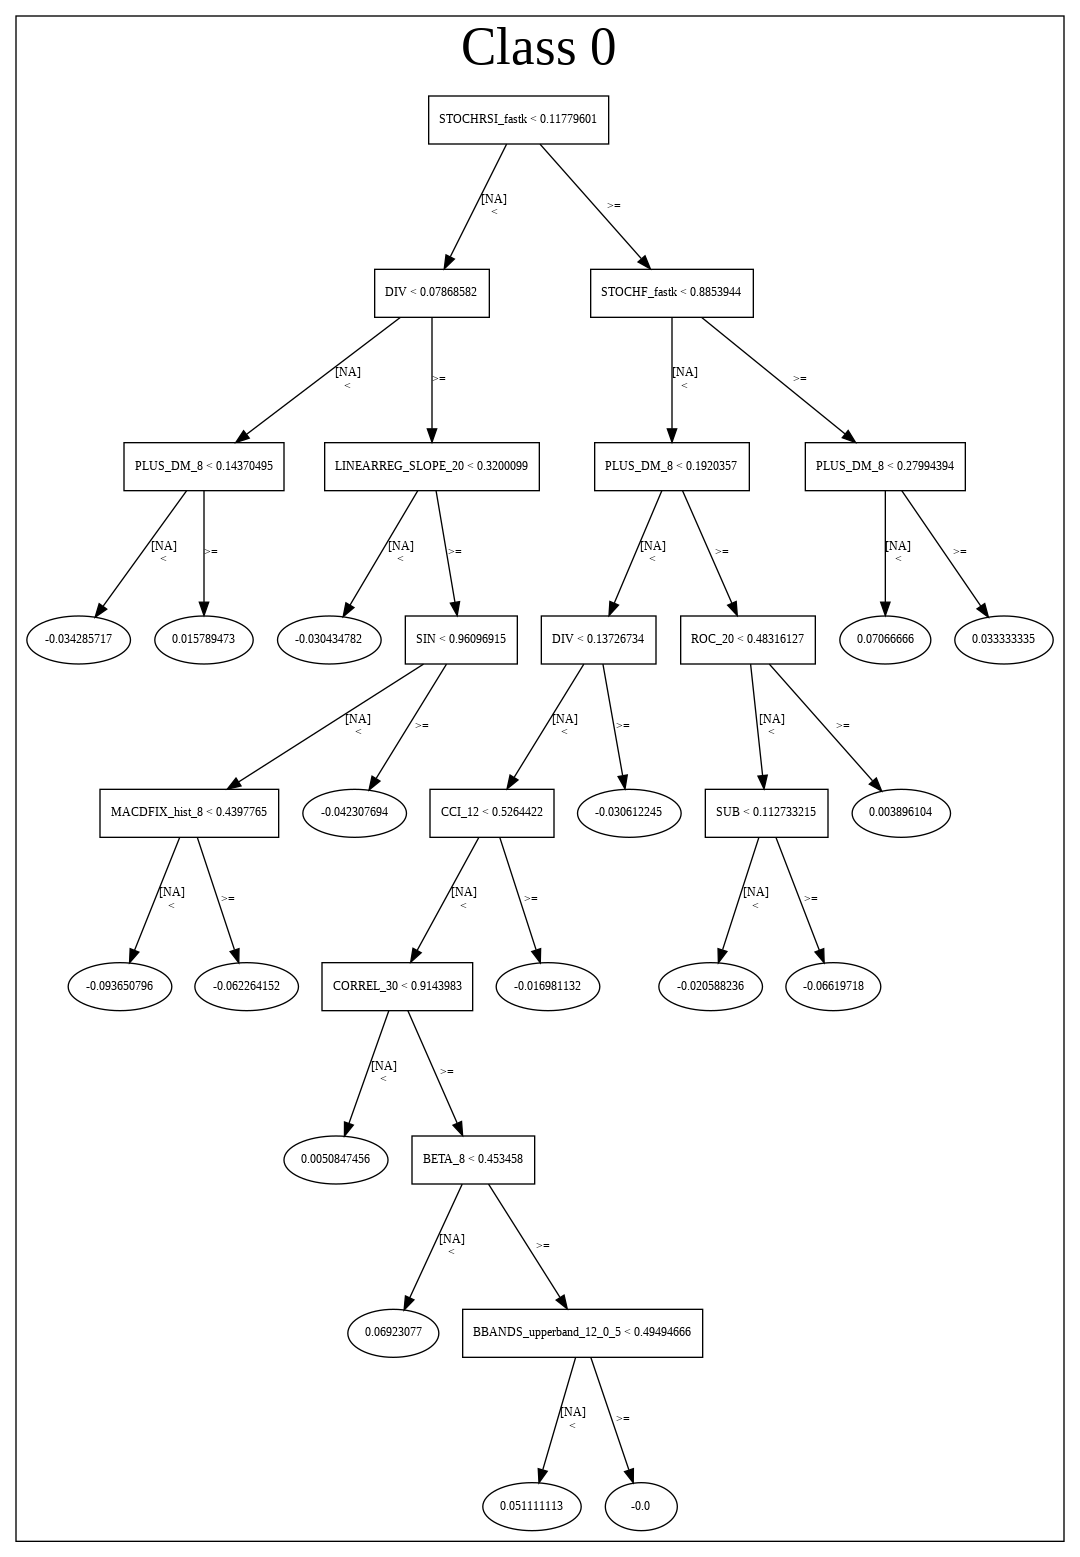

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190828_194134_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190828_194134_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_82_sid_8978',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_82_s

['BOP',
 'STOCHF_fastk',
 'SUB',
 'ULTOSC',
 'CDLTAKURI',
 'CCI_8',
 'CDLCLOSINGMARUBOZU',
 'CDLMARUBOZU',
 'STOCH_slowk',
 'STOCHF_fastd',
 'CCI_12',
 'CMO_12',
 'RSI_12',
 'STOCHRSI_fastd',
 'STOCHRSI_fastk',
 'DIV',
 'WILLR_24',
 'hour',
 'CCI_14',
 'TRANGE',
 'WILLR_12',
 'WILLR_14',
 'CDLDRAGONFLYDOJI',
 'CDLENGULFING',
 'WILLR_8',
 'ADOSC',
 'CDLSHORTLINE',
 'CDLLONGLINE',
 'CMO_8',
 'RSI_8',
 'WILLR_20',
 'CDLBELTHOLD']

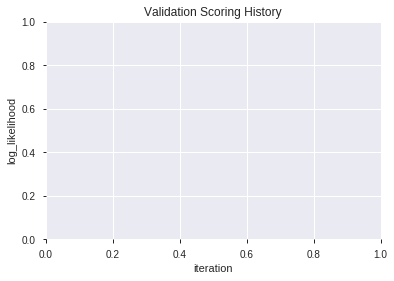

In [49]:
# GLM with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190828_194241_model_6  0.769116  0.572963              0.292122  0.440819  0.194322
1               XGBoost_3_AutoML_20190828_194241  0.762744  0.577186              0.292784  0.444147  0.197266
2  XGBoost_grid_1_AutoML_20190828_194241_model_3  0.761006  0.582701              0.288729  0.445575  0.198537
3  XGBoost_grid_1_AutoML_20190828_194241_model_1  0.755379  0.584803              0.293777  0.446692  0.199534
4  XGBoost_grid_1_AutoML_20190828_194241_model_7  0.754055  0.593174              0.301225  0.450904  0.203314
5               XGBoost_2_AutoML_20190828_194241  0.753310  0.583595              0.284012  0.448210  0.200892
6  XGBoost_grid_1_AutoML_20190828_194241_model_2  0.751903  0.586660              0.274909  0.448356  0.201023
7  XGBoost_grid_1_AutoML_20190828_194241_model_5  0.750414  0.611380              0.290053  0.455245  0.207248
8               XGBoost_1_AutoML_20190828_194241  0.749917  0.594030              0.289391  0.452432  0.204695
9  XGBoost_grid_1_AutoML_20190828_194241_model_4  0.741849  0.592977              0.271516  0.452395  0.204662

variable  relative_importance  scaled_importance  percentage
0                  BOP          2202.466553           1.000000    0.247927
1               TRANGE           685.343994           0.311171    0.077148
2                  DIV           480.743774           0.218275    0.054116
3         STOCHF_fastk           464.260895           0.210791    0.052261
4                ADOSC           442.330200           0.200834    0.049792
5                  SUB           430.125793           0.195293    0.048418
6              WILLR_8           393.360321           0.178600    0.044280
7                 hour           336.901611           0.152966    0.037924
8               CCI_12           322.269287           0.146322    0.036277
9          STOCH_slowk           309.576813           0.140559    0.034848
10              ULTOSC           295.074219           0.133974    0.033216
11               CCI_8           267.686829           0.121540    0.030133
12      STOCHRSI_fastd           265.297516           0.120455    0.029864
13      STOCHRSI_fastk           239.431671           0.108711    0.026952
14              CMO_12           225.046387           0.102179    0.025333
15            WILLR_24           223.342819           0.101406    0.025141
16            WILLR_12           210.963501           0.095785    0.023748
17               CMO_8           199.326141           0.090501    0.022438
18              CCI_14           194.923630           0.088502    0.021942
19            WILLR_14           151.167007           0.068635    0.017017
20            WILLR_20            91.113899           0.041369    0.010256
21        STOCHF_fastd            81.495766           0.037002    0.009174
22              RSI_12            69.638100           0.031618    0.007839
23    CDLDRAGONFLYDOJI            54.942421           0.024946    0.006185
24        CDLENGULFING            47.525837           0.021578    0.005350
25  CDLCLOSINGMARUBOZU            46.780933           0.021240    0.005266
26         CDLLONGLINE            38.317989           0.017398    0.004313
27           CDLTAKURI            34.994595           0.015889    0.003939
28               RSI_8            32.226120           0.014632    0.003628
29        CDLSHORTLINE            22.472195           0.010203    0.002530
30         CDLBELTHOLD            21.299347           0.009671    0.002398
31         CDLMARUBOZU             3.099817           0.001407    0.000349

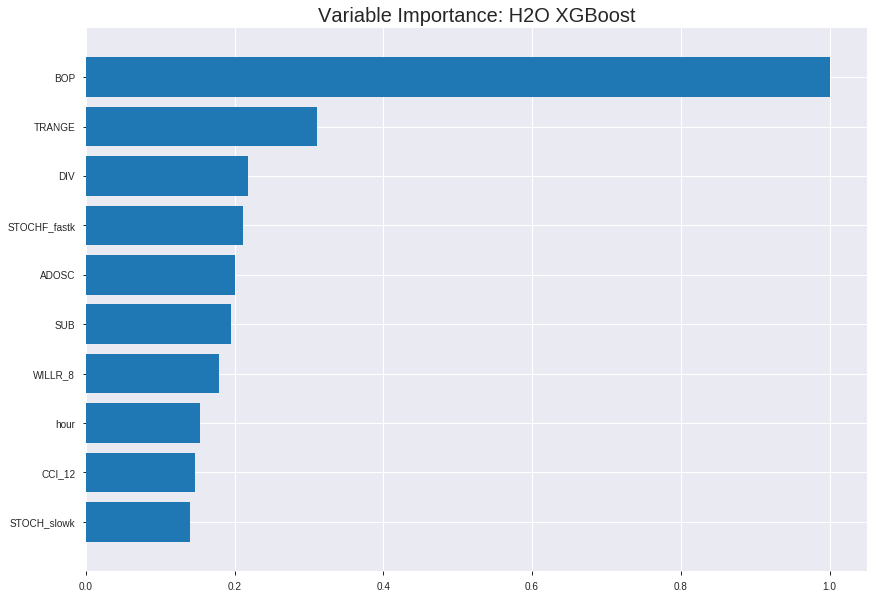

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190828_194241_model_6


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.13658454638947212
RMSE: 0.36957346548348424
LogLoss: 0.4337577832907541
Mean Per-Class Error: 0.18028876559289764
AUC: 0.9137241428820495
pr_auc: 0.9018020058304472
Gini: 0.827448285764099
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4542797803878784: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      636  207  0.2456   (207.0/843.0)
1      80   614  0.1153   (80.0/694.0)
Total  716  821  0.1867   (287.0/1537.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.45428      0.810561  208
max f2                       0.340292     0.883672  262
max f0point5                 0.603598     0.837838  127
max accuracy                 0.535098     0.824984  165
max precision                0.939766     1         0
max recall                   0.124931     1         355
max specificity              0.939766     1         0
max absolute_mcc             0.535098     0.64599   165
max min_per_class_accuracy   0.500989     0.81376   184
max mean_per_class_accuracy  0.46515      0.819711  201

Gains/Lift Table: Avg response rate: 45.15 %, avg score: 45.18 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104099                   0.899603           2.2147     2.2147             1                0.909866   1                           0.909866            0.0230548       0.0230548                  121.47    121.47
    2        0.0201692                   0.881687           2.2147     2.2147             1                0.889735   1                           0.900125            0.0216138       0.0446686                  121.47    121.47
    3        0.0305791                   0.855963           2.2147     2.2147             1                0.871986   1                           0.890546            0.0230548       0.0677233                  121.47    121.47
    4        0.0403383                   0.841453           2.2147     2.2147             1                0.847352   1                           0.880096            0.0216138       0.0893372                  121.47    121.47
    5        0.0500976                   0.828339           2.2147     2.2147             1                0.835182   1                           0.871346            0.0216138       0.110951                   121.47    121.47
    6        0.100195                    0.762201           2.18594    2.20032            0.987013         0.794363   0.993506                    0.832855            0.10951         0.220461                   118.594   120.032
    7        0.150293                    0.712784           2.15717    2.18594            0.974026         0.737149   0.987013                    0.800953            0.108069        0.32853                    115.717   118.594
    8        0.20039                     0.677551           2.04212    2.14998            0.922078         0.69463    0.970779                    0.774372            0.102305        0.430836                   104.212   114.998
    9        0.299935                    0.60785            1.78044    2.02734            0.803922         0.643823   0.915401                    0.731044            0.177233        0.608069                   78.0443   102.734
    10       0.40013                     0.540436           1.36621    1.86179            0.616883         0.576418   0.84065                     0.692325            0.136888        0.744957                   36.6209   86.1786
    11       0.500325                    0.477903           1.00668    1.69054            0.454545         0.511708   0.763329                    0.656155            0.100865        0.845821                   0.668064  69.0543
    12       0.59987                     0.398363           0.825083   1.54693            0.372549         0.439675   0.698482                    0.620231            0.0821326       0.927954                   -17.4917  54.6925
    13       0.700065                    0.298092           0.460197   1.39139            0.207792         0.349442   0.628253                    0.581475            0.0461095       0.974063                   -53.9803  39.139
    14       0.79961                     0.179184           0.231602   1.24701            0.104575         0.234651   0.563059                    0.538298            0.0230548       0.997118                   -76.8398  24.7006
    15       0.899805                    0.103958           0.0287623  1.11135            0.012987         0.139508   0.501808                    0.493892            0.00288184      1                          -97.1238  11.1352
    16       1                           0.04187            0          1                  0                0.0736239  0.451529       



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.19273139445892545
RMSE: 0.43901183863185905
LogLoss: 0.5628036488392892
Mean Per-Class Error: 0.278627869058071
AUC: 0.7723044441657261
pr_auc: 0.7092999622851202
Gini: 0.5446088883314522
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.31426307559013367: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      126  112  0.4706   (112.0/238.0)
1      23   178  0.1144   (23.0/201.0)
Total  149  290  0.3075   (135.0/439.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.314263     0.725051  258
max f2                       0.167907     0.844156  318
max f0point5                 0.502955     0.680655  174
max accuracy                 0.419802     0.715262  215
max precision                0.883891     1         0
max recall                   0.0783014    1         372
max specificity              0.883891     1         0
max absolute_mcc             0.396465     0.447054  227
max min_per_class_accuracy   0.468424     0.689076  192
max mean_per_class_accuracy  0.396465     0.721372  227

Gains/Lift Table: Avg response rate: 45.79 %, avg score: 43.24 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113895                   0.861401           2.18408    2.18408            1                0.873958  1                           0.873958            0.0248756       0.0248756                  118.408   118.408
    2        0.0205011                   0.828315           1.63806    1.9414             0.75             0.847998  0.888889                    0.86242             0.0149254       0.039801                   63.806    94.1404
    3        0.0318907                   0.806309           1.74726    1.87207            0.8              0.819683  0.857143                    0.847157            0.0199005       0.0597015                  74.7264   87.2068
    4        0.0410023                   0.787046           2.18408    1.9414             1                0.792782  0.888889                    0.835074            0.0199005       0.079602                   118.408   94.1404
    5        0.0501139                   0.774835           1.63806    1.88625            0.75             0.783594  0.863636                    0.825714            0.0149254       0.0945274                  63.806    88.6251
    6        0.100228                    0.733574           1.58842    1.73734            0.727273         0.754388  0.795455                    0.790051            0.079602        0.174129                   58.8422   73.7336
    7        0.150342                    0.689598           1.6877     1.72079            0.772727         0.70984   0.787879                    0.763314            0.0845771       0.258706                   68.7698   72.079
    8        0.200456                    0.660083           1.38987    1.63806            0.636364         0.673985  0.75                        0.740982            0.0696517       0.328358                   38.9869   63.806
    9        0.300683                    0.601375           1.19132    1.48915            0.545455         0.633436  0.681818                    0.705133            0.119403        0.447761                   19.1316   48.9145
    10       0.400911                    0.533886           1.53878    1.50155            0.704545         0.566024  0.6875                      0.670356            0.154229        0.60199                    53.8783   50.1555
    11       0.501139                    0.452172           1.09204    1.41965            0.5              0.496375  0.65                        0.635559            0.109453        0.711443                   9.20398   41.9652
    12       0.599089                    0.375361           1.16823    1.37854            0.534884         0.415538  0.631179                    0.599586            0.114428        0.825871                   16.8229   37.8545
    13       0.699317                    0.276026           0.843849   1.30191            0.386364         0.32479   0.596091                    0.560202            0.0845771       0.910448                   -15.6151  30.1911
    14       0.799544                    0.167503           0.595658   1.21338            0.272727         0.212468  0.555556                    0.516611            0.0597015       0.970149                   -40.4342  21.3378
    15       0.899772                    0.0921769          0.198553   1.10033            0.0909091        0.123394  0.503797                    0.47281             0.0199005       0.99005                    -80.1447  10.0334
    16       1                           0.0421509          0.0992763  1                  0.0454545        0.069917  0.457859                    0


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 19:42:53  7.610 sec   0                  0.5              0.693147            0.5             0                  1                0.548471                         0.5                0.693147              0.5               0                    1                  0.542141
    2019-08-28 19:42:53  7.699 sec   5                  0.470909         0.636197            0.840069        0.790364           2.2147           0.264151                         0.476206           0.646275              0.767402          0.71511              2.18408            0.307517
    2019-08-28 19:42:53  7.759 sec   10                 0.448841         0.593691            0.854886        0.832595           2.2147           0.241379                         0.461889           0.617956              0.772587          0.704492             1.74726            0.280182
    2019-08-28 19:42:54  7.824 sec   15                 0.433881         0.564178            0.860237        0.834106           2.2147           0.237476                         0.451906           0.597395              0.778158          0.71313              2.18408            0.314351
    2019-08-28 19:42:54  7.883 sec   20                 0.421985         0.540389            0.869187        0.848471           2.2147           0.232921                         0.447113           0.586406              0.772628          0.696794             1.31045            0.305239
    2019-08-28 19:42:54  7.940 sec   25                 0.412427         0.520631            0.872183        0.850115           2.2147           0.222511                         0.442447           0.57554               0.774395          0.705108             2.18408            0.300683
    2019-08-28 19:42:54  8.007 sec   30                 0.405152         0.504968            0.874926        0.854301           2.2147           0.214704                         0.441393           0.571591              0.770381          0.698408             2.18408            0.305239
    2019-08-28 19:42:54  8.067 sec   35                 0.398598         0.491527            0.881117        0.861621           2.2147           0.217957                         0.439736           0.567514              0.772419          0.702542             2.18408            0.29385
    2019-08-28 19:42:54  8.130 sec   40                 0.393027         0.479938            0.887273        0.868975           2.2147           0.22121                          0.438652           0.564134              0.773256          0.711439             2.18408            0.29385
    2019-08-28 19:42:54  8.190 sec   45                 0.386569         0.46732             0.895603        0.880028           2.2147           0.206897                         0.438298           0.562592              0.773318          0.712389             2.18408            0.300683
    2019-08-28 19:42:54  8.248 sec   50                 0.382694         0.458926            0.898643        0.883833           2.2147           0.193884                         0.438154           0.561517              0.773642          0.713229             2.18408            0.300683
    2019-08-28 19:42:54  8.303 sec   55                 0.378896         0.4512              0.90246         0.888308           2.2147           0.195185                         0.438804           0.562496              0.7722            0.7

Variable Importances: 


variable      relative_importance    scaled_importance      percentage
------------  ---------------------  ---------------------  ---------------------
BOP           2202.466552734375      1.0                    0.24792651015489453
TRANGE        685.343994140625       0.31117112461470364    0.07714757098669728
DIV           480.7437744140625      0.21827517599176083    0.05411620263708269
STOCHF_fastk  464.2608947753906      0.21079134854466144    0.05226076341552192
ADOSC         442.3302001953125      0.2008340147759143     0.04979207640378896
---           ---                    ---                    ---
CDLTAKURI     34.99459457397461      0.01588881998254576    0.003939259688751922
RSI_8         32.22611999511719      0.014631831732067974   0.003627618978505258
CDLSHORTLINE  22.47219467163086      0.010203194524671215   0.002529642410933262
CDLBELTHOLD   21.299346923828125     0.009670678947376006   0.002397617682251342
CDLMARUBOZU   3.0998172760009766     0.0014074298981532935  0.0003489391829368047


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7181818181818181)

('F1', 0.7480916030534351)

('auc', 0.769116186693148)

('logloss', 0.5729633759755468)

('mean_per_class_error', 0.2795431976166831)

('rmse', 0.44081922274912094)

('mse', 0.19432158714513909)

xgboost prediction progress: |████████████████████████████████████████████| 100%


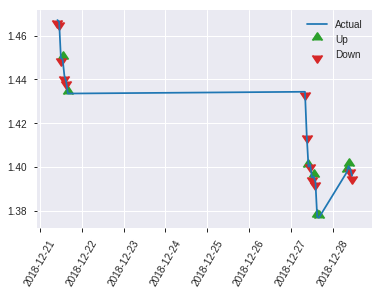


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.19432158714513909
RMSE: 0.44081922274912094
LogLoss: 0.5729633759755468
Mean Per-Class Error: 0.2795431976166831
AUC: 0.769116186693148
pr_auc: 0.718114142358989
Gini: 0.5382323733862959
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.267069011926651: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      56   58   0.5088   (58.0/114.0)
1      8    98   0.0755   (8.0/106.0)
Total  64   156  0.3      (66.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.267069     0.748092  155
max f2                       0.267069     0.844828  155
max f0point5                 0.466876     0.698653  121
max accuracy                 0.466876     0.718182  121
max precision                0.787008     0.933333  14
max recall                   0.0790032    1         208
max specificity              0.902442     0.991228  0
max absolute_mcc             0.267069     0.457396  155
max min_per_class_accuracy   0.508691     0.684211  108
max mean_per_class_accuracy  0.466876     0.720457  121

Gains/Lift Table: Avg response rate: 48.18 %, avg score: 44.95 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136364                   0.873356           1.38365   1.38365            0.666667         0.890873   0.666667                    0.890873            0.0188679       0.0188679                  38.3648   38.3648
    2        0.0227273                   0.855655           2.07547   1.66038            1                0.860676   0.8                         0.878794            0.0188679       0.0377358                  107.547   66.0377
    3        0.0318182                   0.834741           2.07547   1.77898            1                0.846857   0.857143                    0.869669            0.0188679       0.0566038                  107.547   77.8976
    4        0.0409091                   0.813253           2.07547   1.84486            1                0.826781   0.888889                    0.860139            0.0188679       0.0754717                  107.547   84.4864
    5        0.05                        0.805699           2.07547   1.88679            1                0.809507   0.909091                    0.850933            0.0188679       0.0943396                  107.547   88.6792
    6        0.1                         0.753126           1.50943   1.69811            0.727273         0.778447   0.818182                    0.81469             0.0754717       0.169811                   50.9434   69.8113
    7        0.15                        0.703122           1.32075   1.57233            0.636364         0.719637   0.757576                    0.783006            0.0660377       0.235849                   32.0755   57.2327
    8        0.2                         0.669989           1.32075   1.50943            0.636364         0.686973   0.727273                    0.758997            0.0660377       0.301887                   32.0755   50.9434
    9        0.3                         0.615039           1.69811   1.57233            0.818182         0.641171   0.757576                    0.719722            0.169811        0.471698                   69.8113   57.2327
    10       0.4                         0.566199           1.22642   1.48585            0.590909         0.589192   0.715909                    0.68709             0.122642        0.59434                    22.6415   48.5849
    11       0.5                         0.502468           0.943396  1.37736            0.454545         0.53538    0.663636                    0.656748            0.0943396       0.688679                   -5.66038  37.7358
    12       0.6                         0.414095           1.32075   1.36792            0.636364         0.46032    0.659091                    0.62401             0.132075        0.820755                   32.0755   36.7925
    13       0.7                         0.278019           0.849057  1.2938             0.409091         0.346753   0.623377                    0.584402            0.0849057       0.90566                    -15.0943  29.3801
    14       0.8                         0.152069           0.377358  1.17925            0.181818         0.205699   0.568182                    0.537064            0.0377358       0.943396                   -62.2642  17.9245
    15       0.9                         0.0979954          0.188679  1.06918            0.0909091        0.124575   0.515152                    0.491232            0.0188679       0.962264                   -81.1321  6.91824
    16       1                           0.0478605          0.377358  1                  0.181818         0.0737657  0.481818                   

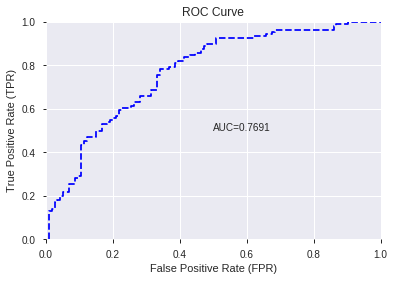

This function is available for GLM models only


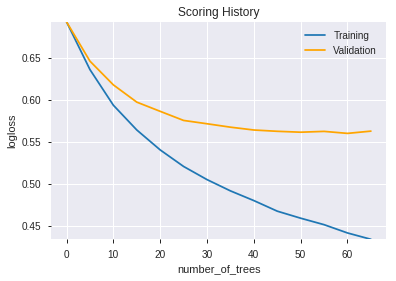

--2019-08-28 19:43:05--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.108.11
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.108.11|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.calculateChildInclusiveNa(Share

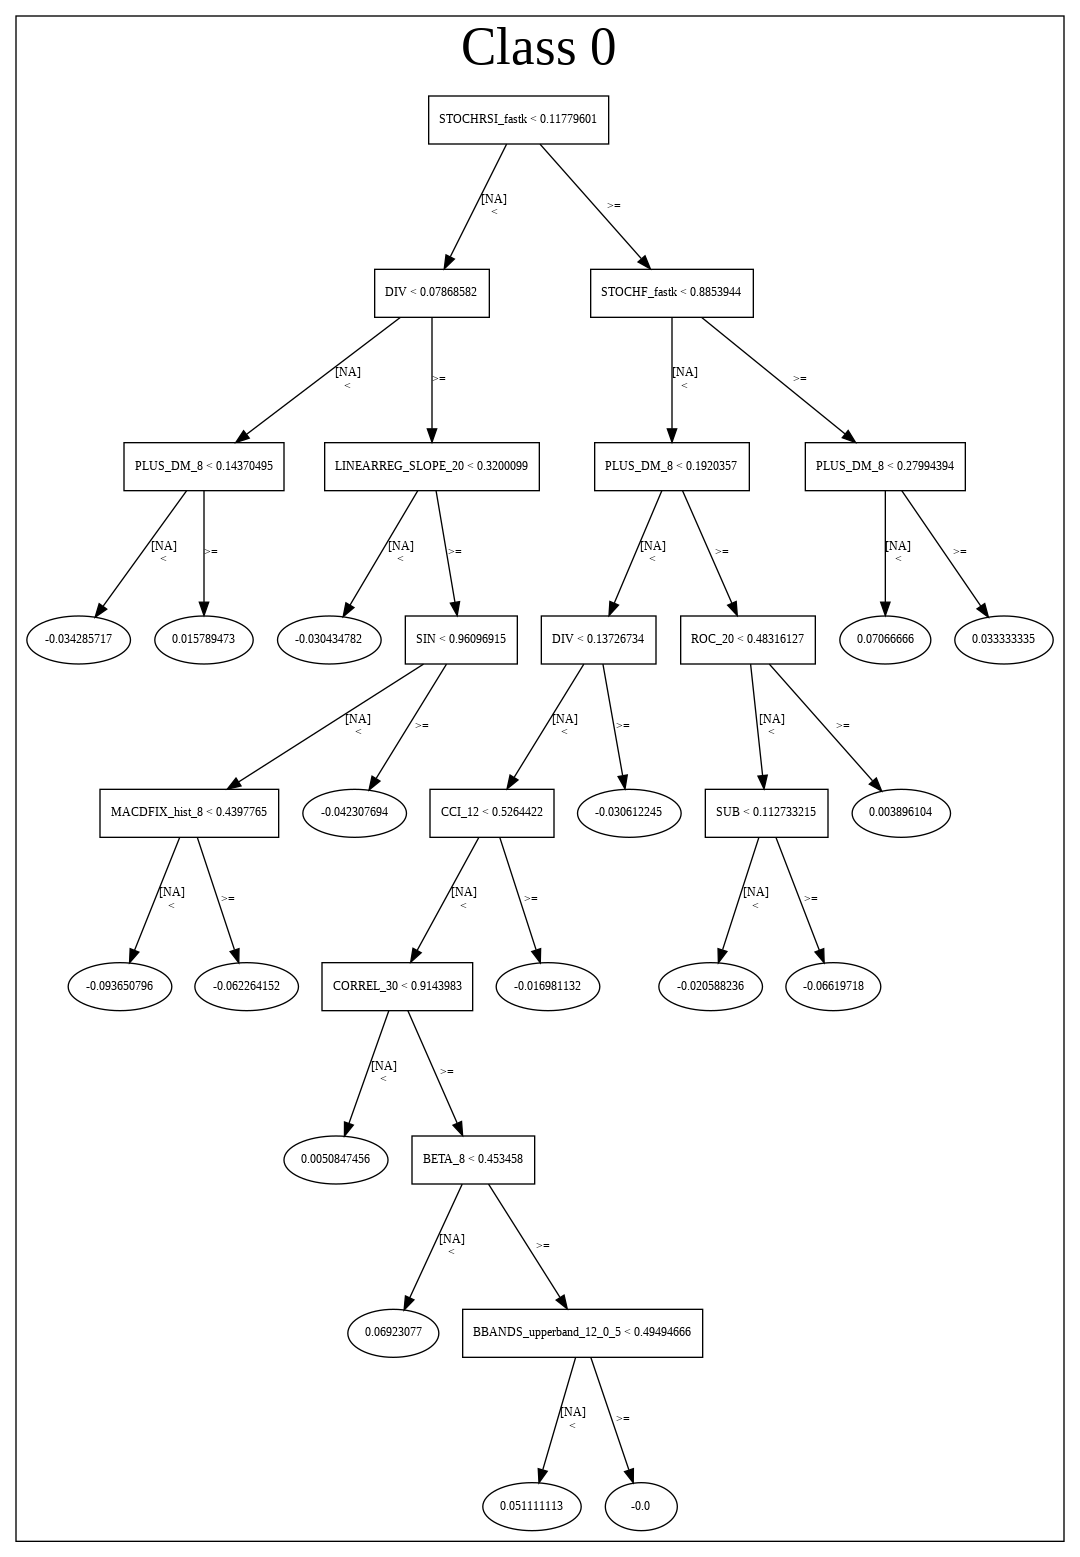

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190828_194241_model_6',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190828_194241_model_6',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_90_sid_8978',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['BOP',
 'TRANGE',
 'DIV',
 'STOCHF_fastk',
 'ADOSC',
 'SUB',
 'WILLR_8',
 'hour',
 'CCI_12',
 'STOCH_slowk',
 'ULTOSC',
 'CCI_8',
 'STOCHRSI_fastd',
 'STOCHRSI_fastk',
 'CMO_12',
 'WILLR_24',
 'WILLR_12',
 'CMO_8',
 'CCI_14',
 'WILLR_14',
 'WILLR_20',
 'STOCHF_fastd',
 'RSI_12',
 'CDLDRAGONFLYDOJI',
 'CDLENGULFING',
 'CDLCLOSINGMARUBOZU',
 'CDLLONGLINE',
 'CDLTAKURI',
 'RSI_8',
 'CDLSHORTLINE',
 'CDLBELTHOLD',
 'CDLMARUBOZU']

In [50]:
# XGBoost with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="XGBoost",features_list=features_list)

In [51]:
# recursive feature elimination with cross validation
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'RFE' in features_to_include:
  from sklearn.feature_selection import RFECV
  from sklearn.svm import LinearSVC
  from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier
  from sklearn.linear_model import LogisticRegression, LinearRegression

  bestfeatures = RFECV(ExtraTreeClassifier(random_state=1,criterion='entropy'), min_features_to_select=select_rfe, step=1,cv=5).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, RFECV, LinearSVC, DecisionTreeClassifier,ExtraTreeClassifier, LogisticRegression, LinearRegression
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list = []

226

['TRIMA_20',
 'WMA_20',
 'MAVP_20_0',
 'BBANDS_upperband_20_0_2',
 'BBANDS_middleband_20_0_2',
 'BBANDS_upperband_20_0_3',
 'BBANDS_lowerband_20_0_3',
 'BBANDS_upperband_20_0_4',
 'BBANDS_middleband_20_0_4',
 'BBANDS_upperband_20_0_5',
 'BBANDS_lowerband_20_0_5',
 'MAVP_20_1',
 'BBANDS_lowerband_20_1_2',
 'BBANDS_upperband_20_1_3',
 'BBANDS_lowerband_20_1_3',
 'BBANDS_upperband_20_1_4',
 'BBANDS_middleband_20_1_5',
 'BBANDS_lowerband_20_1_5',
 'BBANDS_upperband_20_2_3',
 'BBANDS_middleband_20_2_3',
 'BBANDS_lowerband_20_2_3',
 'MAVP_20_3',
 'BBANDS_upperband_20_3_2',
 'BBANDS_middleband_20_3_2',
 'BBANDS_lowerband_20_3_3',
 'BBANDS_upperband_20_3_4',
 'BBANDS_middleband_20_3_5',
 'BBANDS_lowerband_20_5_3',
 'BBANDS_upperband_20_5_4',
 'BBANDS_upperband_20_5_5',
 'BBANDS_middleband_20_5_5',
 'BBANDS_upperband_20_6_2',
 'BBANDS_upperband_20_6_5',
 'BBANDS_lowerband_20_6_5',
 'BBANDS_lowerband_20_7_2',
 'BBANDS_lowerband_20_7_3',
 'BBANDS_lowerband_20_7_4',
 'BBANDS_upperband_20_7_5',
 'B

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190828_194504_model_2  0.772840  0.606959              0.290053  0.448524  0.201174
1  DeepLearning_grid_1_AutoML_20190828_194504_model_9  0.772178  0.574953              0.297501  0.443713  0.196881
2  DeepLearning_grid_1_AutoML_20190828_194504_model_6  0.768123  0.569705              0.264730  0.440446  0.193993
3  DeepLearning_grid_1_AutoML_20190828_194504_model_5  0.763241  0.587828              0.280619  0.450216  0.202694
4  DeepLearning_grid_1_AutoML_20190828_194504_model_8  0.754303  0.591907              0.282605  0.449188  0.201770
5  DeepLearning_grid_1_AutoML_20190828_194504_model_3  0.752317  0.626037              0.320755  0.457772  0.209555
6  DeepLearning_grid_1_AutoML_20190828_194504_model_7  0.747683  0.690035              0.285998  0.468262  0.219270
7  DeepLearning_grid_1_AutoML_20190828_194504_model_1  0.743628  0.926952              0.307597  0.508067  0.258132
8  DeepLearning_grid_1_AutoML_20190828_194504_model_4  0.717229  0.869471              0.340698  0.508269  0.258337
9               DeepLearning_1_AutoML_20190828_194504  0.689176  0.677319              0.323155  0.483900  0.234160

variable  relative_importance  scaled_importance  percentage
0                        BOP             1.000000           1.000000    0.010944
1                     TRANGE             0.956102           0.956102    0.010463
2               HT_TRENDMODE             0.596789           0.596789    0.006531
3               STOCHF_fastk             0.558129           0.558129    0.006108
4                    BETA_14             0.535393           0.535393    0.005859
..                       ...                  ...                ...         ...
221                   RSI_14             0.341408           0.341408    0.003736
222                   CMO_12             0.338024           0.338024    0.003699
223                   CMO_14             0.332241           0.332241    0.003636
224                  ROCR_14             0.329705           0.329705    0.003608
225  BBANDS_lowerband_20_0_5             0.329135           0.329135    0.003602

[226 rows x 4 columns]

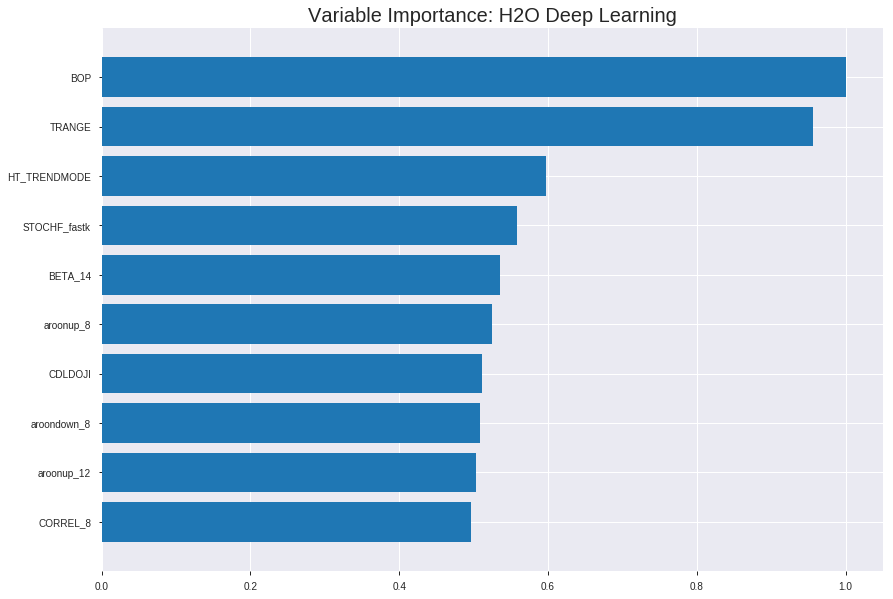

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190828_194504_model_2


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.21384917433133938
RMSE: 0.46243829245785795
LogLoss: 0.6506274799728193
Mean Per-Class Error: 0.30185183285986306
AUC: 0.7571174377224199
pr_auc: 0.6853550205050378
Gini: 0.5142348754448398
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.24306504000818752: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      413  430   0.5101   (430.0/843.0)
1      88   606   0.1268   (88.0/694.0)
Total  501  1036  0.337    (518.0/1537.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.243065     0.700578  289
max f2                       0.0641448    0.83089   360
max f0point5                 0.542676     0.660683  180
max accuracy                 0.542676     0.692908  180
max precision                0.996716     0.888889  1
max recall                   0.00695364   1         395
max specificity              0.998762     0.998814  0
max absolute_mcc             0.317469     0.397743  258
max min_per_class_accuracy   0.47831      0.688761  200
max mean_per_class_accuracy  0.383124     0.698148  234

Gains/Lift Table: Avg response rate: 45.15 %, avg score: 47.37 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104099                   0.992792           1.93786   1.93786            0.875            0.99645    0.875                       0.99645             0.0201729       0.0201729                  93.786    93.786
    2        0.0201692                   0.99014            1.77176   1.85749            0.8              0.991008   0.83871                     0.993817            0.0172911       0.037464                   77.1758   85.7488
    3        0.0305791                   0.984386           1.93786   1.88485            0.875            0.987192   0.851064                    0.991562            0.0201729       0.0576369                  93.786    88.4849
    4        0.0403383                   0.978251           1.9194    1.89321            0.866667         0.980721   0.854839                    0.988939            0.018732        0.0763689                  91.9404   89.3209
    5        0.0500976                   0.97098            1.77176   1.86955            0.8              0.974671   0.844156                    0.986159            0.0172911       0.0936599                  77.1758   86.955
    6        0.100195                    0.941615           1.7545    1.81203            0.792208         0.955405   0.818182                    0.970782            0.0878963       0.181556                   75.4501   81.2025
    7        0.150293                    0.900542           1.38059   1.66821            0.623377         0.920954   0.753247                    0.954173            0.0691643       0.25072                    38.0591   66.8214
    8        0.20039                     0.849407           1.2943    1.57474            0.584416         0.874079   0.711039                    0.934149            0.0648415       0.315562                   29.4304   57.4736
    9        0.299935                    0.729232           1.46199   1.53732            0.660131         0.789039   0.694143                    0.885989            0.145533        0.461095                   46.199    53.7317
    10       0.40013                     0.594655           1.2943    1.47646            0.584416         0.662324   0.666667                    0.829982            0.129683        0.590778                   29.4304   47.6465
    11       0.500325                    0.448509           1.17925   1.41695            0.532468         0.522585   0.639792                    0.768423            0.118156        0.708934                   17.9254   41.6946
    12       0.59987                     0.319096           1.02774   1.35236            0.464052         0.386894   0.610629                    0.70511             0.102305        0.811239                   2.77354   35.2359
    13       0.700065                    0.215547           0.776582  1.26995            0.350649         0.266496   0.57342                     0.642335            0.0778098       0.889049                   -22.3418  26.9952
    14       0.79961                     0.10366            0.622431  1.18934            0.281046         0.156227   0.537022                    0.581818            0.0619597       0.951009                   -37.7569  18.9341
    15       0.899805                    0.0382225          0.330766  1.09374            0.149351         0.0678533  0.493854                    0.524587            0.0331412       0.98415                    -66.9234  9.3737
    16       1                           5.824e-05          0.158193  1                  0.0714286        0.0166045  0.451529                    0.



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.240862662578557
RMSE: 0.49077761010314747
LogLoss: 0.7162197892002968
Mean Per-Class Error: 0.333751411012166
AUC: 0.7121953258915507
pr_auc: 0.6449190271355834
Gini: 0.4243906517831013
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2280856442419049: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      104  134  0.563    (134.0/238.0)
1      21   180  0.1045   (21.0/201.0)
Total  125  314  0.3531   (155.0/439.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.228086     0.699029  290
max f2                       0.0670049    0.839012  343
max f0point5                 0.360554     0.620438  237
max accuracy                 0.600895     0.651481  173
max precision                0.995479     1         0
max recall                   0.0273656    1         369
max specificity              0.995479     1         0
max absolute_mcc             0.228086     0.367075  290
max min_per_class_accuracy   0.495838     0.641791  198
max mean_per_class_accuracy  0.228086     0.666249  290

Gains/Lift Table: Avg response rate: 45.79 %, avg score: 48.63 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113895                   0.990976           2.18408    2.18408            1                0.993946   1                           0.993946            0.0248756       0.0248756                  118.408   118.408
    2        0.0205011                   0.985407           1.63806    1.9414             0.75             0.987737   0.888889                    0.991186            0.0149254       0.039801                   63.806    94.1404
    3        0.0318907                   0.982291           2.18408    2.02807            1                0.983707   0.928571                    0.988515            0.0248756       0.0646766                  118.408   102.807
    4        0.0410023                   0.976017           1.09204    1.82007            0.5              0.979546   0.833333                    0.986522            0.00995025      0.0746269                  9.20398   82.0066
    5        0.0501139                   0.972594           2.18408    1.88625            1                0.974206   0.863636                    0.984283            0.0199005       0.0945274                  118.408   88.6251
    6        0.100228                    0.944928           1.19132    1.53878            0.545455         0.959362   0.704545                    0.971822            0.0597015       0.154229                   19.1316   53.8783
    7        0.150342                    0.901797           1.29059    1.45605            0.590909         0.923897   0.666667                    0.955847            0.0646766       0.218905                   29.0592   45.6053
    8        0.200456                    0.838199           1.38987    1.43951            0.636364         0.870122   0.659091                    0.934416            0.0696517       0.288557                   38.9869   43.9507
    9        0.300683                    0.742631           1.24095    1.37332            0.568182         0.795097   0.628788                    0.887976            0.124378        0.412935                   24.0954   37.3323
    10       0.400911                    0.6333             1.34023    1.36505            0.613636         0.688203   0.625                       0.838033            0.134328        0.547264                   34.0231   36.505
    11       0.501139                    0.479856           1.0424     1.30052            0.477273         0.553982   0.595455                    0.781223            0.104478        0.651741                   4.24016   30.052
    12       0.599089                    0.340711           1.16823    1.27889            0.534884         0.404269   0.585551                    0.719592            0.114428        0.766169                   16.8229   27.8891
    13       0.699317                    0.247551           1.0424     1.245              0.477273         0.299671   0.570033                    0.659408            0.104478        0.870647                   4.24016   24.4997
    14       0.799544                    0.111666           0.694934   1.17604            0.318182         0.178102   0.538462                    0.599073            0.0696517       0.940299                   -30.5066  17.6043
    15       0.899772                    0.0280154          0.54602    1.10586            0.25             0.0622951  0.506329                    0.53928             0.0547264       0.995025                   -45.398   10.5863
    16       1                           3.34809e-05        0.0496382  1                  0.0227273        0.0108592  0.457859   


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 19:46:03  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-28 19:46:06  1 min  0.456 sec  1718 obs/sec      2.7339    1             4202       0.486692         0.78341             0.0435366      0.753042        0.681124           1.79944          0.33637                          0.535039           0.941221              -0.153259        0.673952          0.609901             2.18408            0.414579
    2019-08-28 19:46:13  1 min  7.228 sec  1871 obs/sec      10.9636   4             16851      0.462438         0.650627            0.136488       0.757117        0.685355           1.93786          0.33702                          0.490778           0.71622               0.0296565        0.712195          0.644919             2.18408            0.353075
    2019-08-28 19:46:18  1 min 13.021 sec  2017 obs/sec      19.1607   7             29450      0.469072         0.678638            0.111536       0.748657        0.663254           2.07628          0.349382                         0.527627           0.894863              -0.121529        0.666855          0.585509             0.873632           0.432802
    2019-08-28 19:46:24  1 min 18.292 sec  2137 obs/sec      27.3539   10            42043      0.461349         0.654889            0.14055        0.76041         0.673768           2.07628          0.353286                         0.521405           0.84495               -0.0952343       0.676669          0.59694              1.31045            0.394077
    2019-08-28 19:46:30  1 min 24.643 sec  2277 obs/sec      38.2602   14            58806      0.454321         0.652016            0.166536       0.77932         0.698733           2.2147           0.307742                         0.51555            0.863382              -0.0707745       0.703729          0.633512             1.31045            0.38041
    2019-08-28 19:46:36  1 min 30.480 sec  2400 obs/sec      49.1392   18            75527      0.408732         0.514793            0.325413       0.835545        0.782315           2.07628          0.259597                         0.500887           0.796907              -0.0107299       0.702695          0.624358             1.31045            0.373576
    2019-08-28 19:46:41  1 min 35.927 sec  2515 obs/sec      60.0553   22            92305      0.397732         0.50001             0.361234       0.853325        0.78373            2.2147           0.219258                         0.509936           0.868439              -0.0475807       0.703353          0.627055             1.74726            0.357631
    2019-08-28 19:46:42  1 min 36.142 sec  2514 obs/sec      60.0553   22            92305      0.462438         0.650627            0.136488       0.757117        0.685355           1.93786          0.33702                          0.490778           0.71622               0.0296565        0.712195          0.644919             2.18408            0.353075

Variable Importances: 


variable                 relative_importance    scaled_importance    percentage
-----------------------  ---------------------  -------------------  ---------------------
BOP                      1.0                    1.0                  0.010943592950245667
TRANGE                   0.956102192401886      0.956102192401886    0.010463193212483705
HT_TRENDMODE             0.5967886447906494     0.5967886447906494   0.006531012005917616
STOCHF_fastk             0.5581294298171997     0.5581294298171997   0.00610794129347214
BETA_14                  0.5353929400444031     0.5353929400444031   0.0058591224042812305
---                      ---                    ---                  ---
RSI_14                   0.3414081633090973     0.3414081633090973   0.0037362319691457585
CMO_12                   0.3380238115787506     0.3380238115787506   0.003699195001408385
CMO_14                   0.3322407305240631     0.3322407305240631   0.0036359073163476073
ROCR_14                  0.32970482110977173    0.32970482110977173  0.0036081553559589065
BBANDS_lowerband_20_0_5  0.32913529872894287    0.32913529872894287  0.003601922734847061


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7227272727272728)

('F1', 0.736842105263158)

('auc', 0.7728401191658392)

('logloss', 0.606959417145335)

('mean_per_class_error', 0.2784673949023502)

('rmse', 0.44852419911276026)

('mse', 0.201173957189743)

deeplearning prediction progress: |███████████████████████████████████████| 100%


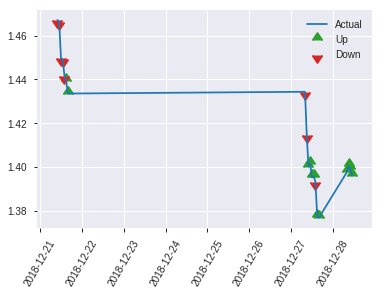


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.201173957189743
RMSE: 0.44852419911276026
LogLoss: 0.606959417145335
Mean Per-Class Error: 0.2784673949023502
AUC: 0.7728401191658392
pr_auc: 0.7206739753186594
Gini: 0.5456802383316783
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.28765736202538994: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      64   50   0.4386   (50.0/114.0)
1      15   91   0.1415   (15.0/106.0)
Total  79   141  0.2955   (65.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.287657     0.736842  140
max f2                       0.0240324    0.850722  198
max f0point5                 0.595753     0.715859  86
max accuracy                 0.500146     0.722727  100
max precision                0.997778     1         0
max recall                   0.0240324    1         198
max specificity              0.997778     1         0
max absolute_mcc             0.500146     0.444262  100
max min_per_class_accuracy   0.451802     0.707547  107
max mean_per_class_accuracy  0.500146     0.721533  100

Gains/Lift Table: Avg response rate: 48.18 %, avg score: 45.76 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136364                   0.98159            2.07547    2.07547            1                0.992077   1                           0.992077            0.0283019       0.0283019                  107.547   107.547
    2        0.0227273                   0.97627            2.07547    2.07547            1                0.976831   1                           0.985979            0.0188679       0.0471698                  107.547   107.547
    3        0.0318182                   0.96561            1.03774    1.77898            0.5              0.971877   0.857143                    0.98195             0.00943396      0.0566038                  3.77358   77.8976
    4        0.0409091                   0.957008           2.07547    1.84486            1                0.96071    0.888889                    0.97723             0.0188679       0.0754717                  107.547   84.4864
    5        0.05                        0.946056           2.07547    1.88679            1                0.95513    0.909091                    0.973212            0.0188679       0.0943396                  107.547   88.6792
    6        0.1                         0.8866             1.13208    1.50943            0.545455         0.912416   0.727273                    0.942814            0.0566038       0.150943                   13.2075   50.9434
    7        0.15                        0.832473           1.88679    1.63522            0.909091         0.858006   0.787879                    0.914545            0.0943396       0.245283                   88.6792   63.522
    8        0.2                         0.807697           1.13208    1.50943            0.545455         0.823328   0.727273                    0.89174             0.0566038       0.301887                   13.2075   50.9434
    9        0.3                         0.696661           1.88679    1.63522            0.909091         0.755996   0.787879                    0.846492            0.188679        0.490566                   88.6792   63.522
    10       0.4                         0.589559           1.22642    1.53302            0.590909         0.644073   0.738636                    0.795888            0.122642        0.613208                   22.6415   53.3019
    11       0.5                         0.439775           1.03774    1.43396            0.5              0.511817   0.690909                    0.739073            0.103774        0.716981                   3.77358   43.3962
    12       0.6                         0.323989           0.943396   1.3522             0.454545         0.395837   0.651515                    0.681867            0.0943396       0.811321                   -5.66038  35.2201
    13       0.7                         0.197642           0.660377   1.25337            0.318182         0.261736   0.603896                    0.621849            0.0660377       0.877358                   -33.9623  25.3369
    14       0.8                         0.111974           0.566038   1.16745            0.272727         0.152418   0.5625                      0.56317             0.0566038       0.933962                   -43.3962  16.7453
    15       0.9                         0.0261905          0.566038   1.10063            0.272727         0.0594448  0.530303                    0.5072              0.0566038       0.990566                   -43.3962  10.0629
    16       1                           0.00103784         0.0943396  1                  0.0454545        0.0113751  0.481818   

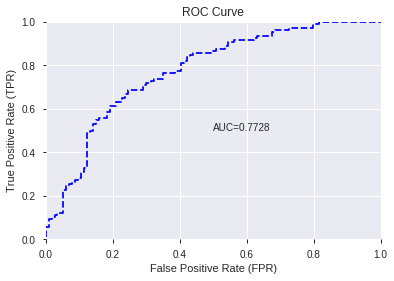

This function is available for GLM models only


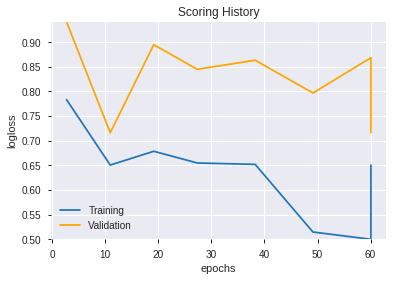

--2019-08-28 19:55:27--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.85.195
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.85.195|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


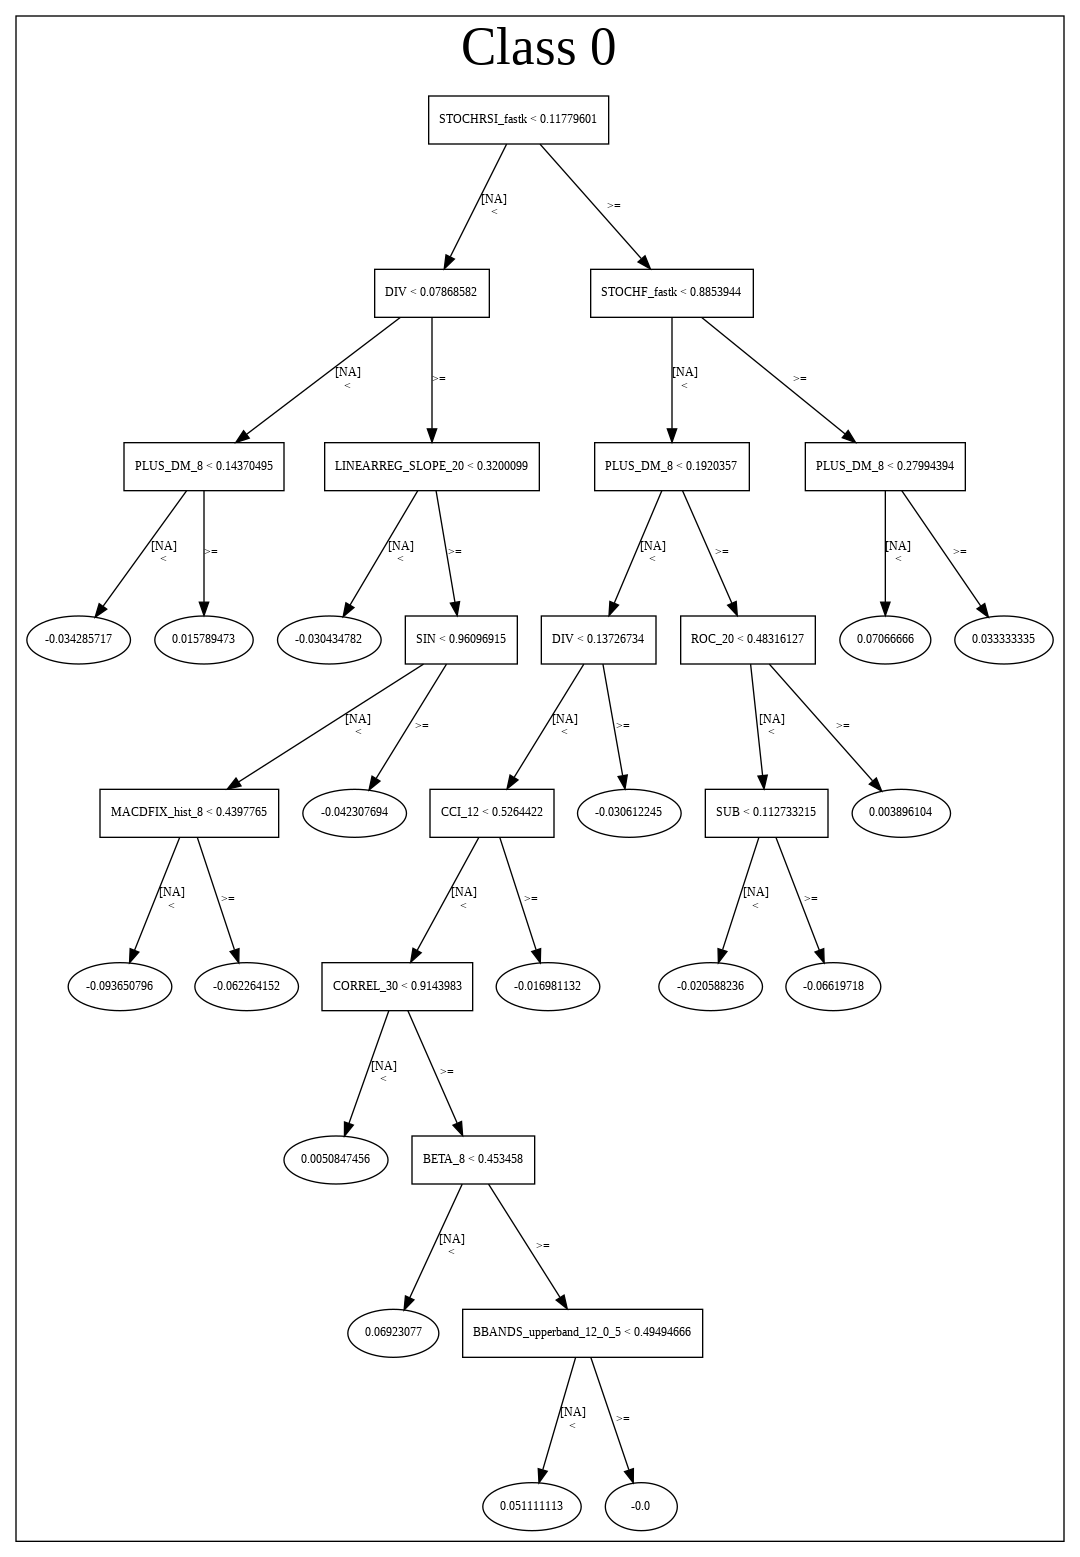

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190828_194504_model_2',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190828_194504_model_2',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_98_sid_8978',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['BOP',
 'TRANGE',
 'HT_TRENDMODE',
 'STOCHF_fastk',
 'BETA_14',
 'aroonup_8',
 'CDLDOJI',
 'aroondown_8',
 'aroonup_12',
 'CORREL_8',
 'CDLCLOSINGMARUBOZU',
 'CCI_8',
 'CDLLONGLINE',
 'aroondown_30',
 'AROONOSC_12',
 'aroonup_24',
 'PLUS_DM_8',
 'MFI_24',
 'STOCHRSI_fastk',
 'AROONOSC_14',
 'BETA_8',
 'CDLSHORTLINE',
 'CDLSPINNINGTOP',
 'CDLTAKURI',
 'ADX_24',
 'ADXR_14',
 'CDLHAMMER',
 'aroonup_30',
 'MFI_20',
 'STDDEV_8',
 'aroondown_24',
 'HT_PHASOR_quadrature',
 'STOCH_slowd',
 'DX_30',
 'ULTOSC',
 'STOCHF_fastd',
 'DX_24',
 'WILLR_30',
 'CDLHIKKAKE',
 'STDDEV_12',
 'PLUS_DI_8',
 'MFI_12',
 'STOCHRSI_fastd',
 'VAR_12',
 'CDLBELTHOLD',
 'CORREL_14',
 'WILLR_24',
 'DX_20',
 'CCI_12',
 'CDLRICKSHAWMAN',
 'CDLGRAVESTONEDOJI',
 'DX_8',
 'DX_12',
 'WILLR_12',
 'ATR_8',
 'CDLENGULFING',
 'AROONOSC_20',
 'WILLR_8',
 'aroonup_20',
 'CDLINVERTEDHAMMER',
 'PLUS_DI_12',
 'BBANDS_upperband_24_1_5',
 'CDLADVANCEBLOCK',
 'MACDFIX_signal_24',
 'PLUS_DI_24',
 'PLUS_DM_30',
 'PLUS_DI_20',
 'MOM_24'

In [52]:
# DeepLearning with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190828_195624_model_1  0.778385  0.571761              0.285667  0.441536  0.194954

variable  relative_importance  scaled_importance  percentage
0                         BOP             0.544131           1.000000    0.061221
1                      TRANGE             0.421789           0.775160    0.047456
2                STOCHF_fastk             0.268742           0.493893    0.030237
3                      ULTOSC             0.195967           0.360147    0.022048
4          CDLCLOSINGMARUBOZU             0.191247           0.351472    0.021517
..                        ...                  ...                ...         ...
221                 MAVP_24_1             0.000342           0.000628    0.000038
222                    WMA_20             0.000302           0.000556    0.000034
223  BBANDS_middleband_20_2_3             0.000258           0.000474    0.000029
224                PLUS_DI_24             0.000177           0.000325    0.000020
225                PLUS_DI_20             0.000084           0.000155    0.000009

[226 rows x 4 columns]

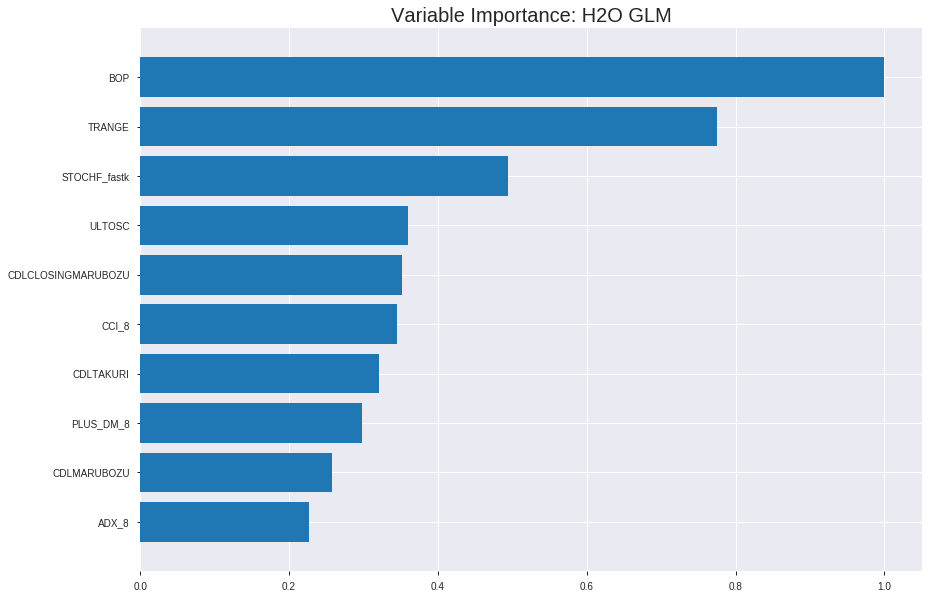

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190828_195624_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.18185015272178917
RMSE: 0.4264389202708744
LogLoss: 0.5412441998865006
Null degrees of freedom: 1536
Residual degrees of freedom: 1310
Null deviance: 2116.267351263065
Residual deviance: 1663.784670451103
AIC: 2117.784670451103
AUC: 0.8014287863093589
pr_auc: 0.737572387342289
Gini: 0.6028575726187178
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.41501211827358897: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      556  287  0.3405   (287.0/843.0)
1      131  563  0.1888   (131.0/694.0)
Total  687  850  0.272    (418.0/1537.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.415012     0.729275  218
max f2                       0.196186     0.83416   322
max f0point5                 0.518169     0.712093  167
max accuracy                 0.518169     0.735198  167
max precision                0.902956     1         0
max recall                   0.0722816    1         380
max specificity              0.902956     1         0
max absolute_mcc             0.437394     0.476952  207
max min_per_class_accuracy   0.477845     0.733429  189
max mean_per_class_accuracy  0.437394     0.739288  207

Gains/Lift Table: Avg response rate: 45.15 %, avg score: 45.15 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104099                   0.873742           1.79944   1.79944            0.8125           0.888136  0.8125                      0.888136            0.018732        0.018732                   79.9442   79.9442
    2        0.0201692                   0.857032           1.77176   1.78605            0.8              0.864027  0.806452                    0.876471            0.0172911       0.0360231                  77.1758   78.6046
    3        0.0305791                   0.839446           1.79944   1.79061            0.8125           0.848763  0.808511                    0.867038            0.018732        0.054755                   79.9442   79.0606
    4        0.0403383                   0.821803           1.9194    1.82177            0.866667         0.828824  0.822581                    0.857793            0.018732        0.073487                   91.9404   82.1767
    5        0.0500976                   0.811948           1.62411   1.78326            0.733333         0.816944  0.805195                    0.849835            0.0158501       0.0893372                  62.4111   78.3263
    6        0.100195                    0.763559           1.95584   1.86955            0.883117         0.786649  0.844156                    0.818242            0.0979827       0.18732                    95.5837   86.955
    7        0.150293                    0.718375           1.7545    1.8312             0.792208         0.739811  0.82684                     0.792099            0.0878963       0.275216                   75.4501   83.12
    8        0.20039                     0.683059           1.55316   1.76169            0.701299         0.70085   0.795455                    0.769286            0.0778098       0.353026                   55.3164   76.1691
    9        0.299935                    0.610922           1.44751   1.65742            0.653595         0.647897  0.748373                    0.728999            0.144092        0.497118                   44.7515   65.742
    10       0.40013                     0.527338           1.4525    1.60611            0.655844         0.570333  0.725203                    0.689268            0.145533        0.642651                   45.2496   60.6106
    11       0.500325                    0.453319           1.15049   1.51486            0.519481         0.495142  0.684005                    0.650392            0.115274        0.757925                   15.0492   51.4865
    12       0.59987                     0.378983           0.839558  1.4028             0.379085         0.415927  0.633406                    0.611484            0.0835735       0.841499                   -16.0442  40.2802
    13       0.700065                    0.297316           0.733439  1.307              0.331169         0.337653  0.590149                    0.572293            0.073487        0.914986                   -26.6561  30.7001
    14       0.79961                     0.213617           0.405304  1.19475            0.183007         0.256704  0.539463                    0.533004            0.0403458       0.955331                   -59.4696  19.4747
    15       0.899805                    0.130147           0.345148  1.10014            0.155844         0.169957  0.496746                    0.492578            0.0345821       0.989914                   -65.4852  10.0143
    16       1                           0.00180844         0.100668  1                  0.0454545        0.082884  0.451529                    0.451529            0



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.1981751130906566
RMSE: 0.4451686344416648
LogLoss: 0.5786219362893236
Null degrees of freedom: 438
Residual degrees of freedom: 212
Null deviance: 605.5320386942669
Residual deviance: 508.0300600620261
AIC: 962.0300600620261
AUC: 0.7609327313014758
pr_auc: 0.711025426019533
Gini: 0.5218654626029515
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.35940749527376104: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      133  105  0.4412   (105.0/238.0)
1      36   165  0.1791   (36.0/201.0)
Total  169  270  0.3212   (141.0/439.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.359407     0.700637  242
max f2                       0.134407     0.829858  357
max f0point5                 0.477884     0.682927  185
max accuracy                 0.477884     0.710706  185
max precision                0.908961     1         0
max recall                   0.0381715    1         393
max specificity              0.908961     1         0
max absolute_mcc             0.477884     0.418507  185
max min_per_class_accuracy   0.469866     0.701493  190
max mean_per_class_accuracy  0.477884     0.709603  185

Gains/Lift Table: Avg response rate: 45.79 %, avg score: 43.98 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113895                   0.828283           1.74726    1.74726            0.8              0.862696   0.8                         0.862696            0.0199005       0.0199005                  74.7264   74.7264
    2        0.0205011                   0.797926           2.18408    1.9414             1                0.814391   0.888889                    0.841227            0.0199005       0.039801                   118.408   94.1404
    3        0.0318907                   0.788088           1.74726    1.87207            0.8              0.793168   0.857143                    0.824063            0.0199005       0.0597015                  74.7264   87.2068
    4        0.0410023                   0.784522           2.18408    1.9414             1                0.786504   0.888889                    0.815717            0.0199005       0.079602                   118.408   94.1404
    5        0.0501139                   0.770193           2.18408    1.98553            1                0.779028   0.909091                    0.809046            0.0199005       0.0995025                  118.408   98.5527
    6        0.100228                    0.718261           1.58842    1.78697            0.727273         0.746208   0.818182                    0.777627            0.079602        0.179104                   58.8422   78.6974
    7        0.150342                    0.682805           1.78697    1.78697            0.818182         0.698649   0.818182                    0.751301            0.0895522       0.268657                   78.6974   78.6974
    8        0.200456                    0.652682           1.38987    1.6877             0.636364         0.666404   0.772727                    0.730077            0.0696517       0.338308                   38.9869   68.7698
    9        0.300683                    0.594982           1.34023    1.57188            0.613636         0.61853    0.719697                    0.692894            0.134328        0.472637                   34.0231   57.1875
    10       0.400911                    0.519288           1.24095    1.48915            0.568182         0.558672   0.681818                    0.659339            0.124378        0.597015                   24.0954   48.9145
    11       0.501139                    0.461103           1.24095    1.43951            0.568182         0.48831    0.659091                    0.625133            0.124378        0.721393                   24.0954   43.9507
    12       0.599089                    0.369845           0.711096   1.32041            0.325581         0.415787   0.604563                    0.590905            0.0696517       0.791045                   -28.8904  32.0413
    13       0.699317                    0.298875           0.694934   1.23077            0.318182         0.339402   0.563518                    0.554859            0.0696517       0.860697                   -30.5066  23.0768
    14       0.799544                    0.219145           0.843849   1.18227            0.386364         0.258313   0.541311                    0.517685            0.0845771       0.945274                   -15.6151  18.2265
    15       0.899772                    0.133755           0.446744   1.10033            0.204545         0.183307   0.503797                    0.480438            0.0447761       0.99005                    -55.3256  10.0334
    16       1                           0.00754667         0.0992763  1                  0.0454545        0.0745251  0.457859 


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------  -----------  --------  ------------  ------------------  ------------------
     2019-08-28 19:56:24  0.000 sec   2            .2E2      227           1.3550335955282928  1.3584422120370192
     2019-08-28 19:56:24  0.145 sec   4            .15E2     227           1.3485010714670944  1.352644134358802
     2019-08-28 19:56:25  0.272 sec   6            .11E2     227           1.3403551301396301  1.3455321440251342
     2019-08-28 19:56:25  0.397 sec   8            .78E1     227           1.3304023301832644  1.3370238231625693
     2019-08-28 19:56:25  0.519 sec   10           .57E1     227           1.3185257959101466  1.327067771659123
---  ---                  ---         ---          ---       ---           ---                 ---
     2019-08-28 19:56:27  2.802 sec   46           .19E-1    227           1.076742512020304   1.1572550449465726
     2019-08-28 19:56:27  2.933 sec   48           .14E-1    227           1.0714766916384812  1.1588468478504554
     2019-08-28 19:56:27  3.058 sec   50           .99E-2    227           1.0668892249731001  1.162508933217864
     2019-08-28 19:56:28  3.186 sec   52           .72E-2    227           1.062709812341284   1.1672190046871713
     2019-08-28 19:56:28  3.318 sec   54           .52E-2    227           1.0589242592048644  1.1735884490054775


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7363636363636363)

('F1', 0.7398373983739838)

('auc', 0.7783846408474014)

('logloss', 0.5717612721755919)

('mean_per_class_error', 0.26497848394571344)

('rmse', 0.4415363063609777)

('mse', 0.19495430983489515)

glm prediction progress: |████████████████████████████████████████████████| 100%


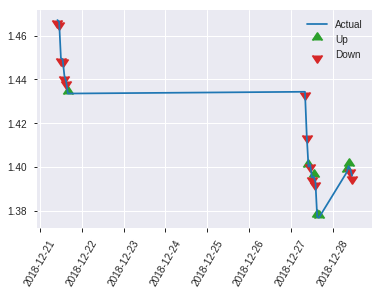


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.19495430983489515
RMSE: 0.4415363063609777
LogLoss: 0.5717612721755919
Null degrees of freedom: 219
Residual degrees of freedom: -7
Null deviance: 305.5060851051157
Residual deviance: 251.57495975726044
AIC: 705.5749597572604
AUC: 0.7783846408474014
pr_auc: 0.7371170772397415
Gini: 0.5567692816948029
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3234289277886031: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      65   49   0.4298   (49.0/114.0)
1      15   91   0.1415   (15.0/106.0)
Total  80   140  0.2909   (64.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.323429     0.739837  139
max f2                       0.0969566    0.845295  202
max f0point5                 0.511704     0.731441  87
max accuracy                 0.479185     0.736364  99
max precision                0.908981     1         0
max recall                   0.0969566    1         202
max specificity              0.908981     1         0
max absolute_mcc             0.479185     0.471685  99
max min_per_class_accuracy   0.46786      0.707547  107
max mean_per_class_accuracy  0.479185     0.735022  99

Gains/Lift Table: Avg response rate: 48.18 %, avg score: 42.50 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136364                   0.85158            2.07547   2.07547            1                0.880187   1                           0.880187            0.0283019       0.0283019                  107.547   107.547
    2        0.0227273                   0.836264           2.07547   2.07547            1                0.842602   1                           0.865153            0.0188679       0.0471698                  107.547   107.547
    3        0.0318182                   0.812979           1.03774   1.77898            0.5              0.825733   0.857143                    0.85389             0.00943396      0.0566038                  3.77358   77.8976
    4        0.0409091                   0.803586           2.07547   1.84486            1                0.806471   0.888889                    0.843353            0.0188679       0.0754717                  107.547   84.4864
    5        0.05                        0.751573           2.07547   1.88679            1                0.801517   0.909091                    0.835746            0.0188679       0.0943396                  107.547   88.6792
    6        0.1                         0.698911           1.32075   1.60377            0.636364         0.726959   0.772727                    0.781353            0.0660377       0.160377                   32.0755   60.3774
    7        0.15                        0.669909           1.88679   1.69811            0.909091         0.688985   0.818182                    0.750563            0.0943396       0.254717                   88.6792   69.8113
    8        0.2                         0.648515           1.32075   1.60377            0.636364         0.657847   0.772727                    0.727384            0.0660377       0.320755                   32.0755   60.3774
    9        0.3                         0.564755           1.60377   1.60377            0.772727         0.609289   0.772727                    0.688019            0.160377        0.481132                   60.3774   60.3774
    10       0.4                         0.508102           1.50943   1.58019            0.727273         0.539434   0.761364                    0.650873            0.150943        0.632075                   50.9434   58.0189
    11       0.5                         0.464093           0.754717  1.41509            0.363636         0.483418   0.681818                    0.617382            0.0754717       0.707547                   -24.5283  41.5094
    12       0.6                         0.368545           1.03774   1.3522             0.5              0.431254   0.651515                    0.586361            0.103774        0.811321                   3.77358   35.2201
    13       0.7                         0.255803           0.754717  1.26685            0.363636         0.308183   0.61039                     0.546621            0.0754717       0.886792                   -24.5283  26.6846
    14       0.8                         0.170968           0.471698  1.16745            0.227273         0.217174   0.5625                      0.50544             0.0471698       0.933962                   -52.8302  16.7453
    15       0.9                         0.107911           0.471698  1.09015            0.227273         0.136137   0.525253                    0.464406            0.0471698       0.981132                   -52.8302  9.01468
    16       1                           0.0226937          0.188679  1                  0.0909091        0.0701498  0.481818                   

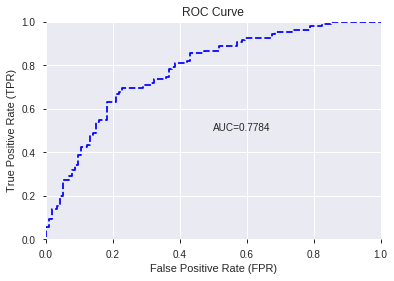

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


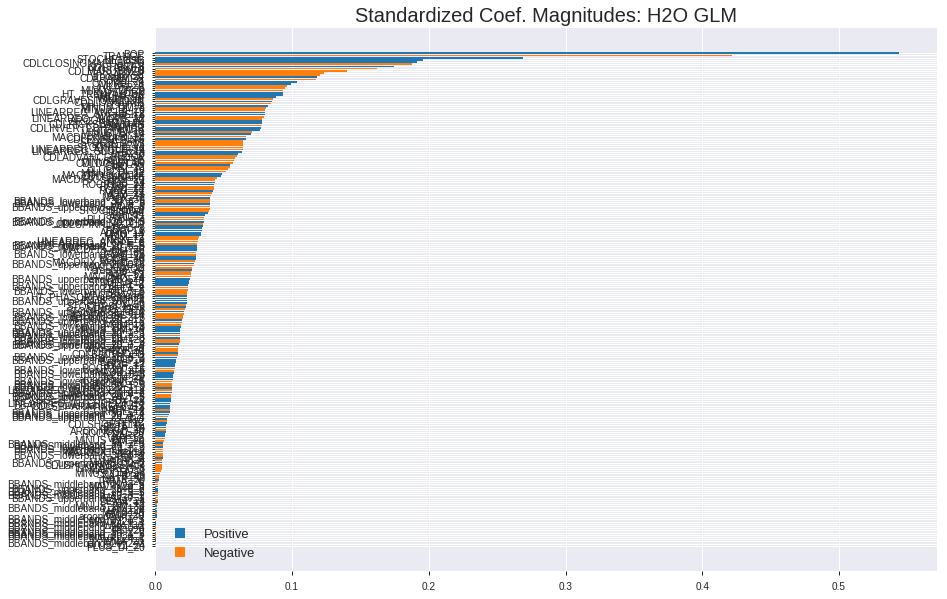

'log_likelihood'
--2019-08-28 19:56:41--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.105.211
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.105.211|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


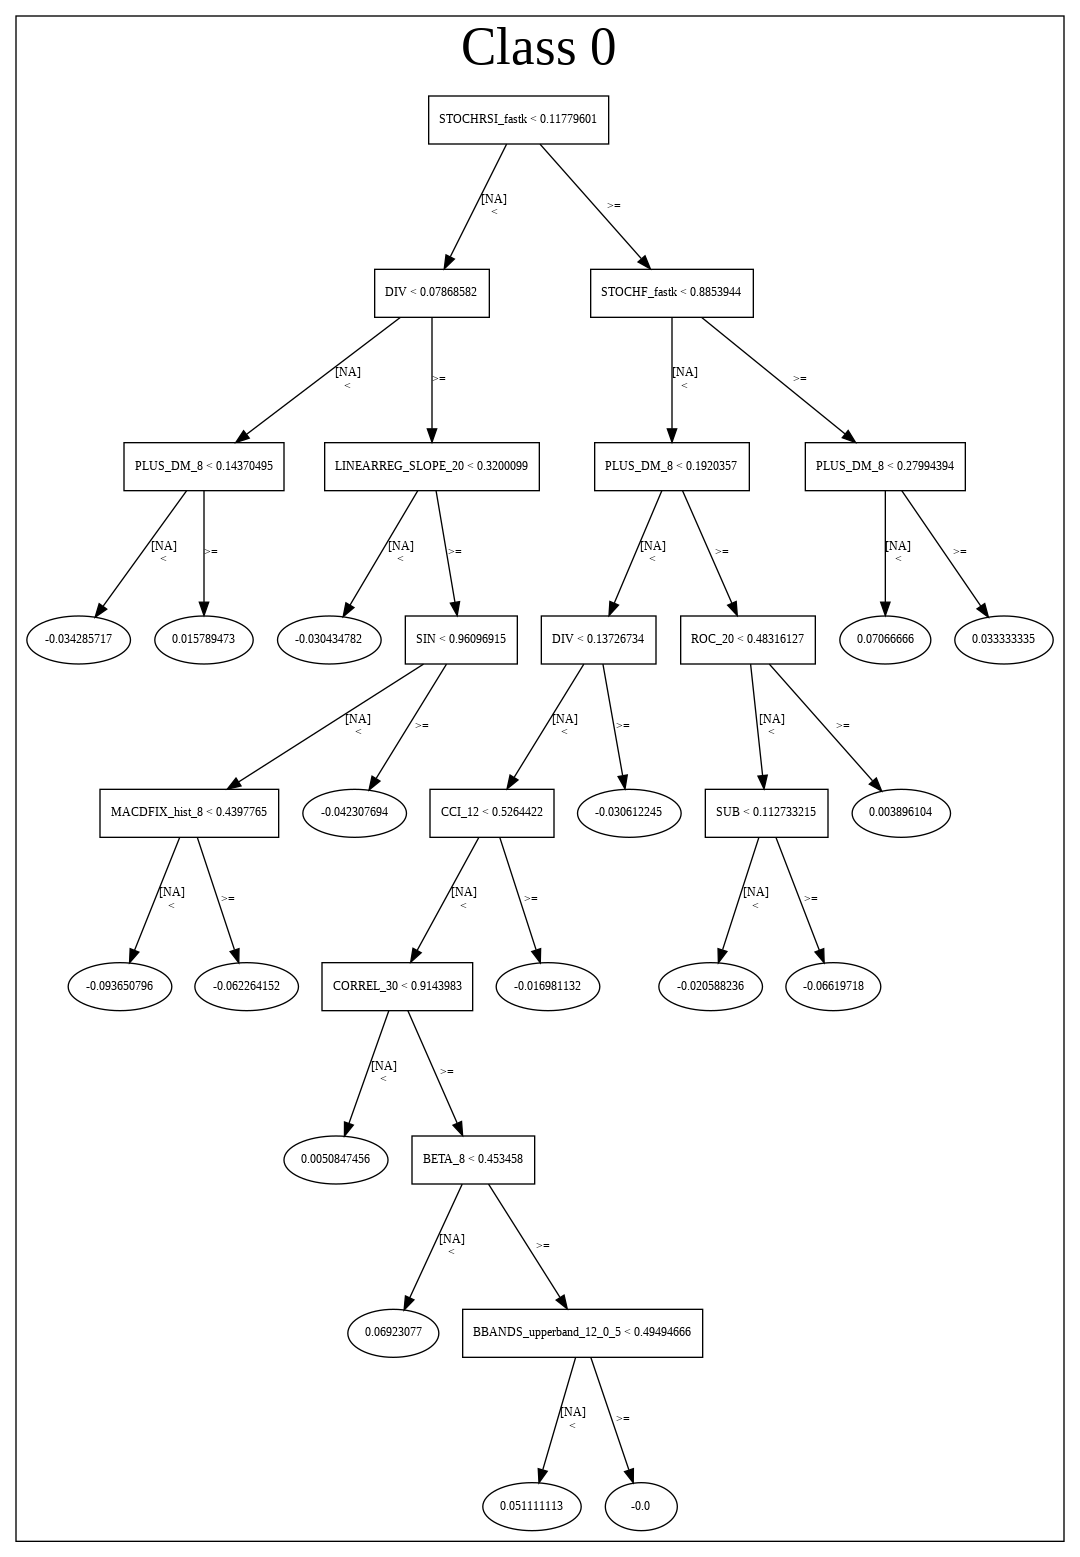

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190828_195624_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190828_195624_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_106_sid_8978',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_106

['BOP',
 'TRANGE',
 'STOCHF_fastk',
 'ULTOSC',
 'CDLCLOSINGMARUBOZU',
 'CCI_8',
 'CDLTAKURI',
 'PLUS_DM_8',
 'CDLMARUBOZU',
 'ADX_8',
 'aroonup_24',
 'CDLHAMMER',
 'MFI_24',
 'CORREL_8',
 'WILLR_24',
 'ATR_8',
 'MINUS_DI_20',
 'PLUS_DI_8',
 'HT_TRENDMODE',
 'WILLR_20',
 'WILLR_30',
 'CDLGRAVESTONEDOJI',
 'CDLLONGLINE',
 'CCI_12',
 'MINUS_DM_8',
 'MINUS_DI_24',
 'LINEARREG_ANGLE_12',
 'RSI_8',
 'WILLR_14',
 'LINEARREG_SLOPE_12',
 'AROONOSC_20',
 'SAR_0.24',
 'CDLRICKSHAWMAN',
 'MFI_12',
 'CDLINVERTEDHAMMER',
 'STDDEV_8',
 'MINUS_DI_14',
 'WILLR_12',
 'MACDFIX_signal_24',
 'CDLENGULFING',
 'STOCH_slowk',
 'aroonup_12',
 'STOCHF_fastd',
 'LINEARREG_ANGLE_14',
 'LINEARREG_SLOPE_14',
 'DX_8',
 'MFI_30',
 'CDLADVANCEBLOCK',
 'ADX_12',
 'MINUS_DI_30',
 'CDLDOJISTAR',
 'CMO_12',
 'RSI_30',
 'PLUS_DI_12',
 'MINUS_DI_12',
 'MACDFIX_hist_24',
 'CDLHIKKAKE',
 'MACDFIX_signal_20',
 'ROC_14',
 'ROCR100_24',
 'ROCP_24',
 'MFI_14',
 'ROCR_14',
 'MOM_24',
 'ADX_24',
 'NATR_12',
 'DX_30',
 'BBANDS_lower

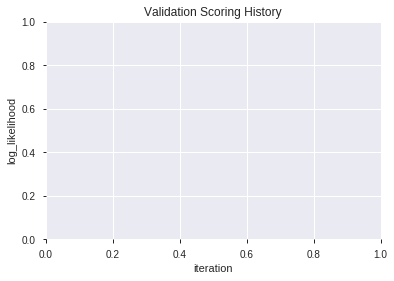

In [53]:
# GLM with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190828_195738_model_3  0.758937  0.584783              0.275571  0.447826  0.200548
1  XGBoost_grid_1_AutoML_20190828_195738_model_1  0.757531  0.587593              0.305611  0.448737  0.201365
2  XGBoost_grid_1_AutoML_20190828_195738_model_5  0.754551  0.601752              0.262413  0.454289  0.206379
3  XGBoost_grid_1_AutoML_20190828_195738_model_7  0.752317  0.590427              0.291129  0.450145  0.202631
4  XGBoost_grid_1_AutoML_20190828_195738_model_2  0.752069  0.584853              0.288067  0.448794  0.201416
5               XGBoost_1_AutoML_20190828_195738  0.751159  0.591720              0.283350  0.451383  0.203747
6               XGBoost_3_AutoML_20190828_195738  0.750662  0.588717              0.274909  0.449862  0.202376
7  XGBoost_grid_1_AutoML_20190828_195738_model_4  0.747600  0.590586              0.262744  0.450760  0.203184
8               XGBoost_2_AutoML_20190828_195738  0.746524  0.593543              0.274247  0.452402  0.204668
9  XGBoost_grid_1_AutoML_20190828_195738_model_6  0.743711  0.595851              0.296508  0.453068  0.205270

variable  relative_importance  scaled_importance  percentage
0               BOP          1487.926025           1.000000    0.189925
1            TRANGE           701.294861           0.471324    0.089516
2      STOCHF_fastk           301.463348           0.202606    0.038480
3    STOCHRSI_fastk           212.415329           0.142759    0.027114
4           WILLR_8           201.762558           0.135600    0.025754
..              ...                  ...                ...         ...
181       MAVP_20_0             2.509017           0.001686    0.000320
182           VAR_8             2.201907           0.001480    0.000281
183          RSI_30             0.793503           0.000533    0.000101
184         MA_24_5             0.636122           0.000428    0.000081
185        TRIMA_20             0.499386           0.000336    0.000064

[186 rows x 4 columns]

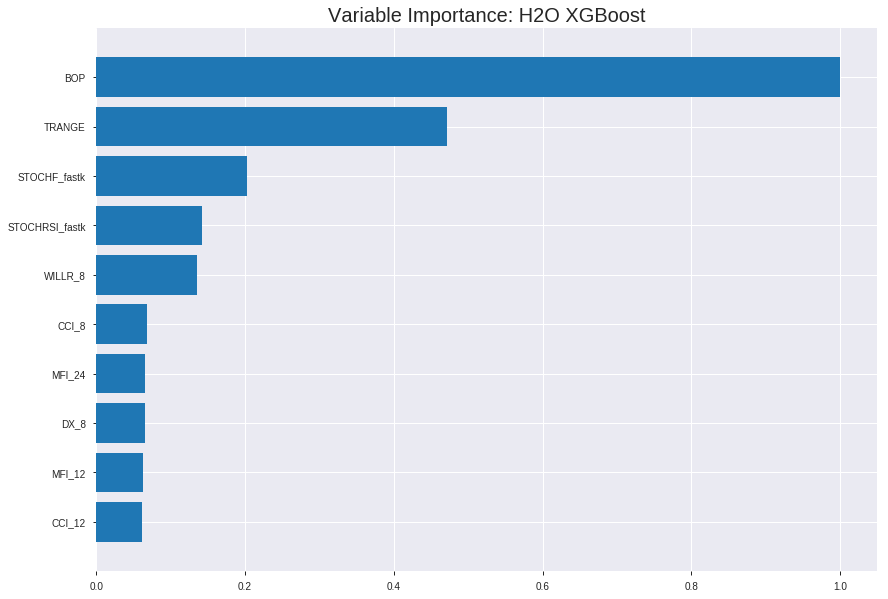

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190828_195738_model_3


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.12366986730620276
RMSE: 0.3516672678914015
LogLoss: 0.40864335731116413
Mean Per-Class Error: 0.12368770105394145
AUC: 0.9443604048940076
pr_auc: 0.9329019299308552
Gini: 0.8887208097880153
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4989274938901265: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      745  98   0.1163   (98.0/843.0)
1      91   603  0.1311   (91.0/694.0)
Total  836  701  0.123    (189.0/1537.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.498927     0.864516  181
max f2                       0.402082     0.893832  230
max f0point5                 0.596821     0.889615  134
max accuracy                 0.508928     0.877033  176
max precision                0.913055     1         0
max recall                   0.196784     1         320
max specificity              0.913055     1         0
max absolute_mcc             0.498927     0.751986  181
max min_per_class_accuracy   0.488808     0.873199  185
max mean_per_class_accuracy  0.498927     0.876312  181

Gains/Lift Table: Avg response rate: 45.15 %, avg score: 45.19 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104099                   0.891302           2.2147    2.2147             1                0.903626   1                           0.903626            0.0230548       0.0230548                  121.47    121.47
    2        0.0201692                   0.883883           2.2147    2.2147             1                0.887778   1                           0.895957            0.0216138       0.0446686                  121.47    121.47
    3        0.0305791                   0.868128           2.2147    2.2147             1                0.876095   1                           0.889196            0.0230548       0.0677233                  121.47    121.47
    4        0.0403383                   0.839336           2.2147    2.2147             1                0.852292   1                           0.880268            0.0216138       0.0893372                  121.47    121.47
    5        0.0500976                   0.822684           2.2147    2.2147             1                0.830787   1                           0.870629            0.0216138       0.110951                   121.47    121.47
    6        0.100195                    0.761189           2.09965   2.15717            0.948052         0.791349   0.974026                    0.830989            0.105187        0.216138                   109.965   115.717
    7        0.150293                    0.724116           2.18594   2.16676            0.987013         0.741563   0.978355                    0.80118             0.10951         0.325648                   118.594   116.676
    8        0.20039                     0.682248           2.15717   2.16436            0.974026         0.702214   0.977273                    0.776439            0.108069        0.433718                   115.717   116.436
    9        0.299935                    0.620617           1.99757   2.10901            0.901961         0.651609   0.952278                    0.735009            0.198847        0.632565                   99.757    110.901
    10       0.40013                     0.540731           1.71136   2.00943            0.772727         0.582568   0.907317                    0.696837            0.17147         0.804035                   71.1357   100.943
    11       0.500325                    0.456244           0.949156  1.7971             0.428571         0.49999    0.811443                    0.657416            0.0951009       0.899135                   -5.0844   79.7102
    12       0.59987                     0.381875           0.492155  1.58055            0.222222         0.419871   0.713666                    0.617997            0.0489914       0.948127                   -50.7845  58.0554
    13       0.700065                    0.285729           0.402672  1.41197            0.181818         0.337766   0.637546                    0.57789             0.0403458       0.988473                   -59.7328  41.1973
    14       0.79961                     0.184677           0.115801  1.25061            0.0522876        0.231529   0.564687                    0.534771            0.0115274       1                          -88.4199  25.061
    15       0.899805                    0.117123           0         1.11135            0                0.150057   0.501808                    0.491932            0               1                          -100      11.1352
    16       1                           0.0456908          0         1                  0                0.0927882  0.451529                    0.451



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.19884172623086205
RMSE: 0.4459167256684392
LogLoss: 0.5770334286315991
Mean Per-Class Error: 0.2937727329737865
AUC: 0.7559157991554831
pr_auc: 0.6812760122192879
Gini: 0.5118315983109663
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.297420471906662: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      109  129  0.542    (129.0/238.0)
1      18   183  0.0896   (18.0/201.0)
Total  127  312  0.3349   (147.0/439.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.29742      0.71345   287
max f2                       0.181776     0.843271  338
max f0point5                 0.45496      0.668733  210
max accuracy                 0.45496      0.701595  210
max precision                0.891906     1         0
max recall                   0.122032     1         365
max specificity              0.891906     1         0
max absolute_mcc             0.448112     0.412153  214
max min_per_class_accuracy   0.471589     0.686567  193
max mean_per_class_accuracy  0.448112     0.706227  214

Gains/Lift Table: Avg response rate: 45.79 %, avg score: 44.39 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113895                   0.870856           1.74726    1.74726            0.8              0.883314   0.8                         0.883314            0.0199005       0.0199005                  74.7264   74.7264
    2        0.0205011                   0.850676           2.18408    1.9414             1                0.858973   0.888889                    0.872496            0.0199005       0.039801                   118.408   94.1404
    3        0.0318907                   0.818237           2.18408    2.02807            1                0.830572   0.928571                    0.857523            0.0248756       0.0646766                  118.408   102.807
    4        0.0410023                   0.80412            1.63806    1.9414             0.75             0.812475   0.888889                    0.847512            0.0149254       0.079602                   63.806    94.1404
    5        0.0501139                   0.786905           2.18408    1.98553            1                0.7956     0.909091                    0.838074            0.0199005       0.0995025                  118.408   98.5527
    6        0.100228                    0.719643           1.09204    1.53878            0.5              0.75341    0.704545                    0.795742            0.0547264       0.154229                   9.20398   53.8783
    7        0.150342                    0.669602           1.48915    1.52224            0.681818         0.688258   0.69697                     0.759914            0.0746269       0.228856                   48.9145   52.2237
    8        0.200456                    0.632773           1.58842    1.53878            0.727273         0.654096   0.704545                    0.73346             0.079602        0.308458                   58.8422   53.8783
    9        0.300683                    0.582377           1.43951    1.50569            0.659091         0.609012   0.689394                    0.691977            0.144279        0.452736                   43.9507   50.5691
    10       0.400911                    0.52548            1.43951    1.48915            0.659091         0.556455   0.681818                    0.658096            0.144279        0.597015                   43.9507   48.9145
    11       0.501139                    0.46389            1.0424     1.3998             0.477273         0.49228    0.640909                    0.624933            0.104478        0.701493                   4.24016   39.9796
    12       0.599089                    0.394019           1.11744    1.35363            0.511628         0.437024   0.619772                    0.59421             0.109453        0.810945                   11.7436   35.3631
    13       0.699317                    0.310879           0.893487   1.28768            0.409091         0.352554   0.589577                    0.559576            0.0895522       0.900498                   -10.6513  28.7682
    14       0.799544                    0.212719           0.645296   1.20716            0.295455         0.253702   0.552707                    0.521233            0.0646766       0.965174                   -35.4704  20.7155
    15       0.899772                    0.13543            0.248191   1.10033            0.113636         0.174812   0.503797                    0.482644            0.0248756       0.99005                    -75.1809  10.0334
    16       1                           0.0477636          0.0992763  1                  0.0454545        0.0958102  0.457859 


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 19:57:47  3.127 sec   0                  0.5              0.693147            0.5             0                  1                0.548471                         0.5                0.693147              0.5               0                    1                  0.542141
    2019-08-28 19:57:48  3.412 sec   5                  0.470271         0.634999            0.842655        0.809628           2.2147           0.245283                         0.480613           0.654812              0.740332          0.663219             1.74726            0.318907
    2019-08-28 19:57:48  3.524 sec   10                 0.450222         0.59646             0.859611        0.832693           2.2147           0.232921                         0.468064           0.629755              0.752812          0.682715             1.74726            0.350797
    2019-08-28 19:57:48  3.641 sec   15                 0.433792         0.564724            0.874072        0.848007           2.2147           0.219909                         0.459701           0.612598              0.763525          0.689634             1.74726            0.330296
    2019-08-28 19:57:48  3.751 sec   20                 0.419532         0.537026            0.883204        0.85918            2.2147           0.22121                          0.45583            0.603724              0.755979          0.683166             2.18408            0.302961
    2019-08-28 19:57:48  3.862 sec   25                 0.407068         0.513194            0.896225        0.873442           2.2147           0.197137                         0.453001           0.596803              0.752801          0.679014             2.18408            0.334852
    2019-08-28 19:57:48  3.978 sec   30                 0.398225         0.495625            0.902371        0.881101           2.2147           0.173715                         0.450147           0.589965              0.755289          0.683426             2.18408            0.328018
    2019-08-28 19:57:48  4.102 sec   35                 0.389005         0.478127            0.911677        0.88887            2.2147           0.1581                           0.448629           0.586025              0.755749          0.68248              2.18408            0.341686
    2019-08-28 19:57:48  4.218 sec   40                 0.38113          0.462465            0.916991        0.898204           2.2147           0.150293                         0.447861           0.583831              0.754181          0.6794               2.18408            0.332574
    2019-08-28 19:57:49  4.335 sec   45                 0.375106         0.450731            0.923888        0.907156           2.2147           0.14769                          0.446393           0.580093              0.757201          0.683736             2.18408            0.314351
    2019-08-28 19:57:49  4.456 sec   50                 0.369315         0.439689            0.928632        0.913617           2.2147           0.139883                         0.445482           0.577492              0.758518          0.686371             2.18408            0.32574
    2019-08-28 19:57:49  4.614 sec   55                 0.362121         0.427071            0.936002        0.922863           2.2147           0.134027                         0.445581           0.576748              0.756773          0.

Variable Importances: 


variable        relative_importance    scaled_importance      percentage
--------------  ---------------------  ---------------------  ----------------------
BOP             1487.926025390625      1.0                    0.18992504271958086
TRANGE          701.2948608398438      0.47132374114884706    0.08951618167244745
STOCHF_fastk    301.4633483886719      0.20260640868186222    0.03848003082416354
STOCHRSI_fastk  212.4153289794922      0.14275933437196706    0.02711357267921477
WILLR_8         201.76255798339844     0.13559985815183906    0.025753808852257136
---             ---                    ---                    ---
MAVP_20_0       2.5090174674987793     0.0016862514833962175  0.00032026138501998314
VAR_8           2.201907157897949      0.00147984988522523    0.0002810605526699686
RSI_30          0.7935028076171875     0.0005332945281395084  0.00010128598603901483
MA_24_5         0.6361217498779297     0.0004275224298942743  8.119721576124905e-05
TRIMA_20        0.4993858337402344     0.000335625444557387   6.374367689534003e-05


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7181818181818181)

('F1', 0.753968253968254)

('auc', 0.7589374379344589)

('logloss', 0.5847834257673864)

('mean_per_class_error', 0.27557100297914594)

('rmse', 0.44782617953784437)

('mse', 0.2005482870794616)

xgboost prediction progress: |████████████████████████████████████████████| 100%


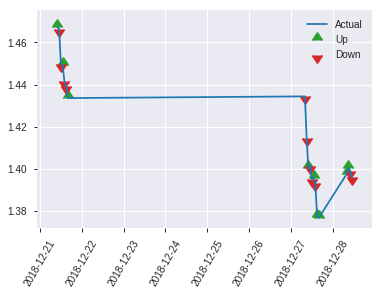


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.2005482870794616
RMSE: 0.44782617953784437
LogLoss: 0.5847834257673864
Mean Per-Class Error: 0.27557100297914594
AUC: 0.7589374379344589
pr_auc: 0.6930088726052835
Gini: 0.5178748758689178
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.34265366196632385: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      63   51   0.4474   (51.0/114.0)
1      11   95   0.1038   (11.0/106.0)
Total  74   146  0.2818   (62.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.342654     0.753968  145
max f2                       0.174144     0.848586  176
max f0point5                 0.458828     0.691882  108
max accuracy                 0.342654     0.718182  145
max precision                0.899772     1         0
max recall                   0.0817514    1         214
max specificity              0.899772     1         0
max absolute_mcc             0.342654     0.474703  145
max min_per_class_accuracy   0.458828     0.701754  108
max mean_per_class_accuracy  0.342654     0.724429  145

Gains/Lift Table: Avg response rate: 48.18 %, avg score: 43.19 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136364                   0.87913            2.07547   2.07547            1                0.888112  1                           0.888112            0.0283019       0.0283019                  107.547   107.547
    2        0.0227273                   0.859743           0         1.24528            0                0.872678  0.6                         0.881938            0               0.0283019                  -100      24.5283
    3        0.0318182                   0.829946           2.07547   1.48248            1                0.839701  0.714286                    0.869871            0.0188679       0.0471698                  107.547   48.248
    4        0.0409091                   0.805661           2.07547   1.61426            1                0.821643  0.777778                    0.859153            0.0188679       0.0660377                  107.547   61.4256
    5        0.05                        0.77195            2.07547   1.69811            1                0.788006  0.818182                    0.846217            0.0188679       0.0849057                  107.547   69.8113
    6        0.1                         0.722116           1.69811   1.69811            0.818182         0.745429  0.818182                    0.795823            0.0849057       0.169811                   69.8113   69.8113
    7        0.15                        0.661431           1.13208   1.50943            0.545455         0.69586   0.727273                    0.762502            0.0566038       0.226415                   13.2075   50.9434
    8        0.2                         0.640189           1.50943   1.50943            0.727273         0.650553  0.727273                    0.734515            0.0754717       0.301887                   50.9434   50.9434
    9        0.3                         0.57755            1.50943   1.50943            0.727273         0.611109  0.727273                    0.693379            0.150943        0.45283                    50.9434   50.9434
    10       0.4                         0.511828           1.13208   1.41509            0.545455         0.537593  0.681818                    0.654433            0.113208        0.566038                   13.2075   41.5094
    11       0.5                         0.455795           1.41509   1.41509            0.681818         0.483906  0.681818                    0.620327            0.141509        0.707547                   41.5094   41.5094
    12       0.6                         0.380014           1.03774   1.3522             0.5              0.416544  0.651515                    0.586363            0.103774        0.811321                   3.77358   35.2201
    13       0.7                         0.274903           0.943396  1.2938             0.454545         0.340348  0.623377                    0.551218            0.0943396       0.90566                    -5.66038  29.3801
    14       0.8                         0.175736           0.471698  1.19104            0.227273         0.222879  0.573864                    0.510176            0.0471698       0.95283                    -52.8302  19.1038
    15       0.9                         0.119254           0.283019  1.09015            0.136364         0.143582  0.525253                    0.469443            0.0283019       0.981132                   -71.6981  9.01468
    16       1                           0.0733498          0.188679  1                  0.0909091        0.094333  0.481818                    0.431932          

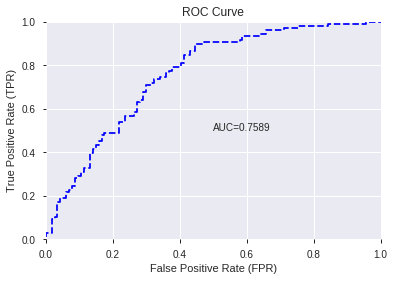

This function is available for GLM models only


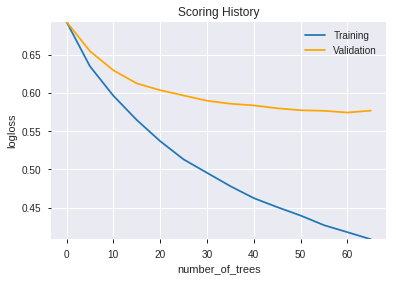

--2019-08-28 19:58:07--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.107.76
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.107.76|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.indexOf(String.java:1578)
	at java.base/java.lang.String.indexOf(String.java:1535)
	at java.base/java.lang.String.split(String.java:2274)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoMode

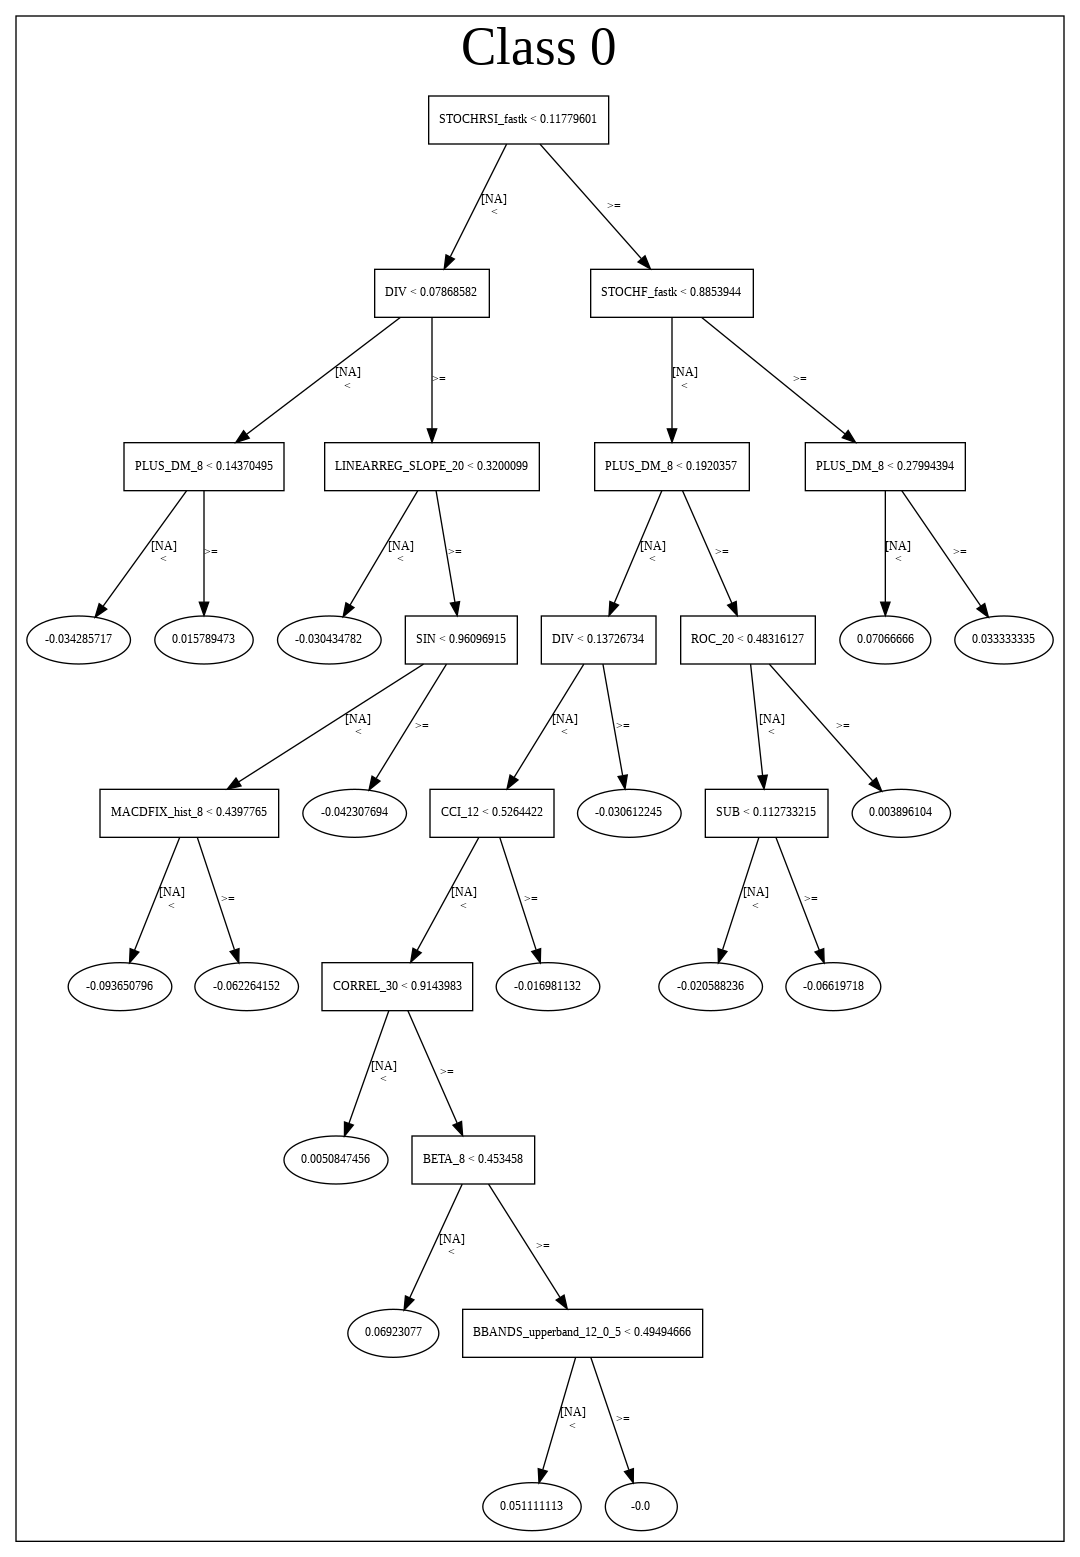

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190828_195738_model_3',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190828_195738_model_3',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_114_sid_8978',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_trainin

['BOP',
 'TRANGE',
 'STOCHF_fastk',
 'STOCHRSI_fastk',
 'WILLR_8',
 'CCI_8',
 'MFI_24',
 'DX_8',
 'MFI_12',
 'CCI_12',
 'MFI_8',
 'ULTOSC',
 'MFI_30',
 'CORREL_8',
 'ATR_24',
 'CDLCLOSINGMARUBOZU',
 'STOCH_slowk',
 'PLUS_DM_8',
 'ATR_12',
 'CORREL_14',
 'ADX_24',
 'CORREL_12',
 'STDDEV_8',
 'ADOSC',
 'STOCH_slowd',
 'MFI_14',
 'ADX_12',
 'aroonup_12',
 'CDLTAKURI',
 'NATR_12',
 'STOCHRSI_fastd',
 'MINUS_DM_24',
 'HT_PHASOR_quadrature',
 'DX_24',
 'WILLR_20',
 'NATR_24',
 'aroonup_8',
 'DX_12',
 'ROCP_20',
 'MACDFIX_hist_20',
 'MOM_8',
 'AROONOSC_30',
 'PLUS_DM_30',
 'ROCP_30',
 'DX_20',
 'aroondown_30',
 'ADXR_14',
 'ATR_8',
 'DX_30',
 'STDDEV_12',
 'MINUS_DI_20',
 'MINUS_DI_8',
 'PLUS_DI_20',
 'LINEARREG_ANGLE_8',
 'BETA_14',
 'MINUS_DM_8',
 'BETA_8',
 'MOM_20',
 'NATR_30',
 'BBANDS_middleband_20_3_2',
 'MINUS_DI_30',
 'aroonup_30',
 'PLUS_DI_8',
 'WILLR_14',
 'MACDFIX_signal_24',
 'WILLR_30',
 'MACD_hist',
 'ADX_8',
 'PLUS_DI_12',
 'BBANDS_lowerband_30_5_2',
 'MACDFIX_hist_24',
 'STO

In [54]:
# XGBoost with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="XGBoost",features_list=features_list)

In [55]:
# Experiment Summary
pd.set_option('precision', 3) 

for k in models_summary:
  print(k)
  display(models_summary[k].max())
  print('\n'*3)
  display(models_summary[k].groupby(models_summary[k].index).max())
  print('\n'*3)
  
display(models_summary)

pd.set_option('precision', 6) 

accuracy


DeepLearning    0.727
GLM             0.736
XGBoost         0.736
dtype: float64

DeepLearning    GLM  XGBoost
All          0.727  0.736    0.718
DLF          0.727  0.723    0.727
Fwe          0.718  0.714    0.718
RFE          0.723  0.736    0.718
XGBF         0.723  0.723    0.736





F1


DeepLearning    0.745
GLM             0.740
XGBoost         0.758
dtype: float64

DeepLearning    GLM  XGBoost
All          0.726  0.739    0.746
DLF          0.737  0.736    0.755
Fwe          0.745  0.731    0.748
RFE          0.737  0.740    0.754
XGBF         0.733  0.736    0.758





auc


DeepLearning    0.780
GLM             0.783
XGBoost         0.776
dtype: float64

DeepLearning    GLM  XGBoost
All          0.777  0.783    0.769
DLF          0.775  0.780    0.776
Fwe          0.774  0.762    0.769
RFE          0.773  0.778    0.759
XGBF         0.780  0.780    0.769





logloss


DeepLearning    0.607
GLM             0.582
XGBoost         0.585
dtype: float64

DeepLearning    GLM  XGBoost
All          0.568  0.579    0.581
DLF          0.569  0.570    0.569
Fwe          0.574  0.582    0.573
RFE          0.607  0.572    0.585
XGBF         0.585  0.570    0.580





mean_per_class_error


DeepLearning    0.283
GLM             0.285
XGBoost         0.282
dtype: float64

DeepLearning    GLM  XGBoost
All          0.272  0.262    0.282
DLF          0.270  0.280    0.268
Fwe          0.283  0.285    0.280
RFE          0.278  0.265    0.276
XGBF         0.282  0.280    0.259





rmse


DeepLearning    0.449
GLM             0.447
XGBoost         0.448
dtype: float64

DeepLearning    GLM  XGBoost
All          0.440  0.446    0.445
DLF          0.442  0.439    0.441
Fwe          0.442  0.447    0.441
RFE          0.449  0.442    0.448
XGBF         0.442  0.439    0.445





mse


DeepLearning    0.201
GLM             0.200
XGBoost         0.201
dtype: float64

DeepLearning    GLM  XGBoost
All          0.194  0.199    0.198
DLF          0.195  0.193    0.194
Fwe          0.195  0.200    0.194
RFE          0.201  0.195    0.201
XGBF         0.195  0.193    0.198

{'F1':       DeepLearning    GLM  XGBoost
 All          0.726    NaN      NaN
 DLF          0.737    NaN      NaN
 DLF            NaN  0.736      NaN
 DLF            NaN    NaN    0.755
 All            NaN  0.739      NaN
 All            NaN    NaN    0.746
 XGBF         0.733    NaN      NaN
 XGBF           NaN  0.736      NaN
 XGBF           NaN    NaN    0.758
 Fwe          0.745    NaN      NaN
 Fwe            NaN  0.731      NaN
 Fwe            NaN    NaN    0.748
 RFE          0.737    NaN      NaN
 RFE            NaN  0.740      NaN
 RFE            NaN    NaN    0.754,
 'accuracy':       DeepLearning    GLM  XGBoost
 All          0.727    NaN      NaN
 DLF          0.727    NaN      NaN
 DLF            NaN  0.723      NaN
 DLF            NaN    NaN    0.727
 All            NaN  0.736      NaN
 All            NaN    NaN    0.718
 XGBF         0.723    NaN      NaN
 XGBF           NaN  0.723      NaN
 XGBF           NaN    NaN    0.736
 Fwe          0.718    NaN      NaN
 Fwe     